In [1]:
import os
import sys
import subprocess
import time
import logging
import json
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Define your dataset and extraction folder (adjust the paths as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet").resolve()
FRAMES_ROOT  = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames").resolve()

# Validate that the dataset contains the required splits.
def validate_dataset(directory: Path):
    required_folders = ["Train", "Validation", "Test"]
    for folder in required_folders:
        folder_path = directory / folder
        if not folder_path.exists():
            raise FileNotFoundError(f"Missing dataset split: {folder_path}")
    print(f"✅ Dataset validated at {directory}")

validate_dataset(DATASET_ROOT)

✅ Dataset validated at C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet


### **Extract Frames from Videos**

Convert video files into individual frames for model training. This step is necessary as the DAiSEE dataset contains video clips, and models require image frames.


In [2]:
import os
import sys
import subprocess
import json
import logging
import time
import shutil
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

def get_csv_clip_id(video_stem: str) -> str:
    """
    Custom mapping: returns some modified ID if needed.
    Adjust or remove if your project doesn't require special ID mapping.
    """
    if video_stem.startswith("110001"):
        return "202614" + video_stem[-4:]
    else:
        return video_stem

# Persistent record of processed videos
PROCESSED_VIDEOS_FILE = FRAMES_ROOT / "processed_videos.json"

def load_processed_videos():
    if PROCESSED_VIDEOS_FILE.exists():
        try:
            with open(PROCESSED_VIDEOS_FILE, "r") as f:
                content = f.read()
                if not content.strip():
                    return {}
                return json.loads(content)
        except json.JSONDecodeError:
            return {}
    return {}

def save_processed_video(split, video_stem):
    processed = load_processed_videos()
    if split not in processed:
        processed[split] = []
    if video_stem not in processed[split]:
        processed[split].append(video_stem)
    with open(PROCESSED_VIDEOS_FILE, "w") as f:
        json.dump(processed, f)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler('frame_extraction.log')
    ]
)
logger = logging.getLogger(__name__)

# Extraction parameters
TARGET_FRAMES = 15
TARGET_RESOLUTION = (224, 224)
RESUME_ON_PARTIAL = True
PARTIAL_THRESHOLD = 1

def get_existing_output_dirs(output_root: Path):
    processed_map = {}
    for split in ["Train", "Validation", "Test"]:
        split_dir = output_root / split
        if split_dir.exists():
            for video_dir in split_dir.iterdir():
                if video_dir.is_dir():
                    processed_map[(split, video_dir.name)] = video_dir
    return processed_map

def verify_extracted_frames():
    processed_dirs = get_existing_output_dirs(FRAMES_ROOT)
    total_videos = 0
    fully_processed = 0
    for (_, video_dir) in processed_dirs.items():
        frames = list(video_dir.rglob("frame_*.jpg"))
        if frames:
            total_videos += 1
            if len(frames) >= TARGET_FRAMES:
                fully_processed += 1
    logger.info(f"Verification complete: {fully_processed}/{total_videos} videos fully processed")
    return fully_processed, total_videos

def check_ffmpeg():
    try:
        subprocess.run(['ffmpeg', '-version'], capture_output=True, text=True, check=True)
        cuda = subprocess.run(['ffmpeg', '-hwaccels'], capture_output=True, text=True, check=True)
        has_cuda = 'cuda' in cuda.stdout.lower()
        return True, has_cuda
    except (FileNotFoundError, subprocess.CalledProcessError):
        return False, False

def get_unprocessed_videos(dataset_root: Path, output_root: Path):
    videos_to_process = []
    total_videos = 0
    already_processed_count = 0
    persistent = load_processed_videos()

    logger.info(f"Scanning dataset in: {dataset_root}")
    logger.info(f"Using extracted frames from: {output_root}")

    for video_path in dataset_root.rglob("*.avi"):
        total_videos += 1
        rel = video_path.relative_to(dataset_root)
        split = rel.parts[0]
        raw_stem = video_path.stem
        csv_clip_id = get_csv_clip_id(raw_stem)
        output_dir = output_root / split / csv_clip_id

        if split in persistent and csv_clip_id in persistent[split]:
            if output_dir.exists():
                frames = list(output_dir.rglob("frame_*.jpg"))
                if len(frames) >= PARTIAL_THRESHOLD:
                    already_processed_count += 1
                    continue

        if output_dir.exists():
            frames = list(output_dir.rglob("frame_*.jpg"))
            if RESUME_ON_PARTIAL and len(frames) >= PARTIAL_THRESHOLD:
                already_processed_count += 1
                save_processed_video(split, csv_clip_id)
                continue
            elif len(frames) >= TARGET_FRAMES:
                already_processed_count += 1
                save_processed_video(split, csv_clip_id)
                continue
            else:
                for frame in frames:
                    frame.unlink()

        videos_to_process.append((video_path, output_dir))
    
    logger.info("\nScan Results:")
    logger.info(f"Total .avi files found: {total_videos}")
    logger.info(f"Already processed (or partially processed): {already_processed_count}")
    logger.info(f"Remaining to process: {len(videos_to_process)}")
    return videos_to_process

def extract_frames_with_ffmpeg(video_path, output_folder, use_gpu=True):
    """
    Extract frames with a target count, fallback from GPU to CPU, with a timeout.
    """
    try:
        output_folder = Path(output_folder)
        output_folder.mkdir(parents=True, exist_ok=True)

        duration_cmd = [
            'ffprobe', '-v', 'error',
            '-select_streams', 'v:0',
            '-show_entries', 'stream=duration',
            '-of', 'default=noprint_wrappers=1:nokey=1',
            str(video_path)
        ]
        duration_output = subprocess.check_output(duration_cmd, stderr=subprocess.STDOUT)
        duration = float(duration_output.decode().strip()) if duration_output else 0.0
        frame_interval = duration / TARGET_FRAMES if duration > 0 else 1 

        rel = Path(video_path).relative_to(DATASET_ROOT)
        split = rel.parts[0]
        raw_stem = Path(video_path).stem
        csv_clip_id = get_csv_clip_id(raw_stem)

        cmd = ['ffmpeg', '-y']
        if use_gpu:
            cmd.extend([
                '-hwaccel', 'cuda',
                '-hwaccel_output_format', 'cuda',
                '-c:v', 'h264_cuvid'
            ])

        cmd.extend([
            '-i', str(video_path),
            '-vf', f'fps=1/{frame_interval},scale={TARGET_RESOLUTION[0]}:{TARGET_RESOLUTION[1]}',
            '-vframes', str(TARGET_FRAMES),
            '-preset', 'ultrafast',
            '-q:v', '2',
            str(output_folder / 'frame_%04d.jpg')
        ])

        run_result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
        if run_result.returncode != 0:
            if use_gpu:
                print(f"GPU extraction failed for {Path(video_path).name}, retrying with CPU...")
                return extract_frames_with_ffmpeg(video_path, output_folder, use_gpu=False)
            raise subprocess.CalledProcessError(run_result.returncode, cmd, run_result.stderr)

        extracted_frames = list(output_folder.rglob("frame_*.jpg"))
        if not RESUME_ON_PARTIAL and len(extracted_frames) < TARGET_FRAMES:
            raise ValueError(f"Expected {TARGET_FRAMES} frames, got {len(extracted_frames)}")

        save_processed_video(split, csv_clip_id)
        return True, None
    
    except subprocess.TimeoutExpired:
        return False, "Timeout expired"
    except Exception as e:
        return False, str(e)

def process_dataset(dataset_root: Path, output_root: Path, max_workers=None):
    if max_workers is None:
        max_workers = min(32, (os.cpu_count() or 1) + 4)

    video_paths = get_unprocessed_videos(dataset_root, output_root)
    if not video_paths:
        logger.info("No videos to process!")
        return 0, 0

    ffmpeg_available, cuda_available = check_ffmpeg()
    if not ffmpeg_available:
        raise RuntimeError("FFmpeg not found or not in PATH.")

    logger.info(f"Starting processing with {max_workers} workers (CUDA: {cuda_available})")
    failed_videos = []
    start_time = time.time()

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(
                extract_frames_with_ffmpeg,
                str(vp[0]),  # video_path
                str(vp[1]),  # output_folder
                cuda_available
            ): vp[0] for vp in video_paths
        }
        with tqdm(total=len(video_paths), desc="Extracting frames") as pbar:
            for future in as_completed(futures):
                video_path = futures[future]
                try:
                    success, error = future.result()
                    if not success:
                        failed_videos.append((video_path, error))
                except Exception as exc:
                    failed_videos.append((video_path, str(exc)))
                pbar.update(1)

    elapsed_time = time.time() - start_time
    success_count = len(video_paths) - len(failed_videos)
    logger.info(f"\nProcessing completed in {elapsed_time:.2f} seconds")
    logger.info(f"Successfully processed: {success_count}/{len(video_paths)} videos")

    if failed_videos:
        logger.error(f"\nFailed to process {len(failed_videos)} videos:")
        for video, error in failed_videos[:10]:
            logger.error(f"- {video.name}: {error}")
        if len(failed_videos) > 10:
            logger.error(f"... and {len(failed_videos) - 10} more")
    return success_count, len(failed_videos)

if __name__ == "__main__":
    try:
        logger.info("Starting frame extraction process...")
        processed, total = verify_extracted_frames()
        logger.info(f"Found {processed} already processed video(s) out of {total} in the extracted frames folder.")
        
        success, failures = process_dataset(DATASET_ROOT, FRAMES_ROOT)
        if failures:
            logger.error(f"Processing encountered errors with {failures} videos.")
        else:
            logger.info("All videos processed successfully!")
        sys.exit(0 if failures == 0 else 1)
    except Exception as e:
        logger.error(f"Fatal error: {str(e)}")
        sys.exit(1)

2025-02-11 02:33:26,814 - INFO - Starting frame extraction process...
2025-02-11 02:33:26,816 - INFO - Verification complete: 0/0 videos fully processed
2025-02-11 02:33:26,816 - INFO - Found 0 already processed video(s) out of 0 in the extracted frames folder.
2025-02-11 02:33:26,816 - INFO - Scanning dataset in: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\DataSet
2025-02-11 02:33:26,816 - INFO - Using extracted frames from: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames
2025-02-11 02:33:29,847 - INFO - 
Scan Results:
2025-02-11 02:33:29,847 - INFO - Total .avi files found: 8231
2025-02-11 02:33:29,847 - INFO - Already processed (or partially processed): 0
2025-02-11 02:33:29,847 - INFO - Remaining to process: 8231
2025-02-11 02:33:29,947 - INFO - Starting processing with 20 workers (CUDA: True)
Extracting frames:   0%|          | 0/8231 [00:00<?, ?it/s]

GPU extraction failed for 5000441013.avi, retrying with CPU...
GPU extraction failed for 5000441022.avi, retrying with CPU...
GPU extraction failed for 5000441007.avi, retrying with CPU...


Extracting frames:   0%|          | 2/8231 [00:02<2:00:08,  1.14it/s]

GPU extraction failed for 5000441001.avi, retrying with CPU...
GPU extraction failed for 5000441017.avi, retrying with CPU...
GPU extraction failed for 5000441015.avi, retrying with CPU...
GPU extraction failed for 5000441009.avi, retrying with CPU...
GPU extraction failed for 5000441010.avi, retrying with CPU...
GPU extraction failed for 5000441008.avi, retrying with CPU...
GPU extraction failed for 5000441012.avi, retrying with CPU...
GPU extraction failed for 5000441005.avi, retrying with CPU...
GPU extraction failed for 5000441023.avi, retrying with CPU...
GPU extraction failed for 5000441014.avi, retrying with CPU...
GPU extraction failed for 5000441018.avi, retrying with CPU...
GPU extraction failed for 5000441016.avi, retrying with CPU...GPU extraction failed for 5000441003.avi, retrying with CPU...
GPU extraction failed for 5000441002.avi, retrying with CPU...
GPU extraction failed for 5000441006.avi, retrying with CPU...
GPU extraction failed for 5000441024.avi, retrying with 

Extracting frames:   0%|          | 7/8231 [00:03<39:59,  3.43it/s]  

GPU extraction failed for 5000441027.avi, retrying with CPU...
GPU extraction failed for 5000441031.avi, retrying with CPU...
GPU extraction failed for 5000441030.avi, retrying with CPU...


Extracting frames:   0%|          | 23/8231 [00:04<15:02,  9.10it/s]

GPU extraction failed for 5000441033.avi, retrying with CPU...
GPU extraction failed for 5000441032.avi, retrying with CPU...
GPU extraction failed for 5000441034.avi, retrying with CPU...


Extracting frames:   0%|          | 25/8231 [00:05<19:11,  7.13it/s]

GPU extraction failed for 5000441037.avi, retrying with CPU...
GPU extraction failed for 5000441035.avi, retrying with CPU...


Extracting frames:   0%|          | 28/8231 [00:05<25:07,  5.44it/s]

GPU extraction failed for 5000441039.avi, retrying with CPU...
GPU extraction failed for 5000441040.avi, retrying with CPU...
GPU extraction failed for 5000441041.avi, retrying with CPU...
GPU extraction failed for 5000441042.avi, retrying with CPU...


Extracting frames:   0%|          | 30/8231 [00:06<30:41,  4.45it/s]

GPU extraction failed for 5000441043.avi, retrying with CPU...GPU extraction failed for 5000441048.avi, retrying with CPU...

GPU extraction failed for 5000441044.avi, retrying with CPU...
GPU extraction failed for 5000441038.avi, retrying with CPU...
GPU extraction failed for 5000441045.avi, retrying with CPU...
GPU extraction failed for 5000441046.avi, retrying with CPU...
GPU extraction failed for 5000441047.avi, retrying with CPU...
GPU extraction failed for 5000441050.avi, retrying with CPU...
GPU extraction failed for 5000441051.avi, retrying with CPU...
GPU extraction failed for 5000441053.avi, retrying with CPU...
GPU extraction failed for 5000441052.avi, retrying with CPU...
GPU extraction failed for 5000441055.avi, retrying with CPU...
GPU extraction failed for 5000441058.avi, retrying with CPU...
GPU extraction failed for 5000441054.avi, retrying with CPU...
GPU extraction failed for 5000441059.avi, retrying with CPU...
GPU extraction failed for 5000441061.avi, retrying with

Extracting frames:   0%|          | 40/8231 [00:08<18:00,  7.58it/s]

GPU extraction failed for 5000441066.avi, retrying with CPU...


Extracting frames:   1%|          | 42/8231 [00:08<17:32,  7.78it/s]

GPU extraction failed for 5000441065.avi, retrying with CPU...GPU extraction failed for 5000441064.avi, retrying with CPU...



Extracting frames:   1%|          | 51/8231 [00:09<15:19,  8.90it/s]

GPU extraction failed for 5000441067.avi, retrying with CPU...
GPU extraction failed for 5000442001.avi, retrying with CPU...


Extracting frames:   1%|          | 54/8231 [00:10<22:04,  6.17it/s]

GPU extraction failed for 5000441069.avi, retrying with CPU...
GPU extraction failed for 5000441068.avi, retrying with CPU...


Extracting frames:   1%|          | 56/8231 [00:10<23:23,  5.82it/s]

GPU extraction failed for 5000442002.avi, retrying with CPU...
GPU extraction failed for 5000441072.avi, retrying with CPU...
GPU extraction failed for 5000441071.avi, retrying with CPU...
GPU extraction failed for 5000441070.avi, retrying with CPU...
GPU extraction failed for 5000442004.avi, retrying with CPU...
GPU extraction failed for 5000442003.avi, retrying with CPU...


Extracting frames:   1%|          | 57/8231 [00:10<26:56,  5.06it/s]

GPU extraction failed for 5000442009.avi, retrying with CPU...
GPU extraction failed for 5000442010.avi, retrying with CPU...
GPU extraction failed for 5000442008.avi, retrying with CPU...
GPU extraction failed for 5000442005.avi, retrying with CPU...
GPU extraction failed for 5000442015.avi, retrying with CPU...
GPU extraction failed for 5000442007.avi, retrying with CPU...
GPU extraction failed for 5000442014.avi, retrying with CPU...


Extracting frames:   1%|          | 58/8231 [00:11<41:17,  3.30it/s]

GPU extraction failed for 5000442016.avi, retrying with CPU...
GPU extraction failed for 5000442022.avi, retrying with CPU...
GPU extraction failed for 5000442019.avi, retrying with CPU...
GPU extraction failed for 5000442021.avi, retrying with CPU...
GPU extraction failed for 5000442024.avi, retrying with CPU...


Extracting frames:   1%|          | 62/8231 [00:11<20:35,  6.61it/s]

GPU extraction failed for 5000442025.avi, retrying with CPU...
GPU extraction failed for 5000442026.avi, retrying with CPU...


Extracting frames:   1%|          | 65/8231 [00:12<28:35,  4.76it/s]

GPU extraction failed for 5000442027.avi, retrying with CPU...


Extracting frames:   1%|          | 76/8231 [00:13<10:14, 13.26it/s]

GPU extraction failed for 5000442028.avi, retrying with CPU...


Extracting frames:   1%|          | 78/8231 [00:13<17:28,  7.77it/s]

GPU extraction failed for 5000442033.avi, retrying with CPU...
GPU extraction failed for 5000442034.avi, retrying with CPU...
GPU extraction failed for 5000442035.avi, retrying with CPU...
GPU extraction failed for 5000442029.avi, retrying with CPU...


Extracting frames:   1%|          | 82/8231 [00:14<20:23,  6.66it/s]

GPU extraction failed for 5000442036.avi, retrying with CPU...
GPU extraction failed for 5000442038.avi, retrying with CPU...
GPU extraction failed for 5000442037.avi, retrying with CPU...
GPU extraction failed for 5000442040.avi, retrying with CPU...
GPU extraction failed for 5000442039.avi, retrying with CPU...


Extracting frames:   1%|          | 84/8231 [00:15<24:36,  5.52it/s]

GPU extraction failed for 5000442043.avi, retrying with CPU...
GPU extraction failed for 5000442042.avi, retrying with CPU...
GPU extraction failed for 5000442047.avi, retrying with CPU...
GPU extraction failed for 5000442045.avi, retrying with CPU...


Extracting frames:   1%|          | 86/8231 [00:15<21:45,  6.24it/s]

GPU extraction failed for 5000442050.avi, retrying with CPU...
GPU extraction failed for 5000442048.avi, retrying with CPU...
GPU extraction failed for 5000442051.avi, retrying with CPU...
GPU extraction failed for 5000442053.avi, retrying with CPU...
GPU extraction failed for 5000442054.avi, retrying with CPU...
GPU extraction failed for 5000442052.avi, retrying with CPU...
GPU extraction failed for 5000442055.avi, retrying with CPU...
GPU extraction failed for 5000442056.avi, retrying with CPU...


Extracting frames:   1%|          | 87/8231 [00:15<25:51,  5.25it/s]

GPU extraction failed for 5000442057.avi, retrying with CPU...


Extracting frames:   1%|          | 88/8231 [00:15<29:32,  4.59it/s]

GPU extraction failed for 5000442058.avi, retrying with CPU...GPU extraction failed for 5000442059.avi, retrying with CPU...

GPU extraction failed for 5000442060.avi, retrying with CPU...
GPU extraction failed for 5000442063.avi, retrying with CPU...
GPU extraction failed for 5000442062.avi, retrying with CPU...


Extracting frames:   1%|          | 100/8231 [00:17<14:39,  9.25it/s]

GPU extraction failed for 5000442064.avi, retrying with CPU...
GPU extraction failed for 5000442065.avi, retrying with CPU...


Extracting frames:   1%|▏         | 106/8231 [00:17<13:59,  9.68it/s]

GPU extraction failed for 5000442066.avi, retrying with CPU...


Extracting frames:   1%|▏         | 108/8231 [00:18<16:58,  7.98it/s]

GPU extraction failed for 5000442067.avi, retrying with CPU...
GPU extraction failed for 5000442074.avi, retrying with CPU...


Extracting frames:   1%|▏         | 110/8231 [00:19<30:11,  4.48it/s]

GPU extraction failed for 5000442075.avi, retrying with CPU...GPU extraction failed for 5000442069.avi, retrying with CPU...

GPU extraction failed for 5000442076.avi, retrying with CPU...
GPU extraction failed for 5000442068.avi, retrying with CPU...
GPU extraction failed for 5000442078.avi, retrying with CPU...
GPU extraction failed for 5000442073.avi, retrying with CPU...


Extracting frames:   1%|▏         | 111/8231 [00:19<32:32,  4.16it/s]

GPU extraction failed for 5000442077.avi, retrying with CPU...
GPU extraction failed for 5000442072.avi, retrying with CPU...
GPU extraction failed for 5000442070.avi, retrying with CPU...
GPU extraction failed for 5000671002.avi, retrying with CPU...
GPU extraction failed for 5000671001.avi, retrying with CPU...
GPU extraction failed for 5000671003.avi, retrying with CPU...
GPU extraction failed for 5000671004.avi, retrying with CPU...


Extracting frames:   1%|▏         | 113/8231 [00:19<27:57,  4.84it/s]

GPU extraction failed for 5000671010.avi, retrying with CPU...GPU extraction failed for 5000671005.avi, retrying with CPU...
GPU extraction failed for 5000671008.avi, retrying with CPU...
GPU extraction failed for 5000671009.avi, retrying with CPU...

GPU extraction failed for 5000671006.avi, retrying with CPU...


Extracting frames:   1%|▏         | 116/8231 [00:20<26:30,  5.10it/s]

GPU extraction failed for 5000671011.avi, retrying with CPU...


Extracting frames:   1%|▏         | 117/8231 [00:20<38:29,  3.51it/s]

GPU extraction failed for 5000671013.avi, retrying with CPU...
GPU extraction failed for 5000671014.avi, retrying with CPU...


Extracting frames:   2%|▏         | 124/8231 [00:21<15:35,  8.67it/s]

GPU extraction failed for 5000671012.avi, retrying with CPU...
GPU extraction failed for 5000671015.avi, retrying with CPU...


Extracting frames:   2%|▏         | 130/8231 [00:21<12:02, 11.21it/s]

GPU extraction failed for 5000671016.avi, retrying with CPU...
GPU extraction failed for 5000671017.avi, retrying with CPU...


Extracting frames:   2%|▏         | 132/8231 [00:22<14:11,  9.51it/s]

GPU extraction failed for 5000671018.avi, retrying with CPU...


Extracting frames:   2%|▏         | 136/8231 [00:22<14:34,  9.25it/s]

GPU extraction failed for 5000671020.avi, retrying with CPU...
GPU extraction failed for 5000671023.avi, retrying with CPU...


Extracting frames:   2%|▏         | 138/8231 [00:23<21:05,  6.40it/s]

GPU extraction failed for 5000671024.avi, retrying with CPU...
GPU extraction failed for 5000671026.avi, retrying with CPU...
GPU extraction failed for 5000671019.avi, retrying with CPU...


Extracting frames:   2%|▏         | 140/8231 [00:23<22:42,  5.94it/s]

GPU extraction failed for 5000671022.avi, retrying with CPU...
GPU extraction failed for 5000671027.avi, retrying with CPU...


Extracting frames:   2%|▏         | 141/8231 [00:23<20:54,  6.45it/s]

GPU extraction failed for 5000671032.avi, retrying with CPU...
GPU extraction failed for 5000671033.avi, retrying with CPU...
GPU extraction failed for 5000671028.avi, retrying with CPU...
GPU extraction failed for 5000671029.avi, retrying with CPU...
GPU extraction failed for 5000671031.avi, retrying with CPU...
GPU extraction failed for 5000671030.avi, retrying with CPU...
GPU extraction failed for 5000671034.avi, retrying with CPU...


Extracting frames:   2%|▏         | 142/8231 [00:24<29:31,  4.57it/s]

GPU extraction failed for 5000671037.avi, retrying with CPU...GPU extraction failed for 5000671036.avi, retrying with CPU...

GPU extraction failed for 5000671038.avi, retrying with CPU...
GPU extraction failed for 5000671039.avi, retrying with CPU...
GPU extraction failed for 5000671040.avi, retrying with CPU...
GPU extraction failed for 5000671035.avi, retrying with CPU...


Extracting frames:   2%|▏         | 144/8231 [00:24<28:30,  4.73it/s]

GPU extraction failed for 5000671041.avi, retrying with CPU...
GPU extraction failed for 5000671042.avi, retrying with CPU...
GPU extraction failed for 5000671043.avi, retrying with CPU...
GPU extraction failed for 5000671046.avi, retrying with CPU...


Extracting frames:   2%|▏         | 146/8231 [00:25<32:18,  4.17it/s]

GPU extraction failed for 5000671047.avi, retrying with CPU...


Extracting frames:   2%|▏         | 151/8231 [00:25<20:25,  6.59it/s]

GPU extraction failed for 5000671049.avi, retrying with CPU...


Extracting frames:   2%|▏         | 157/8231 [00:26<09:51, 13.64it/s]

GPU extraction failed for 5000671048.avi, retrying with CPU...


Extracting frames:   2%|▏         | 163/8231 [00:26<15:04,  8.92it/s]

GPU extraction failed for 5000671050.avi, retrying with CPU...
GPU extraction failed for 5000671055.avi, retrying with CPU...
GPU extraction failed for 5000671051.avi, retrying with CPU...
GPU extraction failed for 5000671053.avi, retrying with CPU...


Extracting frames:   2%|▏         | 165/8231 [00:27<20:59,  6.40it/s]

GPU extraction failed for 5000671056.avi, retrying with CPU...
GPU extraction failed for 5000671057.avi, retrying with CPU...
GPU extraction failed for 5000671058.avi, retrying with CPU...


Extracting frames:   2%|▏         | 169/8231 [00:28<23:30,  5.71it/s]

GPU extraction failed for 5000671064.avi, retrying with CPU...
GPU extraction failed for 5000671059.avi, retrying with CPU...
GPU extraction failed for 5000671060.avi, retrying with CPU...
GPU extraction failed for 5000671061.avi, retrying with CPU...
GPU extraction failed for 5000671062.avi, retrying with CPU...
GPU extraction failed for 5000671065.avi, retrying with CPU...
GPU extraction failed for 5000671063.avi, retrying with CPU...
GPU extraction failed for 5000671069.avi, retrying with CPU...
GPU extraction failed for 5000671066.avi, retrying with CPU...
GPU extraction failed for 5000671067.avi, retrying with CPU...
GPU extraction failed for 5000671071.avi, retrying with CPU...
GPU extraction failed for 5000672002.avi, retrying with CPU...
GPU extraction failed for 5000671070.avi, retrying with CPU...


Extracting frames:   2%|▏         | 171/8231 [00:28<28:01,  4.79it/s]

GPU extraction failed for 5000672004.avi, retrying with CPU...
GPU extraction failed for 5000672005.avi, retrying with CPU...
GPU extraction failed for 5000672006.avi, retrying with CPU...


Extracting frames:   2%|▏         | 174/8231 [00:29<25:31,  5.26it/s]

GPU extraction failed for 5000672007.avi, retrying with CPU...
GPU extraction failed for 5000672008.avi, retrying with CPU...
GPU extraction failed for 5000672010.avi, retrying with CPU...
GPU extraction failed for 5000672011.avi, retrying with CPU...


Extracting frames:   2%|▏         | 180/8231 [00:30<18:05,  7.42it/s]

GPU extraction failed for 5000672012.avi, retrying with CPU...


Extracting frames:   2%|▏         | 187/8231 [00:30<15:38,  8.57it/s]

GPU extraction failed for 5000672013.avi, retrying with CPU...


Extracting frames:   2%|▏         | 192/8231 [00:31<14:25,  9.29it/s]

GPU extraction failed for 5000672016.avi, retrying with CPU...
GPU extraction failed for 5000672014.avi, retrying with CPU...
GPU extraction failed for 5000672020.avi, retrying with CPU...
GPU extraction failed for 5000672017.avi, retrying with CPU...


Extracting frames:   2%|▏         | 196/8231 [00:32<18:15,  7.33it/s]

GPU extraction failed for 5000672019.avi, retrying with CPU...
GPU extraction failed for 5000672021.avi, retrying with CPU...
GPU extraction failed for 5000672022.avi, retrying with CPU...
GPU extraction failed for 5000672024.avi, retrying with CPU...
GPU extraction failed for 5000672027.avi, retrying with CPU...
GPU extraction failed for 5000672023.avi, retrying with CPU...
GPU extraction failed for 5000672025.avi, retrying with CPU...
GPU extraction failed for 5000672026.avi, retrying with CPU...


Extracting frames:   2%|▏         | 198/8231 [00:32<23:37,  5.67it/s]

GPU extraction failed for 5000672030.avi, retrying with CPU...
GPU extraction failed for 5000672033.avi, retrying with CPU...


Extracting frames:   2%|▏         | 201/8231 [00:33<26:12,  5.11it/s]

GPU extraction failed for 5000672031.avi, retrying with CPU...
GPU extraction failed for 5000672038.avi, retrying with CPU...
GPU extraction failed for 5000672034.avi, retrying with CPU...
GPU extraction failed for 5000672036.avi, retrying with CPU...
GPU extraction failed for 5000672042.avi, retrying with CPU...
GPU extraction failed for 5000672035.avi, retrying with CPU...
GPU extraction failed for 5000672043.avi, retrying with CPU...


Extracting frames:   2%|▏         | 203/8231 [00:33<20:47,  6.44it/s]

GPU extraction failed for 5000672044.avi, retrying with CPU...
GPU extraction failed for 5000672045.avi, retrying with CPU...
GPU extraction failed for 5000672046.avi, retrying with CPU...


Extracting frames:   2%|▏         | 205/8231 [00:33<20:06,  6.65it/s]

GPU extraction failed for 5000672047.avi, retrying with CPU...


Extracting frames:   3%|▎         | 206/8231 [00:34<27:15,  4.91it/s]

GPU extraction failed for 5000672048.avi, retrying with CPU...


Extracting frames:   3%|▎         | 208/8231 [00:34<26:34,  5.03it/s]

GPU extraction failed for 5000672049.avi, retrying with CPU...


Extracting frames:   3%|▎         | 216/8231 [00:35<12:23, 10.78it/s]

GPU extraction failed for 5000672051.avi, retrying with CPU...


Extracting frames:   3%|▎         | 218/8231 [00:35<11:59, 11.13it/s]

GPU extraction failed for 5000672054.avi, retrying with CPU...
GPU extraction failed for 5000672052.avi, retrying with CPU...
GPU extraction failed for 5000672050.avi, retrying with CPU...
GPU extraction failed for 5000672053.avi, retrying with CPU...
GPU extraction failed for 5000672055.avi, retrying with CPU...


Extracting frames:   3%|▎         | 220/8231 [00:35<19:40,  6.79it/s]

GPU extraction failed for 5000672056.avi, retrying with CPU...


Extracting frames:   3%|▎         | 222/8231 [00:36<19:48,  6.74it/s]

GPU extraction failed for 5000672059.avi, retrying with CPU...
GPU extraction failed for 5000672058.avi, retrying with CPU...
GPU extraction failed for 5000672057.avi, retrying with CPU...


Extracting frames:   3%|▎         | 226/8231 [00:36<15:43,  8.49it/s]

GPU extraction failed for 5000672065.avi, retrying with CPU...


Extracting frames:   3%|▎         | 230/8231 [00:37<18:00,  7.41it/s]

GPU extraction failed for 5000672064.avi, retrying with CPU...
GPU extraction failed for 5000672062.avi, retrying with CPU...
GPU extraction failed for 5000672066.avi, retrying with CPU...
GPU extraction failed for 5000672067.avi, retrying with CPU...
GPU extraction failed for 5000672060.avi, retrying with CPU...


Extracting frames:   3%|▎         | 231/8231 [00:37<21:24,  6.23it/s]

GPU extraction failed for 5000672068.avi, retrying with CPU...
GPU extraction failed for 5000672070.avi, retrying with CPU...
GPU extraction failed for 5000672071.avi, retrying with CPU...
GPU extraction failed for 5000672072.avi, retrying with CPU...
GPU extraction failed for 5000672075.avi, retrying with CPU...
GPU extraction failed for 5000672074.avi, retrying with CPU...
GPU extraction failed for 5000672077.avi, retrying with CPU...
GPU extraction failed for 5000672081.avi, retrying with CPU...
GPU extraction failed for 5000672076.avi, retrying with CPU...
GPU extraction failed for 5000672082.avi, retrying with CPU...
GPU extraction failed for 5000951001.avi, retrying with CPU...


Extracting frames:   3%|▎         | 235/8231 [00:38<22:54,  5.82it/s]

GPU extraction failed for 5000951002.avi, retrying with CPU...


Extracting frames:   3%|▎         | 238/8231 [00:38<16:17,  8.18it/s]

GPU extraction failed for 5000951005.avi, retrying with CPU...
GPU extraction failed for 5000951003.avi, retrying with CPU...
GPU extraction failed for 5000951006.avi, retrying with CPU...
GPU extraction failed for 5000951004.avi, retrying with CPU...


Extracting frames:   3%|▎         | 248/8231 [00:39<12:53, 10.32it/s]

GPU extraction failed for 5000951008.avi, retrying with CPU...
GPU extraction failed for 5000951007.avi, retrying with CPU...
GPU extraction failed for 5000951012.avi, retrying with CPU...


Extracting frames:   3%|▎         | 250/8231 [00:40<15:46,  8.43it/s]

GPU extraction failed for 5000951009.avi, retrying with CPU...
GPU extraction failed for 5000951010.avi, retrying with CPU...
GPU extraction failed for 5000951011.avi, retrying with CPU...
GPU extraction failed for 5000951013.avi, retrying with CPU...
GPU extraction failed for 5000951015.avi, retrying with CPU...


Extracting frames:   3%|▎         | 257/8231 [00:41<16:14,  8.18it/s]

GPU extraction failed for 5000951017.avi, retrying with CPU...


Extracting frames:   3%|▎         | 259/8231 [00:41<16:37,  7.99it/s]

GPU extraction failed for 5000951021.avi, retrying with CPU...
GPU extraction failed for 5000951018.avi, retrying with CPU...
GPU extraction failed for 5000951016.avi, retrying with CPU...
GPU extraction failed for 5000951019.avi, retrying with CPU...
GPU extraction failed for 5000951023.avi, retrying with CPU...
GPU extraction failed for 5000951024.avi, retrying with CPU...
GPU extraction failed for 5000951025.avi, retrying with CPU...
GPU extraction failed for 5000951027.avi, retrying with CPU...


Extracting frames:   3%|▎         | 261/8231 [00:42<23:09,  5.73it/s]

GPU extraction failed for 5000951033.avi, retrying with CPU...
GPU extraction failed for 5000951034.avi, retrying with CPU...
GPU extraction failed for 5000951028.avi, retrying with CPU...


Extracting frames:   3%|▎         | 262/8231 [00:42<28:18,  4.69it/s]

GPU extraction failed for 5000951037.avi, retrying with CPU...
GPU extraction failed for 5000951035.avi, retrying with CPU...


Extracting frames:   3%|▎         | 263/8231 [00:42<26:42,  4.97it/s]

GPU extraction failed for 5000951039.avi, retrying with CPU...
GPU extraction failed for 5000951040.avi, retrying with CPU...
GPU extraction failed for 5000951042.avi, retrying with CPU...


Extracting frames:   3%|▎         | 269/8231 [00:43<14:01,  9.46it/s]

GPU extraction failed for 5000951043.avi, retrying with CPU...
GPU extraction failed for 5000951044.avi, retrying with CPU...
GPU extraction failed for 5000951045.avi, retrying with CPU...


Extracting frames:   3%|▎         | 271/8231 [00:43<13:44,  9.65it/s]

GPU extraction failed for 5000951047.avi, retrying with CPU...


Extracting frames:   3%|▎         | 275/8231 [00:44<20:13,  6.56it/s]

GPU extraction failed for 5000951049.avi, retrying with CPU...
GPU extraction failed for 5000951051.avi, retrying with CPU...


Extracting frames:   3%|▎         | 280/8231 [00:44<13:00, 10.19it/s]

GPU extraction failed for 5000951052.avi, retrying with CPU...
GPU extraction failed for 5000951054.avi, retrying with CPU...


Extracting frames:   3%|▎         | 282/8231 [00:44<16:16,  8.14it/s]

GPU extraction failed for 5000951056.avi, retrying with CPU...
GPU extraction failed for 5000951053.avi, retrying with CPU...
GPU extraction failed for 5000951060.avi, retrying with CPU...
GPU extraction failed for 5000951057.avi, retrying with CPU...


Extracting frames:   3%|▎         | 284/8231 [00:45<19:22,  6.84it/s]

GPU extraction failed for 5000951055.avi, retrying with CPU...
GPU extraction failed for 5000951058.avi, retrying with CPU...


Extracting frames:   3%|▎         | 286/8231 [00:45<20:14,  6.54it/s]

GPU extraction failed for 5000951061.avi, retrying with CPU...
GPU extraction failed for 5000951062.avi, retrying with CPU...
GPU extraction failed for 5000951065.avi, retrying with CPU...


Extracting frames:   3%|▎         | 287/8231 [00:45<20:37,  6.42it/s]

GPU extraction failed for 5000951063.avi, retrying with CPU...
GPU extraction failed for 5000951066.avi, retrying with CPU...


Extracting frames:   3%|▎         | 288/8231 [00:45<24:37,  5.37it/s]

GPU extraction failed for 5000951067.avi, retrying with CPU...
GPU extraction failed for 5000952002.avi, retrying with CPU...
GPU extraction failed for 5000952003.avi, retrying with CPU...


Extracting frames:   4%|▎         | 290/8231 [00:46<19:41,  6.72it/s]

GPU extraction failed for 5000952005.avi, retrying with CPU...GPU extraction failed for 5000952004.avi, retrying with CPU...



Extracting frames:   4%|▎         | 291/8231 [00:46<21:59,  6.02it/s]

GPU extraction failed for 5000952007.avi, retrying with CPU...
GPU extraction failed for 5000952008.avi, retrying with CPU...
GPU extraction failed for 5000952011.avi, retrying with CPU...
GPU extraction failed for 5000952013.avi, retrying with CPU...


Extracting frames:   4%|▎         | 294/8231 [00:46<19:40,  6.72it/s]

GPU extraction failed for 5000952014.avi, retrying with CPU...
GPU extraction failed for 5000952015.avi, retrying with CPU...
GPU extraction failed for 5000952016.avi, retrying with CPU...


Extracting frames:   4%|▎         | 298/8231 [00:47<19:46,  6.68it/s]

GPU extraction failed for 5000952017.avi, retrying with CPU...
GPU extraction failed for 5000952020.avi, retrying with CPU...


Extracting frames:   4%|▎         | 300/8231 [00:47<25:14,  5.24it/s]

GPU extraction failed for 5000952018.avi, retrying with CPU...
GPU extraction failed for 5000952022.avi, retrying with CPU...


Extracting frames:   4%|▎         | 305/8231 [00:48<15:18,  8.63it/s]

GPU extraction failed for 5000952021.avi, retrying with CPU...


Extracting frames:   4%|▍         | 310/8231 [00:48<16:58,  7.78it/s]

GPU extraction failed for 5000952023.avi, retrying with CPU...
GPU extraction failed for 5000952025.avi, retrying with CPU...
GPU extraction failed for 5000952024.avi, retrying with CPU...


Extracting frames:   4%|▍         | 312/8231 [00:49<16:08,  8.17it/s]

GPU extraction failed for 5000952026.avi, retrying with CPU...
GPU extraction failed for 5000952027.avi, retrying with CPU...


Extracting frames:   4%|▍         | 313/8231 [00:49<18:30,  7.13it/s]

GPU extraction failed for 5000952029.avi, retrying with CPU...
GPU extraction failed for 5000952028.avi, retrying with CPU...


Extracting frames:   4%|▍         | 316/8231 [00:49<18:59,  6.95it/s]

GPU extraction failed for 5000952031.avi, retrying with CPU...
GPU extraction failed for 5000952032.avi, retrying with CPU...
GPU extraction failed for 5000952035.avi, retrying with CPU...
GPU extraction failed for 5000952034.avi, retrying with CPU...
GPU extraction failed for 5000952033.avi, retrying with CPU...
GPU extraction failed for 5000952038.avi, retrying with CPU...
GPU extraction failed for 5000952036.avi, retrying with CPU...
GPU extraction failed for 5000952040.avi, retrying with CPU...
GPU extraction failed for 5000952041.avi, retrying with CPU...


Extracting frames:   4%|▍         | 319/8231 [00:50<21:46,  6.06it/s]

GPU extraction failed for 5000952045.avi, retrying with CPU...
GPU extraction failed for 5000952044.avi, retrying with CPU...
GPU extraction failed for 5000952042.avi, retrying with CPU...
GPU extraction failed for 5000952046.avi, retrying with CPU...


Extracting frames:   4%|▍         | 320/8231 [00:50<27:30,  4.79it/s]

GPU extraction failed for 5000952048.avi, retrying with CPU...


Extracting frames:   4%|▍         | 326/8231 [00:51<14:31,  9.08it/s]

GPU extraction failed for 5000952050.avi, retrying with CPU...
GPU extraction failed for 5000952052.avi, retrying with CPU...
GPU extraction failed for 5000952054.avi, retrying with CPU...
GPU extraction failed for 5000952053.avi, retrying with CPU...


Extracting frames:   4%|▍         | 333/8231 [00:52<13:05, 10.05it/s]

GPU extraction failed for 5000952055.avi, retrying with CPU...
GPU extraction failed for 5000952060.avi, retrying with CPU...


Extracting frames:   4%|▍         | 335/8231 [00:52<15:16,  8.61it/s]

GPU extraction failed for 5000952062.avi, retrying with CPU...
GPU extraction failed for 5000952061.avi, retrying with CPU...


Extracting frames:   4%|▍         | 341/8231 [00:53<16:03,  8.19it/s]

GPU extraction failed for 5000952066.avi, retrying with CPU...


Extracting frames:   4%|▍         | 342/8231 [00:53<19:10,  6.86it/s]

GPU extraction failed for 5000952063.avi, retrying with CPU...
GPU extraction failed for 5000952065.avi, retrying with CPU...
GPU extraction failed for 5000952064.avi, retrying with CPU...
GPU extraction failed for 5000952068.avi, retrying with CPU...
GPU extraction failed for 5000952069.avi, retrying with CPU...


Extracting frames:   4%|▍         | 343/8231 [00:53<28:32,  4.61it/s]

GPU extraction failed for 5000952071.avi, retrying with CPU...
GPU extraction failed for 5000952070.avi, retrying with CPU...


Extracting frames:   4%|▍         | 347/8231 [00:54<16:58,  7.74it/s]

GPU extraction failed for 5000952073.avi, retrying with CPU...
GPU extraction failed for 5000952075.avi, retrying with CPU...
GPU extraction failed for 5000952072.avi, retrying with CPU...
GPU extraction failed for 5000952077.avi, retrying with CPU...
GPU extraction failed for 5000952076.avi, retrying with CPU...
GPU extraction failed for 5000952078.avi, retrying with CPU...
GPU extraction failed for 5000952080.avi, retrying with CPU...
GPU extraction failed for 5000952083.avi, retrying with CPU...


Extracting frames:   4%|▍         | 349/8231 [00:54<22:43,  5.78it/s]

GPU extraction failed for 5100091001.avi, retrying with CPU...
GPU extraction failed for 5100091003.avi, retrying with CPU...
GPU extraction failed for 5100091004.avi, retrying with CPU...
GPU extraction failed for 5100091005.avi, retrying with CPU...
GPU extraction failed for 5100091006.avi, retrying with CPU...
GPU extraction failed for 5100091007.avi, retrying with CPU...
GPU extraction failed for 5100091008.avi, retrying with CPU...


Extracting frames:   4%|▍         | 355/8231 [00:55<18:45,  6.99it/s]

GPU extraction failed for 5100091010.avi, retrying with CPU...
GPU extraction failed for 5100091012.avi, retrying with CPU...


Extracting frames:   4%|▍         | 359/8231 [00:56<14:56,  8.78it/s]

GPU extraction failed for 5100091009.avi, retrying with CPU...


Extracting frames:   4%|▍         | 361/8231 [00:56<17:57,  7.31it/s]

GPU extraction failed for 5100091019.avi, retrying with CPU...
GPU extraction failed for 5100091017.avi, retrying with CPU...


Extracting frames:   4%|▍         | 369/8231 [00:57<14:36,  8.97it/s]

GPU extraction failed for 5100091026.avi, retrying with CPU...
GPU extraction failed for 5100091027.avi, retrying with CPU...
GPU extraction failed for 5100091020.avi, retrying with CPU...
GPU extraction failed for 5100091028.avi, retrying with CPU...
GPU extraction failed for 5100091033.avi, retrying with CPU...


Extracting frames:   5%|▍         | 371/8231 [00:57<24:54,  5.26it/s]

GPU extraction failed for 5100091025.avi, retrying with CPU...
GPU extraction failed for 5100091034.avi, retrying with CPU...
GPU extraction failed for 5100091032.avi, retrying with CPU...
GPU extraction failed for 5100091035.avi, retrying with CPU...
GPU extraction failed for 5100091036.avi, retrying with CPU...


Extracting frames:   5%|▍         | 374/8231 [00:58<23:42,  5.52it/s]

GPU extraction failed for 5100091038.avi, retrying with CPU...
GPU extraction failed for 5100091046.avi, retrying with CPU...
GPU extraction failed for 5100091042.avi, retrying with CPU...
GPU extraction failed for 5100091049.avi, retrying with CPU...
GPU extraction failed for 5100091050.avi, retrying with CPU...


Extracting frames:   5%|▍         | 375/8231 [00:58<26:34,  4.93it/s]

GPU extraction failed for 5100091039.avi, retrying with CPU...
GPU extraction failed for 5100091051.avi, retrying with CPU...
GPU extraction failed for 5100091053.avi, retrying with CPU...
GPU extraction failed for 5100091055.avi, retrying with CPU...
GPU extraction failed for 5100091056.avi, retrying with CPU...


Extracting frames:   5%|▍         | 376/8231 [00:59<30:26,  4.30it/s]

GPU extraction failed for 5100091057.avi, retrying with CPU...
GPU extraction failed for 5100091058.avi, retrying with CPU...


Extracting frames:   5%|▍         | 377/8231 [00:59<33:55,  3.86it/s]

GPU extraction failed for 5100091059.avi, retrying with CPU...


Extracting frames:   5%|▍         | 381/8231 [00:59<19:54,  6.57it/s]

GPU extraction failed for 5100091062.avi, retrying with CPU...


Extracting frames:   5%|▍         | 386/8231 [01:00<22:41,  5.76it/s]

GPU extraction failed for 5100091064.avi, retrying with CPU...


Extracting frames:   5%|▍         | 392/8231 [01:00<12:27, 10.49it/s]

GPU extraction failed for 5100091066.avi, retrying with CPU...
GPU extraction failed for 5100091065.avi, retrying with CPU...


Extracting frames:   5%|▍         | 396/8231 [01:01<16:15,  8.03it/s]

GPU extraction failed for 5100092002.avi, retrying with CPU...
GPU extraction failed for 5100091069.avi, retrying with CPU...


Extracting frames:   5%|▍         | 398/8231 [01:01<16:49,  7.76it/s]

GPU extraction failed for 5100091067.avi, retrying with CPU...
GPU extraction failed for 5100092006.avi, retrying with CPU...
GPU extraction failed for 5100092005.avi, retrying with CPU...
GPU extraction failed for 5100091068.avi, retrying with CPU...
GPU extraction failed for 5100092003.avi, retrying with CPU...
GPU extraction failed for 5100092008.avi, retrying with CPU...


Extracting frames:   5%|▍         | 401/8231 [01:02<26:09,  4.99it/s]

GPU extraction failed for 5100092010.avi, retrying with CPU...
GPU extraction failed for 5100092011.avi, retrying with CPU...
GPU extraction failed for 5100092017.avi, retrying with CPU...
GPU extraction failed for 5100092013.avi, retrying with CPU...
GPU extraction failed for 5100092026.avi, retrying with CPU...
GPU extraction failed for 5100092021.avi, retrying with CPU...
GPU extraction failed for 5100092019.avi, retrying with CPU...
GPU extraction failed for 5100092023.avi, retrying with CPU...
GPU extraction failed for 5100092022.avi, retrying with CPU...
GPU extraction failed for 5100092027.avi, retrying with CPU...
GPU extraction failed for 5100092032.avi, retrying with CPU...
GPU extraction failed for 5100092033.avi, retrying with CPU...
GPU extraction failed for 5100092034.avi, retrying with CPU...GPU extraction failed for 5100092035.avi, retrying with CPU...

GPU extraction failed for 5100092037.avi, retrying with CPU...


Extracting frames:   5%|▍         | 408/8231 [01:04<23:47,  5.48it/s]

GPU extraction failed for 5100092038.avi, retrying with CPU...
GPU extraction failed for 5100092039.avi, retrying with CPU...


Extracting frames:   5%|▌         | 414/8231 [01:04<12:47, 10.18it/s]

GPU extraction failed for 5100092042.avi, retrying with CPU...
GPU extraction failed for 5100092040.avi, retrying with CPU...
GPU extraction failed for 5100092041.avi, retrying with CPU...


Extracting frames:   5%|▌         | 423/8231 [01:05<15:32,  8.37it/s]

GPU extraction failed for 5100092043.avi, retrying with CPU...
GPU extraction failed for 5100092044.avi, retrying with CPU...
GPU extraction failed for 5100092045.avi, retrying with CPU...


Extracting frames:   5%|▌         | 427/8231 [01:06<18:38,  6.98it/s]

GPU extraction failed for 5100092056.avi, retrying with CPU...
GPU extraction failed for 5100092057.avi, retrying with CPU...
GPU extraction failed for 5100092053.avi, retrying with CPU...


Extracting frames:   5%|▌         | 430/8231 [01:06<19:36,  6.63it/s]

GPU extraction failed for 5100092060.avi, retrying with CPU...
GPU extraction failed for 5100092063.avi, retrying with CPU...
GPU extraction failed for 5100092064.avi, retrying with CPU...
GPU extraction failed for 5100092062.avi, retrying with CPU...
GPU extraction failed for 5100092061.avi, retrying with CPU...
GPU extraction failed for 5100092065.avi, retrying with CPU...
GPU extraction failed for 5100092068.avi, retrying with CPU...
GPU extraction failed for 5100092067.avi, retrying with CPU...
GPU extraction failed for 5100092071.avi, retrying with CPU...
GPU extraction failed for 5100092069.avi, retrying with CPU...
GPU extraction failed for 5100092072.avi, retrying with CPU...


Extracting frames:   5%|▌         | 432/8231 [01:07<24:49,  5.24it/s]

GPU extraction failed for 5100341004.avi, retrying with CPU...
GPU extraction failed for 5100341002.avi, retrying with CPU...
GPU extraction failed for 5100341003.avi, retrying with CPU...


Extracting frames:   5%|▌         | 433/8231 [01:07<27:45,  4.68it/s]

GPU extraction failed for 5100341005.avi, retrying with CPU...
GPU extraction failed for 5100341008.avi, retrying with CPU...
GPU extraction failed for 5100341006.avi, retrying with CPU...


Extracting frames:   5%|▌         | 434/8231 [01:07<28:16,  4.60it/s]

GPU extraction failed for 5100341009.avi, retrying with CPU...
GPU extraction failed for 5100341010.avi, retrying with CPU...
GPU extraction failed for 5100341012.avi, retrying with CPU...


Extracting frames:   5%|▌         | 448/8231 [01:08<11:10, 11.60it/s]

GPU extraction failed for 5100341014.avi, retrying with CPU...GPU extraction failed for 5100341013.avi, retrying with CPU...

GPU extraction failed for 5100341015.avi, retrying with CPU...


Extracting frames:   5%|▌         | 451/8231 [01:09<14:13,  9.12it/s]

GPU extraction failed for 5100341016.avi, retrying with CPU...
GPU extraction failed for 5100341017.avi, retrying with CPU...


Extracting frames:   6%|▌         | 454/8231 [01:09<14:38,  8.85it/s]

GPU extraction failed for 5100341019.avi, retrying with CPU...
GPU extraction failed for 5100341020.avi, retrying with CPU...
GPU extraction failed for 5100341021.avi, retrying with CPU...


Extracting frames:   6%|▌         | 458/8231 [01:10<16:45,  7.73it/s]

GPU extraction failed for 5100341028.avi, retrying with CPU...
GPU extraction failed for 5100341022.avi, retrying with CPU...
GPU extraction failed for 5100341025.avi, retrying with CPU...


Extracting frames:   6%|▌         | 460/8231 [01:11<24:11,  5.35it/s]

GPU extraction failed for 5100341023.avi, retrying with CPU...
GPU extraction failed for 5100341026.avi, retrying with CPU...
GPU extraction failed for 5100341031.avi, retrying with CPU...
GPU extraction failed for 5100341024.avi, retrying with CPU...
GPU extraction failed for 5100341030.avi, retrying with CPU...
GPU extraction failed for 5100341027.avi, retrying with CPU...
GPU extraction failed for 5100341034.avi, retrying with CPU...
GPU extraction failed for 5100341032.avi, retrying with CPU...
GPU extraction failed for 5100341033.avi, retrying with CPU...
GPU extraction failed for 5100341035.avi, retrying with CPU...
GPU extraction failed for 5100341037.avi, retrying with CPU...
GPU extraction failed for 5100341038.avi, retrying with CPU...
GPU extraction failed for 5100341039.avi, retrying with CPU...
GPU extraction failed for 5100341042.avi, retrying with CPU...
GPU extraction failed for 5100341043.avi, retrying with CPU...
GPU extraction failed for 5100341046.avi, retrying with

Extracting frames:   6%|▌         | 466/8231 [01:12<25:36,  5.05it/s]

GPU extraction failed for 5100341050.avi, retrying with CPU...
GPU extraction failed for 5100341054.avi, retrying with CPU...


Extracting frames:   6%|▌         | 471/8231 [01:13<15:52,  8.15it/s]

GPU extraction failed for 5100341052.avi, retrying with CPU...


Extracting frames:   6%|▌         | 481/8231 [01:13<13:00,  9.93it/s]

GPU extraction failed for 5100341055.avi, retrying with CPU...
GPU extraction failed for 5100341056.avi, retrying with CPU...


Extracting frames:   6%|▌         | 483/8231 [01:14<18:13,  7.09it/s]

GPU extraction failed for 5100341057.avi, retrying with CPU...


Extracting frames:   6%|▌         | 484/8231 [01:14<21:47,  5.92it/s]

GPU extraction failed for 5100341061.avi, retrying with CPU...
GPU extraction failed for 5100341062.avi, retrying with CPU...
GPU extraction failed for 5100341065.avi, retrying with CPU...
GPU extraction failed for 5100341058.avi, retrying with CPU...
GPU extraction failed for 5100341067.avi, retrying with CPU...
GPU extraction failed for 5100341068.avi, retrying with CPU...
GPU extraction failed for 5100341071.avi, retrying with CPU...
GPU extraction failed for 5100341074.avi, retrying with CPU...
GPU extraction failed for 5100341075.avi, retrying with CPU...
GPU extraction failed for 5100341076.avi, retrying with CPU...
GPU extraction failed for 5100341070.avi, retrying with CPU...
GPU extraction failed for 5100342008.avi, retrying with CPU...
GPU extraction failed for 5100341072.avi, retrying with CPU...
GPU extraction failed for 5100341078.avi, retrying with CPU...
GPU extraction failed for 5100341077.avi, retrying with CPU...
GPU extraction failed for 5100341079.avi, retrying with

Extracting frames:   6%|▌         | 487/8231 [01:17<46:32,  2.77it/s]  

GPU extraction failed for 5100342009.avi, retrying with CPU...


Extracting frames:   6%|▌         | 496/8231 [01:19<42:48,  3.01it/s]

GPU extraction failed for 5100342018.avi, retrying with CPU...
GPU extraction failed for 5100342020.avi, retrying with CPU...
GPU extraction failed for 5100342017.avi, retrying with CPU...
GPU extraction failed for 5100342016.avi, retrying with CPU...
GPU extraction failed for 5100342022.avi, retrying with CPU...


Extracting frames:   6%|▌         | 505/8231 [01:19<20:42,  6.22it/s]

GPU extraction failed for 5100342012.avi, retrying with CPU...


Extracting frames:   6%|▌         | 506/8231 [01:20<24:33,  5.24it/s]

GPU extraction failed for 5100342025.avi, retrying with CPU...GPU extraction failed for 5100342024.avi, retrying with CPU...

GPU extraction failed for 5100342028.avi, retrying with CPU...
GPU extraction failed for 5100342023.avi, retrying with CPU...
GPU extraction failed for 5100342030.avi, retrying with CPU...


Extracting frames:   6%|▌         | 513/8231 [01:21<20:00,  6.43it/s]

GPU extraction failed for 5100342031.avi, retrying with CPU...
GPU extraction failed for 5100351001.avi, retrying with CPU...
GPU extraction failed for 5100351002.avi, retrying with CPU...
GPU extraction failed for 5100342042.avi, retrying with CPU...
GPU extraction failed for 5100342043.avi, retrying with CPU...
GPU extraction failed for 5100342048.avi, retrying with CPU...
GPU extraction failed for 5100342045.avi, retrying with CPU...
GPU extraction failed for 5100342034.avi, retrying with CPU...
GPU extraction failed for 5100342036.avi, retrying with CPU...
GPU extraction failed for 5100351004.avi, retrying with CPU...
GPU extraction failed for 5100351005.avi, retrying with CPU...
GPU extraction failed for 5100351009.avi, retrying with CPU...
GPU extraction failed for 5100351007.avi, retrying with CPU...
GPU extraction failed for 5100351010.avi, retrying with CPU...


Extracting frames:   6%|▋         | 516/8231 [01:22<33:27,  3.84it/s]

GPU extraction failed for 5100351012.avi, retrying with CPU...


Extracting frames:   6%|▋         | 521/8231 [01:22<19:59,  6.43it/s]

GPU extraction failed for 5100351015.avi, retrying with CPU...
GPU extraction failed for 5100351019.avi, retrying with CPU...
GPU extraction failed for 5100351020.avi, retrying with CPU...


Extracting frames:   6%|▋         | 525/8231 [01:23<16:08,  7.96it/s]

GPU extraction failed for 5100351016.avi, retrying with CPU...


Extracting frames:   6%|▋         | 529/8231 [01:23<15:46,  8.14it/s]

GPU extraction failed for 5100351013.avi, retrying with CPU...


Extracting frames:   6%|▋         | 531/8231 [01:24<19:16,  6.66it/s]

GPU extraction failed for 5100351021.avi, retrying with CPU...


Extracting frames:   7%|▋         | 536/8231 [01:24<17:51,  7.18it/s]

GPU extraction failed for 5100351022.avi, retrying with CPU...


Extracting frames:   7%|▋         | 537/8231 [01:25<20:27,  6.27it/s]

GPU extraction failed for 5100351023.avi, retrying with CPU...
GPU extraction failed for 5100351032.avi, retrying with CPU...


Extracting frames:   7%|▋         | 538/8231 [01:25<23:37,  5.43it/s]

GPU extraction failed for 5100351034.avi, retrying with CPU...
GPU extraction failed for 5100351024.avi, retrying with CPU...
GPU extraction failed for 5100351035.avi, retrying with CPU...
GPU extraction failed for 5100351025.avi, retrying with CPU...
GPU extraction failed for 5100351026.avi, retrying with CPU...
GPU extraction failed for 5100351038.avi, retrying with CPU...
GPU extraction failed for 5100351036.avi, retrying with CPU...
GPU extraction failed for 5100351039.avi, retrying with CPU...
GPU extraction failed for 5100351042.avi, retrying with CPU...


Extracting frames:   7%|▋         | 540/8231 [01:25<27:56,  4.59it/s]

GPU extraction failed for 5100351043.avi, retrying with CPU...
GPU extraction failed for 5100351040.avi, retrying with CPU...


Extracting frames:   7%|▋         | 544/8231 [01:26<20:48,  6.16it/s]

GPU extraction failed for 5100351049.avi, retrying with CPU...
GPU extraction failed for 5100351044.avi, retrying with CPU...
GPU extraction failed for 5100351051.avi, retrying with CPU...
GPU extraction failed for 5100351045.avi, retrying with CPU...
GPU extraction failed for 5100351046.avi, retrying with CPU...
GPU extraction failed for 5100351058.avi, retrying with CPU...
GPU extraction failed for 5100351054.avi, retrying with CPU...
GPU extraction failed for 5100352001.avi, retrying with CPU...
GPU extraction failed for 5100352002.avi, retrying with CPU...


Extracting frames:   7%|▋         | 551/8231 [01:27<26:28,  4.84it/s]

GPU extraction failed for 5100352008.avi, retrying with CPU...
GPU extraction failed for 5100352007.avi, retrying with CPU...
GPU extraction failed for 5100352003.avi, retrying with CPU...
GPU extraction failed for 5100352004.avi, retrying with CPU...


Extracting frames:   7%|▋         | 562/8231 [01:28<15:46,  8.10it/s]

GPU extraction failed for 5100352005.avi, retrying with CPU...
GPU extraction failed for 5100352006.avi, retrying with CPU...


Extracting frames:   7%|▋         | 565/8231 [01:29<16:14,  7.87it/s]

GPU extraction failed for 5100352014.avi, retrying with CPU...
GPU extraction failed for 5100352012.avi, retrying with CPU...
GPU extraction failed for 5100352011.avi, retrying with CPU...
GPU extraction failed for 5100352009.avi, retrying with CPU...
GPU extraction failed for 5100352013.avi, retrying with CPU...


Extracting frames:   7%|▋         | 567/8231 [01:30<24:59,  5.11it/s]

GPU extraction failed for 5100352017.avi, retrying with CPU...
GPU extraction failed for 5100352018.avi, retrying with CPU...
GPU extraction failed for 5100352022.avi, retrying with CPU...
GPU extraction failed for 5100352016.avi, retrying with CPU...
GPU extraction failed for 5100352015.avi, retrying with CPU...
GPU extraction failed for 5100352020.avi, retrying with CPU...
GPU extraction failed for 5100352021.avi, retrying with CPU...
GPU extraction failed for 5100352027.avi, retrying with CPU...
GPU extraction failed for 5100352026.avi, retrying with CPU...
GPU extraction failed for 5100352028.avi, retrying with CPU...
GPU extraction failed for 5100352030.avi, retrying with CPU...
GPU extraction failed for 5100352031.avi, retrying with CPU...


Extracting frames:   7%|▋         | 571/8231 [01:30<22:54,  5.57it/s]

GPU extraction failed for 5100352032.avi, retrying with CPU...
GPU extraction failed for 5100352033.avi, retrying with CPU...
GPU extraction failed for 5100352034.avi, retrying with CPU...


Extracting frames:   7%|▋         | 572/8231 [01:31<28:17,  4.51it/s]

GPU extraction failed for 5100352035.avi, retrying with CPU...


Extracting frames:   7%|▋         | 578/8231 [01:31<16:02,  7.95it/s]

GPU extraction failed for 5100352038.avi, retrying with CPU...
GPU extraction failed for 5100352039.avi, retrying with CPU...


Extracting frames:   7%|▋         | 583/8231 [01:31<11:02, 11.54it/s]

GPU extraction failed for 5100352041.avi, retrying with CPU...
GPU extraction failed for 5100352037.avi, retrying with CPU...


Extracting frames:   7%|▋         | 587/8231 [01:32<16:27,  7.74it/s]

GPU extraction failed for 5100352042.avi, retrying with CPU...


Extracting frames:   7%|▋         | 591/8231 [01:33<15:58,  7.97it/s]

GPU extraction failed for 5100352043.avi, retrying with CPU...
GPU extraction failed for 5100352045.avi, retrying with CPU...
GPU extraction failed for 5100352046.avi, retrying with CPU...


Extracting frames:   7%|▋         | 593/8231 [01:33<26:49,  4.74it/s]

GPU extraction failed for 5100352050.avi, retrying with CPU...
GPU extraction failed for 5100352044.avi, retrying with CPU...
GPU extraction failed for 5100352054.avi, retrying with CPU...
GPU extraction failed for 5100352055.avi, retrying with CPU...
GPU extraction failed for 5100352051.avi, retrying with CPU...
GPU extraction failed for 5100352057.avi, retrying with CPU...
GPU extraction failed for 5100352056.avi, retrying with CPU...


Extracting frames:   7%|▋         | 595/8231 [01:34<27:19,  4.66it/s]

GPU extraction failed for 5100352052.avi, retrying with CPU...GPU extraction failed for 5100352049.avi, retrying with CPU...

GPU extraction failed for 5100352060.avi, retrying with CPU...


Extracting frames:   7%|▋         | 596/8231 [01:34<29:21,  4.33it/s]

GPU extraction failed for 5100352061.avi, retrying with CPU...
GPU extraction failed for 5100352063.avi, retrying with CPU...
GPU extraction failed for 5100361009.avi, retrying with CPU...
GPU extraction failed for 5100362029.avi, retrying with CPU...
GPU extraction failed for 5100362028.avi, retrying with CPU...
GPU extraction failed for 5100361056.avi, retrying with CPU...
GPU extraction failed for 5100362030.avi, retrying with CPU...


Extracting frames:   7%|▋         | 597/8231 [01:34<31:50,  4.00it/s]

GPU extraction failed for 5100362052.avi, retrying with CPU...
GPU extraction failed for 5100371022.avi, retrying with CPU...


Extracting frames:   7%|▋         | 598/8231 [01:35<33:16,  3.82it/s]

GPU extraction failed for 5100371023.avi, retrying with CPU...


Extracting frames:   7%|▋         | 606/8231 [01:36<22:06,  5.75it/s]

GPU extraction failed for 5100371024.avi, retrying with CPU...


Extracting frames:   7%|▋         | 614/8231 [01:36<10:29, 12.10it/s]

GPU extraction failed for 5100371027.avi, retrying with CPU...


Extracting frames:   7%|▋         | 616/8231 [01:37<17:05,  7.43it/s]

GPU extraction failed for 5100371026.avi, retrying with CPU...
GPU extraction failed for 5100371042.avi, retrying with CPU...


Extracting frames:   8%|▊         | 618/8231 [01:37<20:30,  6.19it/s]

GPU extraction failed for 5100371056.avi, retrying with CPU...
GPU extraction failed for 5100371067.avi, retrying with CPU...
GPU extraction failed for 5100371055.avi, retrying with CPU...
GPU extraction failed for 5100371079.avi, retrying with CPU...
GPU extraction failed for 5100372002.avi, retrying with CPU...
GPU extraction failed for 5100372003.avi, retrying with CPU...
GPU extraction failed for 5100372001.avi, retrying with CPU...


Extracting frames:   8%|▊         | 620/8231 [01:38<27:29,  4.61it/s]

GPU extraction failed for 5100372011.avi, retrying with CPU...
GPU extraction failed for 5100372015.avi, retrying with CPU...
GPU extraction failed for 5100372007.avi, retrying with CPU...
GPU extraction failed for 5100372005.avi, retrying with CPU...
GPU extraction failed for 5100372009.avi, retrying with CPU...
GPU extraction failed for 5100372018.avi, retrying with CPU...


Extracting frames:   8%|▊         | 623/8231 [01:38<23:09,  5.48it/s]

GPU extraction failed for 5100372016.avi, retrying with CPU...
GPU extraction failed for 5100372006.avi, retrying with CPU...
GPU extraction failed for 5100372017.avi, retrying with CPU...
GPU extraction failed for 5100372019.avi, retrying with CPU...
GPU extraction failed for 5100372020.avi, retrying with CPU...
GPU extraction failed for 5100372021.avi, retrying with CPU...
GPU extraction failed for 5100372022.avi, retrying with CPU...


Extracting frames:   8%|▊         | 627/8231 [01:39<26:58,  4.70it/s]

GPU extraction failed for 5100372023.avi, retrying with CPU...
GPU extraction failed for 5100372026.avi, retrying with CPU...


Extracting frames:   8%|▊         | 630/8231 [01:40<32:25,  3.91it/s]

GPU extraction failed for 5100372028.avi, retrying with CPU...
GPU extraction failed for 5100372027.avi, retrying with CPU...


Extracting frames:   8%|▊         | 639/8231 [01:41<12:18, 10.28it/s]

GPU extraction failed for 5100372069.avi, retrying with CPU...
GPU extraction failed for 5100381003.avi, retrying with CPU...
GPU extraction failed for 5100381002.avi, retrying with CPU...


Extracting frames:   8%|▊         | 641/8231 [01:41<16:29,  7.67it/s]

GPU extraction failed for 5100381004.avi, retrying with CPU...
GPU extraction failed for 5100381005.avi, retrying with CPU...


Extracting frames:   8%|▊         | 644/8231 [01:42<20:33,  6.15it/s]

GPU extraction failed for 5100381007.avi, retrying with CPU...
GPU extraction failed for 5100381006.avi, retrying with CPU...


Extracting frames:   8%|▊         | 647/8231 [01:42<18:26,  6.86it/s]

GPU extraction failed for 5100381010.avi, retrying with CPU...GPU extraction failed for 5100381012.avi, retrying with CPU...



Extracting frames:   8%|▊         | 648/8231 [01:43<21:58,  5.75it/s]

GPU extraction failed for 5100381015.avi, retrying with CPU...
GPU extraction failed for 5100381008.avi, retrying with CPU...
GPU extraction failed for 5100381018.avi, retrying with CPU...
GPU extraction failed for 5100381009.avi, retrying with CPU...
GPU extraction failed for 5100381016.avi, retrying with CPU...
GPU extraction failed for 5100381017.avi, retrying with CPU...
GPU extraction failed for 5100381019.avi, retrying with CPU...
GPU extraction failed for 5100381011.avi, retrying with CPU...
GPU extraction failed for 5100381022.avi, retrying with CPU...
GPU extraction failed for 5100381021.avi, retrying with CPU...
GPU extraction failed for 5100381020.avi, retrying with CPU...
GPU extraction failed for 5100381023.avi, retrying with CPU...


Extracting frames:   8%|▊         | 651/8231 [01:43<25:58,  4.86it/s]

GPU extraction failed for 5100381026.avi, retrying with CPU...
GPU extraction failed for 5100381027.avi, retrying with CPU...
GPU extraction failed for 5100381024.avi, retrying with CPU...


Extracting frames:   8%|▊         | 652/8231 [01:44<32:13,  3.92it/s]

GPU extraction failed for 5100381028.avi, retrying with CPU...


Extracting frames:   8%|▊         | 655/8231 [01:44<25:16,  5.00it/s]

GPU extraction failed for 5100381031.avi, retrying with CPU...
GPU extraction failed for 5100381029.avi, retrying with CPU...


Extracting frames:   8%|▊         | 668/8231 [01:46<14:40,  8.59it/s]

GPU extraction failed for 5100381032.avi, retrying with CPU...
GPU extraction failed for 5100381034.avi, retrying with CPU...
GPU extraction failed for 5100381038.avi, retrying with CPU...
GPU extraction failed for 5100381037.avi, retrying with CPU...
GPU extraction failed for 5100381040.avi, retrying with CPU...
GPU extraction failed for 5100381035.avi, retrying with CPU...


Extracting frames:   8%|▊         | 670/8231 [01:46<21:00,  6.00it/s]

GPU extraction failed for 5100381039.avi, retrying with CPU...
GPU extraction failed for 5100381042.avi, retrying with CPU...


Extracting frames:   8%|▊         | 674/8231 [01:47<18:46,  6.71it/s]

GPU extraction failed for 5100381041.avi, retrying with CPU...
GPU extraction failed for 5100381043.avi, retrying with CPU...
GPU extraction failed for 5100381044.avi, retrying with CPU...
GPU extraction failed for 5100381046.avi, retrying with CPU...
GPU extraction failed for 5100381047.avi, retrying with CPU...


Extracting frames:   8%|▊         | 676/8231 [01:48<24:47,  5.08it/s]

GPU extraction failed for 5100381045.avi, retrying with CPU...
GPU extraction failed for 5100381050.avi, retrying with CPU...
GPU extraction failed for 5100381048.avi, retrying with CPU...
GPU extraction failed for 5100381049.avi, retrying with CPU...
GPU extraction failed for 5100381051.avi, retrying with CPU...
GPU extraction failed for 5100381052.avi, retrying with CPU...
GPU extraction failed for 5100381053.avi, retrying with CPU...


Extracting frames:   8%|▊         | 677/8231 [01:48<26:35,  4.73it/s]

GPU extraction failed for 5100381054.avi, retrying with CPU...
GPU extraction failed for 5100381056.avi, retrying with CPU...


Extracting frames:   8%|▊         | 681/8231 [01:48<20:02,  6.28it/s]

GPU extraction failed for 5100381055.avi, retrying with CPU...
GPU extraction failed for 5100381059.avi, retrying with CPU...
GPU extraction failed for 5100381058.avi, retrying with CPU...
GPU extraction failed for 5100381060.avi, retrying with CPU...


Extracting frames:   8%|▊         | 688/8231 [01:49<15:28,  8.12it/s]

GPU extraction failed for 5100381061.avi, retrying with CPU...


Extracting frames:   8%|▊         | 692/8231 [01:50<14:32,  8.64it/s]

GPU extraction failed for 5100381066.avi, retrying with CPU...
GPU extraction failed for 5100381063.avi, retrying with CPU...
GPU extraction failed for 5100381065.avi, retrying with CPU...


Extracting frames:   8%|▊         | 694/8231 [01:50<13:42,  9.17it/s]

GPU extraction failed for 5100381069.avi, retrying with CPU...
GPU extraction failed for 5100381067.avi, retrying with CPU...
GPU extraction failed for 5100382001.avi, retrying with CPU...


Extracting frames:   8%|▊         | 699/8231 [01:51<19:04,  6.58it/s]

GPU extraction failed for 5100382003.avi, retrying with CPU...
GPU extraction failed for 5100382007.avi, retrying with CPU...
GPU extraction failed for 5100382008.avi, retrying with CPU...


Extracting frames:   9%|▊         | 701/8231 [01:51<16:30,  7.60it/s]

GPU extraction failed for 5100382011.avi, retrying with CPU...
GPU extraction failed for 5100382012.avi, retrying with CPU...
GPU extraction failed for 5100382010.avi, retrying with CPU...


Extracting frames:   9%|▊         | 702/8231 [01:51<18:34,  6.76it/s]

GPU extraction failed for 5100382013.avi, retrying with CPU...
GPU extraction failed for 5100382015.avi, retrying with CPU...


Extracting frames:   9%|▊         | 703/8231 [01:52<22:13,  5.65it/s]

GPU extraction failed for 5100382014.avi, retrying with CPU...
GPU extraction failed for 5100382016.avi, retrying with CPU...
GPU extraction failed for 5100382019.avi, retrying with CPU...
GPU extraction failed for 5100382018.avi, retrying with CPU...
GPU extraction failed for 5100382020.avi, retrying with CPU...


Extracting frames:   9%|▊         | 704/8231 [01:52<30:42,  4.08it/s]

GPU extraction failed for 5100382021.avi, retrying with CPU...


Extracting frames:   9%|▊         | 706/8231 [01:52<24:28,  5.12it/s]

GPU extraction failed for 5100382022.avi, retrying with CPU...
GPU extraction failed for 5100382023.avi, retrying with CPU...


Extracting frames:   9%|▊         | 709/8231 [01:53<17:31,  7.16it/s]

GPU extraction failed for 5100382026.avi, retrying with CPU...
GPU extraction failed for 5100382025.avi, retrying with CPU...
GPU extraction failed for 5100382027.avi, retrying with CPU...
GPU extraction failed for 5100382028.avi, retrying with CPU...


Extracting frames:   9%|▊         | 712/8231 [01:53<23:10,  5.41it/s]

GPU extraction failed for 5100382029.avi, retrying with CPU...


Extracting frames:   9%|▊         | 717/8231 [01:54<14:32,  8.62it/s]

GPU extraction failed for 5100382032.avi, retrying with CPU...
GPU extraction failed for 5100382030.avi, retrying with CPU...


Extracting frames:   9%|▊         | 718/8231 [01:54<21:31,  5.82it/s]

GPU extraction failed for 5100382031.avi, retrying with CPU...


Extracting frames:   9%|▊         | 719/8231 [01:54<21:56,  5.71it/s]

GPU extraction failed for 5100382034.avi, retrying with CPU...
GPU extraction failed for 5100382035.avi, retrying with CPU...
GPU extraction failed for 5100382033.avi, retrying with CPU...
GPU extraction failed for 5100382036.avi, retrying with CPU...
GPU extraction failed for 5100382037.avi, retrying with CPU...


Extracting frames:   9%|▉         | 730/8231 [01:56<18:51,  6.63it/s]

GPU extraction failed for 5100382046.avi, retrying with CPU...GPU extraction failed for 5100382038.avi, retrying with CPU...

GPU extraction failed for 5100382039.avi, retrying with CPU...
GPU extraction failed for 5100382042.avi, retrying with CPU...
GPU extraction failed for 5100382045.avi, retrying with CPU...
GPU extraction failed for 5100382040.avi, retrying with CPU...
GPU extraction failed for 5100382048.avi, retrying with CPU...
GPU extraction failed for 5100382054.avi, retrying with CPU...
GPU extraction failed for 5100382051.avi, retrying with CPU...
GPU extraction failed for 5100382052.avi, retrying with CPU...
GPU extraction failed for 5100382050.avi, retrying with CPU...
GPU extraction failed for 5100382053.avi, retrying with CPU...
GPU extraction failed for 5100382056.avi, retrying with CPU...


Extracting frames:   9%|▉         | 732/8231 [01:57<33:49,  3.69it/s]

GPU extraction failed for 5100382055.avi, retrying with CPU...
GPU extraction failed for 5100382057.avi, retrying with CPU...
GPU extraction failed for 5100382059.avi, retrying with CPU...
GPU extraction failed for 5100382058.avi, retrying with CPU...
GPU extraction failed for 5100382060.avi, retrying with CPU...
GPU extraction failed for 5100382061.avi, retrying with CPU...


Extracting frames:   9%|▉         | 738/8231 [01:58<26:46,  4.66it/s]

GPU extraction failed for 5100382062.avi, retrying with CPU...


Extracting frames:   9%|▉         | 749/8231 [01:59<17:42,  7.04it/s]

GPU extraction failed for 5100382064.avi, retrying with CPU...
GPU extraction failed for 5100382068.avi, retrying with CPU...
GPU extraction failed for 5100382063.avi, retrying with CPU...
GPU extraction failed for 5100382065.avi, retrying with CPU...
GPU extraction failed for 5100382067.avi, retrying with CPU...
GPU extraction failed for 5100382066.avi, retrying with CPU...


Extracting frames:   9%|▉         | 754/8231 [02:00<20:20,  6.13it/s]

GPU extraction failed for 5100382075.avi, retrying with CPU...GPU extraction failed for 5100382070.avi, retrying with CPU...

GPU extraction failed for 5100382071.avi, retrying with CPU...
GPU extraction failed for 5100382073.avi, retrying with CPU...
GPU extraction failed for 5100382072.avi, retrying with CPU...
GPU extraction failed for 5100382077.avi, retrying with CPU...
GPU extraction failed for 5100382076.avi, retrying with CPU...
GPU extraction failed for 5100382078.avi, retrying with CPU...
GPU extraction failed for 5100382069.avi, retrying with CPU...


Extracting frames:   9%|▉         | 758/8231 [02:01<24:48,  5.02it/s]

GPU extraction failed for 5100382079.avi, retrying with CPU...GPU extraction failed for 5100401001.avi, retrying with CPU...
GPU extraction failed for 5100401003.avi, retrying with CPU...
GPU extraction failed for 5100401005.avi, retrying with CPU...

GPU extraction failed for 5100401006.avi, retrying with CPU...
GPU extraction failed for 5100401007.avi, retrying with CPU...
GPU extraction failed for 5100401008.avi, retrying with CPU...
GPU extraction failed for 5100401014.avi, retrying with CPU...
GPU extraction failed for 5100401011.avi, retrying with CPU...
GPU extraction failed for 5100401010.avi, retrying with CPU...
GPU extraction failed for 5100401012.avi, retrying with CPU...


Extracting frames:   9%|▉         | 768/8231 [02:03<18:13,  6.82it/s]

GPU extraction failed for 5100401018.avi, retrying with CPU...
GPU extraction failed for 5100401015.avi, retrying with CPU...


Extracting frames:   9%|▉         | 775/8231 [02:03<10:33, 11.77it/s]

GPU extraction failed for 5100401016.avi, retrying with CPU...


Extracting frames:   9%|▉         | 778/8231 [02:03<13:45,  9.03it/s]

GPU extraction failed for 5100401021.avi, retrying with CPU...
GPU extraction failed for 5100401023.avi, retrying with CPU...


Extracting frames:   9%|▉         | 780/8231 [02:04<15:25,  8.05it/s]

GPU extraction failed for 5100401022.avi, retrying with CPU...
GPU extraction failed for 5100401025.avi, retrying with CPU...
GPU extraction failed for 5100401026.avi, retrying with CPU...
GPU extraction failed for 5100401029.avi, retrying with CPU...
GPU extraction failed for 5100401030.avi, retrying with CPU...
GPU extraction failed for 5100401028.avi, retrying with CPU...


Extracting frames:  10%|▉         | 782/8231 [02:05<21:55,  5.66it/s]

GPU extraction failed for 5100401031.avi, retrying with CPU...
GPU extraction failed for 5100401034.avi, retrying with CPU...
GPU extraction failed for 5100401039.avi, retrying with CPU...


Extracting frames:  10%|▉         | 785/8231 [02:05<21:10,  5.86it/s]

GPU extraction failed for 5100401032.avi, retrying with CPU...
GPU extraction failed for 5100401036.avi, retrying with CPU...
GPU extraction failed for 5100401038.avi, retrying with CPU...
GPU extraction failed for 5100401035.avi, retrying with CPU...
GPU extraction failed for 5100401040.avi, retrying with CPU...
GPU extraction failed for 5100401033.avi, retrying with CPU...


Extracting frames:  10%|▉         | 787/8231 [02:05<21:07,  5.87it/s]

GPU extraction failed for 5100401044.avi, retrying with CPU...
GPU extraction failed for 5100401043.avi, retrying with CPU...
GPU extraction failed for 5100401042.avi, retrying with CPU...


Extracting frames:  10%|▉         | 788/8231 [02:06<32:10,  3.86it/s]

GPU extraction failed for 5100401045.avi, retrying with CPU...GPU extraction failed for 5100401046.avi, retrying with CPU...



Extracting frames:  10%|▉         | 789/8231 [02:06<37:26,  3.31it/s]

GPU extraction failed for 5100401048.avi, retrying with CPU...


Extracting frames:  10%|▉         | 800/8231 [02:07<14:19,  8.65it/s]

GPU extraction failed for 5100401047.avi, retrying with CPU...
GPU extraction failed for 5100401051.avi, retrying with CPU...
GPU extraction failed for 5100401049.avi, retrying with CPU...


Extracting frames:  10%|▉         | 801/8231 [02:07<15:18,  8.09it/s]

GPU extraction failed for 5100401050.avi, retrying with CPU...


Extracting frames:  10%|▉         | 804/8231 [02:08<19:39,  6.29it/s]

GPU extraction failed for 5100401053.avi, retrying with CPU...


Extracting frames:  10%|▉         | 807/8231 [02:08<17:46,  6.96it/s]

GPU extraction failed for 5100401055.avi, retrying with CPU...
GPU extraction failed for 5100401056.avi, retrying with CPU...
GPU extraction failed for 5100401062.avi, retrying with CPU...


Extracting frames:  10%|▉         | 810/8231 [02:09<20:31,  6.02it/s]

GPU extraction failed for 5100401060.avi, retrying with CPU...
GPU extraction failed for 5100401063.avi, retrying with CPU...
GPU extraction failed for 5100401057.avi, retrying with CPU...
GPU extraction failed for 5100401054.avi, retrying with CPU...
GPU extraction failed for 5100401059.avi, retrying with CPU...
GPU extraction failed for 5100401061.avi, retrying with CPU...


Extracting frames:  10%|▉         | 811/8231 [02:09<20:24,  6.06it/s]

GPU extraction failed for 5100401064.avi, retrying with CPU...
GPU extraction failed for 5100401065.avi, retrying with CPU...
GPU extraction failed for 5100401067.avi, retrying with CPU...
GPU extraction failed for 5100401069.avi, retrying with CPU...
GPU extraction failed for 5100401066.avi, retrying with CPU...
GPU extraction failed for 5100401070.avi, retrying with CPU...
GPU extraction failed for 5100401073.avi, retrying with CPU...
GPU extraction failed for 5100401071.avi, retrying with CPU...
GPU extraction failed for 5100401072.avi, retrying with CPU...


Extracting frames:  10%|▉         | 812/8231 [02:10<40:01,  3.09it/s]

GPU extraction failed for 5100401074.avi, retrying with CPU...
GPU extraction failed for 5100401075.avi, retrying with CPU...


Extracting frames:  10%|▉         | 814/8231 [02:10<29:41,  4.16it/s]

GPU extraction failed for 5100401077.avi, retrying with CPU...
GPU extraction failed for 5100401076.avi, retrying with CPU...


Extracting frames:  10%|▉         | 823/8231 [02:11<12:21,  9.99it/s]

GPU extraction failed for 5100401078.avi, retrying with CPU...


Extracting frames:  10%|█         | 827/8231 [02:12<16:01,  7.70it/s]

GPU extraction failed for 5100402001.avi, retrying with CPU...


Extracting frames:  10%|█         | 830/8231 [02:12<13:07,  9.40it/s]

GPU extraction failed for 5100402002.avi, retrying with CPU...
GPU extraction failed for 5100402004.avi, retrying with CPU...


Extracting frames:  10%|█         | 833/8231 [02:13<19:36,  6.29it/s]

GPU extraction failed for 5100402007.avi, retrying with CPU...
GPU extraction failed for 5100402005.avi, retrying with CPU...
GPU extraction failed for 5100402011.avi, retrying with CPU...


Extracting frames:  10%|█         | 837/8231 [02:13<19:38,  6.27it/s]

GPU extraction failed for 5100402017.avi, retrying with CPU...GPU extraction failed for 5100402008.avi, retrying with CPU...

GPU extraction failed for 5100402012.avi, retrying with CPU...
GPU extraction failed for 5100402015.avi, retrying with CPU...
GPU extraction failed for 5100402016.avi, retrying with CPU...
GPU extraction failed for 5100402009.avi, retrying with CPU...
GPU extraction failed for 5100402019.avi, retrying with CPU...
GPU extraction failed for 5100402020.avi, retrying with CPU...
GPU extraction failed for 5100402023.avi, retrying with CPU...
GPU extraction failed for 5100402024.avi, retrying with CPU...


Extracting frames:  10%|█         | 838/8231 [02:14<30:28,  4.04it/s]

GPU extraction failed for 5100402028.avi, retrying with CPU...
GPU extraction failed for 5100402029.avi, retrying with CPU...
GPU extraction failed for 5100402031.avi, retrying with CPU...
GPU extraction failed for 5100402032.avi, retrying with CPU...
GPU extraction failed for 5100402033.avi, retrying with CPU...


Extracting frames:  10%|█         | 840/8231 [02:14<26:02,  4.73it/s]

GPU extraction failed for 5100402034.avi, retrying with CPU...
GPU extraction failed for 5100402035.avi, retrying with CPU...
GPU extraction failed for 5100402036.avi, retrying with CPU...


Extracting frames:  10%|█         | 841/8231 [02:15<28:11,  4.37it/s]

GPU extraction failed for 5100402037.avi, retrying with CPU...
GPU extraction failed for 5100402038.avi, retrying with CPU...


Extracting frames:  10%|█         | 850/8231 [02:16<18:08,  6.78it/s]

GPU extraction failed for 5100402039.avi, retrying with CPU...
GPU extraction failed for 5100402046.avi, retrying with CPU...


Extracting frames:  10%|█         | 857/8231 [02:16<10:34, 11.62it/s]

GPU extraction failed for 5100402040.avi, retrying with CPU...
GPU extraction failed for 5100402047.avi, retrying with CPU...


Extracting frames:  10%|█         | 859/8231 [02:17<14:47,  8.31it/s]

GPU extraction failed for 5100402048.avi, retrying with CPU...
GPU extraction failed for 5100402049.avi, retrying with CPU...


Extracting frames:  10%|█         | 861/8231 [02:17<15:54,  7.72it/s]

GPU extraction failed for 5100402051.avi, retrying with CPU...
GPU extraction failed for 5100402050.avi, retrying with CPU...


Extracting frames:  10%|█         | 863/8231 [02:18<23:14,  5.29it/s]

GPU extraction failed for 5100402054.avi, retrying with CPU...
GPU extraction failed for 5100402066.avi, retrying with CPU...


Extracting frames:  11%|█         | 865/8231 [02:18<21:14,  5.78it/s]

GPU extraction failed for 5100402058.avi, retrying with CPU...
GPU extraction failed for 5100402052.avi, retrying with CPU...
GPU extraction failed for 5100402059.avi, retrying with CPU...
GPU extraction failed for 5100402063.avi, retrying with CPU...
GPU extraction failed for 5100402055.avi, retrying with CPU...
GPU extraction failed for 5100402057.avi, retrying with CPU...GPU extraction failed for 5100402053.avi, retrying with CPU...

GPU extraction failed for 5100402065.avi, retrying with CPU...
GPU extraction failed for 5100402062.avi, retrying with CPU...
GPU extraction failed for 5100402067.avi, retrying with CPU...
GPU extraction failed for 5100402068.avi, retrying with CPU...
GPU extraction failed for 5100402069.avi, retrying with CPU...


Extracting frames:  11%|█         | 866/8231 [02:19<32:13,  3.81it/s]

GPU extraction failed for 5100421002.avi, retrying with CPU...
GPU extraction failed for 5100421001.avi, retrying with CPU...
GPU extraction failed for 5100421003.avi, retrying with CPU...
GPU extraction failed for 5100421005.avi, retrying with CPU...
GPU extraction failed for 5100421007.avi, retrying with CPU...


Extracting frames:  11%|█         | 880/8231 [02:20<13:06,  9.35it/s]

GPU extraction failed for 5100421009.avi, retrying with CPU...
GPU extraction failed for 5100421012.avi, retrying with CPU...
GPU extraction failed for 5100421011.avi, retrying with CPU...


Extracting frames:  11%|█         | 887/8231 [02:21<14:06,  8.67it/s]

GPU extraction failed for 5100421013.avi, retrying with CPU...
GPU extraction failed for 5100421017.avi, retrying with CPU...
GPU extraction failed for 5100421021.avi, retrying with CPU...
GPU extraction failed for 5100421019.avi, retrying with CPU...


Extracting frames:  11%|█         | 889/8231 [02:22<23:51,  5.13it/s]

GPU extraction failed for 5100421024.avi, retrying with CPU...
GPU extraction failed for 5100421025.avi, retrying with CPU...


Extracting frames:  11%|█         | 890/8231 [02:22<24:48,  4.93it/s]

GPU extraction failed for 5100421020.avi, retrying with CPU...
GPU extraction failed for 5100421015.avi, retrying with CPU...
GPU extraction failed for 5100421027.avi, retrying with CPU...
GPU extraction failed for 5100421016.avi, retrying with CPU...
GPU extraction failed for 5100421026.avi, retrying with CPU...
GPU extraction failed for 5100421018.avi, retrying with CPU...
GPU extraction failed for 5100421029.avi, retrying with CPU...
GPU extraction failed for 5100421038.avi, retrying with CPU...
GPU extraction failed for 5100421032.avi, retrying with CPU...
GPU extraction failed for 5100421033.avi, retrying with CPU...
GPU extraction failed for 5100421039.avi, retrying with CPU...
GPU extraction failed for 5100421034.avi, retrying with CPU...
GPU extraction failed for 5100421040.avi, retrying with CPU...
GPU extraction failed for 5100421041.avi, retrying with CPU...
GPU extraction failed for 5100421043.avi, retrying with CPU...


Extracting frames:  11%|█         | 893/8231 [02:23<30:47,  3.97it/s]

GPU extraction failed for 5100421045.avi, retrying with CPU...


Extracting frames:  11%|█         | 894/8231 [02:24<40:53,  2.99it/s]

GPU extraction failed for 5100421047.avi, retrying with CPU...


Extracting frames:  11%|█         | 895/8231 [02:24<36:35,  3.34it/s]

GPU extraction failed for 5100421048.avi, retrying with CPU...


Extracting frames:  11%|█         | 911/8231 [02:25<11:37, 10.49it/s]

GPU extraction failed for 5100421049.avi, retrying with CPU...


Extracting frames:  11%|█         | 912/8231 [02:25<13:16,  9.19it/s]

GPU extraction failed for 5100421050.avi, retrying with CPU...


Extracting frames:  11%|█         | 913/8231 [02:25<16:18,  7.48it/s]

GPU extraction failed for 5100421051.avi, retrying with CPU...
GPU extraction failed for 5100421052.avi, retrying with CPU...
GPU extraction failed for 5100421053.avi, retrying with CPU...


Extracting frames:  11%|█         | 914/8231 [02:26<26:00,  4.69it/s]

GPU extraction failed for 5100421054.avi, retrying with CPU...
GPU extraction failed for 5100421057.avi, retrying with CPU...


Extracting frames:  11%|█         | 915/8231 [02:26<27:13,  4.48it/s]

GPU extraction failed for 5100421058.avi, retrying with CPU...
GPU extraction failed for 5100421059.avi, retrying with CPU...


Extracting frames:  11%|█         | 917/8231 [02:27<23:32,  5.18it/s]

GPU extraction failed for 5100421063.avi, retrying with CPU...
GPU extraction failed for 5100421067.avi, retrying with CPU...
GPU extraction failed for 5100421061.avi, retrying with CPU...
GPU extraction failed for 5100421064.avi, retrying with CPU...
GPU extraction failed for 5100421065.avi, retrying with CPU...
GPU extraction failed for 5100421056.avi, retrying with CPU...
GPU extraction failed for 5100421060.avi, retrying with CPU...
GPU extraction failed for 5100421062.avi, retrying with CPU...
GPU extraction failed for 5100421069.avi, retrying with CPU...
GPU extraction failed for 5100421068.avi, retrying with CPU...
GPU extraction failed for 5100421070.avi, retrying with CPU...
GPU extraction failed for 5100421071.avi, retrying with CPU...
GPU extraction failed for 5100421072.avi, retrying with CPU...


Extracting frames:  11%|█         | 919/8231 [02:27<27:59,  4.35it/s]

GPU extraction failed for 5100421073.avi, retrying with CPU...
GPU extraction failed for 5100421076.avi, retrying with CPU...GPU extraction failed for 5100421074.avi, retrying with CPU...



Extracting frames:  11%|█▏        | 933/8231 [02:28<10:34, 11.50it/s]

GPU extraction failed for 5100421078.avi, retrying with CPU...
GPU extraction failed for 5100421079.avi, retrying with CPU...


Extracting frames:  11%|█▏        | 938/8231 [02:29<13:43,  8.85it/s]

GPU extraction failed for 5100421080.avi, retrying with CPU...
GPU extraction failed for 5100421081.avi, retrying with CPU...


Extracting frames:  11%|█▏        | 940/8231 [02:30<18:19,  6.63it/s]

GPU extraction failed for 5100422005.avi, retrying with CPU...
GPU extraction failed for 5100422002.avi, retrying with CPU...
GPU extraction failed for 5100422003.avi, retrying with CPU...
GPU extraction failed for 5100422004.avi, retrying with CPU...


Extracting frames:  11%|█▏        | 942/8231 [02:31<24:23,  4.98it/s]

GPU extraction failed for 5100422011.avi, retrying with CPU...
GPU extraction failed for 5100422007.avi, retrying with CPU...
GPU extraction failed for 5100422008.avi, retrying with CPU...
GPU extraction failed for 5100422006.avi, retrying with CPU...
GPU extraction failed for 5100422009.avi, retrying with CPU...
GPU extraction failed for 5100422013.avi, retrying with CPU...
GPU extraction failed for 5100422016.avi, retrying with CPU...


Extracting frames:  11%|█▏        | 944/8231 [02:31<22:24,  5.42it/s]

GPU extraction failed for 5100422014.avi, retrying with CPU...
GPU extraction failed for 5100422012.avi, retrying with CPU...
GPU extraction failed for 5100422018.avi, retrying with CPU...
GPU extraction failed for 5100422017.avi, retrying with CPU...
GPU extraction failed for 5100422022.avi, retrying with CPU...
GPU extraction failed for 5100422019.avi, retrying with CPU...
GPU extraction failed for 5100422023.avi, retrying with CPU...
GPU extraction failed for 5100422025.avi, retrying with CPU...
GPU extraction failed for 5100422024.avi, retrying with CPU...


Extracting frames:  11%|█▏        | 946/8231 [02:32<28:38,  4.24it/s]

GPU extraction failed for 5100422026.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 951/8231 [02:32<17:02,  7.12it/s]

GPU extraction failed for 5100422028.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 953/8231 [02:32<14:50,  8.17it/s]

GPU extraction failed for 5100422029.avi, retrying with CPU...
GPU extraction failed for 5100422027.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 963/8231 [02:33<14:25,  8.40it/s]

GPU extraction failed for 5100422030.avi, retrying with CPU...
GPU extraction failed for 5100422034.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 965/8231 [02:34<16:41,  7.25it/s]

GPU extraction failed for 5100422035.avi, retrying with CPU...
GPU extraction failed for 5100422037.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 967/8231 [02:34<19:23,  6.24it/s]

GPU extraction failed for 5100422036.avi, retrying with CPU...
GPU extraction failed for 5100422033.avi, retrying with CPU...
GPU extraction failed for 5100422038.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 968/8231 [02:35<23:30,  5.15it/s]

GPU extraction failed for 5100422039.avi, retrying with CPU...
GPU extraction failed for 5100422041.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 972/8231 [02:35<18:50,  6.42it/s]

GPU extraction failed for 5100422042.avi, retrying with CPU...GPU extraction failed for 5100422044.avi, retrying with CPU...

GPU extraction failed for 5100422049.avi, retrying with CPU...
GPU extraction failed for 5100422050.avi, retrying with CPU...
GPU extraction failed for 5100422045.avi, retrying with CPU...
GPU extraction failed for 5100422046.avi, retrying with CPU...
GPU extraction failed for 5100422051.avi, retrying with CPU...
GPU extraction failed for 5100422047.avi, retrying with CPU...
GPU extraction failed for 5100422052.avi, retrying with CPU...
GPU extraction failed for 5100422055.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 973/8231 [02:35<19:11,  6.30it/s]

GPU extraction failed for 5100422056.avi, retrying with CPU...
GPU extraction failed for 5100422058.avi, retrying with CPU...
GPU extraction failed for 5100422057.avi, retrying with CPU...
GPU extraction failed for 5100422059.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 975/8231 [02:36<29:00,  4.17it/s]

GPU extraction failed for 5100422060.avi, retrying with CPU...
GPU extraction failed for 5100422061.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 976/8231 [02:37<36:13,  3.34it/s]

GPU extraction failed for 5100422063.avi, retrying with CPU...
GPU extraction failed for 5100422062.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 983/8231 [02:37<13:20,  9.05it/s]

GPU extraction failed for 5100422066.avi, retrying with CPU...
GPU extraction failed for 5100422065.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 989/8231 [02:38<16:15,  7.43it/s]

GPU extraction failed for 5100422067.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 994/8231 [02:38<14:48,  8.15it/s]

GPU extraction failed for 5100422068.avi, retrying with CPU...
GPU extraction failed for 5100422074.avi, retrying with CPU...
GPU extraction failed for 5100422072.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 996/8231 [02:39<19:33,  6.16it/s]

GPU extraction failed for 5100422071.avi, retrying with CPU...
GPU extraction failed for 5100422075.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 998/8231 [02:39<21:05,  5.72it/s]

GPU extraction failed for 5100422069.avi, retrying with CPU...
GPU extraction failed for 5100422080.avi, retrying with CPU...
GPU extraction failed for 5100422073.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 999/8231 [02:39<20:23,  5.91it/s]

GPU extraction failed for 5100422078.avi, retrying with CPU...
GPU extraction failed for 5100422081.avi, retrying with CPU...
GPU extraction failed for 5100422077.avi, retrying with CPU...
GPU extraction failed for 5100422079.avi, retrying with CPU...
GPU extraction failed for 5100422084.avi, retrying with CPU...
GPU extraction failed for 5100422085.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1000/8231 [02:40<29:35,  4.07it/s]

GPU extraction failed for 5100451001.avi, retrying with CPU...
GPU extraction failed for 5100451003.avi, retrying with CPU...
GPU extraction failed for 5100451004.avi, retrying with CPU...
GPU extraction failed for 5100451006.avi, retrying with CPU...
GPU extraction failed for 5100451007.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1002/8231 [02:40<27:11,  4.43it/s]

GPU extraction failed for 5100451012.avi, retrying with CPU...
GPU extraction failed for 5100451013.avi, retrying with CPU...
GPU extraction failed for 5100451015.avi, retrying with CPU...
GPU extraction failed for 5100451016.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1005/8231 [02:41<20:59,  5.74it/s]

GPU extraction failed for 5100451017.avi, retrying with CPU...
GPU extraction failed for 5100451018.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1017/8231 [02:42<13:37,  8.82it/s]

GPU extraction failed for 5100451020.avi, retrying with CPU...GPU extraction failed for 5100451019.avi, retrying with CPU...

GPU extraction failed for 5100451024.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1021/8231 [02:42<14:26,  8.32it/s]

GPU extraction failed for 5100451027.avi, retrying with CPU...
GPU extraction failed for 5100451035.avi, retrying with CPU...
GPU extraction failed for 5100451033.avi, retrying with CPU...
GPU extraction failed for 5100451026.avi, retrying with CPU...
GPU extraction failed for 5100451036.avi, retrying with CPU...
GPU extraction failed for 5100451034.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1025/8231 [02:43<20:12,  5.94it/s]

GPU extraction failed for 5100451038.avi, retrying with CPU...
GPU extraction failed for 5100451043.avi, retrying with CPU...
GPU extraction failed for 5100451045.avi, retrying with CPU...
GPU extraction failed for 5100451041.avi, retrying with CPU...
GPU extraction failed for 5100451044.avi, retrying with CPU...


Extracting frames:  12%|█▏        | 1028/8231 [02:44<15:01,  7.99it/s]

GPU extraction failed for 5100451050.avi, retrying with CPU...
GPU extraction failed for 5100451049.avi, retrying with CPU...
GPU extraction failed for 5100451051.avi, retrying with CPU...
GPU extraction failed for 5100451052.avi, retrying with CPU...
GPU extraction failed for 5100451056.avi, retrying with CPU...
GPU extraction failed for 5100451055.avi, retrying with CPU...
GPU extraction failed for 5100451059.avi, retrying with CPU...
GPU extraction failed for 5100451060.avi, retrying with CPU...
GPU extraction failed for 5100451061.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1030/8231 [02:44<24:16,  4.94it/s]

GPU extraction failed for 5100451065.avi, retrying with CPU...
GPU extraction failed for 5100451064.avi, retrying with CPU...
GPU extraction failed for 5100451070.avi, retrying with CPU...
GPU extraction failed for 5100451066.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1037/8231 [02:45<16:13,  7.39it/s]

GPU extraction failed for 5100451067.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1042/8231 [02:45<11:41, 10.25it/s]

GPU extraction failed for 5100451071.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1044/8231 [02:46<17:13,  6.95it/s]

GPU extraction failed for 5100452002.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1048/8231 [02:46<12:42,  9.42it/s]

GPU extraction failed for 5100452007.avi, retrying with CPU...
GPU extraction failed for 5100452006.avi, retrying with CPU...
GPU extraction failed for 5100452004.avi, retrying with CPU...
GPU extraction failed for 5100452005.avi, retrying with CPU...
GPU extraction failed for 5100452010.avi, retrying with CPU...
GPU extraction failed for 5100452009.avi, retrying with CPU...
GPU extraction failed for 5100452008.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1050/8231 [02:47<20:32,  5.83it/s]

GPU extraction failed for 5100452012.avi, retrying with CPU...
GPU extraction failed for 5100452011.avi, retrying with CPU...
GPU extraction failed for 5100452013.avi, retrying with CPU...
GPU extraction failed for 5100452016.avi, retrying with CPU...
GPU extraction failed for 5100452017.avi, retrying with CPU...
GPU extraction failed for 5100452014.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1054/8231 [02:47<17:56,  6.66it/s]

GPU extraction failed for 5100452018.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1058/8231 [02:48<17:20,  6.89it/s]

GPU extraction failed for 5100452027.avi, retrying with CPU...
GPU extraction failed for 5100452025.avi, retrying with CPU...
GPU extraction failed for 5100452023.avi, retrying with CPU...
GPU extraction failed for 5100452028.avi, retrying with CPU...
GPU extraction failed for 5100452021.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1063/8231 [02:48<11:56, 10.01it/s]

GPU extraction failed for 5100452030.avi, retrying with CPU...
GPU extraction failed for 5100452032.avi, retrying with CPU...
GPU extraction failed for 5100452031.avi, retrying with CPU...
GPU extraction failed for 5100452034.avi, retrying with CPU...
GPU extraction failed for 5100452033.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1065/8231 [02:49<22:33,  5.29it/s]

GPU extraction failed for 5100452037.avi, retrying with CPU...
GPU extraction failed for 5100452035.avi, retrying with CPU...
GPU extraction failed for 5100452036.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1073/8231 [02:50<13:35,  8.78it/s]

GPU extraction failed for 5100452038.avi, retrying with CPU...
GPU extraction failed for 5100452053.avi, retrying with CPU...
GPU extraction failed for 5100452040.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1075/8231 [02:50<15:54,  7.50it/s]

GPU extraction failed for 5100452039.avi, retrying with CPU...
GPU extraction failed for 5100452050.avi, retrying with CPU...
GPU extraction failed for 5100452047.avi, retrying with CPU...
GPU extraction failed for 5100452049.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1081/8231 [02:51<17:51,  6.68it/s]

GPU extraction failed for 5100452054.avi, retrying with CPU...
GPU extraction failed for 5100452059.avi, retrying with CPU...
GPU extraction failed for 5100452055.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1085/8231 [02:52<15:36,  7.63it/s]

GPU extraction failed for 5100452060.avi, retrying with CPU...
GPU extraction failed for 5100452066.avi, retrying with CPU...
GPU extraction failed for 5100452065.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1086/8231 [02:52<16:55,  7.04it/s]

GPU extraction failed for 5100452076.avi, retrying with CPU...
GPU extraction failed for 5100452061.avi, retrying with CPU...
GPU extraction failed for 5100452078.avi, retrying with CPU...
GPU extraction failed for 5100452079.avi, retrying with CPU...
GPU extraction failed for 5100452067.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1087/8231 [02:52<21:28,  5.55it/s]

GPU extraction failed for 5100452080.avi, retrying with CPU...GPU extraction failed for 5100452081.avi, retrying with CPU...

GPU extraction failed for 5100461004.avi, retrying with CPU...
GPU extraction failed for 5100461006.avi, retrying with CPU...
GPU extraction failed for 5100461005.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1089/8231 [02:53<25:42,  4.63it/s]

GPU extraction failed for 5100461007.avi, retrying with CPU...
GPU extraction failed for 5100461008.avi, retrying with CPU...
GPU extraction failed for 5100461009.avi, retrying with CPU...
GPU extraction failed for 5100461010.avi, retrying with CPU...
GPU extraction failed for 5100461011.avi, retrying with CPU...
GPU extraction failed for 5100461014.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1097/8231 [02:54<14:47,  8.03it/s]

GPU extraction failed for 5100461015.avi, retrying with CPU...
GPU extraction failed for 5100461016.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1101/8231 [02:54<15:29,  7.67it/s]

GPU extraction failed for 5100461017.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1104/8231 [02:54<13:17,  8.94it/s]

GPU extraction failed for 5100461018.avi, retrying with CPU...
GPU extraction failed for 5100461022.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1107/8231 [02:55<14:18,  8.30it/s]

GPU extraction failed for 5100461021.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1110/8231 [02:55<14:03,  8.44it/s]

GPU extraction failed for 5100461020.avi, retrying with CPU...


Extracting frames:  13%|█▎        | 1111/8231 [02:55<18:19,  6.48it/s]

GPU extraction failed for 5100461023.avi, retrying with CPU...
GPU extraction failed for 5100461029.avi, retrying with CPU...
GPU extraction failed for 5100461030.avi, retrying with CPU...
GPU extraction failed for 5100461032.avi, retrying with CPU...


Extracting frames:  14%|█▎        | 1113/8231 [02:56<22:00,  5.39it/s]

GPU extraction failed for 5100461031.avi, retrying with CPU...
GPU extraction failed for 5100461025.avi, retrying with CPU...


Extracting frames:  14%|█▎        | 1114/8231 [02:56<27:26,  4.32it/s]

GPU extraction failed for 5100461036.avi, retrying with CPU...
GPU extraction failed for 5100461037.avi, retrying with CPU...
GPU extraction failed for 5100461033.avi, retrying with CPU...
GPU extraction failed for 5100461035.avi, retrying with CPU...
GPU extraction failed for 5100461034.avi, retrying with CPU...
GPU extraction failed for 5100461038.avi, retrying with CPU...


Extracting frames:  14%|█▎        | 1117/8231 [02:57<21:15,  5.58it/s]

GPU extraction failed for 5100461039.avi, retrying with CPU...
GPU extraction failed for 5100461040.avi, retrying with CPU...
GPU extraction failed for 5100461042.avi, retrying with CPU...
GPU extraction failed for 5100461043.avi, retrying with CPU...
GPU extraction failed for 5100461044.avi, retrying with CPU...


Extracting frames:  14%|█▎        | 1119/8231 [02:57<22:16,  5.32it/s]

GPU extraction failed for 5100461047.avi, retrying with CPU...GPU extraction failed for 5100461046.avi, retrying with CPU...

GPU extraction failed for 5100461048.avi, retrying with CPU...


Extracting frames:  14%|█▎        | 1121/8231 [02:57<21:12,  5.59it/s]

GPU extraction failed for 5100461049.avi, retrying with CPU...


Extracting frames:  14%|█▎        | 1125/8231 [02:58<17:10,  6.89it/s]

GPU extraction failed for 5100461052.avi, retrying with CPU...
GPU extraction failed for 5100461051.avi, retrying with CPU...
GPU extraction failed for 5100461050.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1133/8231 [02:58<08:57, 13.21it/s]

GPU extraction failed for 5100461054.avi, retrying with CPU...
GPU extraction failed for 5100461053.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1135/8231 [02:59<12:07,  9.76it/s]

GPU extraction failed for 5100461056.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1137/8231 [02:59<16:10,  7.31it/s]

GPU extraction failed for 5100461057.avi, retrying with CPU...
GPU extraction failed for 5100461055.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1140/8231 [03:00<18:10,  6.50it/s]

GPU extraction failed for 5100461058.avi, retrying with CPU...
GPU extraction failed for 5100461062.avi, retrying with CPU...
GPU extraction failed for 5100461061.avi, retrying with CPU...
GPU extraction failed for 5100461063.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1142/8231 [03:00<19:39,  6.01it/s]

GPU extraction failed for 5100461064.avi, retrying with CPU...
GPU extraction failed for 5100461067.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1143/8231 [03:00<24:35,  4.80it/s]

GPU extraction failed for 5100461065.avi, retrying with CPU...
GPU extraction failed for 5100461066.avi, retrying with CPU...
GPU extraction failed for 5100461068.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1145/8231 [03:00<17:20,  6.81it/s]

GPU extraction failed for 5100462001.avi, retrying with CPU...
GPU extraction failed for 5100462002.avi, retrying with CPU...
GPU extraction failed for 5100462003.avi, retrying with CPU...
GPU extraction failed for 5100461069.avi, retrying with CPU...
GPU extraction failed for 5100462005.avi, retrying with CPU...
GPU extraction failed for 5100462009.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1146/8231 [03:01<20:14,  5.84it/s]

GPU extraction failed for 5100462010.avi, retrying with CPU...
GPU extraction failed for 5100462011.avi, retrying with CPU...
GPU extraction failed for 5100462012.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1147/8231 [03:01<30:00,  3.94it/s]

GPU extraction failed for 5100462015.avi, retrying with CPU...GPU extraction failed for 5100462014.avi, retrying with CPU...



Extracting frames:  14%|█▍        | 1152/8231 [03:02<18:48,  6.27it/s]

GPU extraction failed for 5100462017.avi, retrying with CPU...GPU extraction failed for 5100462016.avi, retrying with CPU...

GPU extraction failed for 5100462018.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1162/8231 [03:03<11:54,  9.89it/s]

GPU extraction failed for 5100462019.avi, retrying with CPU...
GPU extraction failed for 5100462021.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1165/8231 [03:03<13:52,  8.49it/s]

GPU extraction failed for 5100462022.avi, retrying with CPU...
GPU extraction failed for 5100462025.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1167/8231 [03:03<15:11,  7.75it/s]

GPU extraction failed for 5100462026.avi, retrying with CPU...
GPU extraction failed for 5100462024.avi, retrying with CPU...
GPU extraction failed for 5100462023.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1168/8231 [03:04<17:01,  6.91it/s]

GPU extraction failed for 5100462028.avi, retrying with CPU...
GPU extraction failed for 5100462027.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1169/8231 [03:04<21:07,  5.57it/s]

GPU extraction failed for 5100462031.avi, retrying with CPU...
GPU extraction failed for 5100462029.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1171/8231 [03:04<17:21,  6.78it/s]

GPU extraction failed for 5100462032.avi, retrying with CPU...
GPU extraction failed for 5100462033.avi, retrying with CPU...
GPU extraction failed for 5100462035.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1172/8231 [03:04<17:17,  6.80it/s]

GPU extraction failed for 5100462037.avi, retrying with CPU...
GPU extraction failed for 5100462039.avi, retrying with CPU...
GPU extraction failed for 5100462038.avi, retrying with CPU...
GPU extraction failed for 5100462040.avi, retrying with CPU...
GPU extraction failed for 5100462042.avi, retrying with CPU...
GPU extraction failed for 5100462041.avi, retrying with CPU...
GPU extraction failed for 5100462043.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1175/8231 [03:05<20:57,  5.61it/s]

GPU extraction failed for 5100462045.avi, retrying with CPU...GPU extraction failed for 5100462044.avi, retrying with CPU...

GPU extraction failed for 5100462046.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1179/8231 [03:05<14:26,  8.14it/s]

GPU extraction failed for 5100462047.avi, retrying with CPU...
GPU extraction failed for 5100462048.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1183/8231 [03:06<18:05,  6.49it/s]

GPU extraction failed for 5100462051.avi, retrying with CPU...
GPU extraction failed for 5100462050.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1188/8231 [03:06<11:25, 10.28it/s]

GPU extraction failed for 5100462053.avi, retrying with CPU...
GPU extraction failed for 5100462052.avi, retrying with CPU...


Extracting frames:  14%|█▍        | 1192/8231 [03:07<15:33,  7.54it/s]

GPU extraction failed for 5100462054.avi, retrying with CPU...
GPU extraction failed for 5100462059.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1194/8231 [03:07<15:49,  7.41it/s]

GPU extraction failed for 5100462055.avi, retrying with CPU...
GPU extraction failed for 5100462061.avi, retrying with CPU...
GPU extraction failed for 5100462062.avi, retrying with CPU...
GPU extraction failed for 5100462057.avi, retrying with CPU...
GPU extraction failed for 5100462058.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1195/8231 [03:08<22:04,  5.31it/s]

GPU extraction failed for 5100462063.avi, retrying with CPU...
GPU extraction failed for 5100462064.avi, retrying with CPU...
GPU extraction failed for 5100462066.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1197/8231 [03:08<18:06,  6.47it/s]

GPU extraction failed for 5100462070.avi, retrying with CPU...
GPU extraction failed for 5100462067.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1198/8231 [03:08<21:12,  5.52it/s]

GPU extraction failed for 5100462068.avi, retrying with CPU...
GPU extraction failed for 5100462069.avi, retrying with CPU...
GPU extraction failed for 5100462071.avi, retrying with CPU...
GPU extraction failed for 5100462072.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1199/8231 [03:09<26:15,  4.46it/s]

GPU extraction failed for 5100462075.avi, retrying with CPU...
GPU extraction failed for 5100462074.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1202/8231 [03:09<19:19,  6.06it/s]

GPU extraction failed for 5100462077.avi, retrying with CPU...
GPU extraction failed for 5100462078.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1205/8231 [03:09<17:33,  6.67it/s]

GPU extraction failed for 5100462080.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1209/8231 [03:10<16:16,  7.19it/s]

GPU extraction failed for 5100462081.avi, retrying with CPU...
GPU extraction failed for 5100462079.avi, retrying with CPU...
GPU extraction failed for 5100462082.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1215/8231 [03:10<11:42,  9.98it/s]

GPU extraction failed for 5100471002.avi, retrying with CPU...GPU extraction failed for 5100471001.avi, retrying with CPU...
GPU extraction failed for 5100471003.avi, retrying with CPU...



Extracting frames:  15%|█▍        | 1218/8231 [03:11<14:09,  8.25it/s]

GPU extraction failed for 5100471012.avi, retrying with CPU...
GPU extraction failed for 5100471013.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1219/8231 [03:11<20:00,  5.84it/s]

GPU extraction failed for 5100471011.avi, retrying with CPU...
GPU extraction failed for 5100471016.avi, retrying with CPU...
GPU extraction failed for 5100471015.avi, retrying with CPU...
GPU extraction failed for 5100471018.avi, retrying with CPU...
GPU extraction failed for 5100471019.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1222/8231 [03:12<19:36,  5.96it/s]

GPU extraction failed for 5100471021.avi, retrying with CPU...
GPU extraction failed for 5100471020.avi, retrying with CPU...
GPU extraction failed for 5100471023.avi, retrying with CPU...
GPU extraction failed for 5100471026.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1223/8231 [03:12<22:56,  5.09it/s]

GPU extraction failed for 5100471027.avi, retrying with CPU...
GPU extraction failed for 5100471029.avi, retrying with CPU...
GPU extraction failed for 5100471028.avi, retrying with CPU...
GPU extraction failed for 5100471030.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1224/8231 [03:12<25:15,  4.62it/s]

GPU extraction failed for 5100471031.avi, retrying with CPU...
GPU extraction failed for 5100471034.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1229/8231 [03:13<14:34,  8.01it/s]

GPU extraction failed for 5100471037.avi, retrying with CPU...
GPU extraction failed for 5100471038.avi, retrying with CPU...


Extracting frames:  15%|█▍        | 1233/8231 [03:13<14:54,  7.82it/s]

GPU extraction failed for 5100471039.avi, retrying with CPU...
GPU extraction failed for 5100471041.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1237/8231 [03:14<11:38, 10.02it/s]

GPU extraction failed for 5100471042.avi, retrying with CPU...
GPU extraction failed for 5100471044.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1241/8231 [03:14<13:01,  8.94it/s]

GPU extraction failed for 5100471047.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1244/8231 [03:15<14:52,  7.83it/s]

GPU extraction failed for 5100471045.avi, retrying with CPU...
GPU extraction failed for 5100471050.avi, retrying with CPU...
GPU extraction failed for 5100471049.avi, retrying with CPU...
GPU extraction failed for 5100471051.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1245/8231 [03:15<17:22,  6.70it/s]

GPU extraction failed for 5100471052.avi, retrying with CPU...
GPU extraction failed for 5100471054.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1246/8231 [03:15<23:28,  4.96it/s]

GPU extraction failed for 5100471056.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1249/8231 [03:15<16:01,  7.26it/s]

GPU extraction failed for 5100471058.avi, retrying with CPU...
GPU extraction failed for 5100471057.avi, retrying with CPU...
GPU extraction failed for 5100471060.avi, retrying with CPU...
GPU extraction failed for 5100471059.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1252/8231 [03:16<17:39,  6.58it/s]

GPU extraction failed for 5100471063.avi, retrying with CPU...
GPU extraction failed for 5100471062.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1253/8231 [03:16<18:54,  6.15it/s]

GPU extraction failed for 5100471065.avi, retrying with CPU...
GPU extraction failed for 5100471070.avi, retrying with CPU...
GPU extraction failed for 5100471069.avi, retrying with CPU...
GPU extraction failed for 5100471068.avi, retrying with CPU...
GPU extraction failed for 5100471072.avi, retrying with CPU...
GPU extraction failed for 5100471075.avi, retrying with CPU...
GPU extraction failed for 5100471074.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1259/8231 [03:17<15:31,  7.49it/s]

GPU extraction failed for 5100471081.avi, retrying with CPU...
GPU extraction failed for 5100472001.avi, retrying with CPU...
GPU extraction failed for 5100471080.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1260/8231 [03:17<16:04,  7.23it/s]

GPU extraction failed for 5100472002.avi, retrying with CPU...
GPU extraction failed for 5100472003.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1261/8231 [03:17<19:07,  6.07it/s]

GPU extraction failed for 5100472004.avi, retrying with CPU...
GPU extraction failed for 5100472005.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1265/8231 [03:18<15:39,  7.41it/s]

GPU extraction failed for 5100472007.avi, retrying with CPU...
GPU extraction failed for 5100472009.avi, retrying with CPU...
GPU extraction failed for 5100472011.avi, retrying with CPU...
GPU extraction failed for 5100472010.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1267/8231 [03:18<19:48,  5.86it/s]

GPU extraction failed for 5100472012.avi, retrying with CPU...
GPU extraction failed for 5100472014.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1272/8231 [03:19<13:41,  8.47it/s]

GPU extraction failed for 5100472019.avi, retrying with CPU...
GPU extraction failed for 5100472020.avi, retrying with CPU...


Extracting frames:  15%|█▌        | 1273/8231 [03:19<18:38,  6.22it/s]

GPU extraction failed for 5100472021.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1278/8231 [03:20<13:28,  8.60it/s]

GPU extraction failed for 5100472027.avi, retrying with CPU...
GPU extraction failed for 5100472031.avi, retrying with CPU...
GPU extraction failed for 5100472030.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1279/8231 [03:20<13:53,  8.34it/s]

GPU extraction failed for 5100472035.avi, retrying with CPU...
GPU extraction failed for 5100472032.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1281/8231 [03:20<13:36,  8.52it/s]

GPU extraction failed for 5100472042.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1282/8231 [03:21<24:15,  4.77it/s]

GPU extraction failed for 5100472039.avi, retrying with CPU...
GPU extraction failed for 5100472040.avi, retrying with CPU...
GPU extraction failed for 5100472041.avi, retrying with CPU...
GPU extraction failed for 5100472044.avi, retrying with CPU...
GPU extraction failed for 5100472045.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1284/8231 [03:21<21:46,  5.32it/s]

GPU extraction failed for 5100472047.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1287/8231 [03:21<15:53,  7.28it/s]

GPU extraction failed for 5100472050.avi, retrying with CPU...
GPU extraction failed for 5100472052.avi, retrying with CPU...
GPU extraction failed for 5100472054.avi, retrying with CPU...
GPU extraction failed for 5100472053.avi, retrying with CPU...
GPU extraction failed for 5100472060.avi, retrying with CPU...
GPU extraction failed for 5100472063.avi, retrying with CPU...
GPU extraction failed for 5100472058.avi, retrying with CPU...
GPU extraction failed for 5100472064.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1294/8231 [03:22<14:55,  7.75it/s]

GPU extraction failed for 826412010.avi, retrying with CPU...GPU extraction failed for 8264120110.avi, retrying with CPU...



Extracting frames:  16%|█▌        | 1296/8231 [03:23<15:38,  7.39it/s]

GPU extraction failed for 8264120111.avi, retrying with CPU...
GPU extraction failed for 8264120113.avi, retrying with CPU...
GPU extraction failed for 8264120116.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1301/8231 [03:23<11:30, 10.03it/s]

GPU extraction failed for 8264120112.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1305/8231 [03:24<15:53,  7.27it/s]

GPU extraction failed for 8264120120.avi, retrying with CPU...
GPU extraction failed for 8264120117.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1307/8231 [03:24<13:52,  8.32it/s]

GPU extraction failed for 8264120121.avi, retrying with CPU...
GPU extraction failed for 8264120122.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1309/8231 [03:24<15:52,  7.27it/s]

GPU extraction failed for 8264120123.avi, retrying with CPU...
GPU extraction failed for 8264120119.avi, retrying with CPU...
GPU extraction failed for 8264120124.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1310/8231 [03:24<17:22,  6.64it/s]

GPU extraction failed for 8264120125.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1311/8231 [03:25<20:33,  5.61it/s]

GPU extraction failed for 826412013.avi, retrying with CPU...
GPU extraction failed for 8264120127.avi, retrying with CPU...
GPU extraction failed for 8264120126.avi, retrying with CPU...
GPU extraction failed for 8264120132.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1314/8231 [03:25<18:03,  6.39it/s]

GPU extraction failed for 8264120131.avi, retrying with CPU...
GPU extraction failed for 8264120136.avi, retrying with CPU...
GPU extraction failed for 8264120139.avi, retrying with CPU...
GPU extraction failed for 8264120141.avi, retrying with CPU...
GPU extraction failed for 8264120144.avi, retrying with CPU...
GPU extraction failed for 8264120145.avi, retrying with CPU...
GPU extraction failed for 8264120146.avi, retrying with CPU...
GPU extraction failed for 8264120149.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1319/8231 [03:26<14:19,  8.04it/s]

GPU extraction failed for 8264120156.avi, retrying with CPU...
GPU extraction failed for 8264120150.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1321/8231 [03:26<16:08,  7.14it/s]

GPU extraction failed for 8264120157.avi, retrying with CPU...
GPU extraction failed for 8264120159.avi, retrying with CPU...GPU extraction failed for 8264120165.avi, retrying with CPU...

GPU extraction failed for 8264120166.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1328/8231 [03:27<12:52,  8.94it/s]

GPU extraction failed for 826412017.avi, retrying with CPU...
GPU extraction failed for 8264120169.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1332/8231 [03:27<14:46,  7.79it/s]

GPU extraction failed for 826412018.avi, retrying with CPU...
GPU extraction failed for 8264120210.avi, retrying with CPU...
GPU extraction failed for 8264120211.avi, retrying with CPU...
GPU extraction failed for 826412019.avi, retrying with CPU...


Extracting frames:  16%|█▌        | 1335/8231 [03:28<15:37,  7.35it/s]

GPU extraction failed for 8264120215.avi, retrying with CPU...
GPU extraction failed for 8264120213.avi, retrying with CPU...
GPU extraction failed for 8264120216.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1338/8231 [03:28<16:21,  7.02it/s]

GPU extraction failed for 8264120220.avi, retrying with CPU...GPU extraction failed for 8264120219.avi, retrying with CPU...

GPU extraction failed for 8264120221.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1340/8231 [03:29<17:30,  6.56it/s]

GPU extraction failed for 8264120223.avi, retrying with CPU...
GPU extraction failed for 8264120218.avi, retrying with CPU...
GPU extraction failed for 8264120224.avi, retrying with CPU...
GPU extraction failed for 8264120227.avi, retrying with CPU...
GPU extraction failed for 8264120228.avi, retrying with CPU...
GPU extraction failed for 8264120229.avi, retrying with CPU...
GPU extraction failed for 8264120231.avi, retrying with CPU...GPU extraction failed for 826412023.avi, retrying with CPU...

GPU extraction failed for 8264120232.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1345/8231 [03:30<18:11,  6.31it/s]

GPU extraction failed for 8264120233.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1347/8231 [03:30<17:45,  6.46it/s]

GPU extraction failed for 8264120239.avi, retrying with CPU...
GPU extraction failed for 8264120234.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1351/8231 [03:30<10:55, 10.50it/s]

GPU extraction failed for 826412024.avi, retrying with CPU...
GPU extraction failed for 8264120240.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1355/8231 [03:31<14:21,  7.98it/s]

GPU extraction failed for 8264120243.avi, retrying with CPU...


Extracting frames:  16%|█▋        | 1358/8231 [03:31<10:10, 11.26it/s]

GPU extraction failed for 8264120242.avi, retrying with CPU...
GPU extraction failed for 8264120241.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1362/8231 [03:31<13:46,  8.31it/s]

GPU extraction failed for 8264120247.avi, retrying with CPU...
GPU extraction failed for 8264120245.avi, retrying with CPU...
GPU extraction failed for 8264120249.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1364/8231 [03:32<16:21,  6.99it/s]

GPU extraction failed for 8264120248.avi, retrying with CPU...
GPU extraction failed for 826412025.avi, retrying with CPU...
GPU extraction failed for 8264120254.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1365/8231 [03:32<15:36,  7.33it/s]

GPU extraction failed for 8264120257.avi, retrying with CPU...
GPU extraction failed for 8264120256.avi, retrying with CPU...
GPU extraction failed for 8264120258.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1366/8231 [03:32<17:04,  6.70it/s]

GPU extraction failed for 8264120261.avi, retrying with CPU...
GPU extraction failed for 8264120262.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1368/8231 [03:33<19:11,  5.96it/s]

GPU extraction failed for 8264120263.avi, retrying with CPU...
GPU extraction failed for 8264120265.avi, retrying with CPU...
GPU extraction failed for 8264120266.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1370/8231 [03:33<17:28,  6.54it/s]

GPU extraction failed for 8264120268.avi, retrying with CPU...
GPU extraction failed for 826412027.avi, retrying with CPU...
GPU extraction failed for 8264120269.avi, retrying with CPU...
GPU extraction failed for 8264120274.avi, retrying with CPU...
GPU extraction failed for 8264120275.avi, retrying with CPU...
GPU extraction failed for 8264120279.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1372/8231 [03:33<17:33,  6.51it/s]

GPU extraction failed for 8264120282.avi, retrying with CPU...
GPU extraction failed for 8264120280.avi, retrying with CPU...
GPU extraction failed for 8264120284.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1374/8231 [03:34<21:56,  5.21it/s]

GPU extraction failed for 9289010111.avi, retrying with CPU...
GPU extraction failed for 9289010112.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1382/8231 [03:34<09:36, 11.89it/s]

GPU extraction failed for 9289010114.avi, retrying with CPU...
GPU extraction failed for 9289010113.avi, retrying with CPU...
GPU extraction failed for 9289010115.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1386/8231 [03:35<12:00,  9.50it/s]

GPU extraction failed for 9289010117.avi, retrying with CPU...
GPU extraction failed for 9289010119.avi, retrying with CPU...
GPU extraction failed for 9289010118.avi, retrying with CPU...
GPU extraction failed for 9289010120.avi, retrying with CPU...
GPU extraction failed for 9289010121.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1388/8231 [03:36<25:35,  4.46it/s]

GPU extraction failed for 9289010132.avi, retrying with CPU...
GPU extraction failed for 9289010131.avi, retrying with CPU...
GPU extraction failed for 9289010127.avi, retrying with CPU...
GPU extraction failed for 9289010133.avi, retrying with CPU...
GPU extraction failed for 9289010139.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1391/8231 [03:36<23:31,  4.85it/s]

GPU extraction failed for 928901014.avi, retrying with CPU...
GPU extraction failed for 9289010138.avi, retrying with CPU...
GPU extraction failed for 9289010144.avi, retrying with CPU...GPU extraction failed for 9289010143.avi, retrying with CPU...

GPU extraction failed for 928901013.avi, retrying with CPU...
GPU extraction failed for 9289010145.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1392/8231 [03:37<28:43,  3.97it/s]

GPU extraction failed for 9289010134.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1395/8231 [03:38<28:13,  4.04it/s]

GPU extraction failed for 9289010150.avi, retrying with CPU...GPU extraction failed for 9289010149.avi, retrying with CPU...

GPU extraction failed for 9289010147.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1401/8231 [03:38<13:58,  8.15it/s]

GPU extraction failed for 9289010151.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1407/8231 [03:38<08:03, 14.12it/s]

GPU extraction failed for 9289010152.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1411/8231 [03:39<12:12,  9.31it/s]

GPU extraction failed for 9289010154.avi, retrying with CPU...
GPU extraction failed for 9289010155.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1413/8231 [03:40<17:23,  6.53it/s]

GPU extraction failed for 9289010157.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1415/8231 [03:40<17:59,  6.31it/s]

GPU extraction failed for 9289010153.avi, retrying with CPU...
GPU extraction failed for 9289010158.avi, retrying with CPU...
GPU extraction failed for 9289010160.avi, retrying with CPU...
GPU extraction failed for 928901016.avi, retrying with CPU...
GPU extraction failed for 9289010163.avi, retrying with CPU...
GPU extraction failed for 9289010161.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1416/8231 [03:40<24:11,  4.69it/s]

GPU extraction failed for 9289010211.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1418/8231 [03:41<25:31,  4.45it/s]

GPU extraction failed for 9289010210.avi, retrying with CPU...GPU extraction failed for 928901018.avi, retrying with CPU...
GPU extraction failed for 9289010167.avi, retrying with CPU...
GPU extraction failed for 9289010166.avi, retrying with CPU...
GPU extraction failed for 9289010216.avi, retrying with CPU...

GPU extraction failed for 9289010221.avi, retrying with CPU...
GPU extraction failed for 9289010222.avi, retrying with CPU...
GPU extraction failed for 9289010223.avi, retrying with CPU...
GPU extraction failed for 9289010229.avi, retrying with CPU...
GPU extraction failed for 9289010227.avi, retrying with CPU...
GPU extraction failed for 928901023.avi, retrying with CPU...
GPU extraction failed for 9289010230.avi, retrying with CPU...
GPU extraction failed for 9289010231.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1422/8231 [03:42<22:40,  5.01it/s]

GPU extraction failed for 9289010232.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1425/8231 [03:42<22:48,  4.97it/s]

GPU extraction failed for 9289010233.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1426/8231 [03:43<27:16,  4.16it/s]

GPU extraction failed for 9289010235.avi, retrying with CPU...
GPU extraction failed for 9289010242.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1430/8231 [03:43<14:57,  7.58it/s]

GPU extraction failed for 9289010243.avi, retrying with CPU...


Extracting frames:  17%|█▋        | 1437/8231 [03:43<09:15, 12.23it/s]

GPU extraction failed for 9289010245.avi, retrying with CPU...
GPU extraction failed for 9289010244.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1441/8231 [03:44<12:39,  8.94it/s]

GPU extraction failed for 9289010248.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1443/8231 [03:44<15:19,  7.39it/s]

GPU extraction failed for 928901025.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1444/8231 [03:45<18:19,  6.17it/s]

GPU extraction failed for 9289010251.avi, retrying with CPU...
GPU extraction failed for 9289010250.avi, retrying with CPU...
GPU extraction failed for 9289010249.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1445/8231 [03:45<23:38,  4.78it/s]

GPU extraction failed for 9289010253.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1446/8231 [03:45<23:23,  4.83it/s]

GPU extraction failed for 928901026.avi, retrying with CPU...GPU extraction failed for 9289010265.avi, retrying with CPU...
GPU extraction failed for 9289010261.avi, retrying with CPU...
GPU extraction failed for 9289010259.avi, retrying with CPU...

GPU extraction failed for 9289010254.avi, retrying with CPU...
GPU extraction failed for 9289010263.avi, retrying with CPU...
GPU extraction failed for 9289010257.avi, retrying with CPU...
GPU extraction failed for 9289010262.avi, retrying with CPU...
GPU extraction failed for 9289010266.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1448/8231 [03:46<22:10,  5.10it/s]

GPU extraction failed for 9289010268.avi, retrying with CPU...
GPU extraction failed for 9289010267.avi, retrying with CPU...
GPU extraction failed for 9289010270.avi, retrying with CPU...
GPU extraction failed for 9289010269.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1449/8231 [03:46<30:54,  3.66it/s]

GPU extraction failed for 9289010271.avi, retrying with CPU...
GPU extraction failed for 9289010273.avi, retrying with CPU...
GPU extraction failed for 9289010274.avi, retrying with CPU...
GPU extraction failed for 9289010275.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1455/8231 [03:47<13:34,  8.32it/s]

GPU extraction failed for 9289010276.avi, retrying with CPU...
GPU extraction failed for 9289010278.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1461/8231 [03:47<13:14,  8.52it/s]

GPU extraction failed for 928901028.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1466/8231 [03:48<12:14,  9.21it/s]

GPU extraction failed for 9403280112.avi, retrying with CPU...GPU extraction failed for 928901029.avi, retrying with CPU...



Extracting frames:  18%|█▊        | 1468/8231 [03:48<12:32,  8.99it/s]

GPU extraction failed for 940328011.avi, retrying with CPU...
GPU extraction failed for 9403280110.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1470/8231 [03:49<15:38,  7.21it/s]

GPU extraction failed for 9403280114.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1471/8231 [03:49<15:49,  7.12it/s]

GPU extraction failed for 9403280115.avi, retrying with CPU...
GPU extraction failed for 9403280116.avi, retrying with CPU...
GPU extraction failed for 940328012.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1472/8231 [03:49<18:40,  6.03it/s]

GPU extraction failed for 9403280117.avi, retrying with CPU...
GPU extraction failed for 9403280132.avi, retrying with CPU...
GPU extraction failed for 9403280129.avi, retrying with CPU...
GPU extraction failed for 9403280126.avi, retrying with CPU...
GPU extraction failed for 9403280134.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1475/8231 [03:50<23:36,  4.77it/s]

GPU extraction failed for 9403280140.avi, retrying with CPU...
GPU extraction failed for 940328014.avi, retrying with CPU...
GPU extraction failed for 9403280138.avi, retrying with CPU...
GPU extraction failed for 9403280136.avi, retrying with CPU...
GPU extraction failed for 9403280145.avi, retrying with CPU...
GPU extraction failed for 9403280143.avi, retrying with CPU...
GPU extraction failed for 9403280146.avi, retrying with CPU...
GPU extraction failed for 9403280147.avi, retrying with CPU...
GPU extraction failed for 9403280149.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1478/8231 [03:50<23:49,  4.72it/s]

GPU extraction failed for 9403280150.avi, retrying with CPU...
GPU extraction failed for 9403280151.avi, retrying with CPU...
GPU extraction failed for 9403280152.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1484/8231 [03:51<16:15,  6.92it/s]

GPU extraction failed for 9403280155.avi, retrying with CPU...
GPU extraction failed for 9403280159.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1487/8231 [03:51<11:36,  9.69it/s]

GPU extraction failed for 9403280156.avi, retrying with CPU...
GPU extraction failed for 9403280157.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1494/8231 [03:52<13:27,  8.35it/s]

GPU extraction failed for 9403280167.avi, retrying with CPU...
GPU extraction failed for 9403280164.avi, retrying with CPU...
GPU extraction failed for 9403280165.avi, retrying with CPU...
GPU extraction failed for 940328016.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1497/8231 [03:53<14:27,  7.76it/s]

GPU extraction failed for 940328017.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1498/8231 [03:53<18:13,  6.16it/s]

GPU extraction failed for 9403280213.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1500/8231 [03:53<18:16,  6.14it/s]

GPU extraction failed for 9403280218.avi, retrying with CPU...
GPU extraction failed for 9403280212.avi, retrying with CPU...
GPU extraction failed for 9403280217.avi, retrying with CPU...
GPU extraction failed for 9403280219.avi, retrying with CPU...
GPU extraction failed for 940328018.avi, retrying with CPU...
GPU extraction failed for 940328022.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1503/8231 [03:54<19:57,  5.62it/s]

GPU extraction failed for 9403280227.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1504/8231 [03:54<21:57,  5.11it/s]

GPU extraction failed for 9403280236.avi, retrying with CPU...
GPU extraction failed for 9403280241.avi, retrying with CPU...
GPU extraction failed for 9403280229.avi, retrying with CPU...
GPU extraction failed for 9403280235.avi, retrying with CPU...
GPU extraction failed for 9403280234.avi, retrying with CPU...
GPU extraction failed for 9403280238.avi, retrying with CPU...
GPU extraction failed for 9403280243.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1505/8231 [03:54<24:53,  4.50it/s]

GPU extraction failed for 9403280246.avi, retrying with CPU...
GPU extraction failed for 9403280245.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1511/8231 [03:55<17:36,  6.36it/s]

GPU extraction failed for 9403280249.avi, retrying with CPU...
GPU extraction failed for 9403280250.avi, retrying with CPU...
GPU extraction failed for 9403280247.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1512/8231 [03:55<18:17,  6.12it/s]

GPU extraction failed for 9403280251.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1515/8231 [03:56<17:24,  6.43it/s]

GPU extraction failed for 9403280254.avi, retrying with CPU...


Extracting frames:  18%|█▊        | 1520/8231 [03:56<12:22,  9.04it/s]

GPU extraction failed for 9403280262.avi, retrying with CPU...
GPU extraction failed for 9403280255.avi, retrying with CPU...
GPU extraction failed for 9403280259.avi, retrying with CPU...
GPU extraction failed for 9403280256.avi, retrying with CPU...
GPU extraction failed for 9403280260.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1523/8231 [03:57<15:45,  7.10it/s]

GPU extraction failed for 9403280265.avi, retrying with CPU...
GPU extraction failed for 9403280266.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1524/8231 [03:57<16:04,  6.96it/s]

GPU extraction failed for 9403280271.avi, retrying with CPU...
GPU extraction failed for 9403280277.avi, retrying with CPU...
GPU extraction failed for 9403280272.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1529/8231 [03:58<14:05,  7.93it/s]

GPU extraction failed for 9403280273.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1531/8231 [03:58<14:26,  7.73it/s]

GPU extraction failed for 9403280279.avi, retrying with CPU...
GPU extraction failed for 9877360113.avi, retrying with CPU...
GPU extraction failed for 9877360115.avi, retrying with CPU...
GPU extraction failed for 9877360114.avi, retrying with CPU...
GPU extraction failed for 9877360116.avi, retrying with CPU...
GPU extraction failed for 9877360111.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1533/8231 [03:58<19:34,  5.70it/s]

GPU extraction failed for 9877360117.avi, retrying with CPU...
GPU extraction failed for 9877360120.avi, retrying with CPU...
GPU extraction failed for 9877360121.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1534/8231 [03:59<25:01,  4.46it/s]

GPU extraction failed for 9877360125.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1536/8231 [03:59<23:13,  4.80it/s]

GPU extraction failed for 9877360127.avi, retrying with CPU...GPU extraction failed for 9877360124.avi, retrying with CPU...

GPU extraction failed for 9877360126.avi, retrying with CPU...
GPU extraction failed for 9877360128.avi, retrying with CPU...


Extracting frames:  19%|█▊        | 1537/8231 [03:59<22:21,  4.99it/s]

GPU extraction failed for 9877360130.avi, retrying with CPU...
GPU extraction failed for 9877360131.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1544/8231 [04:00<15:59,  6.97it/s]

GPU extraction failed for 9877360133.avi, retrying with CPU...
GPU extraction failed for 9877360132.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1546/8231 [04:01<22:00,  5.06it/s]

GPU extraction failed for 9877360135.avi, retrying with CPU...
GPU extraction failed for 9877360138.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1552/8231 [04:01<11:58,  9.30it/s]

GPU extraction failed for 9877360134.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1554/8231 [04:01<14:35,  7.63it/s]

GPU extraction failed for 987736014.avi, retrying with CPU...
GPU extraction failed for 9877360141.avi, retrying with CPU...
GPU extraction failed for 9877360140.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1555/8231 [04:02<14:53,  7.47it/s]

GPU extraction failed for 9877360147.avi, retrying with CPU...
GPU extraction failed for 9877360143.avi, retrying with CPU...
GPU extraction failed for 9877360149.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1556/8231 [04:02<16:43,  6.65it/s]

GPU extraction failed for 987736015.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1557/8231 [04:02<19:26,  5.72it/s]

GPU extraction failed for 9877360151.avi, retrying with CPU...
GPU extraction failed for 9877360152.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1558/8231 [04:02<24:49,  4.48it/s]

GPU extraction failed for 9877360157.avi, retrying with CPU...
GPU extraction failed for 9877360154.avi, retrying with CPU...
GPU extraction failed for 9877360159.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1561/8231 [04:03<19:11,  5.79it/s]

GPU extraction failed for 9877360158.avi, retrying with CPU...
GPU extraction failed for 9877360156.avi, retrying with CPU...
GPU extraction failed for 987736016.avi, retrying with CPU...
GPU extraction failed for 9877360163.avi, retrying with CPU...
GPU extraction failed for 9877360165.avi, retrying with CPU...
GPU extraction failed for 9877360164.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1564/8231 [04:03<18:53,  5.88it/s]

GPU extraction failed for 9877360166.avi, retrying with CPU...
GPU extraction failed for 9877360168.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1566/8231 [04:04<19:16,  5.76it/s]

GPU extraction failed for 9877360169.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1567/8231 [04:04<23:16,  4.77it/s]

GPU extraction failed for 987736017.avi, retrying with CPU...
GPU extraction failed for 9877360170.avi, retrying with CPU...
GPU extraction failed for 9877360172.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1573/8231 [04:05<10:52, 10.21it/s]

GPU extraction failed for 9877360174.avi, retrying with CPU...
GPU extraction failed for 9877360173.avi, retrying with CPU...
GPU extraction failed for 9877360175.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1577/8231 [04:05<10:22, 10.69it/s]

GPU extraction failed for 9877360177.avi, retrying with CPU...
GPU extraction failed for 987736018.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1581/8231 [04:06<15:18,  7.24it/s]

GPU extraction failed for 9877360180.avi, retrying with CPU...
GPU extraction failed for 9877360181.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1586/8231 [04:06<15:58,  6.93it/s]

GPU extraction failed for 9877360183.avi, retrying with CPU...
GPU extraction failed for 9877360184.avi, retrying with CPU...
GPU extraction failed for 9877360185.avi, retrying with CPU...
GPU extraction failed for 9877360213.avi, retrying with CPU...
GPU extraction failed for 9877360210.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1589/8231 [04:07<17:47,  6.22it/s]

GPU extraction failed for 9877360212.avi, retrying with CPU...
GPU extraction failed for 9877360182.avi, retrying with CPU...
GPU extraction failed for 9877360217.avi, retrying with CPU...
GPU extraction failed for 987736022.avi, retrying with CPU...
GPU extraction failed for 9877360215.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1590/8231 [04:07<20:22,  5.43it/s]

GPU extraction failed for 9877360223.avi, retrying with CPU...
GPU extraction failed for 9877360221.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1593/8231 [04:08<16:10,  6.84it/s]

GPU extraction failed for 9877360225.avi, retrying with CPU...
GPU extraction failed for 9877360227.avi, retrying with CPU...
GPU extraction failed for 9877360228.avi, retrying with CPU...
GPU extraction failed for 9877360226.avi, retrying with CPU...
GPU extraction failed for 9877360229.avi, retrying with CPU...
GPU extraction failed for 9877360231.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1595/8231 [04:08<21:30,  5.14it/s]

GPU extraction failed for 9877360234.avi, retrying with CPU...
GPU extraction failed for 9877360232.avi, retrying with CPU...
GPU extraction failed for 9877360238.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1597/8231 [04:08<15:52,  6.97it/s]

GPU extraction failed for 9877360239.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1600/8231 [04:09<22:30,  4.91it/s]

GPU extraction failed for 987736024.avi, retrying with CPU...


Extracting frames:  19%|█▉        | 1601/8231 [04:09<20:18,  5.44it/s]

GPU extraction failed for 9877360240.avi, retrying with CPU...GPU extraction failed for 9877360241.avi, retrying with CPU...

GPU extraction failed for 9877360242.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1606/8231 [04:10<13:07,  8.42it/s]

GPU extraction failed for 9877360247.avi, retrying with CPU...
GPU extraction failed for 9877360248.avi, retrying with CPU...
GPU extraction failed for 987736025.avi, retrying with CPU...
GPU extraction failed for 9877360252.avi, retrying with CPU...
GPU extraction failed for 9877360250.avi, retrying with CPU...
GPU extraction failed for 9877360253.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1616/8231 [04:11<14:11,  7.77it/s]

GPU extraction failed for 9877360256.avi, retrying with CPU...
GPU extraction failed for 9877360254.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1619/8231 [04:11<14:02,  7.85it/s]

GPU extraction failed for 9877360259.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1621/8231 [04:12<17:18,  6.37it/s]

GPU extraction failed for 9877360262.avi, retrying with CPU...
GPU extraction failed for 9877360258.avi, retrying with CPU...
GPU extraction failed for 9877360261.avi, retrying with CPU...
GPU extraction failed for 9877360264.avi, retrying with CPU...
GPU extraction failed for 987736027.avi, retrying with CPU...
GPU extraction failed for 9877360270.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1622/8231 [04:12<20:38,  5.34it/s]

GPU extraction failed for 9877360271.avi, retrying with CPU...
GPU extraction failed for 9877360273.avi, retrying with CPU...
GPU extraction failed for 9877360279.avi, retrying with CPU...
GPU extraction failed for 9877360281.avi, retrying with CPU...
GPU extraction failed for 987736028.avi, retrying with CPU...
GPU extraction failed for 987736029.avi, retrying with CPU...
GPU extraction failed for 9988260112.avi, retrying with CPU...
GPU extraction failed for 998826011.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1623/8231 [04:13<40:01,  2.75it/s]

GPU extraction failed for 9988260121.avi, retrying with CPU...
GPU extraction failed for 9988260115.avi, retrying with CPU...
GPU extraction failed for 9988260119.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1624/8231 [04:13<37:17,  2.95it/s]

GPU extraction failed for 9988260126.avi, retrying with CPU...
GPU extraction failed for 9988260123.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1634/8231 [04:14<16:25,  6.70it/s]

GPU extraction failed for 9988260127.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1641/8231 [04:15<13:35,  8.08it/s]

GPU extraction failed for 9988260129.avi, retrying with CPU...
GPU extraction failed for 9988260132.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1642/8231 [04:15<14:01,  7.83it/s]

GPU extraction failed for 9988260135.avi, retrying with CPU...
GPU extraction failed for 998826013.avi, retrying with CPU...
GPU extraction failed for 9988260133.avi, retrying with CPU...
GPU extraction failed for 9988260130.avi, retrying with CPU...
GPU extraction failed for 9988260134.avi, retrying with CPU...
GPU extraction failed for 9988260138.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1645/8231 [04:16<21:53,  5.01it/s]

GPU extraction failed for 9988260139.avi, retrying with CPU...
GPU extraction failed for 9988260141.avi, retrying with CPU...
GPU extraction failed for 998826014.avi, retrying with CPU...


Extracting frames:  20%|█▉        | 1646/8231 [04:17<21:22,  5.14it/s]

GPU extraction failed for 9988260137.avi, retrying with CPU...


Extracting frames:  20%|██        | 1647/8231 [04:17<23:12,  4.73it/s]

GPU extraction failed for 9988260143.avi, retrying with CPU...
GPU extraction failed for 9988260144.avi, retrying with CPU...
GPU extraction failed for 9988260145.avi, retrying with CPU...
GPU extraction failed for 9988260150.avi, retrying with CPU...
GPU extraction failed for 9988260146.avi, retrying with CPU...
GPU extraction failed for 9988260152.avi, retrying with CPU...


Extracting frames:  20%|██        | 1649/8231 [04:17<20:58,  5.23it/s]

GPU extraction failed for 9988260154.avi, retrying with CPU...GPU extraction failed for 9988260157.avi, retrying with CPU...



Extracting frames:  20%|██        | 1653/8231 [04:18<20:22,  5.38it/s]

GPU extraction failed for 998826016.avi, retrying with CPU...
GPU extraction failed for 9988260160.avi, retrying with CPU...


Extracting frames:  20%|██        | 1654/8231 [04:18<21:04,  5.20it/s]

GPU extraction failed for 9988260163.avi, retrying with CPU...


Extracting frames:  20%|██        | 1662/8231 [04:19<09:41, 11.30it/s]

GPU extraction failed for 998826017.avi, retrying with CPU...
GPU extraction failed for 9988260165.avi, retrying with CPU...
GPU extraction failed for 998826019.avi, retrying with CPU...
GPU extraction failed for 9988260167.avi, retrying with CPU...
GPU extraction failed for 998826021.avi, retrying with CPU...


Extracting frames:  20%|██        | 1668/8231 [04:20<14:28,  7.56it/s]

GPU extraction failed for 9988260212.avi, retrying with CPU...
GPU extraction failed for 9988260214.avi, retrying with CPU...


Extracting frames:  20%|██        | 1670/8231 [04:20<12:07,  9.02it/s]

GPU extraction failed for 9988260211.avi, retrying with CPU...
GPU extraction failed for 9988260210.avi, retrying with CPU...
GPU extraction failed for 9988260216.avi, retrying with CPU...
GPU extraction failed for 9988260215.avi, retrying with CPU...
GPU extraction failed for 998826022.avi, retrying with CPU...


Extracting frames:  20%|██        | 1672/8231 [04:21<19:17,  5.67it/s]

GPU extraction failed for 9988260222.avi, retrying with CPU...
GPU extraction failed for 9988260227.avi, retrying with CPU...
GPU extraction failed for 9988260228.avi, retrying with CPU...
GPU extraction failed for 9988260224.avi, retrying with CPU...


Extracting frames:  20%|██        | 1674/8231 [04:21<19:31,  5.60it/s]

GPU extraction failed for 9988260217.avi, retrying with CPU...
GPU extraction failed for 9988260230.avi, retrying with CPU...
GPU extraction failed for 9988260229.avi, retrying with CPU...
GPU extraction failed for 998826023.avi, retrying with CPU...


Extracting frames:  20%|██        | 1676/8231 [04:21<18:01,  6.06it/s]

GPU extraction failed for 9988260231.avi, retrying with CPU...


Extracting frames:  20%|██        | 1677/8231 [04:22<20:12,  5.41it/s]

GPU extraction failed for 9988260234.avi, retrying with CPU...
GPU extraction failed for 9988260235.avi, retrying with CPU...
GPU extraction failed for 9988260233.avi, retrying with CPU...
GPU extraction failed for 9988260232.avi, retrying with CPU...


Extracting frames:  20%|██        | 1680/8231 [04:22<20:59,  5.20it/s]

GPU extraction failed for 9988260236.avi, retrying with CPU...
GPU extraction failed for 9988260237.avi, retrying with CPU...


Extracting frames:  20%|██        | 1687/8231 [04:23<11:14,  9.70it/s]

GPU extraction failed for 9988260240.avi, retrying with CPU...
GPU extraction failed for 9988260239.avi, retrying with CPU...
GPU extraction failed for 9988260241.avi, retrying with CPU...
GPU extraction failed for 998826024.avi, retrying with CPU...


Extracting frames:  21%|██        | 1691/8231 [04:24<12:13,  8.91it/s]

GPU extraction failed for 9988260243.avi, retrying with CPU...


Extracting frames:  21%|██        | 1693/8231 [04:24<16:29,  6.60it/s]

GPU extraction failed for 9988260242.avi, retrying with CPU...
GPU extraction failed for 9988260246.avi, retrying with CPU...
GPU extraction failed for 9988260245.avi, retrying with CPU...
GPU extraction failed for 9988260247.avi, retrying with CPU...


Extracting frames:  21%|██        | 1698/8231 [04:25<15:45,  6.91it/s]

GPU extraction failed for 9988260254.avi, retrying with CPU...
GPU extraction failed for 9988260250.avi, retrying with CPU...
GPU extraction failed for 9988260251.avi, retrying with CPU...
GPU extraction failed for 9988260249.avi, retrying with CPU...
GPU extraction failed for 9988260248.avi, retrying with CPU...
GPU extraction failed for 9988260255.avi, retrying with CPU...
GPU extraction failed for 9988260257.avi, retrying with CPU...


Extracting frames:  21%|██        | 1700/8231 [04:25<18:08,  6.00it/s]

GPU extraction failed for 9988260264.avi, retrying with CPU...GPU extraction failed for 9988260259.avi, retrying with CPU...

GPU extraction failed for 9988260268.avi, retrying with CPU...
GPU extraction failed for 998826026.avi, retrying with CPU...
GPU extraction failed for 9988260269.avi, retrying with CPU...


Extracting frames:  21%|██        | 1704/8231 [04:26<20:25,  5.33it/s]

GPU extraction failed for 9988260270.avi, retrying with CPU...GPU extraction failed for 9988260275.avi, retrying with CPU...
GPU extraction failed for 9988260273.avi, retrying with CPU...

GPU extraction failed for 9988260276.avi, retrying with CPU...


Extracting frames:  21%|██        | 1709/8231 [04:27<14:45,  7.37it/s]

GPU extraction failed for 9988260277.avi, retrying with CPU...
GPU extraction failed for 9988260279.avi, retrying with CPU...
GPU extraction failed for 9988260281.avi, retrying with CPU...
GPU extraction failed for 1100011002.avi, retrying with CPU...


Extracting frames:  21%|██        | 1716/8231 [04:28<14:37,  7.43it/s]

GPU extraction failed for 1100011003.avi, retrying with CPU...
GPU extraction failed for 1100011005.avi, retrying with CPU...
GPU extraction failed for 1100011004.avi, retrying with CPU...


Extracting frames:  21%|██        | 1720/8231 [04:28<11:00,  9.86it/s]

GPU extraction failed for 1100011006.avi, retrying with CPU...
GPU extraction failed for 1100011008.avi, retrying with CPU...


Extracting frames:  21%|██        | 1722/8231 [04:28<14:15,  7.61it/s]

GPU extraction failed for 1100011009.avi, retrying with CPU...


Extracting frames:  21%|██        | 1723/8231 [04:28<14:26,  7.51it/s]

GPU extraction failed for 1100011007.avi, retrying with CPU...
GPU extraction failed for 1100011010.avi, retrying with CPU...
GPU extraction failed for 1100011011.avi, retrying with CPU...


Extracting frames:  21%|██        | 1728/8231 [04:29<17:09,  6.32it/s]

GPU extraction failed for 1100011013.avi, retrying with CPU...
GPU extraction failed for 1100011015.avi, retrying with CPU...
GPU extraction failed for 1100011012.avi, retrying with CPU...
GPU extraction failed for 1100011014.avi, retrying with CPU...
GPU extraction failed for 1100011016.avi, retrying with CPU...


Extracting frames:  21%|██        | 1730/8231 [04:30<13:54,  7.79it/s]

GPU extraction failed for 1100011017.avi, retrying with CPU...
GPU extraction failed for 1100011018.avi, retrying with CPU...
GPU extraction failed for 1100011020.avi, retrying with CPU...
GPU extraction failed for 1100011021.avi, retrying with CPU...
GPU extraction failed for 1100011019.avi, retrying with CPU...
GPU extraction failed for 1100011022.avi, retrying with CPU...


Extracting frames:  21%|██        | 1732/8231 [04:30<24:24,  4.44it/s]

GPU extraction failed for 1100011025.avi, retrying with CPU...
GPU extraction failed for 1100011023.avi, retrying with CPU...
GPU extraction failed for 1100011026.avi, retrying with CPU...


Extracting frames:  21%|██        | 1737/8231 [04:31<13:58,  7.74it/s]

GPU extraction failed for 1100011028.avi, retrying with CPU...
GPU extraction failed for 1100011027.avi, retrying with CPU...
GPU extraction failed for 1100011029.avi, retrying with CPU...


Extracting frames:  21%|██        | 1738/8231 [04:31<13:30,  8.02it/s]

GPU extraction failed for 1100011032.avi, retrying with CPU...
GPU extraction failed for 1100011031.avi, retrying with CPU...
GPU extraction failed for 1100011034.avi, retrying with CPU...


Extracting frames:  21%|██        | 1743/8231 [04:32<18:22,  5.88it/s]

GPU extraction failed for 1100011035.avi, retrying with CPU...


Extracting frames:  21%|██        | 1747/8231 [04:32<11:36,  9.31it/s]

GPU extraction failed for 1100011038.avi, retrying with CPU...
GPU extraction failed for 1100011037.avi, retrying with CPU...
GPU extraction failed for 1100011046.avi, retrying with CPU...
GPU extraction failed for 1100011040.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1750/8231 [04:32<10:55,  9.89it/s]

GPU extraction failed for 1100011048.avi, retrying with CPU...
GPU extraction failed for 1100011049.avi, retrying with CPU...
GPU extraction failed for 1100011050.avi, retrying with CPU...
GPU extraction failed for 1100011051.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1752/8231 [04:33<20:09,  5.36it/s]

GPU extraction failed for 1100011052.avi, retrying with CPU...
GPU extraction failed for 1100011047.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1756/8231 [04:33<13:52,  7.78it/s]

GPU extraction failed for 1100011053.avi, retrying with CPU...
GPU extraction failed for 1100011054.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1759/8231 [04:34<15:54,  6.78it/s]

GPU extraction failed for 1100011056.avi, retrying with CPU...
GPU extraction failed for 1100011055.avi, retrying with CPU...
GPU extraction failed for 1100011057.avi, retrying with CPU...
GPU extraction failed for 1100011058.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1760/8231 [04:34<16:07,  6.69it/s]

GPU extraction failed for 1100011060.avi, retrying with CPU...
GPU extraction failed for 1100011062.avi, retrying with CPU...
GPU extraction failed for 1100011059.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1762/8231 [04:34<16:51,  6.39it/s]

GPU extraction failed for 1100011063.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1763/8231 [04:35<20:21,  5.30it/s]

GPU extraction failed for 1100011066.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1765/8231 [04:35<18:21,  5.87it/s]

GPU extraction failed for 1100011064.avi, retrying with CPU...
GPU extraction failed for 1100011067.avi, retrying with CPU...
GPU extraction failed for 1100011068.avi, retrying with CPU...
GPU extraction failed for 1100011069.avi, retrying with CPU...
GPU extraction failed for 1100011070.avi, retrying with CPU...


Extracting frames:  21%|██▏       | 1766/8231 [04:35<18:19,  5.88it/s]

GPU extraction failed for 1100011071.avi, retrying with CPU...
GPU extraction failed for 1100011072.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1771/8231 [04:36<11:10,  9.64it/s]

GPU extraction failed for 1100011073.avi, retrying with CPU...
GPU extraction failed for 1100011075.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1773/8231 [04:36<19:24,  5.54it/s]

GPU extraction failed for 1100011076.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1779/8231 [04:37<10:54,  9.85it/s]

GPU extraction failed for 1100011079.avi, retrying with CPU...
GPU extraction failed for 1100011081.avi, retrying with CPU...
GPU extraction failed for 1100011080.avi, retrying with CPU...
GPU extraction failed for 1100011078.avi, retrying with CPU...
GPU extraction failed for 1100011082.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1783/8231 [04:37<14:03,  7.64it/s]

GPU extraction failed for 1100012007.avi, retrying with CPU...
GPU extraction failed for 1100012003.avi, retrying with CPU...
GPU extraction failed for 1100012001.avi, retrying with CPU...
GPU extraction failed for 1100011083.avi, retrying with CPU...
GPU extraction failed for 1100012008.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1785/8231 [04:38<17:13,  6.24it/s]

GPU extraction failed for 1100012011.avi, retrying with CPU...
GPU extraction failed for 1100012010.avi, retrying with CPU...
GPU extraction failed for 1100012009.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1788/8231 [04:38<18:31,  5.80it/s]

GPU extraction failed for 1100012014.avi, retrying with CPU...
GPU extraction failed for 1100012013.avi, retrying with CPU...
GPU extraction failed for 1100012015.avi, retrying with CPU...
GPU extraction failed for 1100012016.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1792/8231 [04:39<13:01,  8.24it/s]

GPU extraction failed for 1100012018.avi, retrying with CPU...
GPU extraction failed for 1100012017.avi, retrying with CPU...
GPU extraction failed for 1100012021.avi, retrying with CPU...
GPU extraction failed for 1100012022.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1796/8231 [04:40<16:51,  6.36it/s]

GPU extraction failed for 1100012027.avi, retrying with CPU...
GPU extraction failed for 1100012023.avi, retrying with CPU...
GPU extraction failed for 1100012025.avi, retrying with CPU...
GPU extraction failed for 1100012026.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1800/8231 [04:40<14:59,  7.15it/s]

GPU extraction failed for 1100012028.avi, retrying with CPU...
GPU extraction failed for 1100012030.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1803/8231 [04:40<13:39,  7.84it/s]

GPU extraction failed for 1100012032.avi, retrying with CPU...
GPU extraction failed for 1100012033.avi, retrying with CPU...
GPU extraction failed for 1100012031.avi, retrying with CPU...
GPU extraction failed for 1100012036.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1804/8231 [04:41<19:11,  5.58it/s]

GPU extraction failed for 1100012037.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1810/8231 [04:42<15:40,  6.83it/s]

GPU extraction failed for 1100012042.avi, retrying with CPU...
GPU extraction failed for 1100012041.avi, retrying with CPU...
GPU extraction failed for 1100012045.avi, retrying with CPU...
GPU extraction failed for 1100012038.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1811/8231 [04:42<16:09,  6.62it/s]

GPU extraction failed for 1100012046.avi, retrying with CPU...
GPU extraction failed for 1100012049.avi, retrying with CPU...
GPU extraction failed for 1100012047.avi, retrying with CPU...
GPU extraction failed for 1100012050.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1814/8231 [04:42<15:50,  6.75it/s]

GPU extraction failed for 1100012051.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1815/8231 [04:43<20:30,  5.21it/s]

GPU extraction failed for 1100012052.avi, retrying with CPU...
GPU extraction failed for 1100012060.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1817/8231 [04:43<16:40,  6.41it/s]

GPU extraction failed for 1100012057.avi, retrying with CPU...
GPU extraction failed for 1100012059.avi, retrying with CPU...
GPU extraction failed for 1100012062.avi, retrying with CPU...
GPU extraction failed for 1100012061.avi, retrying with CPU...
GPU extraction failed for 1100012063.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1819/8231 [04:43<18:22,  5.81it/s]

GPU extraction failed for 1100012064.avi, retrying with CPU...
GPU extraction failed for 1100012066.avi, retrying with CPU...
GPU extraction failed for 1100012065.avi, retrying with CPU...
GPU extraction failed for 1100012069.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1824/8231 [04:44<19:32,  5.47it/s]

GPU extraction failed for 1100021001.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1830/8231 [04:44<11:53,  8.97it/s]

GPU extraction failed for 1100021015.avi, retrying with CPU...
GPU extraction failed for 1100021038.avi, retrying with CPU...
GPU extraction failed for 1100021003.avi, retrying with CPU...
GPU extraction failed for 1100021045.avi, retrying with CPU...
GPU extraction failed for 1100021040.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1835/8231 [04:45<15:46,  6.76it/s]

GPU extraction failed for 1100021039.avi, retrying with CPU...
GPU extraction failed for 1100021050.avi, retrying with CPU...
GPU extraction failed for 1100022005.avi, retrying with CPU...
GPU extraction failed for 1100021055.avi, retrying with CPU...
GPU extraction failed for 1100022004.avi, retrying with CPU...
GPU extraction failed for 1100022008.avi, retrying with CPU...
GPU extraction failed for 1100022002.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1840/8231 [04:47<17:36,  6.05it/s]

GPU extraction failed for 1100022003.avi, retrying with CPU...
GPU extraction failed for 1100022009.avi, retrying with CPU...
GPU extraction failed for 1100022001.avi, retrying with CPU...
GPU extraction failed for 1100022014.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1842/8231 [04:47<19:26,  5.48it/s]

GPU extraction failed for 1100022021.avi, retrying with CPU...
GPU extraction failed for 1100022019.avi, retrying with CPU...
GPU extraction failed for 1100022020.avi, retrying with CPU...


Extracting frames:  22%|██▏       | 1845/8231 [04:47<15:06,  7.04it/s]

GPU extraction failed for 1100022022.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1854/8231 [04:48<11:39,  9.11it/s]

GPU extraction failed for 1100022027.avi, retrying with CPU...
GPU extraction failed for 1100022028.avi, retrying with CPU...
GPU extraction failed for 1100022026.avi, retrying with CPU...
GPU extraction failed for 1100022029.avi, retrying with CPU...
GPU extraction failed for 1100022031.avi, retrying with CPU...
GPU extraction failed for 1100022035.avi, retrying with CPU...
GPU extraction failed for 1100022045.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1856/8231 [04:49<16:38,  6.38it/s]

GPU extraction failed for 1100022038.avi, retrying with CPU...
GPU extraction failed for 1100022039.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1859/8231 [04:49<16:09,  6.57it/s]

GPU extraction failed for 1100022047.avi, retrying with CPU...
GPU extraction failed for 1100022048.avi, retrying with CPU...
GPU extraction failed for 1100022046.avi, retrying with CPU...
GPU extraction failed for 1100022049.avi, retrying with CPU...
GPU extraction failed for 1100022051.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1863/8231 [04:50<14:01,  7.57it/s]

GPU extraction failed for 1100022053.avi, retrying with CPU...
GPU extraction failed for 1100022052.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1864/8231 [04:50<13:28,  7.88it/s]

GPU extraction failed for 1100022054.avi, retrying with CPU...
GPU extraction failed for 1100022055.avi, retrying with CPU...
GPU extraction failed for 1100022057.avi, retrying with CPU...
GPU extraction failed for 1100022056.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1865/8231 [04:50<22:42,  4.67it/s]

GPU extraction failed for 1100041006.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1870/8231 [04:51<13:00,  8.15it/s]

GPU extraction failed for 1100041015.avi, retrying with CPU...
GPU extraction failed for 1100041016.avi, retrying with CPU...
GPU extraction failed for 1100041017.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1876/8231 [04:51<10:54,  9.71it/s]

GPU extraction failed for 1100041018.avi, retrying with CPU...
GPU extraction failed for 1100041022.avi, retrying with CPU...
GPU extraction failed for 1100041021.avi, retrying with CPU...
GPU extraction failed for 1100041023.avi, retrying with CPU...
GPU extraction failed for 1100041024.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1882/8231 [04:52<12:15,  8.63it/s]

GPU extraction failed for 1100041051.avi, retrying with CPU...
GPU extraction failed for 1100041029.avi, retrying with CPU...
GPU extraction failed for 1100041052.avi, retrying with CPU...
GPU extraction failed for 1100041034.avi, retrying with CPU...
GPU extraction failed for 1100042009.avi, retrying with CPU...
GPU extraction failed for 1100041044.avi, retrying with CPU...
GPU extraction failed for 1100042010.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1884/8231 [04:53<13:46,  7.68it/s]

GPU extraction failed for 1100042018.avi, retrying with CPU...
GPU extraction failed for 1100042019.avi, retrying with CPU...
GPU extraction failed for 1100042011.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1885/8231 [04:53<22:01,  4.80it/s]

GPU extraction failed for 1100042017.avi, retrying with CPU...
GPU extraction failed for 1100042020.avi, retrying with CPU...
GPU extraction failed for 1100042023.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1890/8231 [04:54<13:31,  7.82it/s]

GPU extraction failed for 1100042025.avi, retrying with CPU...
GPU extraction failed for 1100042024.avi, retrying with CPU...
GPU extraction failed for 1100042026.avi, retrying with CPU...
GPU extraction failed for 1100042029.avi, retrying with CPU...
GPU extraction failed for 1100042030.avi, retrying with CPU...
GPU extraction failed for 1100042031.avi, retrying with CPU...
GPU extraction failed for 1100042034.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1896/8231 [04:55<15:07,  6.98it/s]

GPU extraction failed for 1100042040.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1900/8231 [04:55<13:28,  7.83it/s]

GPU extraction failed for 1100042058.avi, retrying with CPU...
GPU extraction failed for 1100042060.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1904/8231 [04:55<10:50,  9.72it/s]

GPU extraction failed for 1100051002.avi, retrying with CPU...
GPU extraction failed for 1100042041.avi, retrying with CPU...
GPU extraction failed for 1100051004.avi, retrying with CPU...
GPU extraction failed for 1100042059.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1909/8231 [04:56<15:27,  6.81it/s]

GPU extraction failed for 1100051006.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1910/8231 [04:57<18:32,  5.68it/s]

GPU extraction failed for 1100051007.avi, retrying with CPU...
GPU extraction failed for 1100051008.avi, retrying with CPU...
GPU extraction failed for 1100051009.avi, retrying with CPU...
GPU extraction failed for 1100051012.avi, retrying with CPU...
GPU extraction failed for 1100051011.avi, retrying with CPU...
GPU extraction failed for 1100051014.avi, retrying with CPU...
GPU extraction failed for 1100051013.avi, retrying with CPU...
GPU extraction failed for 1100051016.avi, retrying with CPU...GPU extraction failed for 1100051017.avi, retrying with CPU...

GPU extraction failed for 1100051019.avi, retrying with CPU...
GPU extraction failed for 1100051020.avi, retrying with CPU...
GPU extraction failed for 1100051021.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1915/8231 [04:58<20:06,  5.24it/s]

GPU extraction failed for 1100051022.avi, retrying with CPU...GPU extraction failed for 1100051024.avi, retrying with CPU...

GPU extraction failed for 1100051023.avi, retrying with CPU...
GPU extraction failed for 1100051025.avi, retrying with CPU...
GPU extraction failed for 1100051026.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1920/8231 [04:58<11:00,  9.55it/s]

GPU extraction failed for 1100051029.avi, retrying with CPU...
GPU extraction failed for 1100051028.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1925/8231 [05:00<18:28,  5.69it/s]

GPU extraction failed for 1100051031.avi, retrying with CPU...
GPU extraction failed for 1100051032.avi, retrying with CPU...
GPU extraction failed for 1100051034.avi, retrying with CPU...
GPU extraction failed for 1100051036.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1932/8231 [05:00<11:31,  9.11it/s]

GPU extraction failed for 1100051030.avi, retrying with CPU...
GPU extraction failed for 1100051035.avi, retrying with CPU...
GPU extraction failed for 1100051037.avi, retrying with CPU...


Extracting frames:  23%|██▎       | 1934/8231 [05:00<13:26,  7.81it/s]

GPU extraction failed for 1100051039.avi, retrying with CPU...
GPU extraction failed for 1100051033.avi, retrying with CPU...
GPU extraction failed for 1100051041.avi, retrying with CPU...
GPU extraction failed for 1100051042.avi, retrying with CPU...


Extracting frames:  24%|██▎       | 1936/8231 [05:01<15:52,  6.61it/s]

GPU extraction failed for 1100051045.avi, retrying with CPU...
GPU extraction failed for 1100051044.avi, retrying with CPU...


Extracting frames:  24%|██▎       | 1939/8231 [05:01<13:57,  7.51it/s]

GPU extraction failed for 1100051051.avi, retrying with CPU...
GPU extraction failed for 1100051053.avi, retrying with CPU...
GPU extraction failed for 1100051050.avi, retrying with CPU...


Extracting frames:  24%|██▎       | 1941/8231 [05:02<14:42,  7.13it/s]

GPU extraction failed for 1100051049.avi, retrying with CPU...
GPU extraction failed for 1100051052.avi, retrying with CPU...
GPU extraction failed for 1100051046.avi, retrying with CPU...


Extracting frames:  24%|██▎       | 1943/8231 [05:02<15:11,  6.90it/s]

GPU extraction failed for 1100051048.avi, retrying with CPU...GPU extraction failed for 1100051054.avi, retrying with CPU...

GPU extraction failed for 1100051055.avi, retrying with CPU...
GPU extraction failed for 1100051057.avi, retrying with CPU...
GPU extraction failed for 1100051056.avi, retrying with CPU...


Extracting frames:  24%|██▎       | 1945/8231 [05:02<17:59,  5.82it/s]

GPU extraction failed for 1100051061.avi, retrying with CPU...
GPU extraction failed for 1100051059.avi, retrying with CPU...
GPU extraction failed for 1100051064.avi, retrying with CPU...
GPU extraction failed for 1100051065.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1955/8231 [05:04<12:05,  8.65it/s]

GPU extraction failed for 1100051071.avi, retrying with CPU...
GPU extraction failed for 1100051068.avi, retrying with CPU...
GPU extraction failed for 1100051067.avi, retrying with CPU...
GPU extraction failed for 1100051066.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1958/8231 [05:04<14:48,  7.06it/s]

GPU extraction failed for 1100051062.avi, retrying with CPU...
GPU extraction failed for 1100051076.avi, retrying with CPU...
GPU extraction failed for 1100052001.avi, retrying with CPU...
GPU extraction failed for 1100051078.avi, retrying with CPU...
GPU extraction failed for 1100051079.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1961/8231 [05:05<18:13,  5.73it/s]

GPU extraction failed for 1100052002.avi, retrying with CPU...
GPU extraction failed for 1100052006.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1964/8231 [05:05<15:26,  6.77it/s]

GPU extraction failed for 1100052007.avi, retrying with CPU...
GPU extraction failed for 1100052008.avi, retrying with CPU...
GPU extraction failed for 1100052009.avi, retrying with CPU...
GPU extraction failed for 1100052014.avi, retrying with CPU...
GPU extraction failed for 1100052023.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1967/8231 [05:06<14:46,  7.06it/s]

GPU extraction failed for 1100052024.avi, retrying with CPU...
GPU extraction failed for 1100052026.avi, retrying with CPU...
GPU extraction failed for 1100052028.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1968/8231 [05:06<15:24,  6.78it/s]

GPU extraction failed for 1100052027.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1969/8231 [05:06<18:39,  5.59it/s]

GPU extraction failed for 1100052030.avi, retrying with CPU...
GPU extraction failed for 1100052031.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1971/8231 [05:07<23:54,  4.37it/s]

GPU extraction failed for 1100052032.avi, retrying with CPU...
GPU extraction failed for 1100052035.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1975/8231 [05:07<14:28,  7.20it/s]

GPU extraction failed for 1100052037.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1978/8231 [05:07<12:18,  8.46it/s]

GPU extraction failed for 1100052033.avi, retrying with CPU...
GPU extraction failed for 1100052038.avi, retrying with CPU...
GPU extraction failed for 1100052036.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1980/8231 [05:08<15:03,  6.92it/s]

GPU extraction failed for 1100052039.avi, retrying with CPU...
GPU extraction failed for 1100052040.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1986/8231 [05:08<14:23,  7.23it/s]

GPU extraction failed for 1100052041.avi, retrying with CPU...
GPU extraction failed for 1100052047.avi, retrying with CPU...
GPU extraction failed for 1100052049.avi, retrying with CPU...
GPU extraction failed for 1100052055.avi, retrying with CPU...
GPU extraction failed for 1100052048.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1988/8231 [05:09<16:55,  6.15it/s]

GPU extraction failed for 1100052060.avi, retrying with CPU...
GPU extraction failed for 1100052057.avi, retrying with CPU...
GPU extraction failed for 1100052051.avi, retrying with CPU...
GPU extraction failed for 1100052061.avi, retrying with CPU...
GPU extraction failed for 1100052062.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 1989/8231 [05:09<19:24,  5.36it/s]

GPU extraction failed for 1100052065.avi, retrying with CPU...GPU extraction failed for 1100052070.avi, retrying with CPU...



Extracting frames:  24%|██▍       | 1993/8231 [05:10<15:37,  6.65it/s]

GPU extraction failed for 1100052068.avi, retrying with CPU...
GPU extraction failed for 1100061009.avi, retrying with CPU...
GPU extraction failed for 1100061010.avi, retrying with CPU...
GPU extraction failed for 1100061011.avi, retrying with CPU...
GPU extraction failed for 1100061013.avi, retrying with CPU...
GPU extraction failed for 1100061012.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 2000/8231 [05:11<11:59,  8.66it/s]

GPU extraction failed for 1100061015.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 2002/8231 [05:11<15:04,  6.89it/s]

GPU extraction failed for 1100061018.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 2007/8231 [05:11<10:12, 10.16it/s]

GPU extraction failed for 1100061016.avi, retrying with CPU...
GPU extraction failed for 1100061022.avi, retrying with CPU...
GPU extraction failed for 1100061019.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 2009/8231 [05:12<14:14,  7.28it/s]

GPU extraction failed for 1100061023.avi, retrying with CPU...
GPU extraction failed for 1100061030.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 2013/8231 [05:13<14:31,  7.14it/s]

GPU extraction failed for 1100061028.avi, retrying with CPU...
GPU extraction failed for 1100061027.avi, retrying with CPU...
GPU extraction failed for 1100061025.avi, retrying with CPU...


Extracting frames:  24%|██▍       | 2015/8231 [05:13<16:03,  6.45it/s]

GPU extraction failed for 1100061031.avi, retrying with CPU...
GPU extraction failed for 1100061033.avi, retrying with CPU...
GPU extraction failed for 1100061034.avi, retrying with CPU...
GPU extraction failed for 1100061032.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2017/8231 [05:13<20:39,  5.01it/s]

GPU extraction failed for 1100061035.avi, retrying with CPU...
GPU extraction failed for 1100061036.avi, retrying with CPU...
GPU extraction failed for 1100061039.avi, retrying with CPU...
GPU extraction failed for 1100061038.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2019/8231 [05:14<18:15,  5.67it/s]

GPU extraction failed for 1100061040.avi, retrying with CPU...
GPU extraction failed for 1100061042.avi, retrying with CPU...
GPU extraction failed for 1100061043.avi, retrying with CPU...
GPU extraction failed for 1100061044.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2021/8231 [05:14<21:24,  4.84it/s]

GPU extraction failed for 1100061046.avi, retrying with CPU...
GPU extraction failed for 1100061047.avi, retrying with CPU...
GPU extraction failed for 1100061048.avi, retrying with CPU...
GPU extraction failed for 1100061049.avi, retrying with CPU...
GPU extraction failed for 1100061050.avi, retrying with CPU...
GPU extraction failed for 1100061051.avi, retrying with CPU...
GPU extraction failed for 1100061053.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2028/8231 [05:15<11:41,  8.85it/s]

GPU extraction failed for 1100061058.avi, retrying with CPU...
GPU extraction failed for 1100061057.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2034/8231 [05:16<10:19, 10.00it/s]

GPU extraction failed for 1100061061.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2037/8231 [05:16<11:30,  8.97it/s]

GPU extraction failed for 1100061063.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2039/8231 [05:16<11:32,  8.94it/s]

GPU extraction failed for 1100061064.avi, retrying with CPU...
GPU extraction failed for 1100061067.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2041/8231 [05:17<23:23,  4.41it/s]

GPU extraction failed for 1100061074.avi, retrying with CPU...
GPU extraction failed for 1100061069.avi, retrying with CPU...
GPU extraction failed for 1100061077.avi, retrying with CPU...
GPU extraction failed for 1100061078.avi, retrying with CPU...
GPU extraction failed for 1100061068.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2042/8231 [05:18<24:52,  4.15it/s]

GPU extraction failed for 1100062007.avi, retrying with CPU...
GPU extraction failed for 1100062004.avi, retrying with CPU...
GPU extraction failed for 1100061073.avi, retrying with CPU...
GPU extraction failed for 1100062005.avi, retrying with CPU...
GPU extraction failed for 1100062008.avi, retrying with CPU...
GPU extraction failed for 1100062009.avi, retrying with CPU...
GPU extraction failed for 1100062024.avi, retrying with CPU...
GPU extraction failed for 1100062017.avi, retrying with CPU...
GPU extraction failed for 1100062016.avi, retrying with CPU...
GPU extraction failed for 1100062036.avi, retrying with CPU...
GPU extraction failed for 1100062029.avi, retrying with CPU...
GPU extraction failed for 1100062028.avi, retrying with CPU...
GPU extraction failed for 1100062037.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2043/8231 [05:19<42:02,  2.45it/s]

GPU extraction failed for 1100062044.avi, retrying with CPU...


Extracting frames:  25%|██▍       | 2054/8231 [05:20<17:16,  5.96it/s]

GPU extraction failed for 1100062045.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2061/8231 [05:20<10:32,  9.76it/s]

GPU extraction failed for 1100062054.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2063/8231 [05:21<16:14,  6.33it/s]

GPU extraction failed for 1100062053.avi, retrying with CPU...
GPU extraction failed for 1100062046.avi, retrying with CPU...
GPU extraction failed for 1100062049.avi, retrying with CPU...
GPU extraction failed for 1100062051.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2065/8231 [05:22<20:00,  5.13it/s]

GPU extraction failed for 1100062060.avi, retrying with CPU...
GPU extraction failed for 1100062061.avi, retrying with CPU...
GPU extraction failed for 1100062059.avi, retrying with CPU...
GPU extraction failed for 1100062062.avi, retrying with CPU...
GPU extraction failed for 1100062063.avi, retrying with CPU...
GPU extraction failed for 1100062064.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2067/8231 [05:22<18:01,  5.70it/s]

GPU extraction failed for 1100062066.avi, retrying with CPU...
GPU extraction failed for 1100062065.avi, retrying with CPU...
GPU extraction failed for 1100062067.avi, retrying with CPU...
GPU extraction failed for 1100062069.avi, retrying with CPU...
GPU extraction failed for 1100062068.avi, retrying with CPU...
GPU extraction failed for 1100062071.avi, retrying with CPU...
GPU extraction failed for 1100062072.avi, retrying with CPU...
GPU extraction failed for 1100062070.avi, retrying with CPU...
GPU extraction failed for 1100071005.avi, retrying with CPU...
GPU extraction failed for 1100071006.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2075/8231 [05:23<14:37,  7.01it/s]

GPU extraction failed for 1100071008.avi, retrying with CPU...GPU extraction failed for 1100071007.avi, retrying with CPU...

GPU extraction failed for 1100071009.avi, retrying with CPU...
GPU extraction failed for 1100071010.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2081/8231 [05:24<11:42,  8.75it/s]

GPU extraction failed for 1100071011.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2088/8231 [05:25<10:45,  9.51it/s]

GPU extraction failed for 1100071012.avi, retrying with CPU...GPU extraction failed for 1100071013.avi, retrying with CPU...



Extracting frames:  25%|██▌       | 2090/8231 [05:25<12:21,  8.28it/s]

GPU extraction failed for 1100071014.avi, retrying with CPU...
GPU extraction failed for 1100071016.avi, retrying with CPU...
GPU extraction failed for 1100071015.avi, retrying with CPU...
GPU extraction failed for 1100071018.avi, retrying with CPU...
GPU extraction failed for 1100071017.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2092/8231 [05:25<16:19,  6.27it/s]

GPU extraction failed for 1100071019.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2096/8231 [05:26<14:55,  6.85it/s]

GPU extraction failed for 1100071020.avi, retrying with CPU...
GPU extraction failed for 1100071023.avi, retrying with CPU...
GPU extraction failed for 1100071027.avi, retrying with CPU...
GPU extraction failed for 1100071024.avi, retrying with CPU...
GPU extraction failed for 1100071026.avi, retrying with CPU...
GPU extraction failed for 1100071022.avi, retrying with CPU...
GPU extraction failed for 1100071021.avi, retrying with CPU...
GPU extraction failed for 1100071028.avi, retrying with CPU...
GPU extraction failed for 1100071030.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2097/8231 [05:26<20:28,  4.99it/s]

GPU extraction failed for 1100071029.avi, retrying with CPU...
GPU extraction failed for 1100071032.avi, retrying with CPU...
GPU extraction failed for 1100071031.avi, retrying with CPU...
GPU extraction failed for 1100071033.avi, retrying with CPU...
GPU extraction failed for 1100071034.avi, retrying with CPU...


Extracting frames:  25%|██▌       | 2098/8231 [05:27<23:57,  4.27it/s]

GPU extraction failed for 1100071035.avi, retrying with CPU...
GPU extraction failed for 1100071036.avi, retrying with CPU...
GPU extraction failed for 1100071037.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2103/8231 [05:27<13:37,  7.50it/s]

GPU extraction failed for 1100071041.avi, retrying with CPU...
GPU extraction failed for 1100071040.avi, retrying with CPU...
GPU extraction failed for 1100071042.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2116/8231 [05:29<08:45, 11.65it/s]

GPU extraction failed for 1100071045.avi, retrying with CPU...
GPU extraction failed for 1100071043.avi, retrying with CPU...
GPU extraction failed for 1100071044.avi, retrying with CPU...
GPU extraction failed for 1100071047.avi, retrying with CPU...
GPU extraction failed for 1100071046.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2118/8231 [05:29<13:43,  7.42it/s]

GPU extraction failed for 1100071049.avi, retrying with CPU...
GPU extraction failed for 1100071050.avi, retrying with CPU...
GPU extraction failed for 1100071052.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2121/8231 [05:30<14:31,  7.01it/s]

GPU extraction failed for 1100071056.avi, retrying with CPU...
GPU extraction failed for 1100071055.avi, retrying with CPU...
GPU extraction failed for 1100071054.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2122/8231 [05:30<20:56,  4.86it/s]

GPU extraction failed for 1100071057.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2123/8231 [05:30<19:25,  5.24it/s]

GPU extraction failed for 1100071059.avi, retrying with CPU...
GPU extraction failed for 1100071058.avi, retrying with CPU...
GPU extraction failed for 1100071061.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2125/8231 [05:30<16:51,  6.04it/s]

GPU extraction failed for 1100071060.avi, retrying with CPU...
GPU extraction failed for 1100071062.avi, retrying with CPU...
GPU extraction failed for 1100071065.avi, retrying with CPU...
GPU extraction failed for 1100071064.avi, retrying with CPU...
GPU extraction failed for 1100071063.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2129/8231 [05:31<15:57,  6.37it/s]

GPU extraction failed for 1100071066.avi, retrying with CPU...
GPU extraction failed for 1100071067.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2132/8231 [05:31<13:01,  7.80it/s]

GPU extraction failed for 1100071071.avi, retrying with CPU...
GPU extraction failed for 1100071069.avi, retrying with CPU...
GPU extraction failed for 1100071070.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2133/8231 [05:32<16:23,  6.20it/s]

GPU extraction failed for 1100071072.avi, retrying with CPU...
GPU extraction failed for 1100071073.avi, retrying with CPU...
GPU extraction failed for 1100071074.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2136/8231 [05:32<15:24,  6.59it/s]

GPU extraction failed for 1100071075.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2138/8231 [05:32<14:57,  6.79it/s]

GPU extraction failed for 1100071078.avi, retrying with CPU...
GPU extraction failed for 1100071076.avi, retrying with CPU...
GPU extraction failed for 1100071077.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2141/8231 [05:33<12:47,  7.93it/s]

GPU extraction failed for 1100071080.avi, retrying with CPU...
GPU extraction failed for 1100072001.avi, retrying with CPU...
GPU extraction failed for 1100071079.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2145/8231 [05:33<13:07,  7.73it/s]

GPU extraction failed for 1100071081.avi, retrying with CPU...
GPU extraction failed for 1100072002.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2148/8231 [05:34<15:15,  6.64it/s]

GPU extraction failed for 1100072003.avi, retrying with CPU...
GPU extraction failed for 1100072004.avi, retrying with CPU...
GPU extraction failed for 1100072006.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2149/8231 [05:34<16:28,  6.15it/s]

GPU extraction failed for 1100072008.avi, retrying with CPU...
GPU extraction failed for 1100072007.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2151/8231 [05:34<14:46,  6.86it/s]

GPU extraction failed for 1100072009.avi, retrying with CPU...GPU extraction failed for 1100072011.avi, retrying with CPU...
GPU extraction failed for 1100072010.avi, retrying with CPU...



Extracting frames:  26%|██▌       | 2153/8231 [05:35<18:01,  5.62it/s]

GPU extraction failed for 1100072012.avi, retrying with CPU...
GPU extraction failed for 1100072013.avi, retrying with CPU...
GPU extraction failed for 1100072015.avi, retrying with CPU...
GPU extraction failed for 1100072014.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2156/8231 [05:35<16:20,  6.20it/s]

GPU extraction failed for 1100072022.avi, retrying with CPU...
GPU extraction failed for 1100072016.avi, retrying with CPU...
GPU extraction failed for 1100072021.avi, retrying with CPU...


Extracting frames:  26%|██▌       | 2158/8231 [05:36<17:14,  5.87it/s]

GPU extraction failed for 1100072023.avi, retrying with CPU...
GPU extraction failed for 1100072024.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2161/8231 [05:36<17:51,  5.67it/s]

GPU extraction failed for 1100072027.avi, retrying with CPU...
GPU extraction failed for 1100072028.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2162/8231 [05:37<21:09,  4.78it/s]

GPU extraction failed for 1100072029.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2163/8231 [05:37<18:33,  5.45it/s]

GPU extraction failed for 1100072030.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2167/8231 [05:37<12:10,  8.30it/s]

GPU extraction failed for 1100072032.avi, retrying with CPU...
GPU extraction failed for 1100072031.avi, retrying with CPU...
GPU extraction failed for 1100072036.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2170/8231 [05:38<13:25,  7.52it/s]

GPU extraction failed for 1100072033.avi, retrying with CPU...
GPU extraction failed for 1100072034.avi, retrying with CPU...
GPU extraction failed for 1100072037.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2172/8231 [05:38<10:59,  9.19it/s]

GPU extraction failed for 1100072038.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2175/8231 [05:38<18:55,  5.33it/s]

GPU extraction failed for 1100072039.avi, retrying with CPU...
GPU extraction failed for 1100072042.avi, retrying with CPU...
GPU extraction failed for 1100072040.avi, retrying with CPU...


Extracting frames:  26%|██▋       | 2181/8231 [05:39<10:43,  9.41it/s]

GPU extraction failed for 1100072043.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2183/8231 [05:40<16:31,  6.10it/s]

GPU extraction failed for 1100072045.avi, retrying with CPU...
GPU extraction failed for 1100072047.avi, retrying with CPU...
GPU extraction failed for 1100072049.avi, retrying with CPU...
GPU extraction failed for 1100072051.avi, retrying with CPU...
GPU extraction failed for 1100072050.avi, retrying with CPU...
GPU extraction failed for 1100072048.avi, retrying with CPU...
GPU extraction failed for 1100072052.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2187/8231 [05:40<15:28,  6.51it/s]

GPU extraction failed for 1100072053.avi, retrying with CPU...GPU extraction failed for 1100072054.avi, retrying with CPU...



Extracting frames:  27%|██▋       | 2188/8231 [05:40<18:42,  5.38it/s]

GPU extraction failed for 1100072057.avi, retrying with CPU...
GPU extraction failed for 1100072056.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2189/8231 [05:41<20:07,  5.00it/s]

GPU extraction failed for 1100072058.avi, retrying with CPU...
GPU extraction failed for 1100072059.avi, retrying with CPU...
GPU extraction failed for 1100072060.avi, retrying with CPU...
GPU extraction failed for 1100072062.avi, retrying with CPU...
GPU extraction failed for 1100072061.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2191/8231 [05:41<18:04,  5.57it/s]

GPU extraction failed for 1100072063.avi, retrying with CPU...GPU extraction failed for 1100072066.avi, retrying with CPU...

GPU extraction failed for 1100072065.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2195/8231 [05:41<13:38,  7.38it/s]

GPU extraction failed for 1100072068.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2196/8231 [05:42<17:40,  5.69it/s]

GPU extraction failed for 1100072069.avi, retrying with CPU...
GPU extraction failed for 1100072067.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2197/8231 [05:42<19:48,  5.08it/s]

GPU extraction failed for 1100072070.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2198/8231 [05:42<21:03,  4.78it/s]

GPU extraction failed for 1100072072.avi, retrying with CPU...GPU extraction failed for 1100072071.avi, retrying with CPU...

GPU extraction failed for 1100072073.avi, retrying with CPU...
GPU extraction failed for 1100072074.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2206/8231 [05:43<10:11,  9.85it/s]

GPU extraction failed for 1100072075.avi, retrying with CPU...
GPU extraction failed for 1100072076.avi, retrying with CPU...
GPU extraction failed for 1100072077.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2212/8231 [05:44<10:51,  9.23it/s]

GPU extraction failed for 1100072078.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2214/8231 [05:44<13:51,  7.23it/s]

GPU extraction failed for 1100072081.avi, retrying with CPU...
GPU extraction failed for 1100072079.avi, retrying with CPU...
GPU extraction failed for 1100072082.avi, retrying with CPU...
GPU extraction failed for 1100072080.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2216/8231 [05:44<13:16,  7.55it/s]

GPU extraction failed for 1100072083.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2218/8231 [05:45<16:40,  6.01it/s]

GPU extraction failed for 1100072084.avi, retrying with CPU...
GPU extraction failed for 1100072085.avi, retrying with CPU...
GPU extraction failed for 1100081045.avi, retrying with CPU...
GPU extraction failed for 1100081044.avi, retrying with CPU...
GPU extraction failed for 1100081046.avi, retrying with CPU...
GPU extraction failed for 1100081047.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2222/8231 [05:45<14:45,  6.79it/s]

GPU extraction failed for 1100082018.avi, retrying with CPU...
GPU extraction failed for 1100081048.avi, retrying with CPU...
GPU extraction failed for 1100082003.avi, retrying with CPU...
GPU extraction failed for 1100082002.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2224/8231 [05:46<20:44,  4.83it/s]

GPU extraction failed for 1100082027.avi, retrying with CPU...
GPU extraction failed for 1100102003.avi, retrying with CPU...
GPU extraction failed for 1100111001.avi, retrying with CPU...
GPU extraction failed for 1100111002.avi, retrying with CPU...
GPU extraction failed for 1100111003.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2228/8231 [05:47<20:24,  4.90it/s]

GPU extraction failed for 1100111010.avi, retrying with CPU...
GPU extraction failed for 1100111009.avi, retrying with CPU...
GPU extraction failed for 1100111008.avi, retrying with CPU...
GPU extraction failed for 1100111011.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2230/8231 [05:47<17:58,  5.57it/s]

GPU extraction failed for 1100111012.avi, retrying with CPU...
GPU extraction failed for 1100111013.avi, retrying with CPU...
GPU extraction failed for 1100111014.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2235/8231 [05:48<13:47,  7.24it/s]

GPU extraction failed for 1100111016.avi, retrying with CPU...
GPU extraction failed for 1100111017.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2238/8231 [05:48<13:24,  7.45it/s]

GPU extraction failed for 1100111019.avi, retrying with CPU...
GPU extraction failed for 1100111018.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2242/8231 [05:49<11:41,  8.54it/s]

GPU extraction failed for 1100111023.avi, retrying with CPU...
GPU extraction failed for 1100111021.avi, retrying with CPU...
GPU extraction failed for 1100111026.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2244/8231 [05:49<14:12,  7.02it/s]

GPU extraction failed for 1100111025.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2248/8231 [05:50<14:50,  6.72it/s]

GPU extraction failed for 1100111027.avi, retrying with CPU...
GPU extraction failed for 1100111030.avi, retrying with CPU...
GPU extraction failed for 1100111029.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2250/8231 [05:50<12:25,  8.02it/s]

GPU extraction failed for 1100112001.avi, retrying with CPU...
GPU extraction failed for 1100111032.avi, retrying with CPU...
GPU extraction failed for 1100112002.avi, retrying with CPU...
GPU extraction failed for 1100112004.avi, retrying with CPU...
GPU extraction failed for 1100112003.avi, retrying with CPU...
GPU extraction failed for 1100112007.avi, retrying with CPU...
GPU extraction failed for 1100112006.avi, retrying with CPU...
GPU extraction failed for 1100112008.avi, retrying with CPU...
GPU extraction failed for 1100112009.avi, retrying with CPU...
GPU extraction failed for 1100112011.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2252/8231 [05:51<26:01,  3.83it/s]

GPU extraction failed for 1100112010.avi, retrying with CPU...
GPU extraction failed for 1100112013.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2254/8231 [05:51<24:08,  4.13it/s]

GPU extraction failed for 1100112014.avi, retrying with CPU...
GPU extraction failed for 1100112016.avi, retrying with CPU...
GPU extraction failed for 1100112012.avi, retrying with CPU...


Extracting frames:  27%|██▋       | 2256/8231 [05:52<21:56,  4.54it/s]

GPU extraction failed for 1100112015.avi, retrying with CPU...
GPU extraction failed for 1100112017.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2264/8231 [05:53<13:12,  7.53it/s]

GPU extraction failed for 1100112021.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2271/8231 [05:53<07:47, 12.76it/s]

GPU extraction failed for 1100112025.avi, retrying with CPU...
GPU extraction failed for 1100112022.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2273/8231 [05:54<15:44,  6.31it/s]

GPU extraction failed for 1100112018.avi, retrying with CPU...
GPU extraction failed for 1100112024.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2275/8231 [05:54<15:31,  6.39it/s]

GPU extraction failed for 1100112026.avi, retrying with CPU...
GPU extraction failed for 1100112029.avi, retrying with CPU...
GPU extraction failed for 1100112030.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2277/8231 [05:55<20:53,  4.75it/s]

GPU extraction failed for 1100112036.avi, retrying with CPU...GPU extraction failed for 1100112035.avi, retrying with CPU...

GPU extraction failed for 1100112033.avi, retrying with CPU...
GPU extraction failed for 1100112037.avi, retrying with CPU...
GPU extraction failed for 1100112038.avi, retrying with CPU...
GPU extraction failed for 1100112040.avi, retrying with CPU...
GPU extraction failed for 1100112039.avi, retrying with CPU...
GPU extraction failed for 1100112041.avi, retrying with CPU...
GPU extraction failed for 1100112044.avi, retrying with CPU...
GPU extraction failed for 1100112043.avi, retrying with CPU...
GPU extraction failed for 1100112042.avi, retrying with CPU...
GPU extraction failed for 1100112045.avi, retrying with CPU...
GPU extraction failed for 1100112047.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2280/8231 [05:56<27:27,  3.61it/s]

GPU extraction failed for 1100112048.avi, retrying with CPU...
GPU extraction failed for 1100112051.avi, retrying with CPU...
GPU extraction failed for 1100112052.avi, retrying with CPU...
GPU extraction failed for 1100112053.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2285/8231 [05:57<20:13,  4.90it/s]

GPU extraction failed for 1100112057.avi, retrying with CPU...
GPU extraction failed for 1100112056.avi, retrying with CPU...
GPU extraction failed for 1100112058.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2298/8231 [05:58<10:10,  9.72it/s]

GPU extraction failed for 1100112062.avi, retrying with CPU...
GPU extraction failed for 1100112059.avi, retrying with CPU...
GPU extraction failed for 1100112061.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2300/8231 [05:59<17:14,  5.73it/s]

GPU extraction failed for 1100112060.avi, retrying with CPU...
GPU extraction failed for 1100112066.avi, retrying with CPU...
GPU extraction failed for 1100112065.avi, retrying with CPU...
GPU extraction failed for 1100112064.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2303/8231 [06:00<17:26,  5.67it/s]

GPU extraction failed for 1100112068.avi, retrying with CPU...
GPU extraction failed for 1100112063.avi, retrying with CPU...
GPU extraction failed for 1100121002.avi, retrying with CPU...
GPU extraction failed for 1100121003.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2306/8231 [06:00<18:23,  5.37it/s]

GPU extraction failed for 1100121006.avi, retrying with CPU...
GPU extraction failed for 1100121008.avi, retrying with CPU...
GPU extraction failed for 1100121004.avi, retrying with CPU...
GPU extraction failed for 1100121005.avi, retrying with CPU...
GPU extraction failed for 1100121007.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2308/8231 [06:00<14:45,  6.69it/s]

GPU extraction failed for 1100121009.avi, retrying with CPU...
GPU extraction failed for 1100121011.avi, retrying with CPU...
GPU extraction failed for 1100121010.avi, retrying with CPU...
GPU extraction failed for 1100121012.avi, retrying with CPU...
GPU extraction failed for 1100121015.avi, retrying with CPU...
GPU extraction failed for 1100121016.avi, retrying with CPU...
GPU extraction failed for 1100121017.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2310/8231 [06:01<17:07,  5.76it/s]

GPU extraction failed for 1100121018.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2315/8231 [06:02<16:43,  5.90it/s]

GPU extraction failed for 1100121020.avi, retrying with CPU...
GPU extraction failed for 1100121019.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2316/8231 [06:02<18:49,  5.24it/s]

GPU extraction failed for 1100121025.avi, retrying with CPU...
GPU extraction failed for 1100121024.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2323/8231 [06:03<13:43,  7.17it/s]

GPU extraction failed for 1100121031.avi, retrying with CPU...
GPU extraction failed for 1100121028.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2324/8231 [06:03<13:21,  7.37it/s]

GPU extraction failed for 1100121032.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2330/8231 [06:04<13:42,  7.18it/s]

GPU extraction failed for 1100121033.avi, retrying with CPU...GPU extraction failed for 1100121034.avi, retrying with CPU...

GPU extraction failed for 1100121036.avi, retrying with CPU...
GPU extraction failed for 1100121035.avi, retrying with CPU...
GPU extraction failed for 1100121044.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2334/8231 [06:05<16:02,  6.12it/s]

GPU extraction failed for 1100121038.avi, retrying with CPU...
GPU extraction failed for 1100121049.avi, retrying with CPU...
GPU extraction failed for 1100121045.avi, retrying with CPU...
GPU extraction failed for 1100121042.avi, retrying with CPU...
GPU extraction failed for 1100121041.avi, retrying with CPU...
GPU extraction failed for 1100121047.avi, retrying with CPU...
GPU extraction failed for 1100121040.avi, retrying with CPU...
GPU extraction failed for 1100121050.avi, retrying with CPU...
GPU extraction failed for 1100121056.avi, retrying with CPU...
GPU extraction failed for 1100121052.avi, retrying with CPU...
GPU extraction failed for 1100121053.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2335/8231 [06:05<23:20,  4.21it/s]

GPU extraction failed for 1100121054.avi, retrying with CPU...
GPU extraction failed for 1100121059.avi, retrying with CPU...
GPU extraction failed for 1100121057.avi, retrying with CPU...
GPU extraction failed for 1100121060.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2336/8231 [06:06<32:36,  3.01it/s]

GPU extraction failed for 1100121061.avi, retrying with CPU...


Extracting frames:  28%|██▊       | 2342/8231 [06:06<14:08,  6.94it/s]

GPU extraction failed for 1100122001.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2346/8231 [06:06<10:54,  8.99it/s]

GPU extraction failed for 1100122002.avi, retrying with CPU...
GPU extraction failed for 1100121064.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2353/8231 [06:07<11:44,  8.35it/s]

GPU extraction failed for 1100122003.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2355/8231 [06:08<13:02,  7.51it/s]

GPU extraction failed for 1100122008.avi, retrying with CPU...
GPU extraction failed for 1100122010.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2356/8231 [06:08<20:35,  4.75it/s]

GPU extraction failed for 1100122007.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2357/8231 [06:09<22:09,  4.42it/s]

GPU extraction failed for 1100122009.avi, retrying with CPU...
GPU extraction failed for 1100122005.avi, retrying with CPU...
GPU extraction failed for 1100122006.avi, retrying with CPU...
GPU extraction failed for 1100122011.avi, retrying with CPU...
GPU extraction failed for 1100122013.avi, retrying with CPU...GPU extraction failed for 1100122015.avi, retrying with CPU...

GPU extraction failed for 1100122014.avi, retrying with CPU...
GPU extraction failed for 1100122012.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2358/8231 [06:09<24:41,  3.97it/s]

GPU extraction failed for 1100122017.avi, retrying with CPU...
GPU extraction failed for 1100122019.avi, retrying with CPU...
GPU extraction failed for 1100122018.avi, retrying with CPU...
GPU extraction failed for 1100122021.avi, retrying with CPU...
GPU extraction failed for 1100122023.avi, retrying with CPU...
GPU extraction failed for 1100122020.avi, retrying with CPU...


Extracting frames:  29%|██▊       | 2359/8231 [06:09<30:58,  3.16it/s]

GPU extraction failed for 1100122025.avi, retrying with CPU...
GPU extraction failed for 1100122024.avi, retrying with CPU...
GPU extraction failed for 1100122026.avi, retrying with CPU...
GPU extraction failed for 1100122031.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2374/8231 [06:11<09:03, 10.78it/s]

GPU extraction failed for 1100122032.avi, retrying with CPU...
GPU extraction failed for 1100122033.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2378/8231 [06:12<12:15,  7.96it/s]

GPU extraction failed for 1100122034.avi, retrying with CPU...
GPU extraction failed for 1100122037.avi, retrying with CPU...
GPU extraction failed for 1100122036.avi, retrying with CPU...
GPU extraction failed for 1100122035.avi, retrying with CPU...
GPU extraction failed for 1100122041.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2381/8231 [06:12<16:49,  5.79it/s]

GPU extraction failed for 1100122038.avi, retrying with CPU...
GPU extraction failed for 1100122039.avi, retrying with CPU...
GPU extraction failed for 1100122040.avi, retrying with CPU...
GPU extraction failed for 1100122045.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2384/8231 [06:13<17:44,  5.49it/s]

GPU extraction failed for 1100122053.avi, retrying with CPU...
GPU extraction failed for 1100122048.avi, retrying with CPU...
GPU extraction failed for 1100122047.avi, retrying with CPU...
GPU extraction failed for 1100122050.avi, retrying with CPU...
GPU extraction failed for 1100122052.avi, retrying with CPU...
GPU extraction failed for 1100122051.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2385/8231 [06:13<19:46,  4.93it/s]

GPU extraction failed for 1100122054.avi, retrying with CPU...
GPU extraction failed for 1100122056.avi, retrying with CPU...
GPU extraction failed for 1100131006.avi, retrying with CPU...
GPU extraction failed for 1100131009.avi, retrying with CPU...
GPU extraction failed for 1100131007.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2390/8231 [06:14<16:51,  5.78it/s]

GPU extraction failed for 1100131010.avi, retrying with CPU...
GPU extraction failed for 1100131011.avi, retrying with CPU...
GPU extraction failed for 1100131012.avi, retrying with CPU...
GPU extraction failed for 1100131017.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2392/8231 [06:14<17:11,  5.66it/s]

GPU extraction failed for 1100131019.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2401/8231 [06:15<10:56,  8.88it/s]

GPU extraction failed for 1100141001.avi, retrying with CPU...
GPU extraction failed for 1100141003.avi, retrying with CPU...
GPU extraction failed for 1100141004.avi, retrying with CPU...
GPU extraction failed for 1100141002.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2406/8231 [06:16<12:57,  7.49it/s]

GPU extraction failed for 1100141005.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2408/8231 [06:16<13:04,  7.43it/s]

GPU extraction failed for 1100141006.avi, retrying with CPU...
GPU extraction failed for 1100141007.avi, retrying with CPU...
GPU extraction failed for 1100141008.avi, retrying with CPU...
GPU extraction failed for 1100141009.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2410/8231 [06:17<19:09,  5.06it/s]

GPU extraction failed for 1100141014.avi, retrying with CPU...
GPU extraction failed for 1100141010.avi, retrying with CPU...
GPU extraction failed for 1100141012.avi, retrying with CPU...
GPU extraction failed for 1100141011.avi, retrying with CPU...
GPU extraction failed for 1100141013.avi, retrying with CPU...
GPU extraction failed for 1100141015.avi, retrying with CPU...
GPU extraction failed for 1100141016.avi, retrying with CPU...
GPU extraction failed for 1100141017.avi, retrying with CPU...
GPU extraction failed for 1100141019.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2413/8231 [06:18<21:29,  4.51it/s]

GPU extraction failed for 1100141020.avi, retrying with CPU...
GPU extraction failed for 1100141021.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2414/8231 [06:18<19:37,  4.94it/s]

GPU extraction failed for 1100141023.avi, retrying with CPU...
GPU extraction failed for 1100141029.avi, retrying with CPU...
GPU extraction failed for 1100141027.avi, retrying with CPU...
GPU extraction failed for 1100141028.avi, retrying with CPU...
GPU extraction failed for 1100141030.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2417/8231 [06:18<18:03,  5.37it/s]

GPU extraction failed for 1100141031.avi, retrying with CPU...
GPU extraction failed for 1100141032.avi, retrying with CPU...
GPU extraction failed for 1100141034.avi, retrying with CPU...
GPU extraction failed for 1100141033.avi, retrying with CPU...


Extracting frames:  29%|██▉       | 2428/8231 [06:20<11:52,  8.14it/s]

GPU extraction failed for 1100141035.avi, retrying with CPU...
GPU extraction failed for 1100141036.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2434/8231 [06:20<12:05,  7.99it/s]

GPU extraction failed for 1100141040.avi, retrying with CPU...
GPU extraction failed for 1100141042.avi, retrying with CPU...
GPU extraction failed for 1100141039.avi, retrying with CPU...
GPU extraction failed for 1100141044.avi, retrying with CPU...
GPU extraction failed for 1100141045.avi, retrying with CPU...
GPU extraction failed for 1100141046.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2437/8231 [06:21<17:56,  5.38it/s]

GPU extraction failed for 1100141050.avi, retrying with CPU...
GPU extraction failed for 1100141049.avi, retrying with CPU...
GPU extraction failed for 1100141053.avi, retrying with CPU...
GPU extraction failed for 1100141052.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2439/8231 [06:22<15:47,  6.11it/s]

GPU extraction failed for 1100141054.avi, retrying with CPU...
GPU extraction failed for 1100141055.avi, retrying with CPU...
GPU extraction failed for 1100141056.avi, retrying with CPU...
GPU extraction failed for 1100141057.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2441/8231 [06:22<19:02,  5.07it/s]

GPU extraction failed for 1100142003.avi, retrying with CPU...
GPU extraction failed for 1100142004.avi, retrying with CPU...
GPU extraction failed for 1100142007.avi, retrying with CPU...
GPU extraction failed for 1100142002.avi, retrying with CPU...
GPU extraction failed for 1100142009.avi, retrying with CPU...
GPU extraction failed for 1100142008.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2442/8231 [06:22<22:53,  4.21it/s]

GPU extraction failed for 1100142010.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2443/8231 [06:23<27:13,  3.54it/s]

GPU extraction failed for 1100142011.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2447/8231 [06:23<13:31,  7.12it/s]

GPU extraction failed for 1100142014.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2450/8231 [06:24<13:48,  6.98it/s]

GPU extraction failed for 1100142015.avi, retrying with CPU...
GPU extraction failed for 1100142013.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2455/8231 [06:24<07:25, 12.95it/s]

GPU extraction failed for 1100142017.avi, retrying with CPU...
GPU extraction failed for 1100142018.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2459/8231 [06:24<10:38,  9.04it/s]

GPU extraction failed for 1100142019.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2461/8231 [06:25<13:25,  7.16it/s]

GPU extraction failed for 1100142027.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2463/8231 [06:25<15:24,  6.24it/s]

GPU extraction failed for 1100142024.avi, retrying with CPU...
GPU extraction failed for 1100142028.avi, retrying with CPU...
GPU extraction failed for 1100142023.avi, retrying with CPU...
GPU extraction failed for 1100142022.avi, retrying with CPU...
GPU extraction failed for 1100142021.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2466/8231 [06:26<15:26,  6.23it/s]

GPU extraction failed for 1100142029.avi, retrying with CPU...
GPU extraction failed for 1100142032.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2467/8231 [06:26<17:33,  5.47it/s]

GPU extraction failed for 1100142033.avi, retrying with CPU...GPU extraction failed for 1100142031.avi, retrying with CPU...

GPU extraction failed for 1100142030.avi, retrying with CPU...
GPU extraction failed for 1100142034.avi, retrying with CPU...
GPU extraction failed for 1100142035.avi, retrying with CPU...
GPU extraction failed for 1100142038.avi, retrying with CPU...


Extracting frames:  30%|██▉       | 2469/8231 [06:26<17:50,  5.38it/s]

GPU extraction failed for 1100142043.avi, retrying with CPU...GPU extraction failed for 1100142041.avi, retrying with CPU...



Extracting frames:  30%|███       | 2470/8231 [06:27<25:05,  3.83it/s]

GPU extraction failed for 1100142045.avi, retrying with CPU...
GPU extraction failed for 1100142046.avi, retrying with CPU...
GPU extraction failed for 1100142044.avi, retrying with CPU...
GPU extraction failed for 1100142049.avi, retrying with CPU...
GPU extraction failed for 1100142048.avi, retrying with CPU...
GPU extraction failed for 1100142050.avi, retrying with CPU...
GPU extraction failed for 1100142051.avi, retrying with CPU...


Extracting frames:  30%|███       | 2471/8231 [06:27<23:35,  4.07it/s]

GPU extraction failed for 1100142052.avi, retrying with CPU...


Extracting frames:  30%|███       | 2476/8231 [06:27<12:09,  7.89it/s]

GPU extraction failed for 1100142056.avi, retrying with CPU...
GPU extraction failed for 1100142053.avi, retrying with CPU...


Extracting frames:  30%|███       | 2479/8231 [06:28<19:34,  4.90it/s]

GPU extraction failed for 1100142057.avi, retrying with CPU...


Extracting frames:  30%|███       | 2487/8231 [06:29<09:00, 10.63it/s]

GPU extraction failed for 1100151003.avi, retrying with CPU...
GPU extraction failed for 1100142059.avi, retrying with CPU...


Extracting frames:  30%|███       | 2489/8231 [06:29<12:21,  7.74it/s]

GPU extraction failed for 1100142058.avi, retrying with CPU...
GPU extraction failed for 1100151008.avi, retrying with CPU...
GPU extraction failed for 1100142060.avi, retrying with CPU...


Extracting frames:  30%|███       | 2491/8231 [06:30<15:09,  6.31it/s]

GPU extraction failed for 1100151009.avi, retrying with CPU...
GPU extraction failed for 1100151010.avi, retrying with CPU...


Extracting frames:  30%|███       | 2492/8231 [06:30<16:44,  5.71it/s]

GPU extraction failed for 1100151004.avi, retrying with CPU...
GPU extraction failed for 1100151011.avi, retrying with CPU...
GPU extraction failed for 1100151012.avi, retrying with CPU...
GPU extraction failed for 1100151013.avi, retrying with CPU...


Extracting frames:  30%|███       | 2499/8231 [06:31<12:49,  7.45it/s]

GPU extraction failed for 1100151019.avi, retrying with CPU...
GPU extraction failed for 1100151017.avi, retrying with CPU...
GPU extraction failed for 1100151016.avi, retrying with CPU...
GPU extraction failed for 1100151022.avi, retrying with CPU...
GPU extraction failed for 1100151021.avi, retrying with CPU...
GPU extraction failed for 1100151015.avi, retrying with CPU...
GPU extraction failed for 1100151020.avi, retrying with CPU...
GPU extraction failed for 1100151014.avi, retrying with CPU...
GPU extraction failed for 1100151018.avi, retrying with CPU...
GPU extraction failed for 1100151023.avi, retrying with CPU...
GPU extraction failed for 1100151024.avi, retrying with CPU...


Extracting frames:  30%|███       | 2501/8231 [06:32<19:30,  4.89it/s]

GPU extraction failed for 1100151028.avi, retrying with CPU...


Extracting frames:  30%|███       | 2502/8231 [06:32<20:15,  4.71it/s]

GPU extraction failed for 1100151032.avi, retrying with CPU...GPU extraction failed for 1100151030.avi, retrying with CPU...

GPU extraction failed for 1100151033.avi, retrying with CPU...
GPU extraction failed for 1100151035.avi, retrying with CPU...


Extracting frames:  30%|███       | 2503/8231 [06:32<21:29,  4.44it/s]

GPU extraction failed for 1100151037.avi, retrying with CPU...
GPU extraction failed for 1100151039.avi, retrying with CPU...
GPU extraction failed for 1100151038.avi, retrying with CPU...


Extracting frames:  30%|███       | 2506/8231 [06:33<15:25,  6.19it/s]

GPU extraction failed for 1100151040.avi, retrying with CPU...


Extracting frames:  31%|███       | 2515/8231 [06:34<13:05,  7.28it/s]

GPU extraction failed for 1100151042.avi, retrying with CPU...


Extracting frames:  31%|███       | 2520/8231 [06:34<07:44, 12.29it/s]

GPU extraction failed for 1100151043.avi, retrying with CPU...
GPU extraction failed for 1100151044.avi, retrying with CPU...
GPU extraction failed for 1100151047.avi, retrying with CPU...
GPU extraction failed for 1100151052.avi, retrying with CPU...
GPU extraction failed for 1100151050.avi, retrying with CPU...


Extracting frames:  31%|███       | 2525/8231 [06:35<13:16,  7.16it/s]

GPU extraction failed for 1100151049.avi, retrying with CPU...
GPU extraction failed for 1100151055.avi, retrying with CPU...
GPU extraction failed for 1100151051.avi, retrying with CPU...
GPU extraction failed for 1100151054.avi, retrying with CPU...
GPU extraction failed for 1100151056.avi, retrying with CPU...
GPU extraction failed for 1100151057.avi, retrying with CPU...
GPU extraction failed for 1100152001.avi, retrying with CPU...
GPU extraction failed for 1100151058.avi, retrying with CPU...
GPU extraction failed for 1100151062.avi, retrying with CPU...


Extracting frames:  31%|███       | 2529/8231 [06:36<15:49,  6.01it/s]

GPU extraction failed for 1100152008.avi, retrying with CPU...
GPU extraction failed for 1100152005.avi, retrying with CPU...
GPU extraction failed for 1100152004.avi, retrying with CPU...
GPU extraction failed for 1100152006.avi, retrying with CPU...
GPU extraction failed for 1100152009.avi, retrying with CPU...
GPU extraction failed for 1100152010.avi, retrying with CPU...


Extracting frames:  31%|███       | 2531/8231 [06:36<17:39,  5.38it/s]

GPU extraction failed for 1100152013.avi, retrying with CPU...
GPU extraction failed for 1100152014.avi, retrying with CPU...
GPU extraction failed for 1100152015.avi, retrying with CPU...


Extracting frames:  31%|███       | 2533/8231 [06:36<15:41,  6.05it/s]

GPU extraction failed for 1100152017.avi, retrying with CPU...


Extracting frames:  31%|███       | 2534/8231 [06:37<16:44,  5.67it/s]

GPU extraction failed for 1100152019.avi, retrying with CPU...


Extracting frames:  31%|███       | 2536/8231 [06:37<14:20,  6.62it/s]

GPU extraction failed for 1100152020.avi, retrying with CPU...
GPU extraction failed for 1100152022.avi, retrying with CPU...


Extracting frames:  31%|███       | 2543/8231 [06:38<11:03,  8.58it/s]

GPU extraction failed for 1100152025.avi, retrying with CPU...


Extracting frames:  31%|███       | 2546/8231 [06:38<11:19,  8.37it/s]

GPU extraction failed for 1100152026.avi, retrying with CPU...
GPU extraction failed for 1100152027.avi, retrying with CPU...
GPU extraction failed for 1100152024.avi, retrying with CPU...


Extracting frames:  31%|███       | 2549/8231 [06:39<12:15,  7.73it/s]

GPU extraction failed for 1100152031.avi, retrying with CPU...
GPU extraction failed for 1100152032.avi, retrying with CPU...


Extracting frames:  31%|███       | 2550/8231 [06:39<17:15,  5.49it/s]

GPU extraction failed for 1100152039.avi, retrying with CPU...
GPU extraction failed for 1100152040.avi, retrying with CPU...


Extracting frames:  31%|███       | 2553/8231 [06:39<14:51,  6.37it/s]

GPU extraction failed for 1100152041.avi, retrying with CPU...
GPU extraction failed for 1100152042.avi, retrying with CPU...
GPU extraction failed for 1100152043.avi, retrying with CPU...


Extracting frames:  31%|███       | 2554/8231 [06:40<17:04,  5.54it/s]

GPU extraction failed for 1100152050.avi, retrying with CPU...GPU extraction failed for 1100152048.avi, retrying with CPU...

GPU extraction failed for 1100152049.avi, retrying with CPU...
GPU extraction failed for 1100152051.avi, retrying with CPU...
GPU extraction failed for 1100152055.avi, retrying with CPU...
GPU extraction failed for 1100152056.avi, retrying with CPU...
GPU extraction failed for 1100152062.avi, retrying with CPU...GPU extraction failed for 1100152061.avi, retrying with CPU...

GPU extraction failed for 1100152067.avi, retrying with CPU...
GPU extraction failed for 1100152069.avi, retrying with CPU...


Extracting frames:  31%|███       | 2557/8231 [06:40<19:19,  4.89it/s]

GPU extraction failed for 1100152070.avi, retrying with CPU...
GPU extraction failed for 1100161004.avi, retrying with CPU...


Extracting frames:  31%|███       | 2562/8231 [06:41<13:05,  7.22it/s]

GPU extraction failed for 1100161002.avi, retrying with CPU...
GPU extraction failed for 1100161011.avi, retrying with CPU...


Extracting frames:  31%|███       | 2564/8231 [06:41<14:51,  6.36it/s]

GPU extraction failed for 1100161013.avi, retrying with CPU...
GPU extraction failed for 1100161014.avi, retrying with CPU...
GPU extraction failed for 1100161012.avi, retrying with CPU...


Extracting frames:  31%|███       | 2568/8231 [06:42<14:47,  6.38it/s]

GPU extraction failed for 1100161015.avi, retrying with CPU...


Extracting frames:  31%|███       | 2572/8231 [06:43<15:27,  6.10it/s]

GPU extraction failed for 1100161016.avi, retrying with CPU...
GPU extraction failed for 1100161023.avi, retrying with CPU...
GPU extraction failed for 1100161022.avi, retrying with CPU...


Extracting frames:  31%|███▏      | 2577/8231 [06:44<15:31,  6.07it/s]

GPU extraction failed for 1100161028.avi, retrying with CPU...
GPU extraction failed for 1100161021.avi, retrying with CPU...
GPU extraction failed for 1100161020.avi, retrying with CPU...
GPU extraction failed for 1100161035.avi, retrying with CPU...
GPU extraction failed for 1100161029.avi, retrying with CPU...
GPU extraction failed for 1100161032.avi, retrying with CPU...
GPU extraction failed for 1100161039.avi, retrying with CPU...
GPU extraction failed for 1100161036.avi, retrying with CPU...


Extracting frames:  31%|███▏      | 2578/8231 [06:44<19:51,  4.74it/s]

GPU extraction failed for 1100161041.avi, retrying with CPU...
GPU extraction failed for 1100161038.avi, retrying with CPU...
GPU extraction failed for 1100161044.avi, retrying with CPU...
GPU extraction failed for 1100161043.avi, retrying with CPU...
GPU extraction failed for 1100161045.avi, retrying with CPU...


Extracting frames:  31%|███▏      | 2586/8231 [06:46<16:13,  5.80it/s]

GPU extraction failed for 1100161046.avi, retrying with CPU...
GPU extraction failed for 1100161048.avi, retrying with CPU...
GPU extraction failed for 1100161053.avi, retrying with CPU...
GPU extraction failed for 1100161050.avi, retrying with CPU...


Extracting frames:  31%|███▏      | 2590/8231 [06:46<15:27,  6.08it/s]

GPU extraction failed for 1100162007.avi, retrying with CPU...
GPU extraction failed for 1100162011.avi, retrying with CPU...
GPU extraction failed for 1100162005.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2599/8231 [06:48<12:21,  7.59it/s]

GPU extraction failed for 1100162016.avi, retrying with CPU...
GPU extraction failed for 1100171001.avi, retrying with CPU...
GPU extraction failed for 1100171002.avi, retrying with CPU...
GPU extraction failed for 1100171005.avi, retrying with CPU...
GPU extraction failed for 1100171004.avi, retrying with CPU...
GPU extraction failed for 1100171007.avi, retrying with CPU...
GPU extraction failed for 1100171008.avi, retrying with CPU...
GPU extraction failed for 1100171009.avi, retrying with CPU...
GPU extraction failed for 1100171010.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2601/8231 [06:49<21:47,  4.30it/s]

GPU extraction failed for 1100171012.avi, retrying with CPU...
GPU extraction failed for 1100171011.avi, retrying with CPU...
GPU extraction failed for 1100171013.avi, retrying with CPU...
GPU extraction failed for 1100171015.avi, retrying with CPU...
GPU extraction failed for 1100171016.avi, retrying with CPU...
GPU extraction failed for 1100171017.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2607/8231 [06:50<17:50,  5.25it/s]

GPU extraction failed for 1100171022.avi, retrying with CPU...
GPU extraction failed for 1100171021.avi, retrying with CPU...
GPU extraction failed for 1100171019.avi, retrying with CPU...
GPU extraction failed for 1100171031.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2609/8231 [06:50<17:02,  5.50it/s]

GPU extraction failed for 1100171023.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2615/8231 [06:51<14:01,  6.67it/s]

GPU extraction failed for 1100171035.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2619/8231 [06:51<11:51,  7.89it/s]

GPU extraction failed for 1100171036.avi, retrying with CPU...
GPU extraction failed for 1100171040.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2622/8231 [06:52<17:16,  5.41it/s]

GPU extraction failed for 1100171041.avi, retrying with CPU...
GPU extraction failed for 1100171039.avi, retrying with CPU...
GPU extraction failed for 1100171043.avi, retrying with CPU...
GPU extraction failed for 1100171038.avi, retrying with CPU...
GPU extraction failed for 1100171045.avi, retrying with CPU...
GPU extraction failed for 1100171049.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2624/8231 [06:53<18:34,  5.03it/s]

GPU extraction failed for 1100171059.avi, retrying with CPU...
GPU extraction failed for 1100171057.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2627/8231 [06:53<16:42,  5.59it/s]

GPU extraction failed for 1100171055.avi, retrying with CPU...
GPU extraction failed for 1100171056.avi, retrying with CPU...
GPU extraction failed for 1100171061.avi, retrying with CPU...
GPU extraction failed for 1100171063.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2628/8231 [06:53<17:22,  5.37it/s]

GPU extraction failed for 1100171065.avi, retrying with CPU...
GPU extraction failed for 1100171064.avi, retrying with CPU...
GPU extraction failed for 1100171067.avi, retrying with CPU...
GPU extraction failed for 1100171070.avi, retrying with CPU...
GPU extraction failed for 1100171069.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2629/8231 [06:53<16:02,  5.82it/s]

GPU extraction failed for 1100171071.avi, retrying with CPU...
GPU extraction failed for 1100171072.avi, retrying with CPU...
GPU extraction failed for 1100171073.avi, retrying with CPU...
GPU extraction failed for 1100171074.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2631/8231 [06:54<27:17,  3.42it/s]

GPU extraction failed for 1100171075.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2633/8231 [06:55<20:51,  4.47it/s]

GPU extraction failed for 1100171076.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2642/8231 [06:55<07:14, 12.86it/s]

GPU extraction failed for 1100171077.avi, retrying with CPU...
GPU extraction failed for 1100171078.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2644/8231 [06:56<10:57,  8.50it/s]

GPU extraction failed for 1100171080.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2646/8231 [06:56<10:50,  8.58it/s]

GPU extraction failed for 1100171083.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2648/8231 [06:56<13:06,  7.10it/s]

GPU extraction failed for 1100172003.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2650/8231 [06:57<17:56,  5.19it/s]

GPU extraction failed for 1100172013.avi, retrying with CPU...
GPU extraction failed for 1100172004.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2651/8231 [06:57<18:07,  5.13it/s]

GPU extraction failed for 1100172012.avi, retrying with CPU...
GPU extraction failed for 1100172016.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2652/8231 [06:57<21:00,  4.42it/s]

GPU extraction failed for 1100172007.avi, retrying with CPU...
GPU extraction failed for 1100172018.avi, retrying with CPU...
GPU extraction failed for 1100172015.avi, retrying with CPU...
GPU extraction failed for 1100172014.avi, retrying with CPU...
GPU extraction failed for 1100172017.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2653/8231 [06:58<24:09,  3.85it/s]

GPU extraction failed for 1100172022.avi, retrying with CPU...GPU extraction failed for 1100172021.avi, retrying with CPU...

GPU extraction failed for 1100172020.avi, retrying with CPU...
GPU extraction failed for 1100172026.avi, retrying with CPU...
GPU extraction failed for 1100172030.avi, retrying with CPU...
GPU extraction failed for 1100172028.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2654/8231 [06:58<28:29,  3.26it/s]

GPU extraction failed for 1100172033.avi, retrying with CPU...
GPU extraction failed for 1100172032.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2655/8231 [06:58<26:20,  3.53it/s]

GPU extraction failed for 1100172034.avi, retrying with CPU...
GPU extraction failed for 1100172035.avi, retrying with CPU...
GPU extraction failed for 1100172037.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2656/8231 [06:59<39:38,  2.34it/s]

GPU extraction failed for 1100172039.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2669/8231 [07:00<08:35, 10.78it/s]

GPU extraction failed for 1100172043.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2672/8231 [07:00<10:48,  8.58it/s]

GPU extraction failed for 1100172042.avi, retrying with CPU...


Extracting frames:  32%|███▏      | 2674/8231 [07:01<13:12,  7.01it/s]

GPU extraction failed for 1100172047.avi, retrying with CPU...
GPU extraction failed for 1100172058.avi, retrying with CPU...
GPU extraction failed for 1100172066.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2677/8231 [07:02<18:07,  5.11it/s]

GPU extraction failed for 1100172050.avi, retrying with CPU...
GPU extraction failed for 1100411010.avi, retrying with CPU...
GPU extraction failed for 1100172063.avi, retrying with CPU...
GPU extraction failed for 1100411011.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2678/8231 [07:02<20:20,  4.55it/s]

GPU extraction failed for 1100411020.avi, retrying with CPU...
GPU extraction failed for 1100411013.avi, retrying with CPU...
GPU extraction failed for 1100411012.avi, retrying with CPU...
GPU extraction failed for 1100411015.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2679/8231 [07:03<21:55,  4.22it/s]

GPU extraction failed for 1100411018.avi, retrying with CPU...
GPU extraction failed for 1100411016.avi, retrying with CPU...
GPU extraction failed for 1100411036.avi, retrying with CPU...
GPU extraction failed for 1100411045.avi, retrying with CPU...
GPU extraction failed for 1100411023.avi, retrying with CPU...
GPU extraction failed for 1100411041.avi, retrying with CPU...
GPU extraction failed for 1100411049.avi, retrying with CPU...
GPU extraction failed for 1100411050.avi, retrying with CPU...
GPU extraction failed for 1100411047.avi, retrying with CPU...
GPU extraction failed for 1100411048.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2682/8231 [07:03<20:48,  4.45it/s]

GPU extraction failed for 1100411051.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2683/8231 [07:03<22:31,  4.11it/s]

GPU extraction failed for 1100411053.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2688/8231 [07:04<16:39,  5.55it/s]

GPU extraction failed for 1100411054.avi, retrying with CPU...
GPU extraction failed for 1100411057.avi, retrying with CPU...
GPU extraction failed for 1100411055.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2697/8231 [07:05<07:48, 11.80it/s]

GPU extraction failed for 1100412001.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2699/8231 [07:05<11:33,  7.98it/s]

GPU extraction failed for 1100412003.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2701/8231 [07:05<11:23,  8.09it/s]

GPU extraction failed for 1100412018.avi, retrying with CPU...
GPU extraction failed for 1100412033.avi, retrying with CPU...
GPU extraction failed for 1100412010.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2705/8231 [07:06<14:03,  6.55it/s]

GPU extraction failed for 1100412038.avi, retrying with CPU...
GPU extraction failed for 1100412039.avi, retrying with CPU...
GPU extraction failed for 1110031007.avi, retrying with CPU...
GPU extraction failed for 1100412040.avi, retrying with CPU...
GPU extraction failed for 1110031010.avi, retrying with CPU...
GPU extraction failed for 1110031012.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2707/8231 [07:07<16:47,  5.48it/s]

GPU extraction failed for 1110031019.avi, retrying with CPU...
GPU extraction failed for 1110031020.avi, retrying with CPU...
GPU extraction failed for 1110031011.avi, retrying with CPU...
GPU extraction failed for 1110031003.avi, retrying with CPU...
GPU extraction failed for 1110031014.avi, retrying with CPU...
GPU extraction failed for 1110031021.avi, retrying with CPU...
GPU extraction failed for 1110031027.avi, retrying with CPU...
GPU extraction failed for 1110031031.avi, retrying with CPU...
GPU extraction failed for 1110031025.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2708/8231 [07:07<21:52,  4.21it/s]

GPU extraction failed for 1110031033.avi, retrying with CPU...
GPU extraction failed for 1110031037.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2709/8231 [07:08<22:48,  4.03it/s]

GPU extraction failed for 1110031038.avi, retrying with CPU...
GPU extraction failed for 1110031039.avi, retrying with CPU...
GPU extraction failed for 1110031040.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2710/8231 [07:08<23:10,  3.97it/s]

GPU extraction failed for 1110031042.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2719/8231 [07:09<11:05,  8.28it/s]

GPU extraction failed for 1110031048.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2727/8231 [07:09<09:16,  9.89it/s]

GPU extraction failed for 1110031049.avi, retrying with CPU...
GPU extraction failed for 1110031056.avi, retrying with CPU...
GPU extraction failed for 1110031050.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2730/8231 [07:10<12:50,  7.14it/s]

GPU extraction failed for 1110031064.avi, retrying with CPU...
GPU extraction failed for 1110031062.avi, retrying with CPU...
GPU extraction failed for 1110031061.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2731/8231 [07:11<22:49,  4.02it/s]

GPU extraction failed for 1110031065.avi, retrying with CPU...
GPU extraction failed for 1110032006.avi, retrying with CPU...
GPU extraction failed for 1110032002.avi, retrying with CPU...
GPU extraction failed for 1110031063.avi, retrying with CPU...
GPU extraction failed for 1110032004.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2733/8231 [07:11<19:13,  4.77it/s]

GPU extraction failed for 1110032008.avi, retrying with CPU...
GPU extraction failed for 1110032010.avi, retrying with CPU...
GPU extraction failed for 1110032015.avi, retrying with CPU...
GPU extraction failed for 1110032019.avi, retrying with CPU...
GPU extraction failed for 1110032018.avi, retrying with CPU...
GPU extraction failed for 1110032021.avi, retrying with CPU...GPU extraction failed for 1110032014.avi, retrying with CPU...

GPU extraction failed for 1110032020.avi, retrying with CPU...
GPU extraction failed for 1110032022.avi, retrying with CPU...
GPU extraction failed for 1110032023.avi, retrying with CPU...
GPU extraction failed for 1110032024.avi, retrying with CPU...
GPU extraction failed for 1110032025.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2740/8231 [07:13<13:51,  6.60it/s]

GPU extraction failed for 1110032027.avi, retrying with CPU...
GPU extraction failed for 1110032029.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2751/8231 [07:14<10:36,  8.61it/s]

GPU extraction failed for 1110032031.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2753/8231 [07:14<11:49,  7.72it/s]

GPU extraction failed for 1110032034.avi, retrying with CPU...
GPU extraction failed for 1110032032.avi, retrying with CPU...
GPU extraction failed for 1110032033.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2755/8231 [07:15<15:49,  5.77it/s]

GPU extraction failed for 1110032036.avi, retrying with CPU...
GPU extraction failed for 1110032045.avi, retrying with CPU...
GPU extraction failed for 1110032037.avi, retrying with CPU...
GPU extraction failed for 1110032042.avi, retrying with CPU...
GPU extraction failed for 1110032043.avi, retrying with CPU...


Extracting frames:  33%|███▎      | 2757/8231 [07:16<17:58,  5.07it/s]

GPU extraction failed for 1110032047.avi, retrying with CPU...
GPU extraction failed for 1110032051.avi, retrying with CPU...


Extracting frames:  34%|███▎      | 2758/8231 [07:16<20:17,  4.49it/s]

GPU extraction failed for 1110032049.avi, retrying with CPU...
GPU extraction failed for 1110032053.avi, retrying with CPU...
GPU extraction failed for 1110032048.avi, retrying with CPU...
GPU extraction failed for 1110032050.avi, retrying with CPU...
GPU extraction failed for 1110032056.avi, retrying with CPU...
GPU extraction failed for 1110032052.avi, retrying with CPU...
GPU extraction failed for 1110032055.avi, retrying with CPU...
GPU extraction failed for 1110032058.avi, retrying with CPU...
GPU extraction failed for 1110032059.avi, retrying with CPU...


Extracting frames:  34%|███▎      | 2759/8231 [07:16<18:29,  4.93it/s]

GPU extraction failed for 1110032060.avi, retrying with CPU...
GPU extraction failed for 1110032061.avi, retrying with CPU...
GPU extraction failed for 1110032062.avi, retrying with CPU...
GPU extraction failed for 1110032063.avi, retrying with CPU...


Extracting frames:  34%|███▎      | 2769/8231 [07:17<11:47,  7.72it/s]

GPU extraction failed for 1813740111.avi, retrying with CPU...


Extracting frames:  34%|███▎      | 2776/8231 [07:18<09:15,  9.81it/s]

GPU extraction failed for 1813740112.avi, retrying with CPU...
GPU extraction failed for 1813740115.avi, retrying with CPU...GPU extraction failed for 1813740116.avi, retrying with CPU...

GPU extraction failed for 1813740118.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2780/8231 [07:19<11:34,  7.85it/s]

GPU extraction failed for 1813740119.avi, retrying with CPU...
GPU extraction failed for 1813740126.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2782/8231 [07:19<17:23,  5.22it/s]

GPU extraction failed for 1813740123.avi, retrying with CPU...
GPU extraction failed for 1813740128.avi, retrying with CPU...
GPU extraction failed for 1813740131.avi, retrying with CPU...
GPU extraction failed for 1813740127.avi, retrying with CPU...
GPU extraction failed for 1813740133.avi, retrying with CPU...
GPU extraction failed for 1813740122.avi, retrying with CPU...
GPU extraction failed for 1813740124.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2785/8231 [07:20<17:00,  5.34it/s]

GPU extraction failed for 1813740135.avi, retrying with CPU...
GPU extraction failed for 1813740137.avi, retrying with CPU...
GPU extraction failed for 1813740138.avi, retrying with CPU...
GPU extraction failed for 1813740143.avi, retrying with CPU...
GPU extraction failed for 1813740144.avi, retrying with CPU...
GPU extraction failed for 1813740149.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2786/8231 [07:20<17:33,  5.17it/s]

GPU extraction failed for 181374015.avi, retrying with CPU...
GPU extraction failed for 1813740150.avi, retrying with CPU...
GPU extraction failed for 1813740157.avi, retrying with CPU...
GPU extraction failed for 1813740153.avi, retrying with CPU...
GPU extraction failed for 1813740155.avi, retrying with CPU...
GPU extraction failed for 1813740159.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2791/8231 [07:21<16:50,  5.39it/s]

GPU extraction failed for 1813740162.avi, retrying with CPU...GPU extraction failed for 181374016.avi, retrying with CPU...



Extracting frames:  34%|███▍      | 2803/8231 [07:22<09:14,  9.79it/s]

GPU extraction failed for 1813740165.avi, retrying with CPU...
GPU extraction failed for 1813740164.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2805/8231 [07:23<11:47,  7.67it/s]

GPU extraction failed for 1813740167.avi, retrying with CPU...
GPU extraction failed for 1813740168.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2807/8231 [07:23<13:34,  6.66it/s]

GPU extraction failed for 1813740169.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2809/8231 [07:24<14:45,  6.12it/s]

GPU extraction failed for 181374017.avi, retrying with CPU...
GPU extraction failed for 1813740174.avi, retrying with CPU...
GPU extraction failed for 1813740172.avi, retrying with CPU...
GPU extraction failed for 1813740173.avi, retrying with CPU...
GPU extraction failed for 1813740176.avi, retrying with CPU...
GPU extraction failed for 1813740171.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2810/8231 [07:24<18:39,  4.84it/s]

GPU extraction failed for 1813740178.avi, retrying with CPU...
GPU extraction failed for 1813740181.avi, retrying with CPU...
GPU extraction failed for 1813740180.avi, retrying with CPU...
GPU extraction failed for 1813740182.avi, retrying with CPU...
GPU extraction failed for 1813740179.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2812/8231 [07:24<18:24,  4.91it/s]

GPU extraction failed for 1813740183.avi, retrying with CPU...GPU extraction failed for 1813740184.avi, retrying with CPU...

GPU extraction failed for 1813740185.avi, retrying with CPU...
GPU extraction failed for 181374019.avi, retrying with CPU...
GPU extraction failed for 1813740210.avi, retrying with CPU...
GPU extraction failed for 1813740211.avi, retrying with CPU...
GPU extraction failed for 1813740212.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2813/8231 [07:25<22:48,  3.96it/s]

GPU extraction failed for 1813740213.avi, retrying with CPU...
GPU extraction failed for 1813740214.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2817/8231 [07:25<16:37,  5.43it/s]

GPU extraction failed for 1813740218.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2819/8231 [07:26<18:09,  4.97it/s]

GPU extraction failed for 1813740219.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2828/8231 [07:26<06:38, 13.56it/s]

GPU extraction failed for 1813740220.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2830/8231 [07:27<07:41, 11.70it/s]

GPU extraction failed for 1813740221.avi, retrying with CPU...
GPU extraction failed for 1813740226.avi, retrying with CPU...
GPU extraction failed for 1813740224.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2832/8231 [07:27<12:20,  7.30it/s]

GPU extraction failed for 1813740225.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2834/8231 [07:28<13:23,  6.72it/s]

GPU extraction failed for 1813740227.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2837/8231 [07:28<13:28,  6.67it/s]

GPU extraction failed for 1813740232.avi, retrying with CPU...
GPU extraction failed for 1813740229.avi, retrying with CPU...
GPU extraction failed for 181374023.avi, retrying with CPU...
GPU extraction failed for 1813740231.avi, retrying with CPU...
GPU extraction failed for 1813740233.avi, retrying with CPU...


Extracting frames:  34%|███▍      | 2838/8231 [07:29<24:54,  3.61it/s]

GPU extraction failed for 1813740236.avi, retrying with CPU...
GPU extraction failed for 181374024.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2842/8231 [07:29<13:35,  6.61it/s]

GPU extraction failed for 1813740234.avi, retrying with CPU...GPU extraction failed for 1813740237.avi, retrying with CPU...
GPU extraction failed for 1813740240.avi, retrying with CPU...

GPU extraction failed for 1813740238.avi, retrying with CPU...
GPU extraction failed for 1813740235.avi, retrying with CPU...
GPU extraction failed for 1813740241.avi, retrying with CPU...
GPU extraction failed for 1813740242.avi, retrying with CPU...
GPU extraction failed for 1813740243.avi, retrying with CPU...
GPU extraction failed for 1813740245.avi, retrying with CPU...
GPU extraction failed for 1813740249.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2843/8231 [07:30<19:42,  4.56it/s]

GPU extraction failed for 181374025.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2844/8231 [07:30<19:35,  4.58it/s]

GPU extraction failed for 1813740250.avi, retrying with CPU...
GPU extraction failed for 1813740251.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2850/8231 [07:31<13:04,  6.86it/s]

GPU extraction failed for 1813740255.avi, retrying with CPU...
GPU extraction failed for 1813740253.avi, retrying with CPU...
GPU extraction failed for 1813740257.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2855/8231 [07:31<08:42, 10.29it/s]

GPU extraction failed for 1813740252.avi, retrying with CPU...GPU extraction failed for 1813740256.avi, retrying with CPU...



Extracting frames:  35%|███▍      | 2857/8231 [07:31<10:06,  8.85it/s]

GPU extraction failed for 1813740258.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2861/8231 [07:32<12:27,  7.19it/s]

GPU extraction failed for 1813740259.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2863/8231 [07:32<11:56,  7.49it/s]

GPU extraction failed for 1813740262.avi, retrying with CPU...
GPU extraction failed for 181374026.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2865/8231 [07:33<14:00,  6.38it/s]

GPU extraction failed for 1813740261.avi, retrying with CPU...
GPU extraction failed for 1813740264.avi, retrying with CPU...
GPU extraction failed for 1813740263.avi, retrying with CPU...
GPU extraction failed for 1813740260.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2866/8231 [07:33<14:52,  6.01it/s]

GPU extraction failed for 1813740265.avi, retrying with CPU...
GPU extraction failed for 1813740266.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2867/8231 [07:33<16:47,  5.32it/s]

GPU extraction failed for 1813740269.avi, retrying with CPU...
GPU extraction failed for 1813740267.avi, retrying with CPU...
GPU extraction failed for 1813740268.avi, retrying with CPU...
GPU extraction failed for 181374027.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2868/8231 [07:33<20:24,  4.38it/s]

GPU extraction failed for 1813740270.avi, retrying with CPU...
GPU extraction failed for 1813740271.avi, retrying with CPU...
GPU extraction failed for 1813740272.avi, retrying with CPU...
GPU extraction failed for 1813740273.avi, retrying with CPU...
GPU extraction failed for 1813740274.avi, retrying with CPU...
GPU extraction failed for 1813740275.avi, retrying with CPU...
GPU extraction failed for 1813740276.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2872/8231 [07:34<17:07,  5.22it/s]

GPU extraction failed for 1813740277.avi, retrying with CPU...
GPU extraction failed for 1813740278.avi, retrying with CPU...
GPU extraction failed for 1813740279.avi, retrying with CPU...


Extracting frames:  35%|███▍      | 2874/8231 [07:35<20:25,  4.37it/s]

GPU extraction failed for 181374028.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2881/8231 [07:35<10:16,  8.68it/s]

GPU extraction failed for 2000481035.avi, retrying with CPU...
GPU extraction failed for 181374029.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2887/8231 [07:36<11:14,  7.92it/s]

GPU extraction failed for 2000481036.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2889/8231 [07:36<11:13,  7.93it/s]

GPU extraction failed for 2000481037.avi, retrying with CPU...
GPU extraction failed for 2000481038.avi, retrying with CPU...
GPU extraction failed for 2000481039.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2891/8231 [07:37<14:36,  6.09it/s]

GPU extraction failed for 2000481041.avi, retrying with CPU...
GPU extraction failed for 2000481043.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2892/8231 [07:37<15:32,  5.73it/s]

GPU extraction failed for 2000481040.avi, retrying with CPU...
GPU extraction failed for 2000481048.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2894/8231 [07:37<15:41,  5.67it/s]

GPU extraction failed for 2000482012.avi, retrying with CPU...
GPU extraction failed for 2000482009.avi, retrying with CPU...
GPU extraction failed for 2000482008.avi, retrying with CPU...
GPU extraction failed for 2000482037.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2895/8231 [07:38<19:47,  4.49it/s]

GPU extraction failed for 2000482021.avi, retrying with CPU...
GPU extraction failed for 2000482018.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2897/8231 [07:38<16:42,  5.32it/s]

GPU extraction failed for 2000482038.avi, retrying with CPU...GPU extraction failed for 2000482034.avi, retrying with CPU...

GPU extraction failed for 2000482039.avi, retrying with CPU...
GPU extraction failed for 2000482041.avi, retrying with CPU...
GPU extraction failed for 2000482043.avi, retrying with CPU...
GPU extraction failed for 2000482042.avi, retrying with CPU...
GPU extraction failed for 2000482044.avi, retrying with CPU...
GPU extraction failed for 2000482049.avi, retrying with CPU...
GPU extraction failed for 2000482052.avi, retrying with CPU...GPU extraction failed for 2000482050.avi, retrying with CPU...



Extracting frames:  35%|███▌      | 2900/8231 [07:39<25:17,  3.51it/s]

GPU extraction failed for 2000482059.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2907/8231 [07:40<10:17,  8.62it/s]

GPU extraction failed for 2000482067.avi, retrying with CPU...
GPU extraction failed for 2000482065.avi, retrying with CPU...
GPU extraction failed for 2000482066.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2916/8231 [07:41<10:35,  8.37it/s]

GPU extraction failed for 2000491062.avi, retrying with CPU...
GPU extraction failed for 2000491064.avi, retrying with CPU...
GPU extraction failed for 2000491070.avi, retrying with CPU...
GPU extraction failed for 2000482068.avi, retrying with CPU...


Extracting frames:  35%|███▌      | 2920/8231 [07:42<17:55,  4.94it/s]

GPU extraction failed for 2000491065.avi, retrying with CPU...
GPU extraction failed for 2000491067.avi, retrying with CPU...
GPU extraction failed for 2000491068.avi, retrying with CPU...
GPU extraction failed for 2000482070.avi, retrying with CPU...
GPU extraction failed for 2000491066.avi, retrying with CPU...
GPU extraction failed for 2000491074.avi, retrying with CPU...
GPU extraction failed for 2000491072.avi, retrying with CPU...
GPU extraction failed for 2000491075.avi, retrying with CPU...
GPU extraction failed for 2000491076.avi, retrying with CPU...
GPU extraction failed for 2000491078.avi, retrying with CPU...
GPU extraction failed for 2000491077.avi, retrying with CPU...
GPU extraction failed for 2000491079.avi, retrying with CPU...
GPU extraction failed for 2000501001.avi, retrying with CPU...
GPU extraction failed for 2000501002.avi, retrying with CPU...
GPU extraction failed for 2000501003.avi, retrying with CPU...
GPU extraction failed for 2000501004.avi, retrying with

Extracting frames:  36%|███▌      | 2929/8231 [07:44<11:37,  7.60it/s]

GPU extraction failed for 2000501009.avi, retrying with CPU...
GPU extraction failed for 2000501010.avi, retrying with CPU...
GPU extraction failed for 2000501006.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2936/8231 [07:45<09:57,  8.86it/s]

GPU extraction failed for 2000501011.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2940/8231 [07:45<10:09,  8.68it/s]

GPU extraction failed for 2000501019.avi, retrying with CPU...
GPU extraction failed for 2000501012.avi, retrying with CPU...
GPU extraction failed for 2000501020.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2942/8231 [07:46<14:54,  5.91it/s]

GPU extraction failed for 2000501015.avi, retrying with CPU...
GPU extraction failed for 2000501014.avi, retrying with CPU...
GPU extraction failed for 2000501018.avi, retrying with CPU...
GPU extraction failed for 2000501016.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2945/8231 [07:46<14:22,  6.13it/s]

GPU extraction failed for 2000501021.avi, retrying with CPU...
GPU extraction failed for 2000501027.avi, retrying with CPU...
GPU extraction failed for 2000501023.avi, retrying with CPU...
GPU extraction failed for 2000501031.avi, retrying with CPU...
GPU extraction failed for 2000501028.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2947/8231 [07:47<15:55,  5.53it/s]

GPU extraction failed for 2000501032.avi, retrying with CPU...
GPU extraction failed for 2000501030.avi, retrying with CPU...
GPU extraction failed for 2000501033.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2948/8231 [07:47<17:24,  5.06it/s]

GPU extraction failed for 2000501035.avi, retrying with CPU...
GPU extraction failed for 2000501037.avi, retrying with CPU...
GPU extraction failed for 2000501038.avi, retrying with CPU...
GPU extraction failed for 2000501036.avi, retrying with CPU...
GPU extraction failed for 2000501039.avi, retrying with CPU...
GPU extraction failed for 2000501040.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2951/8231 [07:47<14:18,  6.15it/s]

GPU extraction failed for 2000501042.avi, retrying with CPU...
GPU extraction failed for 2000501041.avi, retrying with CPU...
GPU extraction failed for 2000501043.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2954/8231 [07:48<13:04,  6.73it/s]

GPU extraction failed for 2000501044.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2964/8231 [07:49<07:54, 11.09it/s]

GPU extraction failed for 2000501050.avi, retrying with CPU...
GPU extraction failed for 2000501049.avi, retrying with CPU...
GPU extraction failed for 2000501046.avi, retrying with CPU...
GPU extraction failed for 2000501052.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2966/8231 [07:49<10:37,  8.26it/s]

GPU extraction failed for 2000501045.avi, retrying with CPU...
GPU extraction failed for 2000501053.avi, retrying with CPU...
GPU extraction failed for 2000501051.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2971/8231 [07:50<11:47,  7.44it/s]

GPU extraction failed for 2000501057.avi, retrying with CPU...
GPU extraction failed for 2000501054.avi, retrying with CPU...
GPU extraction failed for 2000501056.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2973/8231 [07:50<11:05,  7.90it/s]

GPU extraction failed for 2000501060.avi, retrying with CPU...
GPU extraction failed for 2000501062.avi, retrying with CPU...
GPU extraction failed for 2000501067.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2977/8231 [07:51<13:48,  6.34it/s]

GPU extraction failed for 2000501063.avi, retrying with CPU...
GPU extraction failed for 2000501065.avi, retrying with CPU...
GPU extraction failed for 2000501074.avi, retrying with CPU...
GPU extraction failed for 2000501066.avi, retrying with CPU...
GPU extraction failed for 2000501061.avi, retrying with CPU...
GPU extraction failed for 2000501071.avi, retrying with CPU...
GPU extraction failed for 2000501075.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2978/8231 [07:51<15:37,  5.60it/s]

GPU extraction failed for 2000501076.avi, retrying with CPU...


Extracting frames:  36%|███▌      | 2980/8231 [07:52<19:54,  4.40it/s]

GPU extraction failed for 2000502005.avi, retrying with CPU...
GPU extraction failed for 2000502002.avi, retrying with CPU...
GPU extraction failed for 2000502006.avi, retrying with CPU...
GPU extraction failed for 2000501078.avi, retrying with CPU...
GPU extraction failed for 2000502007.avi, retrying with CPU...
GPU extraction failed for 2000502009.avi, retrying with CPU...
GPU extraction failed for 2000502010.avi, retrying with CPU...
GPU extraction failed for 2000502012.avi, retrying with CPU...


Extracting frames:  36%|███▋      | 2985/8231 [07:52<10:49,  8.07it/s]

GPU extraction failed for 2000502013.avi, retrying with CPU...
GPU extraction failed for 2000502014.avi, retrying with CPU...


Extracting frames:  36%|███▋      | 2987/8231 [07:53<17:18,  5.05it/s]

GPU extraction failed for 2000502019.avi, retrying with CPU...


Extracting frames:  36%|███▋      | 2989/8231 [07:53<16:30,  5.29it/s]

GPU extraction failed for 2000502015.avi, retrying with CPU...
GPU extraction failed for 2000502025.avi, retrying with CPU...


Extracting frames:  36%|███▋      | 2990/8231 [07:53<16:36,  5.26it/s]

GPU extraction failed for 2000502023.avi, retrying with CPU...
GPU extraction failed for 2000502020.avi, retrying with CPU...
GPU extraction failed for 2000502033.avi, retrying with CPU...
GPU extraction failed for 2000502037.avi, retrying with CPU...
GPU extraction failed for 2000502036.avi, retrying with CPU...
GPU extraction failed for 2000502039.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3005/8231 [07:55<09:01,  9.65it/s]

GPU extraction failed for 2000502041.avi, retrying with CPU...GPU extraction failed for 2000502043.avi, retrying with CPU...

GPU extraction failed for 2000502040.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3007/8231 [07:55<11:57,  7.28it/s]

GPU extraction failed for 2000502053.avi, retrying with CPU...
GPU extraction failed for 2000502051.avi, retrying with CPU...
GPU extraction failed for 2000502049.avi, retrying with CPU...
GPU extraction failed for 2000502044.avi, retrying with CPU...
GPU extraction failed for 2000502047.avi, retrying with CPU...
GPU extraction failed for 2000502050.avi, retrying with CPU...
GPU extraction failed for 2000502045.avi, retrying with CPU...
GPU extraction failed for 2000502048.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3013/8231 [07:56<13:58,  6.23it/s]

GPU extraction failed for 2000502056.avi, retrying with CPU...
GPU extraction failed for 2000502058.avi, retrying with CPU...
GPU extraction failed for 2000502055.avi, retrying with CPU...
GPU extraction failed for 2000502054.avi, retrying with CPU...
GPU extraction failed for 2000502057.avi, retrying with CPU...
GPU extraction failed for 2000502061.avi, retrying with CPU...
GPU extraction failed for 2000502059.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3015/8231 [07:57<13:55,  6.24it/s]

GPU extraction failed for 2000502063.avi, retrying with CPU...
GPU extraction failed for 2000502062.avi, retrying with CPU...
GPU extraction failed for 2000502067.avi, retrying with CPU...
GPU extraction failed for 2000502066.avi, retrying with CPU...
GPU extraction failed for 2000502065.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3017/8231 [07:57<12:26,  6.99it/s]

GPU extraction failed for 2000502069.avi, retrying with CPU...
GPU extraction failed for 2000502070.avi, retrying with CPU...
GPU extraction failed for 2000502072.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3018/8231 [07:58<23:51,  3.64it/s]

GPU extraction failed for 2000502073.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3026/8231 [07:58<10:28,  8.28it/s]

GPU extraction failed for 2000502075.avi, retrying with CPU...
GPU extraction failed for 2000502077.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3030/8231 [07:59<11:05,  7.82it/s]

GPU extraction failed for 2000502078.avi, retrying with CPU...
GPU extraction failed for 2000502076.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3036/8231 [07:59<10:49,  8.00it/s]

GPU extraction failed for 2000502088.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3038/8231 [08:00<16:20,  5.30it/s]

GPU extraction failed for 2000502087.avi, retrying with CPU...
GPU extraction failed for 2000502090.avi, retrying with CPU...
GPU extraction failed for 2000502084.avi, retrying with CPU...
GPU extraction failed for 2000541002.avi, retrying with CPU...
GPU extraction failed for 2000502081.avi, retrying with CPU...
GPU extraction failed for 2000541003.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3039/8231 [08:01<21:45,  3.98it/s]

GPU extraction failed for 2000541001.avi, retrying with CPU...
GPU extraction failed for 2000541007.avi, retrying with CPU...
GPU extraction failed for 2000541006.avi, retrying with CPU...
GPU extraction failed for 2000541011.avi, retrying with CPU...
GPU extraction failed for 2000541010.avi, retrying with CPU...
GPU extraction failed for 2000541014.avi, retrying with CPU...
GPU extraction failed for 2000541015.avi, retrying with CPU...
GPU extraction failed for 2000541016.avi, retrying with CPU...
GPU extraction failed for 2000541018.avi, retrying with CPU...
GPU extraction failed for 2000541020.avi, retrying with CPU...
GPU extraction failed for 2000541019.avi, retrying with CPU...
GPU extraction failed for 2000541021.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3040/8231 [08:01<26:51,  3.22it/s]

GPU extraction failed for 2000541022.avi, retrying with CPU...
GPU extraction failed for 2000541023.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3057/8231 [08:03<06:50, 12.62it/s]

GPU extraction failed for 2000541024.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3059/8231 [08:03<10:13,  8.43it/s]

GPU extraction failed for 2000541027.avi, retrying with CPU...
GPU extraction failed for 2000541028.avi, retrying with CPU...
GPU extraction failed for 2000541025.avi, retrying with CPU...
GPU extraction failed for 2000541030.avi, retrying with CPU...
GPU extraction failed for 2000541029.avi, retrying with CPU...
GPU extraction failed for 2000541031.avi, retrying with CPU...
GPU extraction failed for 2000541034.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3061/8231 [08:04<16:23,  5.25it/s]

GPU extraction failed for 2000541032.avi, retrying with CPU...
GPU extraction failed for 2000541039.avi, retrying with CPU...
GPU extraction failed for 2000541038.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3063/8231 [08:05<15:58,  5.39it/s]

GPU extraction failed for 2000541041.avi, retrying with CPU...
GPU extraction failed for 2000541035.avi, retrying with CPU...
GPU extraction failed for 2000541040.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3065/8231 [08:05<14:25,  5.97it/s]

GPU extraction failed for 2000541046.avi, retrying with CPU...
GPU extraction failed for 2000541045.avi, retrying with CPU...
GPU extraction failed for 2000541049.avi, retrying with CPU...
GPU extraction failed for 2000541050.avi, retrying with CPU...
GPU extraction failed for 2000541051.avi, retrying with CPU...
GPU extraction failed for 2000541044.avi, retrying with CPU...
GPU extraction failed for 2000541043.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3067/8231 [08:05<19:39,  4.38it/s]

GPU extraction failed for 2000541052.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3073/8231 [08:06<10:10,  8.45it/s]

GPU extraction failed for 2000541053.avi, retrying with CPU...
GPU extraction failed for 2000541054.avi, retrying with CPU...
GPU extraction failed for 2000541056.avi, retrying with CPU...
GPU extraction failed for 2000541055.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3078/8231 [08:06<07:24, 11.58it/s]

GPU extraction failed for 2000541057.avi, retrying with CPU...
GPU extraction failed for 2000541059.avi, retrying with CPU...


Extracting frames:  37%|███▋      | 3085/8231 [08:07<09:19,  9.19it/s]

GPU extraction failed for 2000541062.avi, retrying with CPU...
GPU extraction failed for 2000541064.avi, retrying with CPU...
GPU extraction failed for 2000541066.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3087/8231 [08:08<13:40,  6.27it/s]

GPU extraction failed for 2000541071.avi, retrying with CPU...
GPU extraction failed for 2000541069.avi, retrying with CPU...
GPU extraction failed for 2000541070.avi, retrying with CPU...
GPU extraction failed for 2000541067.avi, retrying with CPU...
GPU extraction failed for 2000541072.avi, retrying with CPU...
GPU extraction failed for 2000541068.avi, retrying with CPU...
GPU extraction failed for 2000541074.avi, retrying with CPU...
GPU extraction failed for 2000541073.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3090/8231 [08:09<15:33,  5.51it/s]

GPU extraction failed for 2000541075.avi, retrying with CPU...
GPU extraction failed for 2000541076.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3094/8231 [08:09<11:49,  7.24it/s]

GPU extraction failed for 2000541077.avi, retrying with CPU...
GPU extraction failed for 2000541080.avi, retrying with CPU...
GPU extraction failed for 2000541081.avi, retrying with CPU...
GPU extraction failed for 2000541079.avi, retrying with CPU...
GPU extraction failed for 2000542001.avi, retrying with CPU...
GPU extraction failed for 2000542002.avi, retrying with CPU...
GPU extraction failed for 2000542007.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3095/8231 [08:09<15:20,  5.58it/s]

GPU extraction failed for 2000542008.avi, retrying with CPU...
GPU extraction failed for 2000542010.avi, retrying with CPU...
GPU extraction failed for 2000542009.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3099/8231 [08:10<12:06,  7.07it/s]

GPU extraction failed for 2000542013.avi, retrying with CPU...
GPU extraction failed for 2000542016.avi, retrying with CPU...
GPU extraction failed for 2000542015.avi, retrying with CPU...
GPU extraction failed for 2000542021.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3107/8231 [08:11<08:52,  9.61it/s]

GPU extraction failed for 2000542022.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3110/8231 [08:12<12:04,  7.07it/s]

GPU extraction failed for 2000542026.avi, retrying with CPU...
GPU extraction failed for 2000542025.avi, retrying with CPU...
GPU extraction failed for 2000542027.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3113/8231 [08:12<10:25,  8.18it/s]

GPU extraction failed for 2000542029.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3115/8231 [08:12<12:18,  6.93it/s]

GPU extraction failed for 2000542030.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3118/8231 [08:13<13:55,  6.12it/s]

GPU extraction failed for 2000542036.avi, retrying with CPU...
GPU extraction failed for 2000542051.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3120/8231 [08:14<18:50,  4.52it/s]

GPU extraction failed for 2000542032.avi, retrying with CPU...
GPU extraction failed for 2000542033.avi, retrying with CPU...
GPU extraction failed for 2000542052.avi, retrying with CPU...
GPU extraction failed for 2000542042.avi, retrying with CPU...
GPU extraction failed for 2000542035.avi, retrying with CPU...
GPU extraction failed for 2000542049.avi, retrying with CPU...
GPU extraction failed for 2000542034.avi, retrying with CPU...
GPU extraction failed for 2000542050.avi, retrying with CPU...
GPU extraction failed for 2000542054.avi, retrying with CPU...
GPU extraction failed for 205601011.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3121/8231 [08:14<21:54,  3.89it/s]

GPU extraction failed for 2000542056.avi, retrying with CPU...
GPU extraction failed for 2056010112.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3123/8231 [08:15<20:46,  4.10it/s]

GPU extraction failed for 2056010113.avi, retrying with CPU...
GPU extraction failed for 2056010114.avi, retrying with CPU...
GPU extraction failed for 2056010118.avi, retrying with CPU...
GPU extraction failed for 2056010116.avi, retrying with CPU...
GPU extraction failed for 2056010119.avi, retrying with CPU...
GPU extraction failed for 205601012.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3126/8231 [08:15<18:38,  4.56it/s]

GPU extraction failed for 2056010120.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3133/8231 [08:16<08:33,  9.92it/s]

GPU extraction failed for 2056010122.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3137/8231 [08:17<11:49,  7.18it/s]

GPU extraction failed for 2056010124.avi, retrying with CPU...
GPU extraction failed for 2056010123.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3142/8231 [08:17<11:45,  7.21it/s]

GPU extraction failed for 2056010133.avi, retrying with CPU...
GPU extraction failed for 2056010126.avi, retrying with CPU...
GPU extraction failed for 2056010130.avi, retrying with CPU...
GPU extraction failed for 2056010139.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3146/8231 [08:18<12:56,  6.55it/s]

GPU extraction failed for 2056010136.avi, retrying with CPU...
GPU extraction failed for 2056010134.avi, retrying with CPU...
GPU extraction failed for 2056010137.avi, retrying with CPU...
GPU extraction failed for 2056010141.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3148/8231 [08:18<16:12,  5.23it/s]

GPU extraction failed for 2056010148.avi, retrying with CPU...GPU extraction failed for 2056010142.avi, retrying with CPU...

GPU extraction failed for 2056010149.avi, retrying with CPU...
GPU extraction failed for 2056010153.avi, retrying with CPU...
GPU extraction failed for 2056010155.avi, retrying with CPU...
GPU extraction failed for 2056010157.avi, retrying with CPU...
GPU extraction failed for 2056010156.avi, retrying with CPU...
GPU extraction failed for 2056010160.avi, retrying with CPU...
GPU extraction failed for 205601016.avi, retrying with CPU...
GPU extraction failed for 2056010162.avi, retrying with CPU...
GPU extraction failed for 2056010165.avi, retrying with CPU...
GPU extraction failed for 2056010164.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3150/8231 [08:19<23:33,  3.59it/s]

GPU extraction failed for 2056010167.avi, retrying with CPU...
GPU extraction failed for 205601018.avi, retrying with CPU...
GPU extraction failed for 205601017.avi, retrying with CPU...
GPU extraction failed for 2056010210.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3155/8231 [08:20<14:43,  5.75it/s]

GPU extraction failed for 2056010213.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3159/8231 [08:21<14:37,  5.78it/s]

GPU extraction failed for 2056010212.avi, retrying with CPU...


Extracting frames:  38%|███▊      | 3167/8231 [08:21<09:26,  8.94it/s]

GPU extraction failed for 2056010218.avi, retrying with CPU...
GPU extraction failed for 2056010214.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3169/8231 [08:22<10:21,  8.15it/s]

GPU extraction failed for 2056010219.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3171/8231 [08:22<11:58,  7.04it/s]

GPU extraction failed for 2056010215.avi, retrying with CPU...
GPU extraction failed for 2056010224.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3172/8231 [08:22<13:05,  6.44it/s]

GPU extraction failed for 2056010222.avi, retrying with CPU...
GPU extraction failed for 2056010225.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3173/8231 [08:23<15:01,  5.61it/s]

GPU extraction failed for 2056010229.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3175/8231 [08:23<16:12,  5.20it/s]

GPU extraction failed for 2056010228.avi, retrying with CPU...
GPU extraction failed for 2056010230.avi, retrying with CPU...
GPU extraction failed for 2056010226.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3177/8231 [08:23<15:46,  5.34it/s]

GPU extraction failed for 2056010232.avi, retrying with CPU...
GPU extraction failed for 2056010233.avi, retrying with CPU...
GPU extraction failed for 2056010234.avi, retrying with CPU...
GPU extraction failed for 2056010235.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3178/8231 [08:24<18:22,  4.58it/s]

GPU extraction failed for 2056010238.avi, retrying with CPU...
GPU extraction failed for 2056010236.avi, retrying with CPU...
GPU extraction failed for 2056010239.avi, retrying with CPU...
GPU extraction failed for 205601024.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3179/8231 [08:24<19:28,  4.32it/s]

GPU extraction failed for 2056010242.avi, retrying with CPU...GPU extraction failed for 2056010240.avi, retrying with CPU...

GPU extraction failed for 2056010241.avi, retrying with CPU...
GPU extraction failed for 2056010244.avi, retrying with CPU...
GPU extraction failed for 2056010245.avi, retrying with CPU...
GPU extraction failed for 2056010247.avi, retrying with CPU...
GPU extraction failed for 2056010249.avi, retrying with CPU...
GPU extraction failed for 205601025.avi, retrying with CPU...
GPU extraction failed for 2056010250.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3185/8231 [08:25<15:24,  5.46it/s]

GPU extraction failed for 2056010252.avi, retrying with CPU...


Extracting frames:  39%|███▊      | 3189/8231 [08:26<14:43,  5.71it/s]

GPU extraction failed for 2056010254.avi, retrying with CPU...
GPU extraction failed for 2056010253.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3199/8231 [08:27<12:23,  6.77it/s]

GPU extraction failed for 2056010255.avi, retrying with CPU...
GPU extraction failed for 2056010258.avi, retrying with CPU...
GPU extraction failed for 2056010261.avi, retrying with CPU...
GPU extraction failed for 2056010263.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3201/8231 [08:27<14:06,  5.94it/s]

GPU extraction failed for 2056010262.avi, retrying with CPU...
GPU extraction failed for 2056010267.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3202/8231 [08:28<17:15,  4.85it/s]

GPU extraction failed for 2056010260.avi, retrying with CPU...
GPU extraction failed for 2056010265.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3204/8231 [08:28<15:25,  5.43it/s]

GPU extraction failed for 2056010269.avi, retrying with CPU...
GPU extraction failed for 205601027.avi, retrying with CPU...
GPU extraction failed for 2056010272.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3205/8231 [08:28<16:16,  5.15it/s]

GPU extraction failed for 2056010274.avi, retrying with CPU...
GPU extraction failed for 2056010275.avi, retrying with CPU...
GPU extraction failed for 2056010276.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3207/8231 [08:29<17:19,  4.83it/s]

GPU extraction failed for 2056010277.avi, retrying with CPU...
GPU extraction failed for 205601028.avi, retrying with CPU...
GPU extraction failed for 2056010281.avi, retrying with CPU...
GPU extraction failed for 2056010279.avi, retrying with CPU...
GPU extraction failed for 2100511002.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3208/8231 [08:29<16:30,  5.07it/s]

GPU extraction failed for 2056010283.avi, retrying with CPU...
GPU extraction failed for 2100511003.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3210/8231 [08:30<20:26,  4.09it/s]

GPU extraction failed for 2100511005.avi, retrying with CPU...
GPU extraction failed for 2100511008.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3211/8231 [08:30<20:43,  4.04it/s]

GPU extraction failed for 2100511011.avi, retrying with CPU...
GPU extraction failed for 2100511013.avi, retrying with CPU...
GPU extraction failed for 2100511012.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3224/8231 [08:31<10:21,  8.06it/s]

GPU extraction failed for 2100511015.avi, retrying with CPU...
GPU extraction failed for 2100511016.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3228/8231 [08:32<11:30,  7.24it/s]

GPU extraction failed for 2100511019.avi, retrying with CPU...
GPU extraction failed for 2100511018.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3230/8231 [08:32<14:09,  5.89it/s]

GPU extraction failed for 2100511024.avi, retrying with CPU...
GPU extraction failed for 2100511027.avi, retrying with CPU...
GPU extraction failed for 2100511028.avi, retrying with CPU...
GPU extraction failed for 2100511026.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3232/8231 [08:33<17:56,  4.65it/s]

GPU extraction failed for 2100511032.avi, retrying with CPU...
GPU extraction failed for 2100511035.avi, retrying with CPU...
GPU extraction failed for 2100511031.avi, retrying with CPU...
GPU extraction failed for 2100511036.avi, retrying with CPU...
GPU extraction failed for 2100511034.avi, retrying with CPU...
GPU extraction failed for 2100511039.avi, retrying with CPU...
GPU extraction failed for 2100511038.avi, retrying with CPU...
GPU extraction failed for 2100511040.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3235/8231 [08:34<16:11,  5.14it/s]

GPU extraction failed for 2100511048.avi, retrying with CPU...
GPU extraction failed for 2100511057.avi, retrying with CPU...
GPU extraction failed for 2100511044.avi, retrying with CPU...
GPU extraction failed for 2100511058.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3236/8231 [08:34<21:30,  3.87it/s]

GPU extraction failed for 2100511060.avi, retrying with CPU...
GPU extraction failed for 2100511059.avi, retrying with CPU...
GPU extraction failed for 2100511061.avi, retrying with CPU...
GPU extraction failed for 2100511062.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3239/8231 [08:34<15:24,  5.40it/s]

GPU extraction failed for 2100511063.avi, retrying with CPU...
GPU extraction failed for 2100511065.avi, retrying with CPU...
GPU extraction failed for 2100511064.avi, retrying with CPU...
GPU extraction failed for 2100511067.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3246/8231 [08:35<11:50,  7.01it/s]

GPU extraction failed for 2100511069.avi, retrying with CPU...


Extracting frames:  39%|███▉      | 3251/8231 [08:36<09:24,  8.82it/s]

GPU extraction failed for 2100511071.avi, retrying with CPU...
GPU extraction failed for 2100511070.avi, retrying with CPU...
GPU extraction failed for 2100511072.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3255/8231 [08:37<12:24,  6.69it/s]

GPU extraction failed for 2100511074.avi, retrying with CPU...
GPU extraction failed for 2100511076.avi, retrying with CPU...
GPU extraction failed for 2100511073.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3256/8231 [08:37<18:23,  4.51it/s]

GPU extraction failed for 2100511077.avi, retrying with CPU...
GPU extraction failed for 2100511079.avi, retrying with CPU...
GPU extraction failed for 2100511081.avi, retrying with CPU...GPU extraction failed for 2100511078.avi, retrying with CPU...

GPU extraction failed for 2100511080.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3259/8231 [08:38<16:42,  4.96it/s]

GPU extraction failed for 2100512006.avi, retrying with CPU...
GPU extraction failed for 2100511082.avi, retrying with CPU...
GPU extraction failed for 2100512002.avi, retrying with CPU...
GPU extraction failed for 2100512003.avi, retrying with CPU...
GPU extraction failed for 2100512001.avi, retrying with CPU...
GPU extraction failed for 2100512007.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3262/8231 [08:38<16:35,  4.99it/s]

GPU extraction failed for 2100512010.avi, retrying with CPU...
GPU extraction failed for 2100512009.avi, retrying with CPU...
GPU extraction failed for 2100512011.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3264/8231 [08:39<19:31,  4.24it/s]

GPU extraction failed for 2100512014.avi, retrying with CPU...
GPU extraction failed for 2100512012.avi, retrying with CPU...
GPU extraction failed for 2100512015.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3272/8231 [08:40<11:33,  7.15it/s]

GPU extraction failed for 2100512016.avi, retrying with CPU...
GPU extraction failed for 2100512018.avi, retrying with CPU...
GPU extraction failed for 2100512017.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3277/8231 [08:40<09:57,  8.29it/s]

GPU extraction failed for 2100512020.avi, retrying with CPU...
GPU extraction failed for 2100512021.avi, retrying with CPU...
GPU extraction failed for 2100512025.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3279/8231 [08:41<14:34,  5.66it/s]

GPU extraction failed for 2100512026.avi, retrying with CPU...
GPU extraction failed for 2100512028.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3282/8231 [08:41<11:28,  7.18it/s]

GPU extraction failed for 2100512034.avi, retrying with CPU...
GPU extraction failed for 2100512032.avi, retrying with CPU...
GPU extraction failed for 2100512029.avi, retrying with CPU...
GPU extraction failed for 2100512035.avi, retrying with CPU...
GPU extraction failed for 2100512037.avi, retrying with CPU...
GPU extraction failed for 2100512036.avi, retrying with CPU...
GPU extraction failed for 2100512039.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3285/8231 [08:42<13:18,  6.20it/s]

GPU extraction failed for 2100512038.avi, retrying with CPU...
GPU extraction failed for 2100512041.avi, retrying with CPU...
GPU extraction failed for 2100512042.avi, retrying with CPU...
GPU extraction failed for 2100512044.avi, retrying with CPU...
GPU extraction failed for 2100512045.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3287/8231 [08:43<20:33,  4.01it/s]

GPU extraction failed for 2100512051.avi, retrying with CPU...GPU extraction failed for 2100512052.avi, retrying with CPU...

GPU extraction failed for 2100512053.avi, retrying with CPU...


Extracting frames:  40%|███▉      | 3290/8231 [08:43<15:46,  5.22it/s]

GPU extraction failed for 2100512055.avi, retrying with CPU...


Extracting frames:  40%|████      | 3295/8231 [08:44<15:49,  5.20it/s]

GPU extraction failed for 2100512061.avi, retrying with CPU...GPU extraction failed for 2100512058.avi, retrying with CPU...

GPU extraction failed for 2100512062.avi, retrying with CPU...
GPU extraction failed for 2100512057.avi, retrying with CPU...


Extracting frames:  40%|████      | 3302/8231 [08:45<11:24,  7.20it/s]

GPU extraction failed for 2100512063.avi, retrying with CPU...
GPU extraction failed for 2100512065.avi, retrying with CPU...


Extracting frames:  40%|████      | 3308/8231 [08:46<11:16,  7.28it/s]

GPU extraction failed for 2100521005.avi, retrying with CPU...
GPU extraction failed for 2100512064.avi, retrying with CPU...
GPU extraction failed for 2100521008.avi, retrying with CPU...
GPU extraction failed for 2100521009.avi, retrying with CPU...


Extracting frames:  40%|████      | 3311/8231 [08:46<12:57,  6.33it/s]

GPU extraction failed for 2100521002.avi, retrying with CPU...
GPU extraction failed for 2100521006.avi, retrying with CPU...


Extracting frames:  40%|████      | 3312/8231 [08:47<14:07,  5.81it/s]

GPU extraction failed for 2100521015.avi, retrying with CPU...
GPU extraction failed for 2100521017.avi, retrying with CPU...
GPU extraction failed for 2100521016.avi, retrying with CPU...
GPU extraction failed for 2100521014.avi, retrying with CPU...
GPU extraction failed for 2100521010.avi, retrying with CPU...
GPU extraction failed for 2100521018.avi, retrying with CPU...
GPU extraction failed for 2100521013.avi, retrying with CPU...


Extracting frames:  40%|████      | 3314/8231 [08:47<15:43,  5.21it/s]

GPU extraction failed for 2100521021.avi, retrying with CPU...
GPU extraction failed for 2100521024.avi, retrying with CPU...
GPU extraction failed for 2100521025.avi, retrying with CPU...
GPU extraction failed for 2100521023.avi, retrying with CPU...
GPU extraction failed for 2100521022.avi, retrying with CPU...


Extracting frames:  40%|████      | 3315/8231 [08:48<21:46,  3.76it/s]

GPU extraction failed for 2100521026.avi, retrying with CPU...
GPU extraction failed for 2100521027.avi, retrying with CPU...
GPU extraction failed for 2100521028.avi, retrying with CPU...
GPU extraction failed for 2100521029.avi, retrying with CPU...


Extracting frames:  40%|████      | 3316/8231 [08:48<23:22,  3.50it/s]

GPU extraction failed for 2100521030.avi, retrying with CPU...


Extracting frames:  40%|████      | 3321/8231 [08:48<12:09,  6.73it/s]

GPU extraction failed for 2100521031.avi, retrying with CPU...


Extracting frames:  40%|████      | 3323/8231 [08:49<11:57,  6.84it/s]

GPU extraction failed for 2100521032.avi, retrying with CPU...
GPU extraction failed for 2100521033.avi, retrying with CPU...


Extracting frames:  40%|████      | 3333/8231 [08:50<10:38,  7.68it/s]

GPU extraction failed for 2100521037.avi, retrying with CPU...
GPU extraction failed for 2100521034.avi, retrying with CPU...
GPU extraction failed for 2100521035.avi, retrying with CPU...
GPU extraction failed for 2100521038.avi, retrying with CPU...
GPU extraction failed for 2100521039.avi, retrying with CPU...
GPU extraction failed for 2100521041.avi, retrying with CPU...
GPU extraction failed for 2100521042.avi, retrying with CPU...


Extracting frames:  41%|████      | 3335/8231 [08:51<14:50,  5.50it/s]

GPU extraction failed for 2100521040.avi, retrying with CPU...
GPU extraction failed for 2100521043.avi, retrying with CPU...


Extracting frames:  41%|████      | 3337/8231 [08:51<15:14,  5.35it/s]

GPU extraction failed for 2100521046.avi, retrying with CPU...
GPU extraction failed for 2100521044.avi, retrying with CPU...


Extracting frames:  41%|████      | 3338/8231 [08:51<18:39,  4.37it/s]

GPU extraction failed for 2100521047.avi, retrying with CPU...
GPU extraction failed for 2100521048.avi, retrying with CPU...
GPU extraction failed for 2100521049.avi, retrying with CPU...


Extracting frames:  41%|████      | 3340/8231 [08:52<15:51,  5.14it/s]

GPU extraction failed for 2100521050.avi, retrying with CPU...
GPU extraction failed for 2100521051.avi, retrying with CPU...
GPU extraction failed for 2100521052.avi, retrying with CPU...
GPU extraction failed for 2100521054.avi, retrying with CPU...


Extracting frames:  41%|████      | 3341/8231 [08:52<15:20,  5.31it/s]

GPU extraction failed for 2100521055.avi, retrying with CPU...
GPU extraction failed for 2100521056.avi, retrying with CPU...


Extracting frames:  41%|████      | 3343/8231 [08:52<14:31,  5.61it/s]

GPU extraction failed for 2100521057.avi, retrying with CPU...
GPU extraction failed for 2100521059.avi, retrying with CPU...


Extracting frames:  41%|████      | 3347/8231 [08:53<14:06,  5.77it/s]

GPU extraction failed for 2100521060.avi, retrying with CPU...
GPU extraction failed for 2100521062.avi, retrying with CPU...
GPU extraction failed for 2100521061.avi, retrying with CPU...


Extracting frames:  41%|████      | 3352/8231 [08:53<10:29,  7.74it/s]

GPU extraction failed for 2100521063.avi, retrying with CPU...
GPU extraction failed for 2100521067.avi, retrying with CPU...
GPU extraction failed for 2100521069.avi, retrying with CPU...


Extracting frames:  41%|████      | 3360/8231 [08:54<10:09,  7.99it/s]

GPU extraction failed for 2100521070.avi, retrying with CPU...


Extracting frames:  41%|████      | 3362/8231 [08:55<10:19,  7.86it/s]

GPU extraction failed for 2100521072.avi, retrying with CPU...
GPU extraction failed for 2100521073.avi, retrying with CPU...
GPU extraction failed for 2100521074.avi, retrying with CPU...


Extracting frames:  41%|████      | 3363/8231 [08:55<14:23,  5.64it/s]

GPU extraction failed for 2100521076.avi, retrying with CPU...
GPU extraction failed for 2100521078.avi, retrying with CPU...
GPU extraction failed for 2100521077.avi, retrying with CPU...
GPU extraction failed for 2100521075.avi, retrying with CPU...


Extracting frames:  41%|████      | 3364/8231 [08:56<17:28,  4.64it/s]

GPU extraction failed for 2100521079.avi, retrying with CPU...


Extracting frames:  41%|████      | 3366/8231 [08:56<13:10,  6.16it/s]

GPU extraction failed for 2100522001.avi, retrying with CPU...
GPU extraction failed for 2100522006.avi, retrying with CPU...
GPU extraction failed for 2100522004.avi, retrying with CPU...
GPU extraction failed for 2100522007.avi, retrying with CPU...
GPU extraction failed for 2100522005.avi, retrying with CPU...
GPU extraction failed for 2100522008.avi, retrying with CPU...
GPU extraction failed for 2100522009.avi, retrying with CPU...
GPU extraction failed for 2100522010.avi, retrying with CPU...
GPU extraction failed for 2100522011.avi, retrying with CPU...


Extracting frames:  41%|████      | 3367/8231 [08:57<25:07,  3.23it/s]

GPU extraction failed for 2100522012.avi, retrying with CPU...
GPU extraction failed for 2100522013.avi, retrying with CPU...


Extracting frames:  41%|████      | 3370/8231 [08:57<14:37,  5.54it/s]

GPU extraction failed for 2100522018.avi, retrying with CPU...


Extracting frames:  41%|████      | 3372/8231 [08:57<18:15,  4.43it/s]

GPU extraction failed for 2100522020.avi, retrying with CPU...


Extracting frames:  41%|████      | 3380/8231 [08:58<08:43,  9.27it/s]

GPU extraction failed for 2100522021.avi, retrying with CPU...
GPU extraction failed for 2100522019.avi, retrying with CPU...


Extracting frames:  41%|████      | 3385/8231 [08:59<11:16,  7.17it/s]

GPU extraction failed for 2100522028.avi, retrying with CPU...


Extracting frames:  41%|████      | 3387/8231 [08:59<12:28,  6.48it/s]

GPU extraction failed for 2100522024.avi, retrying with CPU...
GPU extraction failed for 2100522023.avi, retrying with CPU...
GPU extraction failed for 2100522031.avi, retrying with CPU...
GPU extraction failed for 2100522026.avi, retrying with CPU...


Extracting frames:  41%|████      | 3389/8231 [09:00<13:50,  5.83it/s]

GPU extraction failed for 2100522034.avi, retrying with CPU...
GPU extraction failed for 2100522035.avi, retrying with CPU...


Extracting frames:  41%|████      | 3390/8231 [09:00<16:26,  4.91it/s]

GPU extraction failed for 2100522033.avi, retrying with CPU...
GPU extraction failed for 2100522039.avi, retrying with CPU...
GPU extraction failed for 2100522038.avi, retrying with CPU...
GPU extraction failed for 2100522040.avi, retrying with CPU...
GPU extraction failed for 2100522036.avi, retrying with CPU...
GPU extraction failed for 2100522046.avi, retrying with CPU...
GPU extraction failed for 2100522041.avi, retrying with CPU...


Extracting frames:  41%|████      | 3393/8231 [09:00<15:28,  5.21it/s]

GPU extraction failed for 2100522042.avi, retrying with CPU...
GPU extraction failed for 2100522048.avi, retrying with CPU...
GPU extraction failed for 2100522047.avi, retrying with CPU...
GPU extraction failed for 2100522049.avi, retrying with CPU...
GPU extraction failed for 2100522051.avi, retrying with CPU...
GPU extraction failed for 2100522050.avi, retrying with CPU...
GPU extraction failed for 2100522052.avi, retrying with CPU...


Extracting frames:  41%|████      | 3394/8231 [09:01<17:56,  4.50it/s]

GPU extraction failed for 2100522053.avi, retrying with CPU...
GPU extraction failed for 2100522054.avi, retrying with CPU...


Extracting frames:  41%|████▏     | 3396/8231 [09:02<25:08,  3.21it/s]

GPU extraction failed for 2100522055.avi, retrying with CPU...GPU extraction failed for 2100522056.avi, retrying with CPU...



Extracting frames:  41%|████▏     | 3405/8231 [09:02<10:42,  7.51it/s]

GPU extraction failed for 2100522059.avi, retrying with CPU...
GPU extraction failed for 2100522060.avi, retrying with CPU...


Extracting frames:  41%|████▏     | 3409/8231 [09:03<10:40,  7.53it/s]

GPU extraction failed for 2100522061.avi, retrying with CPU...


Extracting frames:  41%|████▏     | 3412/8231 [09:03<10:32,  7.62it/s]

GPU extraction failed for 2100522062.avi, retrying with CPU...


Extracting frames:  41%|████▏     | 3414/8231 [09:04<11:48,  6.80it/s]

GPU extraction failed for 2100522067.avi, retrying with CPU...


Extracting frames:  41%|████▏     | 3415/8231 [09:04<13:18,  6.03it/s]

GPU extraction failed for 2100522064.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3416/8231 [09:04<14:03,  5.71it/s]

GPU extraction failed for 2100522070.avi, retrying with CPU...
GPU extraction failed for 2100522063.avi, retrying with CPU...
GPU extraction failed for 2100522068.avi, retrying with CPU...
GPU extraction failed for 2100531001.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3418/8231 [09:05<17:13,  4.66it/s]

GPU extraction failed for 2100531002.avi, retrying with CPU...
GPU extraction failed for 2100531003.avi, retrying with CPU...
GPU extraction failed for 2100531004.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3420/8231 [09:05<15:30,  5.17it/s]

GPU extraction failed for 2100531006.avi, retrying with CPU...
GPU extraction failed for 2100531007.avi, retrying with CPU...
GPU extraction failed for 2100531008.avi, retrying with CPU...
GPU extraction failed for 2100531009.avi, retrying with CPU...
GPU extraction failed for 2100531012.avi, retrying with CPU...
GPU extraction failed for 2100531010.avi, retrying with CPU...
GPU extraction failed for 2100531013.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3422/8231 [09:06<17:49,  4.50it/s]

GPU extraction failed for 2100531014.avi, retrying with CPU...
GPU extraction failed for 2100531015.avi, retrying with CPU...
GPU extraction failed for 2100531016.avi, retrying with CPU...
GPU extraction failed for 2100531017.avi, retrying with CPU...
GPU extraction failed for 2100531018.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3425/8231 [09:06<18:29,  4.33it/s]

GPU extraction failed for 2100531019.avi, retrying with CPU...
GPU extraction failed for 2100531021.avi, retrying with CPU...
GPU extraction failed for 2100531022.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3430/8231 [09:07<12:07,  6.60it/s]

GPU extraction failed for 2100531023.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3433/8231 [09:07<09:28,  8.44it/s]

GPU extraction failed for 2100531024.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3437/8231 [09:07<08:53,  8.99it/s]

GPU extraction failed for 2100531025.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3439/8231 [09:08<08:53,  8.99it/s]

GPU extraction failed for 2100531026.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3440/8231 [09:08<10:47,  7.40it/s]

GPU extraction failed for 2100531027.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3443/8231 [09:09<12:40,  6.30it/s]

GPU extraction failed for 2100531033.avi, retrying with CPU...
GPU extraction failed for 2100531034.avi, retrying with CPU...
GPU extraction failed for 2100531028.avi, retrying with CPU...
GPU extraction failed for 2100531031.avi, retrying with CPU...
GPU extraction failed for 2100531030.avi, retrying with CPU...
GPU extraction failed for 2100531036.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3445/8231 [09:09<15:00,  5.31it/s]

GPU extraction failed for 2100531035.avi, retrying with CPU...
GPU extraction failed for 2100531041.avi, retrying with CPU...
GPU extraction failed for 2100531037.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3447/8231 [09:10<18:39,  4.27it/s]

GPU extraction failed for 2100531042.avi, retrying with CPU...
GPU extraction failed for 2100531043.avi, retrying with CPU...
GPU extraction failed for 2100531040.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3450/8231 [09:10<10:40,  7.46it/s]

GPU extraction failed for 2100531045.avi, retrying with CPU...
GPU extraction failed for 2100531044.avi, retrying with CPU...
GPU extraction failed for 2100531047.avi, retrying with CPU...
GPU extraction failed for 2100531048.avi, retrying with CPU...
GPU extraction failed for 2100531050.avi, retrying with CPU...
GPU extraction failed for 2100531049.avi, retrying with CPU...
GPU extraction failed for 2100531051.avi, retrying with CPU...
GPU extraction failed for 2100531052.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3456/8231 [09:11<12:32,  6.35it/s]

GPU extraction failed for 2100531053.avi, retrying with CPU...
GPU extraction failed for 2100531054.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3458/8231 [09:11<10:55,  7.28it/s]

GPU extraction failed for 2100531055.avi, retrying with CPU...
GPU extraction failed for 2100531057.avi, retrying with CPU...
GPU extraction failed for 2100531056.avi, retrying with CPU...
GPU extraction failed for 2100531058.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3469/8231 [09:12<08:15,  9.60it/s]

GPU extraction failed for 2100531060.avi, retrying with CPU...
GPU extraction failed for 2100531059.avi, retrying with CPU...
GPU extraction failed for 2100531061.avi, retrying with CPU...
GPU extraction failed for 2100531063.avi, retrying with CPU...
GPU extraction failed for 2100531067.avi, retrying with CPU...
GPU extraction failed for 2100531064.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3471/8231 [09:13<15:33,  5.10it/s]

GPU extraction failed for 2100531066.avi, retrying with CPU...
GPU extraction failed for 2100531065.avi, retrying with CPU...
GPU extraction failed for 2100531068.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3475/8231 [09:14<12:30,  6.34it/s]

GPU extraction failed for 2100531071.avi, retrying with CPU...
GPU extraction failed for 2100531072.avi, retrying with CPU...
GPU extraction failed for 2100531070.avi, retrying with CPU...
GPU extraction failed for 2100531073.avi, retrying with CPU...
GPU extraction failed for 2100531076.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3476/8231 [09:14<11:52,  6.67it/s]

GPU extraction failed for 2100531074.avi, retrying with CPU...
GPU extraction failed for 2100531078.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3477/8231 [09:15<19:27,  4.07it/s]

GPU extraction failed for 2100531077.avi, retrying with CPU...
GPU extraction failed for 2100531080.avi, retrying with CPU...
GPU extraction failed for 2100531079.avi, retrying with CPU...
GPU extraction failed for 2100531081.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3484/8231 [09:15<08:47,  9.00it/s]

GPU extraction failed for 2100531082.avi, retrying with CPU...
GPU extraction failed for 2100532002.avi, retrying with CPU...
GPU extraction failed for 2100531084.avi, retrying with CPU...
GPU extraction failed for 2100532003.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3488/8231 [09:16<10:00,  7.90it/s]

GPU extraction failed for 2100532004.avi, retrying with CPU...
GPU extraction failed for 2100532005.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3491/8231 [09:16<10:54,  7.24it/s]

GPU extraction failed for 2100532007.avi, retrying with CPU...


Extracting frames:  42%|████▏     | 3497/8231 [09:17<09:02,  8.73it/s]

GPU extraction failed for 2100532010.avi, retrying with CPU...
GPU extraction failed for 2100532008.avi, retrying with CPU...
GPU extraction failed for 2100532013.avi, retrying with CPU...
GPU extraction failed for 2100532015.avi, retrying with CPU...
GPU extraction failed for 2100532016.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3499/8231 [09:18<14:35,  5.41it/s]

GPU extraction failed for 2100532017.avi, retrying with CPU...
GPU extraction failed for 2100532012.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3501/8231 [09:18<13:29,  5.84it/s]

GPU extraction failed for 2100532025.avi, retrying with CPU...
GPU extraction failed for 2100532022.avi, retrying with CPU...
GPU extraction failed for 2100532019.avi, retrying with CPU...
GPU extraction failed for 2100532023.avi, retrying with CPU...
GPU extraction failed for 2100532020.avi, retrying with CPU...
GPU extraction failed for 2100532024.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3503/8231 [09:18<15:30,  5.08it/s]

GPU extraction failed for 2100532026.avi, retrying with CPU...
GPU extraction failed for 2100532027.avi, retrying with CPU...GPU extraction failed for 2100532029.avi, retrying with CPU...

GPU extraction failed for 2100532032.avi, retrying with CPU...
GPU extraction failed for 2100532031.avi, retrying with CPU...
GPU extraction failed for 2100532028.avi, retrying with CPU...
GPU extraction failed for 2100532030.avi, retrying with CPU...
GPU extraction failed for 2100532033.avi, retrying with CPU...
GPU extraction failed for 2100532034.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3511/8231 [09:19<10:21,  7.60it/s]

GPU extraction failed for 2100532042.avi, retrying with CPU...
GPU extraction failed for 2100532037.avi, retrying with CPU...
GPU extraction failed for 2100532043.avi, retrying with CPU...
GPU extraction failed for 2100532045.avi, retrying with CPU...
GPU extraction failed for 2100532044.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3524/8231 [09:21<08:33,  9.17it/s]

GPU extraction failed for 2100532050.avi, retrying with CPU...
GPU extraction failed for 2100532047.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3526/8231 [09:21<09:54,  7.92it/s]

GPU extraction failed for 2100532046.avi, retrying with CPU...
GPU extraction failed for 2100532048.avi, retrying with CPU...
GPU extraction failed for 2100532052.avi, retrying with CPU...
GPU extraction failed for 2100532053.avi, retrying with CPU...
GPU extraction failed for 2100532054.avi, retrying with CPU...
GPU extraction failed for 2100532055.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3530/8231 [09:22<12:58,  6.04it/s]

GPU extraction failed for 2100532062.avi, retrying with CPU...
GPU extraction failed for 2100532059.avi, retrying with CPU...
GPU extraction failed for 2100532056.avi, retrying with CPU...
GPU extraction failed for 2100532061.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3532/8231 [09:23<11:56,  6.55it/s]

GPU extraction failed for 2100532057.avi, retrying with CPU...
GPU extraction failed for 2100532058.avi, retrying with CPU...
GPU extraction failed for 2100532063.avi, retrying with CPU...
GPU extraction failed for 2100532064.avi, retrying with CPU...
GPU extraction failed for 2100532060.avi, retrying with CPU...
GPU extraction failed for 2100532066.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3533/8231 [09:23<16:55,  4.62it/s]

GPU extraction failed for 2100532070.avi, retrying with CPU...
GPU extraction failed for 2100532067.avi, retrying with CPU...
GPU extraction failed for 2100532071.avi, retrying with CPU...
GPU extraction failed for 2100532068.avi, retrying with CPU...
GPU extraction failed for 2100532072.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3534/8231 [09:24<22:46,  3.44it/s]

GPU extraction failed for 2100551005.avi, retrying with CPU...
GPU extraction failed for 2100551002.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3536/8231 [09:24<17:03,  4.59it/s]

GPU extraction failed for 2100551006.avi, retrying with CPU...
GPU extraction failed for 2100551007.avi, retrying with CPU...
GPU extraction failed for 2100551010.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3549/8231 [09:25<08:33,  9.13it/s]

GPU extraction failed for 2100551011.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3552/8231 [09:26<07:48,  9.99it/s]

GPU extraction failed for 2100551013.avi, retrying with CPU...
GPU extraction failed for 2100551014.avi, retrying with CPU...
GPU extraction failed for 2100551015.avi, retrying with CPU...
GPU extraction failed for 2100551017.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3555/8231 [09:27<15:43,  4.95it/s]

GPU extraction failed for 2100551018.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3557/8231 [09:27<12:37,  6.17it/s]

GPU extraction failed for 2100551016.avi, retrying with CPU...
GPU extraction failed for 2100551020.avi, retrying with CPU...
GPU extraction failed for 2100551022.avi, retrying with CPU...
GPU extraction failed for 2100551021.avi, retrying with CPU...
GPU extraction failed for 2100551019.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3558/8231 [09:27<14:03,  5.54it/s]

GPU extraction failed for 2100551023.avi, retrying with CPU...
GPU extraction failed for 2100551024.avi, retrying with CPU...
GPU extraction failed for 2100551027.avi, retrying with CPU...
GPU extraction failed for 2100551025.avi, retrying with CPU...
GPU extraction failed for 2100551028.avi, retrying with CPU...
GPU extraction failed for 2100551032.avi, retrying with CPU...
GPU extraction failed for 2100551029.avi, retrying with CPU...
GPU extraction failed for 2100551033.avi, retrying with CPU...
GPU extraction failed for 2100551035.avi, retrying with CPU...
GPU extraction failed for 2100551034.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3561/8231 [09:28<18:31,  4.20it/s]

GPU extraction failed for 2100551036.avi, retrying with CPU...
GPU extraction failed for 2100551039.avi, retrying with CPU...
GPU extraction failed for 2100551037.avi, retrying with CPU...
GPU extraction failed for 2100551041.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3568/8231 [09:29<11:41,  6.65it/s]

GPU extraction failed for 2100551042.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3576/8231 [09:30<07:01, 11.05it/s]

GPU extraction failed for 2100551043.avi, retrying with CPU...


Extracting frames:  43%|████▎     | 3578/8231 [09:30<07:49,  9.91it/s]

GPU extraction failed for 2100551044.avi, retrying with CPU...
GPU extraction failed for 2100551045.avi, retrying with CPU...
GPU extraction failed for 2100551049.avi, retrying with CPU...
GPU extraction failed for 2100551046.avi, retrying with CPU...
GPU extraction failed for 2100551050.avi, retrying with CPU...


Extracting frames:  44%|████▎     | 3581/8231 [09:31<13:44,  5.64it/s]

GPU extraction failed for 2100551051.avi, retrying with CPU...
GPU extraction failed for 2100551053.avi, retrying with CPU...
GPU extraction failed for 2100551052.avi, retrying with CPU...
GPU extraction failed for 2100551054.avi, retrying with CPU...


Extracting frames:  44%|████▎     | 3582/8231 [09:31<15:12,  5.10it/s]

GPU extraction failed for 2100551055.avi, retrying with CPU...
GPU extraction failed for 2100551056.avi, retrying with CPU...
GPU extraction failed for 2100551061.avi, retrying with CPU...


Extracting frames:  44%|████▎     | 3585/8231 [09:32<13:52,  5.58it/s]

GPU extraction failed for 2100551057.avi, retrying with CPU...
GPU extraction failed for 2100551059.avi, retrying with CPU...
GPU extraction failed for 2100551060.avi, retrying with CPU...
GPU extraction failed for 2100551062.avi, retrying with CPU...
GPU extraction failed for 2100551063.avi, retrying with CPU...
GPU extraction failed for 2100551064.avi, retrying with CPU...
GPU extraction failed for 2100551065.avi, retrying with CPU...
GPU extraction failed for 2100551066.avi, retrying with CPU...


Extracting frames:  44%|████▎     | 3589/8231 [09:32<13:19,  5.81it/s]

GPU extraction failed for 2100551067.avi, retrying with CPU...
GPU extraction failed for 2100551068.avi, retrying with CPU...


Extracting frames:  44%|████▎     | 3593/8231 [09:33<13:24,  5.76it/s]

GPU extraction failed for 2100551072.avi, retrying with CPU...
GPU extraction failed for 2100551069.avi, retrying with CPU...
GPU extraction failed for 2100551071.avi, retrying with CPU...


Extracting frames:  44%|████▎     | 3600/8231 [09:34<08:06,  9.52it/s]

GPU extraction failed for 2100551074.avi, retrying with CPU...
GPU extraction failed for 2100551076.avi, retrying with CPU...
GPU extraction failed for 2100551075.avi, retrying with CPU...
GPU extraction failed for 2100551073.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3602/8231 [09:34<10:00,  7.71it/s]

GPU extraction failed for 2100551079.avi, retrying with CPU...
GPU extraction failed for 2100551077.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3606/8231 [09:35<11:51,  6.50it/s]

GPU extraction failed for 2100551080.avi, retrying with CPU...
GPU extraction failed for 2100552002.avi, retrying with CPU...
GPU extraction failed for 2100551081.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3610/8231 [09:35<10:43,  7.18it/s]

GPU extraction failed for 2100552005.avi, retrying with CPU...
GPU extraction failed for 2100552003.avi, retrying with CPU...
GPU extraction failed for 2100552004.avi, retrying with CPU...
GPU extraction failed for 2100552006.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3613/8231 [09:36<10:14,  7.51it/s]

GPU extraction failed for 2100552008.avi, retrying with CPU...
GPU extraction failed for 2100552007.avi, retrying with CPU...
GPU extraction failed for 2100552010.avi, retrying with CPU...
GPU extraction failed for 2100552009.avi, retrying with CPU...
GPU extraction failed for 2100552011.avi, retrying with CPU...
GPU extraction failed for 2100552013.avi, retrying with CPU...
GPU extraction failed for 2100552012.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3614/8231 [09:36<19:55,  3.86it/s]

GPU extraction failed for 2100552014.avi, retrying with CPU...
GPU extraction failed for 2100552015.avi, retrying with CPU...
GPU extraction failed for 2100552017.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3618/8231 [09:37<10:46,  7.14it/s]

GPU extraction failed for 2100552016.avi, retrying with CPU...
GPU extraction failed for 2100552018.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3620/8231 [09:37<10:49,  7.10it/s]

GPU extraction failed for 2100552019.avi, retrying with CPU...
GPU extraction failed for 2100552021.avi, retrying with CPU...
GPU extraction failed for 2100552022.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3622/8231 [09:37<10:20,  7.42it/s]

GPU extraction failed for 2100552023.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3631/8231 [09:38<09:03,  8.47it/s]

GPU extraction failed for 2100552027.avi, retrying with CPU...
GPU extraction failed for 2100552024.avi, retrying with CPU...
GPU extraction failed for 2100552028.avi, retrying with CPU...
GPU extraction failed for 2100552025.avi, retrying with CPU...
GPU extraction failed for 2100552029.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3633/8231 [09:39<09:09,  8.37it/s]

GPU extraction failed for 2100552031.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3635/8231 [09:39<12:04,  6.35it/s]

GPU extraction failed for 2100552032.avi, retrying with CPU...
GPU extraction failed for 2100552033.avi, retrying with CPU...
GPU extraction failed for 2100552030.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3636/8231 [09:39<13:15,  5.78it/s]

GPU extraction failed for 2100552037.avi, retrying with CPU...
GPU extraction failed for 2100552035.avi, retrying with CPU...
GPU extraction failed for 2100552034.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3640/8231 [09:40<11:42,  6.53it/s]

GPU extraction failed for 2100552038.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3642/8231 [09:40<11:02,  6.93it/s]

GPU extraction failed for 2100552042.avi, retrying with CPU...
GPU extraction failed for 2100552039.avi, retrying with CPU...
GPU extraction failed for 2100552043.avi, retrying with CPU...
GPU extraction failed for 2100552041.avi, retrying with CPU...
GPU extraction failed for 2100552044.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3643/8231 [09:40<12:06,  6.32it/s]

GPU extraction failed for 2100552045.avi, retrying with CPU...
GPU extraction failed for 2100552047.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3644/8231 [09:40<12:47,  5.97it/s]

GPU extraction failed for 2100552048.avi, retrying with CPU...
GPU extraction failed for 2100552051.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3652/8231 [09:41<08:33,  8.91it/s]

GPU extraction failed for 2100552055.avi, retrying with CPU...GPU extraction failed for 2100552053.avi, retrying with CPU...

GPU extraction failed for 2100552057.avi, retrying with CPU...
GPU extraction failed for 2100552052.avi, retrying with CPU...
GPU extraction failed for 2100552059.avi, retrying with CPU...
GPU extraction failed for 2100552060.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3658/8231 [09:42<09:53,  7.71it/s]

GPU extraction failed for 2100552063.avi, retrying with CPU...
GPU extraction failed for 2100552062.avi, retrying with CPU...
GPU extraction failed for 2100552066.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3660/8231 [09:43<10:01,  7.60it/s]

GPU extraction failed for 2100552065.avi, retrying with CPU...


Extracting frames:  44%|████▍     | 3662/8231 [09:43<13:36,  5.60it/s]

GPU extraction failed for 2100552068.avi, retrying with CPU...
GPU extraction failed for 2100561006.avi, retrying with CPU...
GPU extraction failed for 2100561011.avi, retrying with CPU...
GPU extraction failed for 2100552072.avi, retrying with CPU...
GPU extraction failed for 2100561010.avi, retrying with CPU...
GPU extraction failed for 2100561014.avi, retrying with CPU...
GPU extraction failed for 2100561013.avi, retrying with CPU...
GPU extraction failed for 2100561016.avi, retrying with CPU...
GPU extraction failed for 2100561018.avi, retrying with CPU...
GPU extraction failed for 2100561015.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3666/8231 [09:44<15:11,  5.01it/s]

GPU extraction failed for 2100561020.avi, retrying with CPU...
GPU extraction failed for 2100561019.avi, retrying with CPU...
GPU extraction failed for 2100561021.avi, retrying with CPU...
GPU extraction failed for 2100561022.avi, retrying with CPU...
GPU extraction failed for 2100561024.avi, retrying with CPU...
GPU extraction failed for 2100561023.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3673/8231 [09:45<11:24,  6.66it/s]

GPU extraction failed for 2100561038.avi, retrying with CPU...
GPU extraction failed for 2100561027.avi, retrying with CPU...
GPU extraction failed for 2100561032.avi, retrying with CPU...
GPU extraction failed for 2100561029.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3679/8231 [09:46<13:31,  5.61it/s]

GPU extraction failed for 2100561044.avi, retrying with CPU...GPU extraction failed for 2100561051.avi, retrying with CPU...

GPU extraction failed for 2100561053.avi, retrying with CPU...
GPU extraction failed for 2100561043.avi, retrying with CPU...
GPU extraction failed for 2100561046.avi, retrying with CPU...
GPU extraction failed for 2100561052.avi, retrying with CPU...
GPU extraction failed for 2100561054.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3688/8231 [09:47<09:40,  7.83it/s]

GPU extraction failed for 2100561058.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3689/8231 [09:47<10:14,  7.39it/s]

GPU extraction failed for 2100561056.avi, retrying with CPU...
GPU extraction failed for 2100561057.avi, retrying with CPU...
GPU extraction failed for 2100561059.avi, retrying with CPU...
GPU extraction failed for 2100561062.avi, retrying with CPU...
GPU extraction failed for 2100561063.avi, retrying with CPU...
GPU extraction failed for 2100561064.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3692/8231 [09:47<10:44,  7.05it/s]

GPU extraction failed for 2100561065.avi, retrying with CPU...
GPU extraction failed for 2100561071.avi, retrying with CPU...
GPU extraction failed for 2100561070.avi, retrying with CPU...
GPU extraction failed for 2100561079.avi, retrying with CPU...
GPU extraction failed for 2100561074.avi, retrying with CPU...
GPU extraction failed for 2100562001.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3693/8231 [09:48<18:53,  4.00it/s]

GPU extraction failed for 2100562003.avi, retrying with CPU...


Extracting frames:  45%|████▍     | 3696/8231 [09:49<13:38,  5.54it/s]

GPU extraction failed for 2100562002.avi, retrying with CPU...
GPU extraction failed for 2100562004.avi, retrying with CPU...
GPU extraction failed for 2100562005.avi, retrying with CPU...
GPU extraction failed for 2100562007.avi, retrying with CPU...
GPU extraction failed for 2100562009.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3706/8231 [09:50<09:09,  8.24it/s]

GPU extraction failed for 2100562008.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3710/8231 [09:50<08:49,  8.53it/s]

GPU extraction failed for 2100562011.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3713/8231 [09:51<09:35,  7.85it/s]

GPU extraction failed for 2100562013.avi, retrying with CPU...
GPU extraction failed for 2100562012.avi, retrying with CPU...
GPU extraction failed for 2100562010.avi, retrying with CPU...
GPU extraction failed for 2100562014.avi, retrying with CPU...
GPU extraction failed for 2100562015.avi, retrying with CPU...
GPU extraction failed for 2100562017.avi, retrying with CPU...
GPU extraction failed for 2100562018.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3715/8231 [09:51<14:32,  5.18it/s]

GPU extraction failed for 2100562020.avi, retrying with CPU...
GPU extraction failed for 2100562019.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3716/8231 [09:51<14:33,  5.17it/s]

GPU extraction failed for 2100562024.avi, retrying with CPU...
GPU extraction failed for 2100562026.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3717/8231 [09:52<15:47,  4.77it/s]

GPU extraction failed for 2100562029.avi, retrying with CPU...
GPU extraction failed for 2100562033.avi, retrying with CPU...
GPU extraction failed for 2100562027.avi, retrying with CPU...
GPU extraction failed for 2100562032.avi, retrying with CPU...
GPU extraction failed for 2100562030.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3721/8231 [09:52<11:58,  6.28it/s]

GPU extraction failed for 2100562035.avi, retrying with CPU...
GPU extraction failed for 2100562034.avi, retrying with CPU...
GPU extraction failed for 2100562038.avi, retrying with CPU...
GPU extraction failed for 2100562037.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3725/8231 [09:53<12:49,  5.86it/s]

GPU extraction failed for 2100562040.avi, retrying with CPU...
GPU extraction failed for 2100562039.avi, retrying with CPU...
GPU extraction failed for 2100562042.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3730/8231 [09:53<08:31,  8.79it/s]

GPU extraction failed for 2100562046.avi, retrying with CPU...
GPU extraction failed for 2100562044.avi, retrying with CPU...
GPU extraction failed for 2100562043.avi, retrying with CPU...
GPU extraction failed for 2100562047.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3735/8231 [09:54<10:33,  7.10it/s]

GPU extraction failed for 2100562048.avi, retrying with CPU...
GPU extraction failed for 2100562049.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3741/8231 [09:55<08:43,  8.57it/s]

GPU extraction failed for 2100562050.avi, retrying with CPU...
GPU extraction failed for 2100562051.avi, retrying with CPU...
GPU extraction failed for 2100562054.avi, retrying with CPU...
GPU extraction failed for 2100562053.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3742/8231 [09:55<08:34,  8.73it/s]

GPU extraction failed for 2100562058.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3743/8231 [09:55<12:33,  5.96it/s]

GPU extraction failed for 2100562055.avi, retrying with CPU...
GPU extraction failed for 2100562059.avi, retrying with CPU...
GPU extraction failed for 2100562056.avi, retrying with CPU...


Extracting frames:  45%|████▌     | 3745/8231 [09:56<13:31,  5.53it/s]

GPU extraction failed for 2100562060.avi, retrying with CPU...
GPU extraction failed for 2100571001.avi, retrying with CPU...
GPU extraction failed for 2100571002.avi, retrying with CPU...
GPU extraction failed for 2100562061.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3749/8231 [09:56<12:14,  6.11it/s]

GPU extraction failed for 2100571004.avi, retrying with CPU...
GPU extraction failed for 2100571007.avi, retrying with CPU...
GPU extraction failed for 2100571008.avi, retrying with CPU...
GPU extraction failed for 2100571009.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3751/8231 [09:56<12:10,  6.13it/s]

GPU extraction failed for 2100571011.avi, retrying with CPU...
GPU extraction failed for 2100571012.avi, retrying with CPU...
GPU extraction failed for 2100571013.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3753/8231 [09:57<10:34,  7.06it/s]

GPU extraction failed for 2100571015.avi, retrying with CPU...
GPU extraction failed for 2100571017.avi, retrying with CPU...
GPU extraction failed for 2100571018.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3755/8231 [09:57<10:39,  7.00it/s]

GPU extraction failed for 2100571021.avi, retrying with CPU...
GPU extraction failed for 2100571020.avi, retrying with CPU...
GPU extraction failed for 2100571019.avi, retrying with CPU...
GPU extraction failed for 2100571022.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3756/8231 [09:58<20:46,  3.59it/s]

GPU extraction failed for 2100571023.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3759/8231 [09:58<13:58,  5.33it/s]

GPU extraction failed for 2100571024.avi, retrying with CPU...
GPU extraction failed for 2100571025.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3765/8231 [09:58<08:25,  8.84it/s]

GPU extraction failed for 2100571027.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3769/8231 [09:59<08:53,  8.37it/s]

GPU extraction failed for 2100571029.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3770/8231 [09:59<09:47,  7.59it/s]

GPU extraction failed for 2100571031.avi, retrying with CPU...
GPU extraction failed for 2100571030.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3774/8231 [09:59<09:16,  8.01it/s]

GPU extraction failed for 2100571033.avi, retrying with CPU...
GPU extraction failed for 2100571034.avi, retrying with CPU...
GPU extraction failed for 2100571036.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3777/8231 [10:00<11:52,  6.25it/s]

GPU extraction failed for 2100571038.avi, retrying with CPU...
GPU extraction failed for 2100571044.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3779/8231 [10:00<11:38,  6.38it/s]

GPU extraction failed for 2100571042.avi, retrying with CPU...
GPU extraction failed for 2100571041.avi, retrying with CPU...
GPU extraction failed for 2100571039.avi, retrying with CPU...
GPU extraction failed for 2100571040.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3780/8231 [10:01<12:41,  5.84it/s]

GPU extraction failed for 2100571045.avi, retrying with CPU...
GPU extraction failed for 2100571047.avi, retrying with CPU...
GPU extraction failed for 2100571046.avi, retrying with CPU...
GPU extraction failed for 2100571048.avi, retrying with CPU...
GPU extraction failed for 2100571049.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3781/8231 [10:01<20:18,  3.65it/s]

GPU extraction failed for 2100571051.avi, retrying with CPU...
GPU extraction failed for 2100571050.avi, retrying with CPU...
GPU extraction failed for 2100571052.avi, retrying with CPU...
GPU extraction failed for 2100571053.avi, retrying with CPU...
GPU extraction failed for 2100571055.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3785/8231 [10:02<16:10,  4.58it/s]

GPU extraction failed for 2100571056.avi, retrying with CPU...
GPU extraction failed for 2100571057.avi, retrying with CPU...
GPU extraction failed for 2100571058.avi, retrying with CPU...
GPU extraction failed for 2100571061.avi, retrying with CPU...
GPU extraction failed for 2100571062.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3788/8231 [10:02<11:20,  6.52it/s]

GPU extraction failed for 2100571063.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3793/8231 [10:03<12:33,  5.89it/s]

GPU extraction failed for 2100571066.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3800/8231 [10:03<06:27, 11.43it/s]

GPU extraction failed for 2100571064.avi, retrying with CPU...
GPU extraction failed for 2100571065.avi, retrying with CPU...
GPU extraction failed for 2100571067.avi, retrying with CPU...
GPU extraction failed for 2100571068.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3804/8231 [10:04<09:31,  7.74it/s]

GPU extraction failed for 2100571070.avi, retrying with CPU...
GPU extraction failed for 2100571069.avi, retrying with CPU...


Extracting frames:  46%|████▌     | 3806/8231 [10:04<09:53,  7.46it/s]

GPU extraction failed for 2100571075.avi, retrying with CPU...
GPU extraction failed for 2100571073.avi, retrying with CPU...
GPU extraction failed for 2100571074.avi, retrying with CPU...
GPU extraction failed for 2100571072.avi, retrying with CPU...
GPU extraction failed for 2100571077.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3808/8231 [10:05<14:15,  5.17it/s]

GPU extraction failed for 2100571081.avi, retrying with CPU...
GPU extraction failed for 2100571079.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3809/8231 [10:05<14:21,  5.13it/s]

GPU extraction failed for 2100572001.avi, retrying with CPU...
GPU extraction failed for 2100571078.avi, retrying with CPU...
GPU extraction failed for 2100572002.avi, retrying with CPU...
GPU extraction failed for 2100572004.avi, retrying with CPU...
GPU extraction failed for 2100571082.avi, retrying with CPU...
GPU extraction failed for 2100572006.avi, retrying with CPU...
GPU extraction failed for 2100572009.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3813/8231 [10:06<11:24,  6.45it/s]

GPU extraction failed for 2100572011.avi, retrying with CPU...
GPU extraction failed for 2100572010.avi, retrying with CPU...
GPU extraction failed for 2100572013.avi, retrying with CPU...
GPU extraction failed for 2100572012.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3814/8231 [10:06<13:21,  5.51it/s]

GPU extraction failed for 2100572015.avi, retrying with CPU...
GPU extraction failed for 2100572017.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3815/8231 [10:07<20:02,  3.67it/s]

GPU extraction failed for 2100572018.avi, retrying with CPU...
GPU extraction failed for 2100572021.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3818/8231 [10:07<13:37,  5.40it/s]

GPU extraction failed for 2100572023.avi, retrying with CPU...
GPU extraction failed for 2100572020.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3820/8231 [10:07<10:33,  6.96it/s]

GPU extraction failed for 2100572019.avi, retrying with CPU...


Extracting frames:  46%|████▋     | 3827/8231 [10:08<11:25,  6.43it/s]

GPU extraction failed for 2100572024.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3828/8231 [10:09<15:00,  4.89it/s]

GPU extraction failed for 2100572027.avi, retrying with CPU...
GPU extraction failed for 2100572028.avi, retrying with CPU...
GPU extraction failed for 2100572025.avi, retrying with CPU...
GPU extraction failed for 2100572030.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3833/8231 [10:09<10:31,  6.96it/s]

GPU extraction failed for 2100572026.avi, retrying with CPU...
GPU extraction failed for 2100572033.avi, retrying with CPU...
GPU extraction failed for 2100572029.avi, retrying with CPU...
GPU extraction failed for 2100572032.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3834/8231 [10:09<13:28,  5.44it/s]

GPU extraction failed for 2100572038.avi, retrying with CPU...
GPU extraction failed for 2100572034.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3836/8231 [10:10<13:51,  5.28it/s]

GPU extraction failed for 2100572040.avi, retrying with CPU...
GPU extraction failed for 2100572036.avi, retrying with CPU...
GPU extraction failed for 2100572039.avi, retrying with CPU...
GPU extraction failed for 2100572041.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3837/8231 [10:10<18:45,  3.90it/s]

GPU extraction failed for 2100572045.avi, retrying with CPU...
GPU extraction failed for 2100572044.avi, retrying with CPU...
GPU extraction failed for 2100572043.avi, retrying with CPU...
GPU extraction failed for 2100572042.avi, retrying with CPU...
GPU extraction failed for 2100572046.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3838/8231 [10:11<17:06,  4.28it/s]

GPU extraction failed for 2100572047.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3842/8231 [10:11<13:36,  5.38it/s]

GPU extraction failed for 2100572048.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3849/8231 [10:12<10:06,  7.23it/s]

GPU extraction failed for 2100572050.avi, retrying with CPU...
GPU extraction failed for 2100572051.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3855/8231 [10:13<09:18,  7.84it/s]

GPU extraction failed for 2100572057.avi, retrying with CPU...GPU extraction failed for 2100572055.avi, retrying with CPU...

GPU extraction failed for 2100572054.avi, retrying with CPU...
GPU extraction failed for 2100572056.avi, retrying with CPU...
GPU extraction failed for 2100572058.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3857/8231 [10:13<12:40,  5.75it/s]

GPU extraction failed for 2100572059.avi, retrying with CPU...
GPU extraction failed for 2100572060.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3860/8231 [10:14<11:39,  6.25it/s]

GPU extraction failed for 2100572061.avi, retrying with CPU...
GPU extraction failed for 2100572064.avi, retrying with CPU...
GPU extraction failed for 2100572063.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3861/8231 [10:14<11:18,  6.44it/s]

GPU extraction failed for 2100572062.avi, retrying with CPU...
GPU extraction failed for 2100572067.avi, retrying with CPU...
GPU extraction failed for 2100572069.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3862/8231 [10:14<14:16,  5.10it/s]

GPU extraction failed for 2100572068.avi, retrying with CPU...
GPU extraction failed for 2100581003.avi, retrying with CPU...
GPU extraction failed for 2100581002.avi, retrying with CPU...
GPU extraction failed for 2100581001.avi, retrying with CPU...
GPU extraction failed for 2100581004.avi, retrying with CPU...
GPU extraction failed for 2100581006.avi, retrying with CPU...
GPU extraction failed for 2100581005.avi, retrying with CPU...
GPU extraction failed for 2100581009.avi, retrying with CPU...
GPU extraction failed for 2100581010.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3866/8231 [10:15<17:14,  4.22it/s]

GPU extraction failed for 2100581011.avi, retrying with CPU...
GPU extraction failed for 2100581012.avi, retrying with CPU...
GPU extraction failed for 2100581007.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3871/8231 [10:16<15:02,  4.83it/s]

GPU extraction failed for 2100581013.avi, retrying with CPU...
GPU extraction failed for 2100581014.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3879/8231 [10:17<08:32,  8.49it/s]

GPU extraction failed for 2100581018.avi, retrying with CPU...
GPU extraction failed for 2100581015.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3882/8231 [10:17<09:57,  7.28it/s]

GPU extraction failed for 2100581019.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3885/8231 [10:18<10:37,  6.82it/s]

GPU extraction failed for 2100581021.avi, retrying with CPU...
GPU extraction failed for 2100581025.avi, retrying with CPU...
GPU extraction failed for 2100581022.avi, retrying with CPU...
GPU extraction failed for 2100581024.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3887/8231 [10:18<12:14,  5.91it/s]

GPU extraction failed for 2100581030.avi, retrying with CPU...
GPU extraction failed for 2100581028.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3888/8231 [10:19<15:22,  4.71it/s]

GPU extraction failed for 2100581029.avi, retrying with CPU...
GPU extraction failed for 2100581034.avi, retrying with CPU...
GPU extraction failed for 2100581026.avi, retrying with CPU...
GPU extraction failed for 2100581027.avi, retrying with CPU...
GPU extraction failed for 2100581036.avi, retrying with CPU...
GPU extraction failed for 2100581035.avi, retrying with CPU...
GPU extraction failed for 2100581039.avi, retrying with CPU...
GPU extraction failed for 2100581038.avi, retrying with CPU...
GPU extraction failed for 2100581037.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3891/8231 [10:19<15:00,  4.82it/s]

GPU extraction failed for 2100581040.avi, retrying with CPU...
GPU extraction failed for 2100581041.avi, retrying with CPU...
GPU extraction failed for 2100581042.avi, retrying with CPU...
GPU extraction failed for 2100581044.avi, retrying with CPU...
GPU extraction failed for 2100581045.avi, retrying with CPU...
GPU extraction failed for 2100581051.avi, retrying with CPU...


Extracting frames:  47%|████▋     | 3906/8231 [10:21<07:00, 10.29it/s]

GPU extraction failed for 2100581054.avi, retrying with CPU...
GPU extraction failed for 2100581056.avi, retrying with CPU...
GPU extraction failed for 2100581057.avi, retrying with CPU...
GPU extraction failed for 2100581058.avi, retrying with CPU...
GPU extraction failed for 2100581059.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3910/8231 [10:22<09:52,  7.29it/s]

GPU extraction failed for 2100581068.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3913/8231 [10:23<14:24,  5.00it/s]

GPU extraction failed for 2100581071.avi, retrying with CPU...
GPU extraction failed for 2100581062.avi, retrying with CPU...
GPU extraction failed for 2100581070.avi, retrying with CPU...
GPU extraction failed for 2100581061.avi, retrying with CPU...
GPU extraction failed for 2100581066.avi, retrying with CPU...
GPU extraction failed for 2100581073.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3914/8231 [10:24<18:02,  3.99it/s]

GPU extraction failed for 2100581076.avi, retrying with CPU...
GPU extraction failed for 2100581067.avi, retrying with CPU...
GPU extraction failed for 2100581072.avi, retrying with CPU...
GPU extraction failed for 2100581074.avi, retrying with CPU...
GPU extraction failed for 2100581064.avi, retrying with CPU...
GPU extraction failed for 2100581075.avi, retrying with CPU...
GPU extraction failed for 2100581069.avi, retrying with CPU...
GPU extraction failed for 2100581077.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3916/8231 [10:24<16:29,  4.36it/s]

GPU extraction failed for 2100582001.avi, retrying with CPU...
GPU extraction failed for 2100582004.avi, retrying with CPU...
GPU extraction failed for 2100582005.avi, retrying with CPU...
GPU extraction failed for 2100582003.avi, retrying with CPU...
GPU extraction failed for 2100582002.avi, retrying with CPU...
GPU extraction failed for 2100582006.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3933/8231 [10:26<04:47, 14.93it/s]

GPU extraction failed for 2100582015.avi, retrying with CPU...
GPU extraction failed for 2100582008.avi, retrying with CPU...
GPU extraction failed for 2100582012.avi, retrying with CPU...
GPU extraction failed for 2100582013.avi, retrying with CPU...
GPU extraction failed for 2100582009.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3936/8231 [10:27<10:09,  7.05it/s]

GPU extraction failed for 2100582017.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3938/8231 [10:27<09:35,  7.46it/s]

GPU extraction failed for 2100582020.avi, retrying with CPU...
GPU extraction failed for 2100582021.avi, retrying with CPU...
GPU extraction failed for 2100582019.avi, retrying with CPU...
GPU extraction failed for 2100582027.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3940/8231 [10:28<14:58,  4.78it/s]

GPU extraction failed for 2100582045.avi, retrying with CPU...
GPU extraction failed for 2100582028.avi, retrying with CPU...
GPU extraction failed for 2100582023.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3942/8231 [10:29<15:13,  4.70it/s]

GPU extraction failed for 2100582026.avi, retrying with CPU...GPU extraction failed for 2100582024.avi, retrying with CPU...
GPU extraction failed for 2100582043.avi, retrying with CPU...

GPU extraction failed for 2100582025.avi, retrying with CPU...
GPU extraction failed for 2100582046.avi, retrying with CPU...
GPU extraction failed for 2100582038.avi, retrying with CPU...
GPU extraction failed for 2100582044.avi, retrying with CPU...
GPU extraction failed for 2100582048.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3943/8231 [10:29<15:32,  4.60it/s]

GPU extraction failed for 2100582050.avi, retrying with CPU...
GPU extraction failed for 2100582051.avi, retrying with CPU...
GPU extraction failed for 2100582052.avi, retrying with CPU...
GPU extraction failed for 2100582053.avi, retrying with CPU...
GPU extraction failed for 2100582054.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3946/8231 [10:30<17:09,  4.16it/s]

GPU extraction failed for 2100582055.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3957/8231 [10:31<06:58, 10.21it/s]

GPU extraction failed for 2100582056.avi, retrying with CPU...
GPU extraction failed for 2100582057.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3962/8231 [10:31<08:24,  8.46it/s]

GPU extraction failed for 2100582061.avi, retrying with CPU...
GPU extraction failed for 2100582058.avi, retrying with CPU...
GPU extraction failed for 2100582060.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3964/8231 [10:32<12:00,  5.92it/s]

GPU extraction failed for 2100582064.avi, retrying with CPU...
GPU extraction failed for 2100582062.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3965/8231 [10:32<12:45,  5.57it/s]

GPU extraction failed for 2100582069.avi, retrying with CPU...
GPU extraction failed for 2100582067.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3966/8231 [10:32<13:45,  5.17it/s]

GPU extraction failed for 2100591002.avi, retrying with CPU...
GPU extraction failed for 2100591004.avi, retrying with CPU...
GPU extraction failed for 2100591003.avi, retrying with CPU...
GPU extraction failed for 2100591007.avi, retrying with CPU...
GPU extraction failed for 2100591006.avi, retrying with CPU...
GPU extraction failed for 2100591005.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3967/8231 [10:33<14:29,  4.90it/s]

GPU extraction failed for 2100591010.avi, retrying with CPU...
GPU extraction failed for 2100591008.avi, retrying with CPU...
GPU extraction failed for 2100591016.avi, retrying with CPU...
GPU extraction failed for 2100591013.avi, retrying with CPU...
GPU extraction failed for 2100591015.avi, retrying with CPU...
GPU extraction failed for 2100591019.avi, retrying with CPU...
GPU extraction failed for 2100591017.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3968/8231 [10:33<22:08,  3.21it/s]

GPU extraction failed for 2100591021.avi, retrying with CPU...
GPU extraction failed for 2100591020.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3975/8231 [10:34<07:19,  9.69it/s]

GPU extraction failed for 2100591022.avi, retrying with CPU...
GPU extraction failed for 2100591023.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3982/8231 [10:35<07:32,  9.38it/s]

GPU extraction failed for 2100591025.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3987/8231 [10:35<07:37,  9.29it/s]

GPU extraction failed for 2100591026.avi, retrying with CPU...
GPU extraction failed for 2100591034.avi, retrying with CPU...
GPU extraction failed for 2100591037.avi, retrying with CPU...
GPU extraction failed for 2100591027.avi, retrying with CPU...


Extracting frames:  48%|████▊     | 3990/8231 [10:36<14:12,  4.98it/s]

GPU extraction failed for 2100591036.avi, retrying with CPU...
GPU extraction failed for 2100591035.avi, retrying with CPU...
GPU extraction failed for 2100591030.avi, retrying with CPU...
GPU extraction failed for 2100591028.avi, retrying with CPU...
GPU extraction failed for 2100591038.avi, retrying with CPU...
GPU extraction failed for 2100591039.avi, retrying with CPU...
GPU extraction failed for 2100591042.avi, retrying with CPU...
GPU extraction failed for 2100591043.avi, retrying with CPU...
GPU extraction failed for 2100591040.avi, retrying with CPU...
GPU extraction failed for 2100591041.avi, retrying with CPU...
GPU extraction failed for 2100591045.avi, retrying with CPU...
GPU extraction failed for 2100591044.avi, retrying with CPU...
GPU extraction failed for 2100591046.avi, retrying with CPU...
GPU extraction failed for 2100591047.avi, retrying with CPU...
GPU extraction failed for 2100591049.avi, retrying with CPU...
GPU extraction failed for 2100591048.avi, retrying with

Extracting frames:  49%|████▊     | 3997/8231 [10:37<09:47,  7.21it/s]

GPU extraction failed for 2100591053.avi, retrying with CPU...


Extracting frames:  49%|████▊     | 4000/8231 [10:38<09:25,  7.48it/s]

GPU extraction failed for 2100591054.avi, retrying with CPU...


Extracting frames:  49%|████▊     | 4005/8231 [10:38<08:03,  8.74it/s]

GPU extraction failed for 2100591055.avi, retrying with CPU...


Extracting frames:  49%|████▊     | 4008/8231 [10:38<06:57, 10.11it/s]

GPU extraction failed for 2100591057.avi, retrying with CPU...


Extracting frames:  49%|████▊     | 4010/8231 [10:39<09:47,  7.18it/s]

GPU extraction failed for 2100591059.avi, retrying with CPU...
GPU extraction failed for 2100591061.avi, retrying with CPU...
GPU extraction failed for 2100591056.avi, retrying with CPU...
GPU extraction failed for 2100591060.avi, retrying with CPU...


Extracting frames:  49%|████▊     | 4012/8231 [10:39<11:41,  6.01it/s]

GPU extraction failed for 2100591062.avi, retrying with CPU...
GPU extraction failed for 2100591064.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4015/8231 [10:40<11:07,  6.32it/s]

GPU extraction failed for 2100591065.avi, retrying with CPU...
GPU extraction failed for 2100591066.avi, retrying with CPU...
GPU extraction failed for 2100591067.avi, retrying with CPU...
GPU extraction failed for 2100591068.avi, retrying with CPU...
GPU extraction failed for 2100591070.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4017/8231 [10:40<12:41,  5.53it/s]

GPU extraction failed for 2100591074.avi, retrying with CPU...
GPU extraction failed for 2100591069.avi, retrying with CPU...
GPU extraction failed for 2100591073.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4020/8231 [10:41<11:25,  6.14it/s]

GPU extraction failed for 2100591075.avi, retrying with CPU...
GPU extraction failed for 2100591072.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4021/8231 [10:41<13:21,  5.25it/s]

GPU extraction failed for 2100591076.avi, retrying with CPU...
GPU extraction failed for 2100591077.avi, retrying with CPU...
GPU extraction failed for 2100591078.avi, retrying with CPU...
GPU extraction failed for 2100591080.avi, retrying with CPU...
GPU extraction failed for 2100591081.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4022/8231 [10:41<12:46,  5.49it/s]

GPU extraction failed for 2100591082.avi, retrying with CPU...
GPU extraction failed for 2100592002.avi, retrying with CPU...
GPU extraction failed for 2100592003.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4026/8231 [10:42<14:13,  4.93it/s]

GPU extraction failed for 2100592005.avi, retrying with CPU...
GPU extraction failed for 2100592004.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4029/8231 [10:42<10:35,  6.61it/s]

GPU extraction failed for 2100592007.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4031/8231 [10:43<10:24,  6.73it/s]

GPU extraction failed for 2100592009.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4035/8231 [10:43<09:54,  7.06it/s]

GPU extraction failed for 2100592011.avi, retrying with CPU...
GPU extraction failed for 2100592010.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4037/8231 [10:43<08:03,  8.67it/s]

GPU extraction failed for 2100592012.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4039/8231 [10:44<08:38,  8.08it/s]

GPU extraction failed for 2100592013.avi, retrying with CPU...
GPU extraction failed for 2100592014.avi, retrying with CPU...
GPU extraction failed for 2100592016.avi, retrying with CPU...
GPU extraction failed for 2100592015.avi, retrying with CPU...
GPU extraction failed for 2100592017.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4041/8231 [10:44<12:26,  5.61it/s]

GPU extraction failed for 2100592018.avi, retrying with CPU...
GPU extraction failed for 2100592019.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4045/8231 [10:45<10:59,  6.35it/s]

GPU extraction failed for 2100592020.avi, retrying with CPU...
GPU extraction failed for 2100592022.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4047/8231 [10:45<09:43,  7.17it/s]

GPU extraction failed for 2100592021.avi, retrying with CPU...
GPU extraction failed for 2100592027.avi, retrying with CPU...
GPU extraction failed for 2100592024.avi, retrying with CPU...
GPU extraction failed for 2100592023.avi, retrying with CPU...
GPU extraction failed for 2100592025.avi, retrying with CPU...
GPU extraction failed for 2100592026.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4049/8231 [10:46<13:09,  5.30it/s]

GPU extraction failed for 2100592028.avi, retrying with CPU...
GPU extraction failed for 2100592029.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4050/8231 [10:46<13:13,  5.27it/s]

GPU extraction failed for 2100592030.avi, retrying with CPU...
GPU extraction failed for 2100592032.avi, retrying with CPU...
GPU extraction failed for 2100592033.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4054/8231 [10:46<10:59,  6.33it/s]

GPU extraction failed for 2100592035.avi, retrying with CPU...
GPU extraction failed for 2100592034.avi, retrying with CPU...
GPU extraction failed for 2100592036.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4056/8231 [10:47<12:21,  5.63it/s]

GPU extraction failed for 2100592038.avi, retrying with CPU...
GPU extraction failed for 2100592040.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4061/8231 [10:47<10:43,  6.48it/s]

GPU extraction failed for 2100592041.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4063/8231 [10:48<10:26,  6.65it/s]

GPU extraction failed for 2100592042.avi, retrying with CPU...
GPU extraction failed for 2100592044.avi, retrying with CPU...
GPU extraction failed for 2100592046.avi, retrying with CPU...
GPU extraction failed for 2100592043.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4070/8231 [10:49<10:28,  6.62it/s]

GPU extraction failed for 2100592048.avi, retrying with CPU...
GPU extraction failed for 2100592047.avi, retrying with CPU...
GPU extraction failed for 2100592049.avi, retrying with CPU...


Extracting frames:  49%|████▉     | 4074/8231 [10:49<10:28,  6.61it/s]

GPU extraction failed for 2100592053.avi, retrying with CPU...
GPU extraction failed for 2100592054.avi, retrying with CPU...
GPU extraction failed for 2100592056.avi, retrying with CPU...
GPU extraction failed for 2100592052.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4075/8231 [10:50<12:13,  5.66it/s]

GPU extraction failed for 2100592057.avi, retrying with CPU...
GPU extraction failed for 2100592058.avi, retrying with CPU...
GPU extraction failed for 2100592065.avi, retrying with CPU...GPU extraction failed for 2100592060.avi, retrying with CPU...
GPU extraction failed for 2100592066.avi, retrying with CPU...
GPU extraction failed for 2100592059.avi, retrying with CPU...

GPU extraction failed for 2100592067.avi, retrying with CPU...
GPU extraction failed for 2100592064.avi, retrying with CPU...
GPU extraction failed for 2100592068.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4078/8231 [10:50<14:31,  4.77it/s]

GPU extraction failed for 2100592070.avi, retrying with CPU...
GPU extraction failed for 2100592071.avi, retrying with CPU...
GPU extraction failed for 2100592072.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4082/8231 [10:51<13:05,  5.28it/s]

GPU extraction failed for 2100592069.avi, retrying with CPU...
GPU extraction failed for 2100601001.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4084/8231 [10:51<12:48,  5.39it/s]

GPU extraction failed for 2100601004.avi, retrying with CPU...
GPU extraction failed for 2100601002.avi, retrying with CPU...
GPU extraction failed for 2100601005.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4091/8231 [10:52<08:42,  7.93it/s]

GPU extraction failed for 2100601006.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4092/8231 [10:52<10:14,  6.74it/s]

GPU extraction failed for 2100601008.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4096/8231 [10:53<11:22,  6.06it/s]

GPU extraction failed for 2100601007.avi, retrying with CPU...
GPU extraction failed for 2100601009.avi, retrying with CPU...
GPU extraction failed for 2100601010.avi, retrying with CPU...
GPU extraction failed for 2100601011.avi, retrying with CPU...
GPU extraction failed for 2100601013.avi, retrying with CPU...
GPU extraction failed for 2100601015.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4099/8231 [10:54<14:16,  4.83it/s]

GPU extraction failed for 2100601012.avi, retrying with CPU...
GPU extraction failed for 2100601014.avi, retrying with CPU...
GPU extraction failed for 2100601017.avi, retrying with CPU...
GPU extraction failed for 2100601016.avi, retrying with CPU...
GPU extraction failed for 2100601018.avi, retrying with CPU...
GPU extraction failed for 2100601020.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4103/8231 [10:54<10:19,  6.67it/s]

GPU extraction failed for 2100601021.avi, retrying with CPU...
GPU extraction failed for 2100601024.avi, retrying with CPU...
GPU extraction failed for 2100601023.avi, retrying with CPU...
GPU extraction failed for 2100601025.avi, retrying with CPU...
GPU extraction failed for 2100601028.avi, retrying with CPU...
GPU extraction failed for 2100601029.avi, retrying with CPU...


Extracting frames:  50%|████▉     | 4108/8231 [10:55<10:58,  6.26it/s]

GPU extraction failed for 2100601027.avi, retrying with CPU...
GPU extraction failed for 2100601030.avi, retrying with CPU...
GPU extraction failed for 2100601032.avi, retrying with CPU...
GPU extraction failed for 2100601031.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4117/8231 [10:56<08:17,  8.27it/s]

GPU extraction failed for 2100601033.avi, retrying with CPU...
GPU extraction failed for 2100601037.avi, retrying with CPU...
GPU extraction failed for 2100601036.avi, retrying with CPU...
GPU extraction failed for 2100601035.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4119/8231 [10:57<11:55,  5.74it/s]

GPU extraction failed for 2100601042.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4121/8231 [10:57<09:44,  7.03it/s]

GPU extraction failed for 2100601038.avi, retrying with CPU...
GPU extraction failed for 2100601043.avi, retrying with CPU...
GPU extraction failed for 2100601039.avi, retrying with CPU...
GPU extraction failed for 2100601041.avi, retrying with CPU...
GPU extraction failed for 2100601040.avi, retrying with CPU...
GPU extraction failed for 2100601044.avi, retrying with CPU...
GPU extraction failed for 2100601045.avi, retrying with CPU...
GPU extraction failed for 2100601046.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4123/8231 [10:58<14:39,  4.67it/s]

GPU extraction failed for 2100601049.avi, retrying with CPU...
GPU extraction failed for 2100601050.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4127/8231 [10:59<13:58,  4.90it/s]

GPU extraction failed for 2100601053.avi, retrying with CPU...GPU extraction failed for 2100601052.avi, retrying with CPU...

GPU extraction failed for 2100601055.avi, retrying with CPU...
GPU extraction failed for 2100601054.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4129/8231 [10:59<11:47,  5.80it/s]

GPU extraction failed for 2100601057.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4134/8231 [10:59<08:14,  8.28it/s]

GPU extraction failed for 2100601056.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4136/8231 [11:00<10:45,  6.34it/s]

GPU extraction failed for 2100601062.avi, retrying with CPU...
GPU extraction failed for 2100601064.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4139/8231 [11:00<08:21,  8.16it/s]

GPU extraction failed for 2100601063.avi, retrying with CPU...
GPU extraction failed for 2100601059.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4141/8231 [11:00<07:57,  8.57it/s]

GPU extraction failed for 2100601065.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4143/8231 [11:01<11:13,  6.07it/s]

GPU extraction failed for 2100601071.avi, retrying with CPU...
GPU extraction failed for 2100601067.avi, retrying with CPU...
GPU extraction failed for 2100601066.avi, retrying with CPU...
GPU extraction failed for 2100601068.avi, retrying with CPU...
GPU extraction failed for 2100601069.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4147/8231 [11:01<08:38,  7.87it/s]

GPU extraction failed for 2100601075.avi, retrying with CPU...
GPU extraction failed for 2100601073.avi, retrying with CPU...
GPU extraction failed for 2100601074.avi, retrying with CPU...
GPU extraction failed for 2100601078.avi, retrying with CPU...
GPU extraction failed for 2100602002.avi, retrying with CPU...
GPU extraction failed for 2100601077.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4149/8231 [11:02<12:46,  5.32it/s]

GPU extraction failed for 2100602003.avi, retrying with CPU...
GPU extraction failed for 2100602004.avi, retrying with CPU...
GPU extraction failed for 2100602001.avi, retrying with CPU...
GPU extraction failed for 2100602005.avi, retrying with CPU...


Extracting frames:  50%|█████     | 4156/8231 [11:02<08:43,  7.78it/s]

GPU extraction failed for 2100602009.avi, retrying with CPU...GPU extraction failed for 2100602010.avi, retrying with CPU...

GPU extraction failed for 2100602006.avi, retrying with CPU...
GPU extraction failed for 2100602008.avi, retrying with CPU...
GPU extraction failed for 2100602011.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4164/8231 [11:04<09:32,  7.11it/s]

GPU extraction failed for 2100602018.avi, retrying with CPU...
GPU extraction failed for 2100602017.avi, retrying with CPU...
GPU extraction failed for 2100602015.avi, retrying with CPU...
GPU extraction failed for 2100602012.avi, retrying with CPU...
GPU extraction failed for 2100602014.avi, retrying with CPU...
GPU extraction failed for 2100602020.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4172/8231 [11:05<07:24,  9.13it/s]

GPU extraction failed for 2100602019.avi, retrying with CPU...
GPU extraction failed for 2100602023.avi, retrying with CPU...
GPU extraction failed for 2100602024.avi, retrying with CPU...
GPU extraction failed for 2100602022.avi, retrying with CPU...
GPU extraction failed for 2100602025.avi, retrying with CPU...
GPU extraction failed for 2100602027.avi, retrying with CPU...
GPU extraction failed for 2100602026.avi, retrying with CPU...
GPU extraction failed for 2100602028.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4174/8231 [11:05<10:29,  6.45it/s]

GPU extraction failed for 2100602029.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4176/8231 [11:05<09:37,  7.03it/s]

GPU extraction failed for 2100602030.avi, retrying with CPU...
GPU extraction failed for 2100602034.avi, retrying with CPU...
GPU extraction failed for 2100602033.avi, retrying with CPU...
GPU extraction failed for 2100602032.avi, retrying with CPU...
GPU extraction failed for 2100602035.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4181/8231 [11:06<08:39,  7.80it/s]

GPU extraction failed for 2100602036.avi, retrying with CPU...
GPU extraction failed for 2100602038.avi, retrying with CPU...
GPU extraction failed for 2100602040.avi, retrying with CPU...
GPU extraction failed for 2100602041.avi, retrying with CPU...
GPU extraction failed for 2100602042.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4187/8231 [11:07<07:51,  8.58it/s]

GPU extraction failed for 2100602043.avi, retrying with CPU...GPU extraction failed for 2100602044.avi, retrying with CPU...

GPU extraction failed for 2100602047.avi, retrying with CPU...
GPU extraction failed for 2100602046.avi, retrying with CPU...
GPU extraction failed for 2100602049.avi, retrying with CPU...
GPU extraction failed for 2100602050.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4191/8231 [11:07<08:26,  7.97it/s]

GPU extraction failed for 2100602051.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4193/8231 [11:08<08:36,  7.82it/s]

GPU extraction failed for 2100602052.avi, retrying with CPU...
GPU extraction failed for 2100602053.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4195/8231 [11:08<09:00,  7.46it/s]

GPU extraction failed for 2100602054.avi, retrying with CPU...
GPU extraction failed for 2100602056.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4200/8231 [11:09<07:52,  8.54it/s]

GPU extraction failed for 2100602058.avi, retrying with CPU...
GPU extraction failed for 2100602060.avi, retrying with CPU...
GPU extraction failed for 2100602059.avi, retrying with CPU...
GPU extraction failed for 2100602061.avi, retrying with CPU...
GPU extraction failed for 2100602062.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4202/8231 [11:09<09:20,  7.19it/s]

GPU extraction failed for 2100602063.avi, retrying with CPU...
GPU extraction failed for 2100602065.avi, retrying with CPU...
GPU extraction failed for 2100602067.avi, retrying with CPU...
GPU extraction failed for 2100602069.avi, retrying with CPU...
GPU extraction failed for 2100602068.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4204/8231 [11:10<12:26,  5.39it/s]

GPU extraction failed for 2100602072.avi, retrying with CPU...
GPU extraction failed for 2100611002.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4207/8231 [11:10<10:42,  6.26it/s]

GPU extraction failed for 2100611005.avi, retrying with CPU...
GPU extraction failed for 2100611004.avi, retrying with CPU...
GPU extraction failed for 2100611003.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4210/8231 [11:10<08:26,  7.93it/s]

GPU extraction failed for 2100611010.avi, retrying with CPU...
GPU extraction failed for 2100611006.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4212/8231 [11:11<11:30,  5.82it/s]

GPU extraction failed for 2100611011.avi, retrying with CPU...
GPU extraction failed for 2100611012.avi, retrying with CPU...


Extracting frames:  51%|█████     | 4218/8231 [11:11<07:24,  9.03it/s]

GPU extraction failed for 2100611013.avi, retrying with CPU...
GPU extraction failed for 2100611014.avi, retrying with CPU...


Extracting frames:  51%|█████▏    | 4222/8231 [11:12<06:30, 10.26it/s]

GPU extraction failed for 2100611015.avi, retrying with CPU...
GPU extraction failed for 2100611017.avi, retrying with CPU...


Extracting frames:  51%|█████▏    | 4224/8231 [11:12<08:33,  7.80it/s]

GPU extraction failed for 2100611016.avi, retrying with CPU...
GPU extraction failed for 2100611018.avi, retrying with CPU...
GPU extraction failed for 2100611019.avi, retrying with CPU...
GPU extraction failed for 2100611021.avi, retrying with CPU...


Extracting frames:  51%|█████▏    | 4225/8231 [11:13<12:42,  5.25it/s]

GPU extraction failed for 2100611025.avi, retrying with CPU...
GPU extraction failed for 2100611023.avi, retrying with CPU...
GPU extraction failed for 2100611026.avi, retrying with CPU...


Extracting frames:  51%|█████▏    | 4227/8231 [11:13<13:37,  4.90it/s]

GPU extraction failed for 2100611024.avi, retrying with CPU...
GPU extraction failed for 2100611027.avi, retrying with CPU...
GPU extraction failed for 2100611028.avi, retrying with CPU...
GPU extraction failed for 2100611029.avi, retrying with CPU...
GPU extraction failed for 2100611031.avi, retrying with CPU...


Extracting frames:  51%|█████▏    | 4230/8231 [11:13<09:57,  6.70it/s]

GPU extraction failed for 2100611032.avi, retrying with CPU...
GPU extraction failed for 2100611034.avi, retrying with CPU...
GPU extraction failed for 2100611035.avi, retrying with CPU...
GPU extraction failed for 2100611036.avi, retrying with CPU...
GPU extraction failed for 2100611037.avi, retrying with CPU...
GPU extraction failed for 2100611038.avi, retrying with CPU...


Extracting frames:  51%|█████▏    | 4233/8231 [11:14<13:53,  4.80it/s]

GPU extraction failed for 2100611039.avi, retrying with CPU...
GPU extraction failed for 2100611040.avi, retrying with CPU...
GPU extraction failed for 2100611042.avi, retrying with CPU...GPU extraction failed for 2100611044.avi, retrying with CPU...

GPU extraction failed for 2100611041.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4239/8231 [11:15<10:40,  6.23it/s]

GPU extraction failed for 2100611043.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4244/8231 [11:15<07:23,  9.00it/s]

GPU extraction failed for 2100611045.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4247/8231 [11:16<08:51,  7.49it/s]

GPU extraction failed for 2100611046.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4251/8231 [11:16<07:30,  8.83it/s]

GPU extraction failed for 2100611047.avi, retrying with CPU...
GPU extraction failed for 2100611051.avi, retrying with CPU...
GPU extraction failed for 2100611052.avi, retrying with CPU...
GPU extraction failed for 2100611049.avi, retrying with CPU...
GPU extraction failed for 2100611050.avi, retrying with CPU...
GPU extraction failed for 2100611048.avi, retrying with CPU...
GPU extraction failed for 2100611055.avi, retrying with CPU...
GPU extraction failed for 2100611056.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4256/8231 [11:17<10:35,  6.26it/s]

GPU extraction failed for 2100611059.avi, retrying with CPU...
GPU extraction failed for 2100611057.avi, retrying with CPU...
GPU extraction failed for 2100611058.avi, retrying with CPU...
GPU extraction failed for 2100611061.avi, retrying with CPU...
GPU extraction failed for 2100611060.avi, retrying with CPU...
GPU extraction failed for 2100611062.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4259/8231 [11:18<09:34,  6.92it/s]

GPU extraction failed for 2100611067.avi, retrying with CPU...
GPU extraction failed for 2100611063.avi, retrying with CPU...
GPU extraction failed for 2100611064.avi, retrying with CPU...
GPU extraction failed for 2100611066.avi, retrying with CPU...
GPU extraction failed for 2100611068.avi, retrying with CPU...
GPU extraction failed for 2100611069.avi, retrying with CPU...
GPU extraction failed for 2100611075.avi, retrying with CPU...
GPU extraction failed for 2100611070.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4267/8231 [11:19<10:03,  6.57it/s]

GPU extraction failed for 2100611077.avi, retrying with CPU...
GPU extraction failed for 2100611078.avi, retrying with CPU...
GPU extraction failed for 2100611071.avi, retrying with CPU...
GPU extraction failed for 2100611076.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4269/8231 [11:19<09:18,  7.09it/s]

GPU extraction failed for 2100611079.avi, retrying with CPU...
GPU extraction failed for 2100611081.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4276/8231 [11:20<08:34,  7.69it/s]

GPU extraction failed for 2100612003.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4281/8231 [11:21<08:21,  7.88it/s]

GPU extraction failed for 2100612001.avi, retrying with CPU...
GPU extraction failed for 2100611083.avi, retrying with CPU...
GPU extraction failed for 2100612002.avi, retrying with CPU...
GPU extraction failed for 2100612005.avi, retrying with CPU...
GPU extraction failed for 2100612007.avi, retrying with CPU...
GPU extraction failed for 2100612006.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4282/8231 [11:21<10:56,  6.02it/s]

GPU extraction failed for 2100612008.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4284/8231 [11:22<12:30,  5.26it/s]

GPU extraction failed for 2100612010.avi, retrying with CPU...
GPU extraction failed for 2100612009.avi, retrying with CPU...
GPU extraction failed for 2100612012.avi, retrying with CPU...
GPU extraction failed for 2100612011.avi, retrying with CPU...
GPU extraction failed for 2100612014.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4286/8231 [11:22<10:09,  6.48it/s]

GPU extraction failed for 2100612015.avi, retrying with CPU...
GPU extraction failed for 2100612020.avi, retrying with CPU...GPU extraction failed for 2100612025.avi, retrying with CPU...

GPU extraction failed for 2100612022.avi, retrying with CPU...
GPU extraction failed for 2100612024.avi, retrying with CPU...
GPU extraction failed for 2100612027.avi, retrying with CPU...
GPU extraction failed for 2100612026.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4288/8231 [11:23<14:39,  4.48it/s]

GPU extraction failed for 2100612028.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4292/8231 [11:23<10:06,  6.50it/s]

GPU extraction failed for 2100612029.avi, retrying with CPU...
GPU extraction failed for 2100612030.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4294/8231 [11:23<08:43,  7.52it/s]

GPU extraction failed for 2100612031.avi, retrying with CPU...
GPU extraction failed for 2100612033.avi, retrying with CPU...
GPU extraction failed for 2100612034.avi, retrying with CPU...
GPU extraction failed for 2100612035.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4300/8231 [11:24<07:49,  8.37it/s]

GPU extraction failed for 2100612041.avi, retrying with CPU...
GPU extraction failed for 2100612040.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4304/8231 [11:25<10:07,  6.47it/s]

GPU extraction failed for 2100612042.avi, retrying with CPU...
GPU extraction failed for 2100612038.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4308/8231 [11:25<08:17,  7.88it/s]

GPU extraction failed for 2100612037.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4310/8231 [11:25<07:44,  8.45it/s]

GPU extraction failed for 2100612044.avi, retrying with CPU...
GPU extraction failed for 2100612043.avi, retrying with CPU...
GPU extraction failed for 2100612057.avi, retrying with CPU...
GPU extraction failed for 2100612048.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4313/8231 [11:26<10:27,  6.24it/s]

GPU extraction failed for 2100612046.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4315/8231 [11:26<09:12,  7.09it/s]

GPU extraction failed for 2100612053.avi, retrying with CPU...
GPU extraction failed for 2100612056.avi, retrying with CPU...
GPU extraction failed for 2100612051.avi, retrying with CPU...
GPU extraction failed for 2100612047.avi, retrying with CPU...
GPU extraction failed for 2100612058.avi, retrying with CPU...
GPU extraction failed for 2100612045.avi, retrying with CPU...


Extracting frames:  52%|█████▏    | 4318/8231 [11:27<13:01,  5.01it/s]

GPU extraction failed for 2100612062.avi, retrying with CPU...
GPU extraction failed for 2100612061.avi, retrying with CPU...
GPU extraction failed for 2100612059.avi, retrying with CPU...
GPU extraction failed for 2100612060.avi, retrying with CPU...
GPU extraction failed for 2100612065.avi, retrying with CPU...
GPU extraction failed for 2100612064.avi, retrying with CPU...
GPU extraction failed for 2100612066.avi, retrying with CPU...
GPU extraction failed for 2100612063.avi, retrying with CPU...
GPU extraction failed for 2100612067.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4323/8231 [11:28<08:51,  7.35it/s]

GPU extraction failed for 2100612069.avi, retrying with CPU...
GPU extraction failed for 2100612068.avi, retrying with CPU...
GPU extraction failed for 2100612070.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4330/8231 [11:29<06:30, 10.00it/s]

GPU extraction failed for 2100612072.avi, retrying with CPU...
GPU extraction failed for 2100612071.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4332/8231 [11:29<06:25, 10.11it/s]

GPU extraction failed for 2260510114.avi, retrying with CPU...
GPU extraction failed for 2260510113.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4334/8231 [11:29<06:53,  9.43it/s]

GPU extraction failed for 2260510110.avi, retrying with CPU...
GPU extraction failed for 2260510115.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4338/8231 [11:30<08:19,  7.80it/s]

GPU extraction failed for 2260510118.avi, retrying with CPU...
GPU extraction failed for 2260510116.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4340/8231 [11:30<09:05,  7.13it/s]

GPU extraction failed for 2260510122.avi, retrying with CPU...
GPU extraction failed for 2260510124.avi, retrying with CPU...
GPU extraction failed for 2260510125.avi, retrying with CPU...
GPU extraction failed for 2260510127.avi, retrying with CPU...
GPU extraction failed for 2260510126.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4342/8231 [11:31<11:13,  5.77it/s]

GPU extraction failed for 2260510129.avi, retrying with CPU...
GPU extraction failed for 226051013.avi, retrying with CPU...
GPU extraction failed for 2260510131.avi, retrying with CPU...
GPU extraction failed for 2260510134.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4344/8231 [11:31<11:26,  5.66it/s]

GPU extraction failed for 2260510136.avi, retrying with CPU...
GPU extraction failed for 2260510139.avi, retrying with CPU...
GPU extraction failed for 2260510138.avi, retrying with CPU...
GPU extraction failed for 226051014.avi, retrying with CPU...
GPU extraction failed for 2260510140.avi, retrying with CPU...
GPU extraction failed for 2260510141.avi, retrying with CPU...
GPU extraction failed for 2260510142.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4348/8231 [11:32<11:33,  5.60it/s]

GPU extraction failed for 2260510143.avi, retrying with CPU...
GPU extraction failed for 2260510146.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4354/8231 [11:33<09:01,  7.16it/s]

GPU extraction failed for 2260510148.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4356/8231 [11:33<09:35,  6.73it/s]

GPU extraction failed for 2260510151.avi, retrying with CPU...
GPU extraction failed for 2260510147.avi, retrying with CPU...
GPU extraction failed for 2260510152.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4362/8231 [11:34<08:25,  7.66it/s]

GPU extraction failed for 2260510155.avi, retrying with CPU...
GPU extraction failed for 2260510156.avi, retrying with CPU...
GPU extraction failed for 226051016.avi, retrying with CPU...GPU extraction failed for 2260510158.avi, retrying with CPU...



Extracting frames:  53%|█████▎    | 4368/8231 [11:35<09:37,  6.69it/s]

GPU extraction failed for 2260510159.avi, retrying with CPU...
GPU extraction failed for 2260510160.avi, retrying with CPU...
GPU extraction failed for 2260510162.avi, retrying with CPU...
GPU extraction failed for 2260510163.avi, retrying with CPU...
GPU extraction failed for 2260510167.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4370/8231 [11:35<12:33,  5.12it/s]

GPU extraction failed for 226051017.avi, retrying with CPU...GPU extraction failed for 2260510174.avi, retrying with CPU...

GPU extraction failed for 2260510177.avi, retrying with CPU...
GPU extraction failed for 2260510168.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4374/8231 [11:36<09:10,  7.00it/s]

GPU extraction failed for 2260510180.avi, retrying with CPU...GPU extraction failed for 2260510172.avi, retrying with CPU...

GPU extraction failed for 2260510176.avi, retrying with CPU...
GPU extraction failed for 2260510182.avi, retrying with CPU...
GPU extraction failed for 226051019.avi, retrying with CPU...
GPU extraction failed for 2260510183.avi, retrying with CPU...
GPU extraction failed for 2260510185.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4375/8231 [11:36<11:09,  5.76it/s]

GPU extraction failed for 2260510212.avi, retrying with CPU...
GPU extraction failed for 226051021.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4376/8231 [11:36<11:45,  5.46it/s]

GPU extraction failed for 2260510214.avi, retrying with CPU...
GPU extraction failed for 2260510213.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4377/8231 [11:37<16:47,  3.82it/s]

GPU extraction failed for 2260510217.avi, retrying with CPU...
GPU extraction failed for 2260510221.avi, retrying with CPU...
GPU extraction failed for 226051022.avi, retrying with CPU...
GPU extraction failed for 2260510222.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4386/8231 [11:37<07:04,  9.06it/s]

GPU extraction failed for 2260510220.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4388/8231 [11:38<08:45,  7.31it/s]

GPU extraction failed for 2260510223.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4392/8231 [11:38<09:07,  7.01it/s]

GPU extraction failed for 2260510227.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4395/8231 [11:39<07:48,  8.19it/s]

GPU extraction failed for 2260510233.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4396/8231 [11:39<08:45,  7.30it/s]

GPU extraction failed for 2260510231.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4398/8231 [11:39<10:27,  6.11it/s]

GPU extraction failed for 2260510229.avi, retrying with CPU...
GPU extraction failed for 2260510238.avi, retrying with CPU...
GPU extraction failed for 2260510230.avi, retrying with CPU...
GPU extraction failed for 2260510232.avi, retrying with CPU...
GPU extraction failed for 2260510228.avi, retrying with CPU...
GPU extraction failed for 226051023.avi, retrying with CPU...
GPU extraction failed for 2260510237.avi, retrying with CPU...
GPU extraction failed for 2260510241.avi, retrying with CPU...
GPU extraction failed for 2260510240.avi, retrying with CPU...
GPU extraction failed for 2260510243.avi, retrying with CPU...
GPU extraction failed for 2260510242.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4399/8231 [11:40<17:29,  3.65it/s]

GPU extraction failed for 2260510244.avi, retrying with CPU...
GPU extraction failed for 2260510247.avi, retrying with CPU...
GPU extraction failed for 2260510248.avi, retrying with CPU...
GPU extraction failed for 226051025.avi, retrying with CPU...
GPU extraction failed for 2260510250.avi, retrying with CPU...
GPU extraction failed for 2260510252.avi, retrying with CPU...


Extracting frames:  53%|█████▎    | 4403/8231 [11:41<12:04,  5.29it/s]

GPU extraction failed for 2260510253.avi, retrying with CPU...
GPU extraction failed for 2260510257.avi, retrying with CPU...
GPU extraction failed for 2260510254.avi, retrying with CPU...


Extracting frames:  54%|█████▎    | 4416/8231 [11:42<07:42,  8.24it/s]

GPU extraction failed for 2260510258.avi, retrying with CPU...
GPU extraction failed for 2260510259.avi, retrying with CPU...


Extracting frames:  54%|█████▎    | 4419/8231 [11:42<08:30,  7.47it/s]

GPU extraction failed for 226051026.avi, retrying with CPU...
GPU extraction failed for 2260510260.avi, retrying with CPU...
GPU extraction failed for 2260510262.avi, retrying with CPU...


Extracting frames:  54%|█████▎    | 4423/8231 [11:43<09:24,  6.75it/s]

GPU extraction failed for 2260510277.avi, retrying with CPU...
GPU extraction failed for 226051027.avi, retrying with CPU...


Extracting frames:  54%|█████▎    | 4424/8231 [11:44<13:11,  4.81it/s]

GPU extraction failed for 2260510271.avi, retrying with CPU...
GPU extraction failed for 2260510270.avi, retrying with CPU...
GPU extraction failed for 2260510267.avi, retrying with CPU...
GPU extraction failed for 2260510276.avi, retrying with CPU...
GPU extraction failed for 2260510266.avi, retrying with CPU...
GPU extraction failed for 2260510272.avi, retrying with CPU...
GPU extraction failed for 240846010.avi, retrying with CPU...
GPU extraction failed for 2260510278.avi, retrying with CPU...
GPU extraction failed for 240846011.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4425/8231 [11:44<16:36,  3.82it/s]

GPU extraction failed for 2408460110.avi, retrying with CPU...
GPU extraction failed for 2408460111.avi, retrying with CPU...
GPU extraction failed for 240846012.avi, retrying with CPU...
GPU extraction failed for 2408460118.avi, retrying with CPU...
GPU extraction failed for 2408460120.avi, retrying with CPU...
GPU extraction failed for 2408460123.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4427/8231 [11:45<16:58,  3.74it/s]

GPU extraction failed for 2408460126.avi, retrying with CPU...
GPU extraction failed for 2408460125.avi, retrying with CPU...
GPU extraction failed for 2408460127.avi, retrying with CPU...
GPU extraction failed for 2408460129.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4443/8231 [11:46<05:12, 12.13it/s]

GPU extraction failed for 240846013.avi, retrying with CPU...
GPU extraction failed for 2408460131.avi, retrying with CPU...
GPU extraction failed for 2408460135.avi, retrying with CPU...
GPU extraction failed for 2408460130.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4447/8231 [11:47<08:30,  7.42it/s]

GPU extraction failed for 2408460132.avi, retrying with CPU...
GPU extraction failed for 2408460134.avi, retrying with CPU...
GPU extraction failed for 2408460133.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4449/8231 [11:47<10:47,  5.84it/s]

GPU extraction failed for 2408460137.avi, retrying with CPU...
GPU extraction failed for 2408460139.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4452/8231 [11:48<09:26,  6.67it/s]

GPU extraction failed for 2408460143.avi, retrying with CPU...
GPU extraction failed for 2408460148.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4453/8231 [11:48<09:08,  6.89it/s]

GPU extraction failed for 2408460146.avi, retrying with CPU...
GPU extraction failed for 2408460149.avi, retrying with CPU...
GPU extraction failed for 240846015.avi, retrying with CPU...
GPU extraction failed for 2408460150.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4456/8231 [11:49<10:11,  6.17it/s]

GPU extraction failed for 2408460145.avi, retrying with CPU...
GPU extraction failed for 2408460151.avi, retrying with CPU...
GPU extraction failed for 2408460155.avi, retrying with CPU...
GPU extraction failed for 2408460152.avi, retrying with CPU...
GPU extraction failed for 2408460154.avi, retrying with CPU...
GPU extraction failed for 2408460158.avi, retrying with CPU...GPU extraction failed for 2408460156.avi, retrying with CPU...

GPU extraction failed for 2408460159.avi, retrying with CPU...
GPU extraction failed for 240846016.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4458/8231 [11:49<13:09,  4.78it/s]

GPU extraction failed for 2408460163.avi, retrying with CPU...
GPU extraction failed for 240846017.avi, retrying with CPU...
GPU extraction failed for 2408460166.avi, retrying with CPU...
GPU extraction failed for 240846018.avi, retrying with CPU...
GPU extraction failed for 240846019.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4460/8231 [11:50<14:32,  4.32it/s]

GPU extraction failed for 2408460211.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4464/8231 [11:50<10:12,  6.15it/s]

GPU extraction failed for 2408460213.avi, retrying with CPU...GPU extraction failed for 2408460212.avi, retrying with CPU...



Extracting frames:  54%|█████▍    | 4475/8231 [11:51<05:22, 11.65it/s]

GPU extraction failed for 2408460215.avi, retrying with CPU...
GPU extraction failed for 2408460217.avi, retrying with CPU...
GPU extraction failed for 2408460219.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4477/8231 [11:52<09:17,  6.73it/s]

GPU extraction failed for 240846022.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4480/8231 [11:52<08:30,  7.35it/s]

GPU extraction failed for 2408460221.avi, retrying with CPU...
GPU extraction failed for 2408460220.avi, retrying with CPU...
GPU extraction failed for 2408460223.avi, retrying with CPU...
GPU extraction failed for 2408460222.avi, retrying with CPU...
GPU extraction failed for 2408460227.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4483/8231 [11:53<11:44,  5.32it/s]

GPU extraction failed for 2408460225.avi, retrying with CPU...
GPU extraction failed for 2408460226.avi, retrying with CPU...
GPU extraction failed for 2408460229.avi, retrying with CPU...
GPU extraction failed for 240846023.avi, retrying with CPU...
GPU extraction failed for 2408460234.avi, retrying with CPU...
GPU extraction failed for 2408460236.avi, retrying with CPU...
GPU extraction failed for 2408460238.avi, retrying with CPU...
GPU extraction failed for 240846024.avi, retrying with CPU...
GPU extraction failed for 2408460237.avi, retrying with CPU...


Extracting frames:  54%|█████▍    | 4485/8231 [11:53<10:56,  5.71it/s]

GPU extraction failed for 2408460240.avi, retrying with CPU...
GPU extraction failed for 2408460242.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4486/8231 [11:54<13:30,  4.62it/s]

GPU extraction failed for 2408460246.avi, retrying with CPU...
GPU extraction failed for 2408460243.avi, retrying with CPU...
GPU extraction failed for 2408460244.avi, retrying with CPU...
GPU extraction failed for 2408460247.avi, retrying with CPU...
GPU extraction failed for 2408460249.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4487/8231 [11:54<17:07,  3.64it/s]

GPU extraction failed for 2408460252.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4489/8231 [11:54<14:59,  4.16it/s]

GPU extraction failed for 2408460255.avi, retrying with CPU...
GPU extraction failed for 2408460254.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4496/8231 [11:55<07:46,  8.01it/s]

GPU extraction failed for 2408460257.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4498/8231 [11:55<09:00,  6.90it/s]

GPU extraction failed for 2408460260.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4504/8231 [11:56<06:32,  9.49it/s]

GPU extraction failed for 2408460265.avi, retrying with CPU...
GPU extraction failed for 2408460261.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4506/8231 [11:56<08:37,  7.20it/s]

GPU extraction failed for 2408460266.avi, retrying with CPU...
GPU extraction failed for 2408460271.avi, retrying with CPU...
GPU extraction failed for 2408460269.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4509/8231 [11:57<10:34,  5.87it/s]

GPU extraction failed for 2408460268.avi, retrying with CPU...
GPU extraction failed for 240846027.avi, retrying with CPU...
GPU extraction failed for 2408460272.avi, retrying with CPU...
GPU extraction failed for 2408460274.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4510/8231 [11:57<11:11,  5.54it/s]

GPU extraction failed for 2408460276.avi, retrying with CPU...
GPU extraction failed for 2408460277.avi, retrying with CPU...
GPU extraction failed for 2408460278.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4512/8231 [11:58<12:38,  4.90it/s]

GPU extraction failed for 2408460280.avi, retrying with CPU...
GPU extraction failed for 3100621001.avi, retrying with CPU...
GPU extraction failed for 3100621003.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4514/8231 [11:58<13:33,  4.57it/s]

GPU extraction failed for 3100621002.avi, retrying with CPU...
GPU extraction failed for 240846029.avi, retrying with CPU...
GPU extraction failed for 3100621005.avi, retrying with CPU...
GPU extraction failed for 3100621004.avi, retrying with CPU...
GPU extraction failed for 3100621007.avi, retrying with CPU...
GPU extraction failed for 240846028.avi, retrying with CPU...
GPU extraction failed for 3100621009.avi, retrying with CPU...
GPU extraction failed for 3100621011.avi, retrying with CPU...
GPU extraction failed for 3100621010.avi, retrying with CPU...
GPU extraction failed for 3100621012.avi, retrying with CPU...


Extracting frames:  55%|█████▍    | 4522/8231 [11:59<10:31,  5.87it/s]

GPU extraction failed for 3100621014.avi, retrying with CPU...
GPU extraction failed for 3100621013.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4529/8231 [12:00<05:56, 10.39it/s]

GPU extraction failed for 3100621016.avi, retrying with CPU...GPU extraction failed for 3100621022.avi, retrying with CPU...

GPU extraction failed for 3100621020.avi, retrying with CPU...
GPU extraction failed for 3100621019.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4532/8231 [12:00<06:45,  9.11it/s]

GPU extraction failed for 3100621018.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4536/8231 [12:01<08:13,  7.49it/s]

GPU extraction failed for 3100621023.avi, retrying with CPU...
GPU extraction failed for 3100621025.avi, retrying with CPU...
GPU extraction failed for 3100621024.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4539/8231 [12:01<09:42,  6.34it/s]

GPU extraction failed for 3100621026.avi, retrying with CPU...GPU extraction failed for 3100621030.avi, retrying with CPU...



Extracting frames:  55%|█████▌    | 4541/8231 [12:02<09:33,  6.43it/s]

GPU extraction failed for 3100621027.avi, retrying with CPU...
GPU extraction failed for 3100621028.avi, retrying with CPU...
GPU extraction failed for 3100621033.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4542/8231 [12:02<10:55,  5.63it/s]

GPU extraction failed for 3100621032.avi, retrying with CPU...GPU extraction failed for 3100621034.avi, retrying with CPU...
GPU extraction failed for 3100621035.avi, retrying with CPU...

GPU extraction failed for 3100621031.avi, retrying with CPU...
GPU extraction failed for 3100621037.avi, retrying with CPU...
GPU extraction failed for 3100621039.avi, retrying with CPU...
GPU extraction failed for 3100621040.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4545/8231 [12:03<13:50,  4.44it/s]

GPU extraction failed for 3100621042.avi, retrying with CPU...GPU extraction failed for 3100621041.avi, retrying with CPU...

GPU extraction failed for 3100621043.avi, retrying with CPU...
GPU extraction failed for 3100621046.avi, retrying with CPU...
GPU extraction failed for 3100621045.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4546/8231 [12:03<13:15,  4.63it/s]

GPU extraction failed for 3100621048.avi, retrying with CPU...
GPU extraction failed for 3100621047.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4548/8231 [12:03<13:29,  4.55it/s]

GPU extraction failed for 3100621051.avi, retrying with CPU...
GPU extraction failed for 3100621052.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4553/8231 [12:04<07:56,  7.72it/s]

GPU extraction failed for 3100621049.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4555/8231 [12:04<09:22,  6.54it/s]

GPU extraction failed for 3100621053.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4562/8231 [12:05<06:50,  8.95it/s]

GPU extraction failed for 3100621057.avi, retrying with CPU...
GPU extraction failed for 3100621055.avi, retrying with CPU...
GPU extraction failed for 3100621058.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4564/8231 [12:05<06:36,  9.25it/s]

GPU extraction failed for 3100621059.avi, retrying with CPU...
GPU extraction failed for 3100621063.avi, retrying with CPU...
GPU extraction failed for 3100621061.avi, retrying with CPU...


Extracting frames:  55%|█████▌    | 4568/8231 [12:06<07:52,  7.75it/s]

GPU extraction failed for 3100621062.avi, retrying with CPU...
GPU extraction failed for 3100622001.avi, retrying with CPU...
GPU extraction failed for 3100622002.avi, retrying with CPU...
GPU extraction failed for 3100621064.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4569/8231 [12:06<08:49,  6.92it/s]

GPU extraction failed for 3100622003.avi, retrying with CPU...
GPU extraction failed for 3100622006.avi, retrying with CPU...
GPU extraction failed for 3100622008.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4571/8231 [12:07<14:38,  4.17it/s]

GPU extraction failed for 3100622007.avi, retrying with CPU...
GPU extraction failed for 3100622009.avi, retrying with CPU...
GPU extraction failed for 3100622011.avi, retrying with CPU...
GPU extraction failed for 3100622015.avi, retrying with CPU...
GPU extraction failed for 3100622019.avi, retrying with CPU...
GPU extraction failed for 3100622013.avi, retrying with CPU...
GPU extraction failed for 3100622020.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4576/8231 [12:07<08:06,  7.51it/s]

GPU extraction failed for 3100622021.avi, retrying with CPU...
GPU extraction failed for 3100622023.avi, retrying with CPU...
GPU extraction failed for 3100622026.avi, retrying with CPU...GPU extraction failed for 3100622024.avi, retrying with CPU...

GPU extraction failed for 3100622027.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4579/8231 [12:08<12:50,  4.74it/s]

GPU extraction failed for 3100622033.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4587/8231 [12:09<06:45,  8.98it/s]

GPU extraction failed for 3100622036.avi, retrying with CPU...
GPU extraction failed for 3100622034.avi, retrying with CPU...
GPU extraction failed for 3100622038.avi, retrying with CPU...
GPU extraction failed for 3100622037.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4590/8231 [12:09<06:49,  8.88it/s]

GPU extraction failed for 3100622040.avi, retrying with CPU...
GPU extraction failed for 3100622041.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4595/8231 [12:10<07:22,  8.21it/s]

GPU extraction failed for 3100622042.avi, retrying with CPU...
GPU extraction failed for 3100622043.avi, retrying with CPU...
GPU extraction failed for 3100622047.avi, retrying with CPU...
GPU extraction failed for 3100622048.avi, retrying with CPU...
GPU extraction failed for 3100622049.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4598/8231 [12:10<09:14,  6.56it/s]

GPU extraction failed for 3100622044.avi, retrying with CPU...
GPU extraction failed for 3100622045.avi, retrying with CPU...
GPU extraction failed for 3100622051.avi, retrying with CPU...
GPU extraction failed for 3100622053.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4601/8231 [12:11<11:19,  5.34it/s]

GPU extraction failed for 3100622057.avi, retrying with CPU...
GPU extraction failed for 3100631002.avi, retrying with CPU...
GPU extraction failed for 3100631001.avi, retrying with CPU...
GPU extraction failed for 3100631003.avi, retrying with CPU...
GPU extraction failed for 3100622054.avi, retrying with CPU...
GPU extraction failed for 3100631004.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4602/8231 [12:11<10:29,  5.77it/s]

GPU extraction failed for 3100631006.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4603/8231 [12:12<15:21,  3.94it/s]

GPU extraction failed for 3100631005.avi, retrying with CPU...
GPU extraction failed for 3100631008.avi, retrying with CPU...
GPU extraction failed for 3100631010.avi, retrying with CPU...
GPU extraction failed for 3100631009.avi, retrying with CPU...
GPU extraction failed for 3100631011.avi, retrying with CPU...
GPU extraction failed for 3100631013.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4605/8231 [12:12<13:58,  4.32it/s]

GPU extraction failed for 3100631015.avi, retrying with CPU...
GPU extraction failed for 3100631014.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4610/8231 [12:13<08:09,  7.40it/s]

GPU extraction failed for 3100631016.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4613/8231 [12:13<07:23,  8.16it/s]

GPU extraction failed for 3100631018.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4618/8231 [12:14<06:15,  9.63it/s]

GPU extraction failed for 3100631019.avi, retrying with CPU...
GPU extraction failed for 3100631023.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4621/8231 [12:14<09:02,  6.65it/s]

GPU extraction failed for 3100631022.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4623/8231 [12:15<11:11,  5.37it/s]

GPU extraction failed for 3100631025.avi, retrying with CPU...
GPU extraction failed for 3100631026.avi, retrying with CPU...
GPU extraction failed for 3100631027.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4625/8231 [12:15<10:00,  6.01it/s]

GPU extraction failed for 3100631029.avi, retrying with CPU...
GPU extraction failed for 3100631032.avi, retrying with CPU...
GPU extraction failed for 3100631035.avi, retrying with CPU...
GPU extraction failed for 3100631037.avi, retrying with CPU...
GPU extraction failed for 3100631042.avi, retrying with CPU...
GPU extraction failed for 3100631043.avi, retrying with CPU...
GPU extraction failed for 3100631045.avi, retrying with CPU...
GPU extraction failed for 3100631044.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4626/8231 [12:16<19:00,  3.16it/s]

GPU extraction failed for 3100631046.avi, retrying with CPU...
GPU extraction failed for 3100631047.avi, retrying with CPU...
GPU extraction failed for 3100631048.avi, retrying with CPU...


Extracting frames:  56%|█████▌    | 4629/8231 [12:16<11:50,  5.07it/s]

GPU extraction failed for 3100631049.avi, retrying with CPU...
GPU extraction failed for 3100631052.avi, retrying with CPU...
GPU extraction failed for 3100631051.avi, retrying with CPU...
GPU extraction failed for 3100631054.avi, retrying with CPU...
GPU extraction failed for 3100631053.avi, retrying with CPU...
GPU extraction failed for 3100631055.avi, retrying with CPU...


Extracting frames:  56%|█████▋    | 4634/8231 [12:18<12:47,  4.69it/s]

GPU extraction failed for 3100631056.avi, retrying with CPU...


Extracting frames:  56%|█████▋    | 4637/8231 [12:18<08:33,  7.00it/s]

GPU extraction failed for 3100631057.avi, retrying with CPU...
GPU extraction failed for 3100631058.avi, retrying with CPU...
GPU extraction failed for 3100631059.avi, retrying with CPU...


Extracting frames:  56%|█████▋    | 4649/8231 [12:19<08:22,  7.13it/s]

GPU extraction failed for 3100632002.avi, retrying with CPU...
GPU extraction failed for 3100631062.avi, retrying with CPU...
GPU extraction failed for 3100632003.avi, retrying with CPU...
GPU extraction failed for 3100632001.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4651/8231 [12:20<11:53,  5.02it/s]

GPU extraction failed for 3100632004.avi, retrying with CPU...
GPU extraction failed for 3100632011.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4653/8231 [12:20<09:35,  6.21it/s]

GPU extraction failed for 3100632008.avi, retrying with CPU...
GPU extraction failed for 3100632007.avi, retrying with CPU...
GPU extraction failed for 3100632012.avi, retrying with CPU...
GPU extraction failed for 3100632015.avi, retrying with CPU...
GPU extraction failed for 3100632016.avi, retrying with CPU...
GPU extraction failed for 3100632018.avi, retrying with CPU...
GPU extraction failed for 3100632017.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4655/8231 [12:21<14:18,  4.17it/s]

GPU extraction failed for 3100632019.avi, retrying with CPU...
GPU extraction failed for 3100632023.avi, retrying with CPU...
GPU extraction failed for 3100632021.avi, retrying with CPU...
GPU extraction failed for 3100632024.avi, retrying with CPU...
GPU extraction failed for 3100632025.avi, retrying with CPU...
GPU extraction failed for 3100632026.avi, retrying with CPU...GPU extraction failed for 3100632027.avi, retrying with CPU...

GPU extraction failed for 3100632030.avi, retrying with CPU...
GPU extraction failed for 3100632031.avi, retrying with CPU...
GPU extraction failed for 3100632039.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4657/8231 [12:22<17:25,  3.42it/s]

GPU extraction failed for 3100632041.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4659/8231 [12:22<16:21,  3.64it/s]

GPU extraction failed for 3100632042.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4670/8231 [12:23<06:43,  8.82it/s]

GPU extraction failed for 3100632043.avi, retrying with CPU...
GPU extraction failed for 3100632044.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4674/8231 [12:24<08:20,  7.11it/s]

GPU extraction failed for 3100641002.avi, retrying with CPU...
GPU extraction failed for 3100632045.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4676/8231 [12:24<08:16,  7.17it/s]

GPU extraction failed for 3100641004.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4677/8231 [12:25<12:16,  4.83it/s]

GPU extraction failed for 3100641003.avi, retrying with CPU...
GPU extraction failed for 3100641007.avi, retrying with CPU...
GPU extraction failed for 3100641008.avi, retrying with CPU...
GPU extraction failed for 3100641006.avi, retrying with CPU...
GPU extraction failed for 3100642007.avi, retrying with CPU...
GPU extraction failed for 3100641023.avi, retrying with CPU...
GPU extraction failed for 3100642002.avi, retrying with CPU...
GPU extraction failed for 3100642005.avi, retrying with CPU...
GPU extraction failed for 3100642006.avi, retrying with CPU...
GPU extraction failed for 3100642003.avi, retrying with CPU...
GPU extraction failed for 3100642011.avi, retrying with CPU...
GPU extraction failed for 3100642009.avi, retrying with CPU...
GPU extraction failed for 3100642013.avi, retrying with CPU...
GPU extraction failed for 3100642012.avi, retrying with CPU...
GPU extraction failed for 3100642015.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4681/8231 [12:27<18:35,  3.18it/s]

GPU extraction failed for 3100642017.avi, retrying with CPU...
GPU extraction failed for 3100642008.avi, retrying with CPU...
GPU extraction failed for 3100642020.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4688/8231 [12:27<09:04,  6.50it/s]

GPU extraction failed for 3100642019.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4690/8231 [12:28<09:26,  6.25it/s]

GPU extraction failed for 3100642022.avi, retrying with CPU...
GPU extraction failed for 3100642021.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4699/8231 [12:29<08:32,  6.89it/s]

GPU extraction failed for 3100642027.avi, retrying with CPU...
GPU extraction failed for 3100642024.avi, retrying with CPU...
GPU extraction failed for 3100642026.avi, retrying with CPU...
GPU extraction failed for 3100642030.avi, retrying with CPU...
GPU extraction failed for 3100642037.avi, retrying with CPU...
GPU extraction failed for 3100642025.avi, retrying with CPU...
GPU extraction failed for 3100642032.avi, retrying with CPU...
GPU extraction failed for 3100642028.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4703/8231 [12:30<12:08,  4.85it/s]

GPU extraction failed for 3100642034.avi, retrying with CPU...
GPU extraction failed for 3100642035.avi, retrying with CPU...
GPU extraction failed for 3100642033.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4705/8231 [12:31<11:45,  5.00it/s]

GPU extraction failed for 3100642038.avi, retrying with CPU...
GPU extraction failed for 3100642031.avi, retrying with CPU...
GPU extraction failed for 3100642036.avi, retrying with CPU...
GPU extraction failed for 3100642054.avi, retrying with CPU...
GPU extraction failed for 3100642045.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4707/8231 [12:31<11:22,  5.16it/s]

GPU extraction failed for 3100642055.avi, retrying with CPU...
GPU extraction failed for 3100642052.avi, retrying with CPU...
GPU extraction failed for 3100642047.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4709/8231 [12:32<10:55,  5.37it/s]

GPU extraction failed for 3100642040.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4714/8231 [12:32<08:59,  6.52it/s]

GPU extraction failed for 3100642061.avi, retrying with CPU...
GPU extraction failed for 3100642057.avi, retrying with CPU...
GPU extraction failed for 3100642056.avi, retrying with CPU...
GPU extraction failed for 3100642063.avi, retrying with CPU...
GPU extraction failed for 3100642060.avi, retrying with CPU...
GPU extraction failed for 3100642058.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4718/8231 [12:33<09:54,  5.91it/s]

GPU extraction failed for 3100642064.avi, retrying with CPU...
GPU extraction failed for 3100642069.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4721/8231 [12:34<13:20,  4.38it/s]

GPU extraction failed for 3100642066.avi, retrying with CPU...
GPU extraction failed for 3100642070.avi, retrying with CPU...
GPU extraction failed for 3100661009.avi, retrying with CPU...GPU extraction failed for 3100661007.avi, retrying with CPU...

GPU extraction failed for 3100661002.avi, retrying with CPU...
GPU extraction failed for 3100661015.avi, retrying with CPU...
GPU extraction failed for 3100661016.avi, retrying with CPU...
GPU extraction failed for 3100661022.avi, retrying with CPU...
GPU extraction failed for 3100661023.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4731/8231 [12:35<08:25,  6.92it/s]

GPU extraction failed for 3100661024.avi, retrying with CPU...
GPU extraction failed for 3100661027.avi, retrying with CPU...


Extracting frames:  57%|█████▋    | 4732/8231 [12:36<12:56,  4.50it/s]

GPU extraction failed for 3100661025.avi, retrying with CPU...
GPU extraction failed for 3100661031.avi, retrying with CPU...
GPU extraction failed for 3100661028.avi, retrying with CPU...GPU extraction failed for 3100661029.avi, retrying with CPU...

GPU extraction failed for 3100661036.avi, retrying with CPU...
GPU extraction failed for 3100661033.avi, retrying with CPU...
GPU extraction failed for 3100661032.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4738/8231 [12:37<10:32,  5.52it/s]

GPU extraction failed for 3100661038.avi, retrying with CPU...GPU extraction failed for 3100661043.avi, retrying with CPU...

GPU extraction failed for 3100661040.avi, retrying with CPU...
GPU extraction failed for 3100661037.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4739/8231 [12:37<11:46,  4.94it/s]

GPU extraction failed for 3100661044.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4741/8231 [12:38<10:59,  5.29it/s]

GPU extraction failed for 3100661050.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4742/8231 [12:38<15:59,  3.64it/s]

GPU extraction failed for 3100662016.avi, retrying with CPU...GPU extraction failed for 3100662015.avi, retrying with CPU...

GPU extraction failed for 3100661046.avi, retrying with CPU...
GPU extraction failed for 3100661049.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4747/8231 [12:39<09:27,  6.14it/s]

GPU extraction failed for 3100662014.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4751/8231 [12:39<07:55,  7.32it/s]

GPU extraction failed for 3100662017.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4753/8231 [12:40<11:42,  4.95it/s]

GPU extraction failed for 3100662020.avi, retrying with CPU...
GPU extraction failed for 3100662022.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4757/8231 [12:40<07:48,  7.41it/s]

GPU extraction failed for 3100662036.avi, retrying with CPU...
GPU extraction failed for 3100662026.avi, retrying with CPU...
GPU extraction failed for 3100662029.avi, retrying with CPU...
GPU extraction failed for 3100662032.avi, retrying with CPU...
GPU extraction failed for 3100662023.avi, retrying with CPU...
GPU extraction failed for 3100662035.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4759/8231 [12:41<11:16,  5.13it/s]

GPU extraction failed for 3100662037.avi, retrying with CPU...
GPU extraction failed for 3100662048.avi, retrying with CPU...
GPU extraction failed for 3100662045.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4760/8231 [12:41<10:41,  5.41it/s]

GPU extraction failed for 3100662046.avi, retrying with CPU...
GPU extraction failed for 3100662049.avi, retrying with CPU...
GPU extraction failed for 3100662052.avi, retrying with CPU...
GPU extraction failed for 3100662053.avi, retrying with CPU...
GPU extraction failed for 3100662050.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4764/8231 [12:42<10:49,  5.34it/s]

GPU extraction failed for 3100681001.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4765/8231 [12:42<10:42,  5.39it/s]

GPU extraction failed for 3100681005.avi, retrying with CPU...
GPU extraction failed for 3100681002.avi, retrying with CPU...
GPU extraction failed for 3100662055.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4770/8231 [12:43<09:17,  6.21it/s]

GPU extraction failed for 3100681006.avi, retrying with CPU...
GPU extraction failed for 3100681015.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4776/8231 [12:44<06:14,  9.23it/s]

GPU extraction failed for 3100681018.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4778/8231 [12:44<07:20,  7.84it/s]

GPU extraction failed for 3100681042.avi, retrying with CPU...GPU extraction failed for 3100681017.avi, retrying with CPU...



Extracting frames:  58%|█████▊    | 4781/8231 [12:44<08:40,  6.62it/s]

GPU extraction failed for 3100681044.avi, retrying with CPU...
GPU extraction failed for 3100681045.avi, retrying with CPU...
GPU extraction failed for 3100681043.avi, retrying with CPU...
GPU extraction failed for 3100681046.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4782/8231 [12:45<12:44,  4.51it/s]

GPU extraction failed for 3100682001.avi, retrying with CPU...
GPU extraction failed for 3100682002.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4784/8231 [12:46<14:32,  3.95it/s]

GPU extraction failed for 3100682003.avi, retrying with CPU...
GPU extraction failed for 3100682008.avi, retrying with CPU...
GPU extraction failed for 3100682007.avi, retrying with CPU...
GPU extraction failed for 3100682030.avi, retrying with CPU...
GPU extraction failed for 3100691005.avi, retrying with CPU...
GPU extraction failed for 3100682040.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4788/8231 [12:46<10:46,  5.33it/s]

GPU extraction failed for 3100691006.avi, retrying with CPU...
GPU extraction failed for 3100691007.avi, retrying with CPU...
GPU extraction failed for 3100691011.avi, retrying with CPU...
GPU extraction failed for 3100691012.avi, retrying with CPU...
GPU extraction failed for 3100691021.avi, retrying with CPU...
GPU extraction failed for 3100691026.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4790/8231 [12:47<14:10,  4.04it/s]

GPU extraction failed for 3100691045.avi, retrying with CPU...
GPU extraction failed for 3100691042.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4791/8231 [12:47<18:28,  3.10it/s]

GPU extraction failed for 3100692002.avi, retrying with CPU...
GPU extraction failed for 3100692005.avi, retrying with CPU...
GPU extraction failed for 3100691048.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4797/8231 [12:48<11:15,  5.08it/s]

GPU extraction failed for 3100692006.avi, retrying with CPU...
GPU extraction failed for 3100692007.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4804/8231 [12:49<06:47,  8.41it/s]

GPU extraction failed for 3100692009.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4807/8231 [12:49<07:51,  7.26it/s]

GPU extraction failed for 3100692010.avi, retrying with CPU...
GPU extraction failed for 3100692011.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4810/8231 [12:50<09:29,  6.01it/s]

GPU extraction failed for 3100692013.avi, retrying with CPU...
GPU extraction failed for 3100692012.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4811/8231 [12:50<09:49,  5.80it/s]

GPU extraction failed for 3100692015.avi, retrying with CPU...
GPU extraction failed for 3100692016.avi, retrying with CPU...
GPU extraction failed for 3100692022.avi, retrying with CPU...
GPU extraction failed for 3100692020.avi, retrying with CPU...
GPU extraction failed for 3100692024.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4812/8231 [12:51<16:20,  3.49it/s]

GPU extraction failed for 3100692023.avi, retrying with CPU...
GPU extraction failed for 3100692025.avi, retrying with CPU...
GPU extraction failed for 3100692028.avi, retrying with CPU...
GPU extraction failed for 3100692032.avi, retrying with CPU...
GPU extraction failed for 3100692029.avi, retrying with CPU...


Extracting frames:  58%|█████▊    | 4814/8231 [12:51<15:07,  3.77it/s]

GPU extraction failed for 3100692034.avi, retrying with CPU...
GPU extraction failed for 3100692035.avi, retrying with CPU...
GPU extraction failed for 3100692038.avi, retrying with CPU...
GPU extraction failed for 3100692039.avi, retrying with CPU...
GPU extraction failed for 3100692045.avi, retrying with CPU...
GPU extraction failed for 3100692052.avi, retrying with CPU...
GPU extraction failed for 3100692054.avi, retrying with CPU...
GPU extraction failed for 3100692055.avi, retrying with CPU...


Extracting frames:  59%|█████▊    | 4820/8231 [12:53<12:50,  4.43it/s]

GPU extraction failed for 3100692056.avi, retrying with CPU...
GPU extraction failed for 3100701001.avi, retrying with CPU...


Extracting frames:  59%|█████▊    | 4826/8231 [12:53<06:33,  8.65it/s]

GPU extraction failed for 3100701002.avi, retrying with CPU...


Extracting frames:  59%|█████▊    | 4833/8231 [12:54<09:48,  5.77it/s]

GPU extraction failed for 3100701005.avi, retrying with CPU...
GPU extraction failed for 3100701008.avi, retrying with CPU...
GPU extraction failed for 3100701004.avi, retrying with CPU...
GPU extraction failed for 3100701010.avi, retrying with CPU...
GPU extraction failed for 3100701011.avi, retrying with CPU...


Extracting frames:  59%|█████▊    | 4835/8231 [12:55<12:31,  4.52it/s]

GPU extraction failed for 3100701016.avi, retrying with CPU...
GPU extraction failed for 3100701013.avi, retrying with CPU...
GPU extraction failed for 3100701009.avi, retrying with CPU...
GPU extraction failed for 3100701014.avi, retrying with CPU...
GPU extraction failed for 3100701012.avi, retrying with CPU...
GPU extraction failed for 3100701019.avi, retrying with CPU...
GPU extraction failed for 3100701015.avi, retrying with CPU...
GPU extraction failed for 3100701021.avi, retrying with CPU...
GPU extraction failed for 3100701023.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4838/8231 [12:56<14:34,  3.88it/s]

GPU extraction failed for 3100701029.avi, retrying with CPU...
GPU extraction failed for 3100701024.avi, retrying with CPU...
GPU extraction failed for 3100701022.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4839/8231 [12:56<14:35,  3.87it/s]

GPU extraction failed for 3100701031.avi, retrying with CPU...
GPU extraction failed for 3100701032.avi, retrying with CPU...
GPU extraction failed for 3100701036.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4841/8231 [12:57<13:57,  4.05it/s]

GPU extraction failed for 3100701043.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4847/8231 [12:58<13:04,  4.32it/s]

GPU extraction failed for 3100701044.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4848/8231 [12:58<14:52,  3.79it/s]

GPU extraction failed for 3100701056.avi, retrying with CPU...
GPU extraction failed for 3100701057.avi, retrying with CPU...
GPU extraction failed for 3100701050.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4856/8231 [12:59<07:34,  7.43it/s]

GPU extraction failed for 3100701051.avi, retrying with CPU...
GPU extraction failed for 3100701058.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4857/8231 [13:00<09:17,  6.05it/s]

GPU extraction failed for 3100701073.avi, retrying with CPU...
GPU extraction failed for 3100701061.avi, retrying with CPU...
GPU extraction failed for 3100701063.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4859/8231 [13:00<10:50,  5.19it/s]

GPU extraction failed for 3100701072.avi, retrying with CPU...
GPU extraction failed for 3100702004.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4860/8231 [13:00<11:58,  4.69it/s]

GPU extraction failed for 3100702006.avi, retrying with CPU...
GPU extraction failed for 3100702005.avi, retrying with CPU...
GPU extraction failed for 3100702017.avi, retrying with CPU...GPU extraction failed for 3100702012.avi, retrying with CPU...

GPU extraction failed for 3100702016.avi, retrying with CPU...
GPU extraction failed for 3100702013.avi, retrying with CPU...
GPU extraction failed for 3100702019.avi, retrying with CPU...
GPU extraction failed for 3100702020.avi, retrying with CPU...
GPU extraction failed for 3100702010.avi, retrying with CPU...
GPU extraction failed for 3100702021.avi, retrying with CPU...
GPU extraction failed for 3100702022.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4863/8231 [13:02<18:08,  3.09it/s]

GPU extraction failed for 3100702023.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4866/8231 [13:02<12:01,  4.67it/s]

GPU extraction failed for 3100702026.avi, retrying with CPU...
GPU extraction failed for 3100702024.avi, retrying with CPU...
GPU extraction failed for 3100702025.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4878/8231 [13:04<08:34,  6.52it/s]

GPU extraction failed for 3100702029.avi, retrying with CPU...
GPU extraction failed for 3100702028.avi, retrying with CPU...
GPU extraction failed for 3100702027.avi, retrying with CPU...
GPU extraction failed for 3100702031.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4884/8231 [13:05<10:42,  5.21it/s]

GPU extraction failed for 3100702034.avi, retrying with CPU...
GPU extraction failed for 3100702030.avi, retrying with CPU...
GPU extraction failed for 3100702033.avi, retrying with CPU...
GPU extraction failed for 3100702037.avi, retrying with CPU...
GPU extraction failed for 3100702035.avi, retrying with CPU...
GPU extraction failed for 3100702036.avi, retrying with CPU...
GPU extraction failed for 3100702039.avi, retrying with CPU...
GPU extraction failed for 3100702038.avi, retrying with CPU...
GPU extraction failed for 3100702040.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4886/8231 [13:06<15:28,  3.60it/s]

GPU extraction failed for 3100702041.avi, retrying with CPU...
GPU extraction failed for 3100702043.avi, retrying with CPU...
GPU extraction failed for 3100702044.avi, retrying with CPU...
GPU extraction failed for 3100702045.avi, retrying with CPU...
GPU extraction failed for 3100702048.avi, retrying with CPU...
GPU extraction failed for 3100702046.avi, retrying with CPU...
GPU extraction failed for 3100702047.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4887/8231 [13:06<15:43,  3.54it/s]

GPU extraction failed for 3100702051.avi, retrying with CPU...GPU extraction failed for 3100702052.avi, retrying with CPU...



Extracting frames:  59%|█████▉    | 4892/8231 [13:07<08:03,  6.91it/s]

GPU extraction failed for 3100702055.avi, retrying with CPU...


Extracting frames:  59%|█████▉    | 4894/8231 [13:07<09:57,  5.59it/s]

GPU extraction failed for 3100702054.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4905/8231 [13:09<06:19,  8.77it/s]

GPU extraction failed for 3100702059.avi, retrying with CPU...
GPU extraction failed for 3100702061.avi, retrying with CPU...
GPU extraction failed for 3100702064.avi, retrying with CPU...
GPU extraction failed for 3100702062.avi, retrying with CPU...
GPU extraction failed for 3100702060.avi, retrying with CPU...
GPU extraction failed for 3100702063.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4907/8231 [13:10<09:10,  6.03it/s]

GPU extraction failed for 3100702067.avi, retrying with CPU...
GPU extraction failed for 3100702065.avi, retrying with CPU...
GPU extraction failed for 3100702066.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4909/8231 [13:10<09:00,  6.15it/s]

GPU extraction failed for 3100702068.avi, retrying with CPU...
GPU extraction failed for 3100711009.avi, retrying with CPU...
GPU extraction failed for 3100711007.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4910/8231 [13:10<10:58,  5.05it/s]

GPU extraction failed for 3100711042.avi, retrying with CPU...
GPU extraction failed for 3100711052.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4911/8231 [13:10<11:31,  4.80it/s]

GPU extraction failed for 3100711051.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4912/8231 [13:11<14:00,  3.95it/s]

GPU extraction failed for 3100711049.avi, retrying with CPU...GPU extraction failed for 3100712014.avi, retrying with CPU...
GPU extraction failed for 3100711043.avi, retrying with CPU...

GPU extraction failed for 3100711050.avi, retrying with CPU...
GPU extraction failed for 3100721002.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4913/8231 [13:11<13:28,  4.10it/s]

GPU extraction failed for 3100721003.avi, retrying with CPU...
GPU extraction failed for 3100721004.avi, retrying with CPU...
GPU extraction failed for 3100721005.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4915/8231 [13:12<13:35,  4.07it/s]

GPU extraction failed for 3100721006.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4924/8231 [13:13<05:52,  9.38it/s]

GPU extraction failed for 3100721008.avi, retrying with CPU...GPU extraction failed for 3100721007.avi, retrying with CPU...

GPU extraction failed for 3100721011.avi, retrying with CPU...
GPU extraction failed for 3100721013.avi, retrying with CPU...
GPU extraction failed for 3100721012.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4926/8231 [13:13<09:14,  5.96it/s]

GPU extraction failed for 3100721014.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4928/8231 [13:14<09:19,  5.90it/s]

GPU extraction failed for 3100721015.avi, retrying with CPU...
GPU extraction failed for 3100721016.avi, retrying with CPU...
GPU extraction failed for 3100721019.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4934/8231 [13:15<09:28,  5.79it/s]

GPU extraction failed for 3100721022.avi, retrying with CPU...
GPU extraction failed for 3100721018.avi, retrying with CPU...
GPU extraction failed for 3100721020.avi, retrying with CPU...
GPU extraction failed for 3100721024.avi, retrying with CPU...
GPU extraction failed for 3100721023.avi, retrying with CPU...
GPU extraction failed for 3100721028.avi, retrying with CPU...
GPU extraction failed for 3100721021.avi, retrying with CPU...
GPU extraction failed for 3100721032.avi, retrying with CPU...
GPU extraction failed for 3100721031.avi, retrying with CPU...
GPU extraction failed for 3100721030.avi, retrying with CPU...


Extracting frames:  60%|█████▉    | 4938/8231 [13:17<14:28,  3.79it/s]

GPU extraction failed for 3100721029.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4942/8231 [13:17<09:43,  5.64it/s]

GPU extraction failed for 3100721040.avi, retrying with CPU...
GPU extraction failed for 3100721034.avi, retrying with CPU...
GPU extraction failed for 3100721038.avi, retrying with CPU...
GPU extraction failed for 3100721036.avi, retrying with CPU...
GPU extraction failed for 3100721033.avi, retrying with CPU...
GPU extraction failed for 3100721039.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4946/8231 [13:18<10:37,  5.15it/s]

GPU extraction failed for 3100721042.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4949/8231 [13:18<10:54,  5.01it/s]

GPU extraction failed for 3100721041.avi, retrying with CPU...
GPU extraction failed for 3100721046.avi, retrying with CPU...
GPU extraction failed for 3100721044.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4955/8231 [13:19<06:57,  7.85it/s]

GPU extraction failed for 3100721049.avi, retrying with CPU...
GPU extraction failed for 3100721050.avi, retrying with CPU...
GPU extraction failed for 3100721048.avi, retrying with CPU...
GPU extraction failed for 3100721047.avi, retrying with CPU...
GPU extraction failed for 3100721045.avi, retrying with CPU...
GPU extraction failed for 3100721051.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4957/8231 [13:20<11:44,  4.64it/s]

GPU extraction failed for 3100721052.avi, retrying with CPU...
GPU extraction failed for 3100721055.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4960/8231 [13:20<09:49,  5.54it/s]

GPU extraction failed for 3100721057.avi, retrying with CPU...
GPU extraction failed for 3100721054.avi, retrying with CPU...
GPU extraction failed for 3100721053.avi, retrying with CPU...
GPU extraction failed for 3100721056.avi, retrying with CPU...
GPU extraction failed for 3100721060.avi, retrying with CPU...
GPU extraction failed for 3100721058.avi, retrying with CPU...
GPU extraction failed for 3100721062.avi, retrying with CPU...
GPU extraction failed for 3100721059.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4965/8231 [13:22<11:12,  4.86it/s]

GPU extraction failed for 3100721065.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4968/8231 [13:22<10:23,  5.24it/s]

GPU extraction failed for 3100721063.avi, retrying with CPU...
GPU extraction failed for 3100721066.avi, retrying with CPU...
GPU extraction failed for 3100721064.avi, retrying with CPU...
GPU extraction failed for 3100721068.avi, retrying with CPU...


Extracting frames:  60%|██████    | 4972/8231 [13:23<08:35,  6.33it/s]

GPU extraction failed for 3100721070.avi, retrying with CPU...
GPU extraction failed for 3100721072.avi, retrying with CPU...


Extracting frames:  61%|██████    | 4980/8231 [13:24<06:47,  7.99it/s]

GPU extraction failed for 3100721071.avi, retrying with CPU...
GPU extraction failed for 3100722005.avi, retrying with CPU...
GPU extraction failed for 3100722004.avi, retrying with CPU...
GPU extraction failed for 3100722006.avi, retrying with CPU...
GPU extraction failed for 3100722007.avi, retrying with CPU...
GPU extraction failed for 3100722012.avi, retrying with CPU...
GPU extraction failed for 3100722003.avi, retrying with CPU...


Extracting frames:  61%|██████    | 4984/8231 [13:25<10:44,  5.04it/s]

GPU extraction failed for 3100722016.avi, retrying with CPU...
GPU extraction failed for 3100722013.avi, retrying with CPU...
GPU extraction failed for 3100722014.avi, retrying with CPU...
GPU extraction failed for 3100722020.avi, retrying with CPU...
GPU extraction failed for 3100722021.avi, retrying with CPU...
GPU extraction failed for 3100722017.avi, retrying with CPU...GPU extraction failed for 3100722025.avi, retrying with CPU...
GPU extraction failed for 3100722022.avi, retrying with CPU...

GPU extraction failed for 3100722026.avi, retrying with CPU...


Extracting frames:  61%|██████    | 4989/8231 [13:26<09:44,  5.54it/s]

GPU extraction failed for 3100722023.avi, retrying with CPU...
GPU extraction failed for 3100722024.avi, retrying with CPU...


Extracting frames:  61%|██████    | 4991/8231 [13:27<13:05,  4.13it/s]

GPU extraction failed for 3100722031.avi, retrying with CPU...
GPU extraction failed for 3100722027.avi, retrying with CPU...
GPU extraction failed for 3100722032.avi, retrying with CPU...


Extracting frames:  61%|██████    | 4993/8231 [13:28<13:53,  3.88it/s]

GPU extraction failed for 3100722030.avi, retrying with CPU...
GPU extraction failed for 3100722033.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5000/8231 [13:28<09:06,  5.91it/s]

GPU extraction failed for 3100722038.avi, retrying with CPU...GPU extraction failed for 3100722039.avi, retrying with CPU...

GPU extraction failed for 3100722036.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5004/8231 [13:29<07:39,  7.02it/s]

GPU extraction failed for 3100722040.avi, retrying with CPU...
GPU extraction failed for 3100722044.avi, retrying with CPU...
GPU extraction failed for 3100722042.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5005/8231 [13:29<10:11,  5.28it/s]

GPU extraction failed for 3100722055.avi, retrying with CPU...
GPU extraction failed for 3100722047.avi, retrying with CPU...
GPU extraction failed for 3100722046.avi, retrying with CPU...
GPU extraction failed for 3100722045.avi, retrying with CPU...
GPU extraction failed for 3100722054.avi, retrying with CPU...
GPU extraction failed for 3100722048.avi, retrying with CPU...
GPU extraction failed for 3100722057.avi, retrying with CPU...
GPU extraction failed for 3100722059.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5013/8231 [13:30<08:06,  6.62it/s]

GPU extraction failed for 3100722063.avi, retrying with CPU...
GPU extraction failed for 3100722061.avi, retrying with CPU...
GPU extraction failed for 3100722062.avi, retrying with CPU...
GPU extraction failed for 3100722065.avi, retrying with CPU...
GPU extraction failed for 3100722066.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5015/8231 [13:31<10:11,  5.26it/s]

GPU extraction failed for 3100722068.avi, retrying with CPU...
GPU extraction failed for 3100722067.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5019/8231 [13:32<09:23,  5.71it/s]

GPU extraction failed for 3100722070.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5021/8231 [13:32<10:12,  5.24it/s]

GPU extraction failed for 3100722073.avi, retrying with CPU...
GPU extraction failed for 3100722074.avi, retrying with CPU...
GPU extraction failed for 3100722034.avi, retrying with CPU...
GPU extraction failed for 3100722072.avi, retrying with CPU...
GPU extraction failed for 3100722077.avi, retrying with CPU...
GPU extraction failed for 3100722076.avi, retrying with CPU...GPU extraction failed for 3100722079.avi, retrying with CPU...

GPU extraction failed for 3100722078.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5026/8231 [13:34<11:05,  4.82it/s]

GPU extraction failed for 3100731001.avi, retrying with CPU...
GPU extraction failed for 3100731006.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5028/8231 [13:34<11:40,  4.57it/s]

GPU extraction failed for 3100731009.avi, retrying with CPU...
GPU extraction failed for 3100731007.avi, retrying with CPU...
GPU extraction failed for 3100731008.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5033/8231 [13:35<10:19,  5.16it/s]

GPU extraction failed for 3100731011.avi, retrying with CPU...
GPU extraction failed for 3100731012.avi, retrying with CPU...
GPU extraction failed for 3100731025.avi, retrying with CPU...GPU extraction failed for 3100731013.avi, retrying with CPU...
GPU extraction failed for 3100731014.avi, retrying with CPU...

GPU extraction failed for 3100722064.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5038/8231 [13:36<09:52,  5.39it/s]

GPU extraction failed for 3100731031.avi, retrying with CPU...
GPU extraction failed for 3100731037.avi, retrying with CPU...


Extracting frames:  61%|██████    | 5041/8231 [13:37<07:33,  7.04it/s]

GPU extraction failed for 3100722069.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5043/8231 [13:37<10:54,  4.87it/s]

GPU extraction failed for 3100731030.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5044/8231 [13:38<11:52,  4.47it/s]

GPU extraction failed for 3100731038.avi, retrying with CPU...
GPU extraction failed for 3100731050.avi, retrying with CPU...
GPU extraction failed for 3100731056.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5045/8231 [13:38<16:42,  3.18it/s]

GPU extraction failed for 3100731054.avi, retrying with CPU...
GPU extraction failed for 3100731052.avi, retrying with CPU...
GPU extraction failed for 3100731057.avi, retrying with CPU...
GPU extraction failed for 3100732001.avi, retrying with CPU...
GPU extraction failed for 3100732002.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5049/8231 [13:39<13:36,  3.90it/s]

GPU extraction failed for 3100732006.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5055/8231 [13:40<09:27,  5.60it/s]

GPU extraction failed for 3100731026.avi, retrying with CPU...
GPU extraction failed for 3100732015.avi, retrying with CPU...
GPU extraction failed for 3100732017.avi, retrying with CPU...
GPU extraction failed for 3100732014.avi, retrying with CPU...
GPU extraction failed for 3100732020.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5057/8231 [13:41<12:33,  4.21it/s]

GPU extraction failed for 3100732018.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5058/8231 [13:41<14:56,  3.54it/s]

GPU extraction failed for 3100732023.avi, retrying with CPU...
GPU extraction failed for 3100732022.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5059/8231 [13:41<13:20,  3.96it/s]

GPU extraction failed for 3100732027.avi, retrying with CPU...


Extracting frames:  61%|██████▏   | 5062/8231 [13:42<09:22,  5.63it/s]

GPU extraction failed for 3100731058.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5067/8231 [13:42<07:39,  6.89it/s]

GPU extraction failed for 3100731029.avi, retrying with CPU...
GPU extraction failed for 3100732029.avi, retrying with CPU...
GPU extraction failed for 3100731028.avi, retrying with CPU...
GPU extraction failed for 3100732003.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5069/8231 [13:43<12:35,  4.19it/s]

GPU extraction failed for 3100732031.avi, retrying with CPU...
GPU extraction failed for 3100732040.avi, retrying with CPU...
GPU extraction failed for 3100732041.avi, retrying with CPU...
GPU extraction failed for 3100732042.avi, retrying with CPU...
GPU extraction failed for 3100732036.avi, retrying with CPU...
GPU extraction failed for 3100741001.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5072/8231 [13:44<11:24,  4.62it/s]

GPU extraction failed for 3100741003.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5078/8231 [13:44<06:41,  7.85it/s]

GPU extraction failed for 3100741004.avi, retrying with CPU...
GPU extraction failed for 3100741011.avi, retrying with CPU...
GPU extraction failed for 3100741013.avi, retrying with CPU...
GPU extraction failed for 3100741014.avi, retrying with CPU...
GPU extraction failed for 3100741012.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5082/8231 [13:45<10:03,  5.22it/s]

GPU extraction failed for 3100732013.avi, retrying with CPU...
GPU extraction failed for 3100741020.avi, retrying with CPU...
GPU extraction failed for 3100732021.avi, retrying with CPU...
GPU extraction failed for 3100741018.avi, retrying with CPU...
GPU extraction failed for 3100732025.avi, retrying with CPU...
GPU extraction failed for 3100741022.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5084/8231 [13:46<12:18,  4.26it/s]

GPU extraction failed for 3100741019.avi, retrying with CPU...
GPU extraction failed for 3100741017.avi, retrying with CPU...
GPU extraction failed for 3100741024.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5089/8231 [13:47<10:19,  5.07it/s]

GPU extraction failed for 3100741026.avi, retrying with CPU...
GPU extraction failed for 3100741028.avi, retrying with CPU...
GPU extraction failed for 3100741027.avi, retrying with CPU...
GPU extraction failed for 3100732028.avi, retrying with CPU...
GPU extraction failed for 3100741029.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5094/8231 [13:48<08:51,  5.90it/s]

GPU extraction failed for 3100741032.avi, retrying with CPU...
GPU extraction failed for 3100741034.avi, retrying with CPU...
GPU extraction failed for 3100732067.avi, retrying with CPU...
GPU extraction failed for 3100741002.avi, retrying with CPU...
GPU extraction failed for 3100741035.avi, retrying with CPU...
GPU extraction failed for 3100741037.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5101/8231 [13:49<06:58,  7.48it/s]

GPU extraction failed for 3100741016.avi, retrying with CPU...
GPU extraction failed for 3100741038.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5105/8231 [13:50<09:50,  5.29it/s]

GPU extraction failed for 3100741025.avi, retrying with CPU...
GPU extraction failed for 3100741044.avi, retrying with CPU...
GPU extraction failed for 3100741023.avi, retrying with CPU...
GPU extraction failed for 3100741047.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5108/8231 [13:51<11:26,  4.55it/s]

GPU extraction failed for 3100741056.avi, retrying with CPU...
GPU extraction failed for 3100741057.avi, retrying with CPU...
GPU extraction failed for 3100741054.avi, retrying with CPU...
GPU extraction failed for 3100741053.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5111/8231 [13:52<12:00,  4.33it/s]

GPU extraction failed for 3100741058.avi, retrying with CPU...
GPU extraction failed for 3100741060.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5114/8231 [13:52<09:41,  5.36it/s]

GPU extraction failed for 3100741036.avi, retrying with CPU...
GPU extraction failed for 3100741039.avi, retrying with CPU...
GPU extraction failed for 3100741063.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5116/8231 [13:53<12:54,  4.02it/s]

GPU extraction failed for 3100741064.avi, retrying with CPU...
GPU extraction failed for 3100741045.avi, retrying with CPU...
GPU extraction failed for 3100741066.avi, retrying with CPU...
GPU extraction failed for 3100741043.avi, retrying with CPU...
GPU extraction failed for 3100741042.avi, retrying with CPU...
GPU extraction failed for 3100741068.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5118/8231 [13:54<15:48,  3.28it/s]

GPU extraction failed for 3100741070.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5122/8231 [13:54<09:26,  5.49it/s]

GPU extraction failed for 3100741072.avi, retrying with CPU...
GPU extraction failed for 3100741073.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5123/8231 [13:54<12:16,  4.22it/s]

GPU extraction failed for 3100741074.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5124/8231 [13:55<13:01,  3.98it/s]

GPU extraction failed for 3100741049.avi, retrying with CPU...
GPU extraction failed for 3100741059.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5126/8231 [13:55<10:34,  4.89it/s]

GPU extraction failed for 3100741030.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5127/8231 [13:55<12:45,  4.05it/s]

GPU extraction failed for 3100741076.avi, retrying with CPU...
GPU extraction failed for 3100741075.avi, retrying with CPU...
GPU extraction failed for 3100741079.avi, retrying with CPU...
GPU extraction failed for 3100741077.avi, retrying with CPU...
GPU extraction failed for 3100742001.avi, retrying with CPU...
GPU extraction failed for 3100741061.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5132/8231 [13:56<11:12,  4.61it/s]

GPU extraction failed for 3100742005.avi, retrying with CPU...
GPU extraction failed for 3100742004.avi, retrying with CPU...
GPU extraction failed for 3100742007.avi, retrying with CPU...
GPU extraction failed for 3100741069.avi, retrying with CPU...
GPU extraction failed for 3100741065.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5134/8231 [13:57<14:19,  3.60it/s]

GPU extraction failed for 3100742012.avi, retrying with CPU...
GPU extraction failed for 3100742011.avi, retrying with CPU...
GPU extraction failed for 3100741071.avi, retrying with CPU...
GPU extraction failed for 3100742014.avi, retrying with CPU...
GPU extraction failed for 3100742015.avi, retrying with CPU...


Extracting frames:  62%|██████▏   | 5136/8231 [13:59<22:02,  2.34it/s]

GPU extraction failed for 3100742018.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5145/8231 [14:01<12:31,  4.11it/s]

GPU extraction failed for 3100742003.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5146/8231 [14:01<14:02,  3.66it/s]

GPU extraction failed for 3100742023.avi, retrying with CPU...
GPU extraction failed for 3100742024.avi, retrying with CPU...
GPU extraction failed for 3100742025.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5147/8231 [14:01<15:19,  3.36it/s]

GPU extraction failed for 3100742027.avi, retrying with CPU...
GPU extraction failed for 3100742021.avi, retrying with CPU...
GPU extraction failed for 3100742028.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5150/8231 [14:02<10:33,  4.86it/s]

GPU extraction failed for 3100742033.avi, retrying with CPU...
GPU extraction failed for 3100742034.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5152/8231 [14:02<09:34,  5.36it/s]

GPU extraction failed for 3100742010.avi, retrying with CPU...
GPU extraction failed for 3100742037.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5154/8231 [14:03<11:04,  4.63it/s]

GPU extraction failed for 3100742038.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5155/8231 [14:03<13:36,  3.77it/s]

GPU extraction failed for 3100742013.avi, retrying with CPU...GPU extraction failed for 3100742042.avi, retrying with CPU...

GPU extraction failed for 3100742016.avi, retrying with CPU...
GPU extraction failed for 3100742046.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5161/8231 [14:04<11:31,  4.44it/s]

GPU extraction failed for 3100742048.avi, retrying with CPU...
GPU extraction failed for 3100742050.avi, retrying with CPU...
GPU extraction failed for 3100742020.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5163/8231 [14:05<11:30,  4.45it/s]

GPU extraction failed for 3100742052.avi, retrying with CPU...
GPU extraction failed for 3100742053.avi, retrying with CPU...
GPU extraction failed for 3100742051.avi, retrying with CPU...
GPU extraction failed for 3100742054.avi, retrying with CPU...
GPU extraction failed for 3100742055.avi, retrying with CPU...
GPU extraction failed for 3100742056.avi, retrying with CPU...
GPU extraction failed for 3100742022.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5168/8231 [14:06<11:29,  4.44it/s]

GPU extraction failed for 3100742057.avi, retrying with CPU...GPU extraction failed for 3100742058.avi, retrying with CPU...

GPU extraction failed for 3100742047.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5172/8231 [14:06<08:56,  5.70it/s]

GPU extraction failed for 3100742059.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5178/8231 [14:07<06:24,  7.94it/s]

GPU extraction failed for 3100742060.avi, retrying with CPU...
GPU extraction failed for 3100742045.avi, retrying with CPU...
GPU extraction failed for 3100742061.avi, retrying with CPU...
GPU extraction failed for 3100742062.avi, retrying with CPU...
GPU extraction failed for 3100742044.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5179/8231 [14:07<09:09,  5.56it/s]

GPU extraction failed for 3100742063.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5180/8231 [14:08<11:06,  4.58it/s]

GPU extraction failed for 3100742041.avi, retrying with CPU...GPU extraction failed for 3100742068.avi, retrying with CPU...



Extracting frames:  63%|██████▎   | 5184/8231 [14:08<09:40,  5.25it/s]

GPU extraction failed for 3100751003.avi, retrying with CPU...
GPU extraction failed for 3100751004.avi, retrying with CPU...
GPU extraction failed for 3100751005.avi, retrying with CPU...
GPU extraction failed for 3100751007.avi, retrying with CPU...
GPU extraction failed for 3100751009.avi, retrying with CPU...
GPU extraction failed for 3100751008.avi, retrying with CPU...
GPU extraction failed for 3100751010.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5189/8231 [14:09<08:04,  6.28it/s]

GPU extraction failed for 3100751014.avi, retrying with CPU...GPU extraction failed for 3100751012.avi, retrying with CPU...

GPU extraction failed for 3100751016.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5191/8231 [14:09<07:46,  6.51it/s]

GPU extraction failed for 3100751015.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5193/8231 [14:10<10:03,  5.04it/s]

GPU extraction failed for 3100751018.avi, retrying with CPU...
GPU extraction failed for 3100751017.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5197/8231 [14:11<09:40,  5.22it/s]

GPU extraction failed for 3100751019.avi, retrying with CPU...
GPU extraction failed for 3100751020.avi, retrying with CPU...
GPU extraction failed for 3100751021.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5198/8231 [14:11<13:35,  3.72it/s]

GPU extraction failed for 3100751027.avi, retrying with CPU...
GPU extraction failed for 3100751006.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5200/8231 [14:12<12:01,  4.20it/s]

GPU extraction failed for 3100751028.avi, retrying with CPU...
GPU extraction failed for 3100751032.avi, retrying with CPU...
GPU extraction failed for 3100751033.avi, retrying with CPU...
GPU extraction failed for 3100751034.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5201/8231 [14:12<12:38,  4.00it/s]

GPU extraction failed for 3100751035.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5203/8231 [14:12<10:52,  4.64it/s]

GPU extraction failed for 3100742067.avi, retrying with CPU...
GPU extraction failed for 3100742065.avi, retrying with CPU...
GPU extraction failed for 3100751037.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5206/8231 [14:13<08:36,  5.85it/s]

GPU extraction failed for 3100751039.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5208/8231 [14:13<09:51,  5.11it/s]

GPU extraction failed for 3100751040.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5210/8231 [14:13<08:25,  5.97it/s]

GPU extraction failed for 3100751043.avi, retrying with CPU...
GPU extraction failed for 3100751041.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5211/8231 [14:14<09:20,  5.39it/s]

GPU extraction failed for 3100751011.avi, retrying with CPU...
GPU extraction failed for 3100751044.avi, retrying with CPU...
GPU extraction failed for 3100751045.avi, retrying with CPU...
GPU extraction failed for 3100751048.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5216/8231 [14:15<07:13,  6.95it/s]

GPU extraction failed for 3100751055.avi, retrying with CPU...
GPU extraction failed for 3100751056.avi, retrying with CPU...
GPU extraction failed for 3100751057.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5218/8231 [14:15<07:04,  7.10it/s]

GPU extraction failed for 3100751058.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5219/8231 [14:15<09:46,  5.13it/s]

GPU extraction failed for 3100751059.avi, retrying with CPU...GPU extraction failed for 3100751026.avi, retrying with CPU...



Extracting frames:  63%|██████▎   | 5222/8231 [14:16<07:43,  6.49it/s]

GPU extraction failed for 3100751064.avi, retrying with CPU...
GPU extraction failed for 3100751068.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5224/8231 [14:16<12:43,  3.94it/s]

GPU extraction failed for 3100751070.avi, retrying with CPU...
GPU extraction failed for 3100751069.avi, retrying with CPU...
GPU extraction failed for 3100751024.avi, retrying with CPU...
GPU extraction failed for 3100751065.avi, retrying with CPU...
GPU extraction failed for 3100751022.avi, retrying with CPU...


Extracting frames:  63%|██████▎   | 5226/8231 [14:17<13:27,  3.72it/s]

GPU extraction failed for 3100751073.avi, retrying with CPU...
GPU extraction failed for 3100751074.avi, retrying with CPU...
GPU extraction failed for 3100751075.avi, retrying with CPU...
GPU extraction failed for 3100751076.avi, retrying with CPU...


Extracting frames:  64%|██████▎   | 5231/8231 [14:17<07:57,  6.28it/s]

GPU extraction failed for 3100751077.avi, retrying with CPU...


Extracting frames:  64%|██████▎   | 5236/8231 [14:18<08:08,  6.13it/s]

GPU extraction failed for 3100751078.avi, retrying with CPU...


Extracting frames:  64%|██████▎   | 5237/8231 [14:18<08:18,  6.00it/s]

GPU extraction failed for 3100751050.avi, retrying with CPU...
GPU extraction failed for 3100752004.avi, retrying with CPU...
GPU extraction failed for 3100751063.avi, retrying with CPU...


Extracting frames:  64%|██████▎   | 5241/8231 [14:19<06:49,  7.30it/s]

GPU extraction failed for 3100752002.avi, retrying with CPU...
GPU extraction failed for 3100752005.avi, retrying with CPU...


Extracting frames:  64%|██████▎   | 5242/8231 [14:19<09:00,  5.53it/s]

GPU extraction failed for 3100752003.avi, retrying with CPU...GPU extraction failed for 3100752008.avi, retrying with CPU...



Extracting frames:  64%|██████▎   | 5244/8231 [14:19<08:05,  6.16it/s]

GPU extraction failed for 3100752010.avi, retrying with CPU...
GPU extraction failed for 3100752009.avi, retrying with CPU...
GPU extraction failed for 3100752012.avi, retrying with CPU...


Extracting frames:  64%|██████▎   | 5246/8231 [14:20<08:34,  5.80it/s]

GPU extraction failed for 3100752007.avi, retrying with CPU...
GPU extraction failed for 3100751079.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5249/8231 [14:20<09:14,  5.38it/s]

GPU extraction failed for 3100752018.avi, retrying with CPU...
GPU extraction failed for 3100752016.avi, retrying with CPU...
GPU extraction failed for 3100752017.avi, retrying with CPU...
GPU extraction failed for 3100752019.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5251/8231 [14:21<12:06,  4.10it/s]

GPU extraction failed for 3100751072.avi, retrying with CPU...
GPU extraction failed for 3100752022.avi, retrying with CPU...
GPU extraction failed for 3100752021.avi, retrying with CPU...
GPU extraction failed for 3100752001.avi, retrying with CPU...
GPU extraction failed for 3100752027.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5254/8231 [14:22<11:29,  4.32it/s]

GPU extraction failed for 3100752026.avi, retrying with CPU...
GPU extraction failed for 3100752014.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5257/8231 [14:22<10:03,  4.92it/s]

GPU extraction failed for 3100752020.avi, retrying with CPU...
GPU extraction failed for 3100752015.avi, retrying with CPU...
GPU extraction failed for 3100752032.avi, retrying with CPU...
GPU extraction failed for 3100752030.avi, retrying with CPU...
GPU extraction failed for 3100752029.avi, retrying with CPU...
GPU extraction failed for 3100752035.avi, retrying with CPU...
GPU extraction failed for 3100752034.avi, retrying with CPU...
GPU extraction failed for 3100752036.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5260/8231 [14:23<11:41,  4.24it/s]

GPU extraction failed for 3100752038.avi, retrying with CPU...
GPU extraction failed for 3100752037.avi, retrying with CPU...
GPU extraction failed for 3100752039.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5263/8231 [14:24<10:10,  4.86it/s]

GPU extraction failed for 3100752041.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5269/8231 [14:25<08:17,  5.95it/s]

GPU extraction failed for 3100752044.avi, retrying with CPU...
GPU extraction failed for 3100752043.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5272/8231 [14:26<11:13,  4.39it/s]

GPU extraction failed for 3100752045.avi, retrying with CPU...
GPU extraction failed for 3100752046.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5274/8231 [14:26<11:24,  4.32it/s]

GPU extraction failed for 3100752049.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5277/8231 [14:26<07:50,  6.28it/s]

GPU extraction failed for 3100752050.avi, retrying with CPU...
GPU extraction failed for 3100752051.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5278/8231 [14:26<08:03,  6.11it/s]

GPU extraction failed for 3100752052.avi, retrying with CPU...GPU extraction failed for 3100752054.avi, retrying with CPU...



Extracting frames:  64%|██████▍   | 5282/8231 [14:27<07:18,  6.73it/s]

GPU extraction failed for 3100752056.avi, retrying with CPU...
GPU extraction failed for 3100752057.avi, retrying with CPU...
GPU extraction failed for 3100752042.avi, retrying with CPU...
GPU extraction failed for 3100752023.avi, retrying with CPU...
GPU extraction failed for 3100752047.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5285/8231 [14:28<08:11,  6.00it/s]

GPU extraction failed for 3100752058.avi, retrying with CPU...GPU extraction failed for 3100752059.avi, retrying with CPU...

GPU extraction failed for 3100752060.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5287/8231 [14:28<07:55,  6.19it/s]

GPU extraction failed for 3100752061.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5288/8231 [14:28<07:44,  6.33it/s]

GPU extraction failed for 3100752063.avi, retrying with CPU...
GPU extraction failed for 3100752040.avi, retrying with CPU...
GPU extraction failed for 3100752048.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5290/8231 [14:28<08:37,  5.69it/s]

GPU extraction failed for 3100752055.avi, retrying with CPU...
GPU extraction failed for 3100761004.avi, retrying with CPU...
GPU extraction failed for 3100752068.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5291/8231 [14:29<09:01,  5.43it/s]

GPU extraction failed for 3100761003.avi, retrying with CPU...
GPU extraction failed for 3100761008.avi, retrying with CPU...
GPU extraction failed for 3100761007.avi, retrying with CPU...
GPU extraction failed for 3100761005.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5295/8231 [14:30<10:19,  4.74it/s]

GPU extraction failed for 3100761014.avi, retrying with CPU...
GPU extraction failed for 3100761013.avi, retrying with CPU...
GPU extraction failed for 3100761016.avi, retrying with CPU...
GPU extraction failed for 3100761017.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5300/8231 [14:30<08:57,  5.46it/s]

GPU extraction failed for 3100761020.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5301/8231 [14:31<09:17,  5.26it/s]

GPU extraction failed for 3100761021.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5305/8231 [14:31<07:56,  6.13it/s]

GPU extraction failed for 3100761027.avi, retrying with CPU...


Extracting frames:  64%|██████▍   | 5308/8231 [14:32<08:58,  5.43it/s]

GPU extraction failed for 3100761029.avi, retrying with CPU...
GPU extraction failed for 3100761031.avi, retrying with CPU...
GPU extraction failed for 3100761015.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5312/8231 [14:32<07:49,  6.22it/s]

GPU extraction failed for 3100761042.avi, retrying with CPU...
GPU extraction failed for 3100761048.avi, retrying with CPU...
GPU extraction failed for 3100761049.avi, retrying with CPU...
GPU extraction failed for 3100761023.avi, retrying with CPU...
GPU extraction failed for 3100761046.avi, retrying with CPU...
GPU extraction failed for 3100761047.avi, retrying with CPU...
GPU extraction failed for 3100761019.avi, retrying with CPU...
GPU extraction failed for 3100761051.avi, retrying with CPU...
GPU extraction failed for 3100761050.avi, retrying with CPU...
GPU extraction failed for 3100761028.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5319/8231 [14:34<07:52,  6.16it/s]

GPU extraction failed for 3100761063.avi, retrying with CPU...
GPU extraction failed for 3100761030.avi, retrying with CPU...
GPU extraction failed for 3100762003.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5320/8231 [14:34<08:25,  5.76it/s]

GPU extraction failed for 3100762005.avi, retrying with CPU...
GPU extraction failed for 3100761034.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5325/8231 [14:35<07:42,  6.28it/s]

GPU extraction failed for 3100762013.avi, retrying with CPU...
GPU extraction failed for 3100762016.avi, retrying with CPU...
GPU extraction failed for 3100762012.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5326/8231 [14:35<09:24,  5.15it/s]

GPU extraction failed for 3100762030.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5327/8231 [14:35<10:49,  4.47it/s]

GPU extraction failed for 3100762004.avi, retrying with CPU...
GPU extraction failed for 3100762053.avi, retrying with CPU...
GPU extraction failed for 3100762052.avi, retrying with CPU...
GPU extraction failed for 3100762055.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5330/8231 [14:36<09:12,  5.25it/s]

GPU extraction failed for 3100771003.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5335/8231 [14:37<07:18,  6.60it/s]

GPU extraction failed for 3100771005.avi, retrying with CPU...
GPU extraction failed for 3100761062.avi, retrying with CPU...
GPU extraction failed for 3100762029.avi, retrying with CPU...
GPU extraction failed for 3100762007.avi, retrying with CPU...
GPU extraction failed for 3100771002.avi, retrying with CPU...
GPU extraction failed for 3100761056.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5344/8231 [14:38<06:39,  7.23it/s]

GPU extraction failed for 3100771009.avi, retrying with CPU...
GPU extraction failed for 3100771008.avi, retrying with CPU...
GPU extraction failed for 3100771001.avi, retrying with CPU...
GPU extraction failed for 3100771012.avi, retrying with CPU...
GPU extraction failed for 3100771007.avi, retrying with CPU...
GPU extraction failed for 3100771014.avi, retrying with CPU...
GPU extraction failed for 3100771019.avi, retrying with CPU...
GPU extraction failed for 3100762027.avi, retrying with CPU...
GPU extraction failed for 3100771021.avi, retrying with CPU...
GPU extraction failed for 3100771020.avi, retrying with CPU...
GPU extraction failed for 3100771018.avi, retrying with CPU...
GPU extraction failed for 3100771027.avi, retrying with CPU...
GPU extraction failed for 3100771022.avi, retrying with CPU...


Extracting frames:  65%|██████▍   | 5346/8231 [14:40<13:11,  3.65it/s]

GPU extraction failed for 3100771024.avi, retrying with CPU...
GPU extraction failed for 3100771032.avi, retrying with CPU...
GPU extraction failed for 3100771028.avi, retrying with CPU...
GPU extraction failed for 3100771031.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5360/8231 [14:42<08:57,  5.34it/s]

GPU extraction failed for 3100771037.avi, retrying with CPU...
GPU extraction failed for 3100771036.avi, retrying with CPU...
GPU extraction failed for 3100771039.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5361/8231 [14:42<10:38,  4.49it/s]

GPU extraction failed for 3100771040.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5363/8231 [14:43<09:33,  5.00it/s]

GPU extraction failed for 3100771041.avi, retrying with CPU...
GPU extraction failed for 3100771042.avi, retrying with CPU...
GPU extraction failed for 3100771034.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5365/8231 [14:43<08:59,  5.31it/s]

GPU extraction failed for 3100771016.avi, retrying with CPU...
GPU extraction failed for 3100771047.avi, retrying with CPU...
GPU extraction failed for 3100771046.avi, retrying with CPU...
GPU extraction failed for 3100771033.avi, retrying with CPU...
GPU extraction failed for 3100771043.avi, retrying with CPU...
GPU extraction failed for 3100771048.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5369/8231 [14:44<09:30,  5.02it/s]

GPU extraction failed for 3100771030.avi, retrying with CPU...GPU extraction failed for 3100771054.avi, retrying with CPU...

GPU extraction failed for 3100771055.avi, retrying with CPU...
GPU extraction failed for 3100771056.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5371/8231 [14:44<08:53,  5.36it/s]

GPU extraction failed for 3100771058.avi, retrying with CPU...
GPU extraction failed for 3100771029.avi, retrying with CPU...
GPU extraction failed for 3100771059.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5374/8231 [14:45<08:16,  5.76it/s]

GPU extraction failed for 3100771050.avi, retrying with CPU...
GPU extraction failed for 3100771064.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5376/8231 [14:45<09:27,  5.03it/s]

GPU extraction failed for 3100771063.avi, retrying with CPU...
GPU extraction failed for 3100771065.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5378/8231 [14:46<11:38,  4.09it/s]

GPU extraction failed for 3100771049.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5379/8231 [14:46<12:01,  3.95it/s]

GPU extraction failed for 3100771071.avi, retrying with CPU...
GPU extraction failed for 3100771072.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5380/8231 [14:47<13:39,  3.48it/s]

GPU extraction failed for 3100771052.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5381/8231 [14:47<16:04,  2.96it/s]

GPU extraction failed for 3100771073.avi, retrying with CPU...
GPU extraction failed for 3100771075.avi, retrying with CPU...
GPU extraction failed for 3100771076.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5384/8231 [14:48<11:18,  4.19it/s]

GPU extraction failed for 3100771077.avi, retrying with CPU...
GPU extraction failed for 3100771057.avi, retrying with CPU...
GPU extraction failed for 3100771068.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5387/8231 [14:48<08:20,  5.68it/s]

GPU extraction failed for 3100771078.avi, retrying with CPU...


Extracting frames:  65%|██████▌   | 5389/8231 [14:48<09:27,  5.01it/s]

GPU extraction failed for 3100771069.avi, retrying with CPU...
GPU extraction failed for 3100771081.avi, retrying with CPU...
GPU extraction failed for 3100771080.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5394/8231 [14:49<06:59,  6.76it/s]

GPU extraction failed for 3100772005.avi, retrying with CPU...
GPU extraction failed for 3100772006.avi, retrying with CPU...
GPU extraction failed for 3100772007.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5395/8231 [14:50<10:18,  4.59it/s]

GPU extraction failed for 3100772008.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5398/8231 [14:50<07:33,  6.24it/s]

GPU extraction failed for 3100772009.avi, retrying with CPU...
GPU extraction failed for 3100772010.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5401/8231 [14:51<08:10,  5.77it/s]

GPU extraction failed for 3100771066.avi, retrying with CPU...
GPU extraction failed for 3100771067.avi, retrying with CPU...
GPU extraction failed for 3100771062.avi, retrying with CPU...
GPU extraction failed for 3100772011.avi, retrying with CPU...
GPU extraction failed for 3100772013.avi, retrying with CPU...
GPU extraction failed for 3100772014.avi, retrying with CPU...
GPU extraction failed for 3100772015.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5404/8231 [14:51<10:32,  4.47it/s]

GPU extraction failed for 3100772020.avi, retrying with CPU...
GPU extraction failed for 3100772019.avi, retrying with CPU...
GPU extraction failed for 3100772022.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5411/8231 [14:52<06:32,  7.18it/s]

GPU extraction failed for 3100772025.avi, retrying with CPU...
GPU extraction failed for 3100772026.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5413/8231 [14:53<08:57,  5.24it/s]

GPU extraction failed for 3100772002.avi, retrying with CPU...
GPU extraction failed for 3100772021.avi, retrying with CPU...
GPU extraction failed for 3100772023.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5414/8231 [14:53<08:49,  5.32it/s]

GPU extraction failed for 3100772028.avi, retrying with CPU...
GPU extraction failed for 3100772027.avi, retrying with CPU...
GPU extraction failed for 3100772031.avi, retrying with CPU...
GPU extraction failed for 3100772029.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5418/8231 [14:53<06:49,  6.86it/s]

GPU extraction failed for 3100772004.avi, retrying with CPU...
GPU extraction failed for 3100772034.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5419/8231 [14:54<09:06,  5.14it/s]

GPU extraction failed for 3100772033.avi, retrying with CPU...
GPU extraction failed for 3100772035.avi, retrying with CPU...
GPU extraction failed for 3100772036.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5423/8231 [14:54<06:33,  7.13it/s]

GPU extraction failed for 3100772037.avi, retrying with CPU...
GPU extraction failed for 3100772039.avi, retrying with CPU...
GPU extraction failed for 3100772040.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5424/8231 [14:55<08:09,  5.74it/s]

GPU extraction failed for 3100772042.avi, retrying with CPU...
GPU extraction failed for 3100772041.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5428/8231 [14:55<07:45,  6.02it/s]

GPU extraction failed for 3100772018.avi, retrying with CPU...
GPU extraction failed for 3100772043.avi, retrying with CPU...
GPU extraction failed for 3100772046.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5433/8231 [14:56<06:57,  6.70it/s]

GPU extraction failed for 3100772045.avi, retrying with CPU...GPU extraction failed for 3100772050.avi, retrying with CPU...

GPU extraction failed for 3100772048.avi, retrying with CPU...
GPU extraction failed for 3100772051.avi, retrying with CPU...
GPU extraction failed for 3100772024.avi, retrying with CPU...
GPU extraction failed for 3100772053.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5435/8231 [14:56<09:07,  5.11it/s]

GPU extraction failed for 3100772055.avi, retrying with CPU...
GPU extraction failed for 3100772052.avi, retrying with CPU...
GPU extraction failed for 3100772032.avi, retrying with CPU...
GPU extraction failed for 3100772058.avi, retrying with CPU...
GPU extraction failed for 3100772056.avi, retrying with CPU...
GPU extraction failed for 3100772059.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5438/8231 [14:57<09:15,  5.03it/s]

GPU extraction failed for 3100772063.avi, retrying with CPU...
GPU extraction failed for 3100772065.avi, retrying with CPU...
GPU extraction failed for 3100772066.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5444/8231 [14:58<06:10,  7.52it/s]

GPU extraction failed for 3100781001.avi, retrying with CPU...
GPU extraction failed for 3100772068.avi, retrying with CPU...
GPU extraction failed for 3100772069.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5446/8231 [14:58<08:52,  5.23it/s]

GPU extraction failed for 3100781002.avi, retrying with CPU...


Extracting frames:  66%|██████▌   | 5453/8231 [14:59<07:51,  5.90it/s]

GPU extraction failed for 3100781008.avi, retrying with CPU...
GPU extraction failed for 3100781007.avi, retrying with CPU...
GPU extraction failed for 3100781010.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5456/8231 [15:00<05:27,  8.47it/s]

GPU extraction failed for 3100781004.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5457/8231 [15:00<07:17,  6.34it/s]

GPU extraction failed for 3100781015.avi, retrying with CPU...
GPU extraction failed for 3100781016.avi, retrying with CPU...
GPU extraction failed for 3100772067.avi, retrying with CPU...
GPU extraction failed for 3100781017.avi, retrying with CPU...
GPU extraction failed for 3100781009.avi, retrying with CPU...
GPU extraction failed for 3100781019.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5461/8231 [15:01<07:31,  6.13it/s]

GPU extraction failed for 3100781020.avi, retrying with CPU...
GPU extraction failed for 3100781021.avi, retrying with CPU...
GPU extraction failed for 3100772054.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5463/8231 [15:01<05:48,  7.95it/s]

GPU extraction failed for 3100781027.avi, retrying with CPU...
GPU extraction failed for 3100781024.avi, retrying with CPU...
GPU extraction failed for 3100781023.avi, retrying with CPU...
GPU extraction failed for 3100781029.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5467/8231 [15:02<07:37,  6.04it/s]

GPU extraction failed for 3100781032.avi, retrying with CPU...
GPU extraction failed for 3100781030.avi, retrying with CPU...
GPU extraction failed for 3100781031.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5472/8231 [15:02<06:25,  7.15it/s]

GPU extraction failed for 3100781033.avi, retrying with CPU...


Extracting frames:  66%|██████▋   | 5473/8231 [15:03<07:35,  6.06it/s]

GPU extraction failed for 3100781036.avi, retrying with CPU...
GPU extraction failed for 3100781038.avi, retrying with CPU...
GPU extraction failed for 3100781034.avi, retrying with CPU...
GPU extraction failed for 3100781040.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5475/8231 [15:03<07:38,  6.01it/s]

GPU extraction failed for 3100781011.avi, retrying with CPU...
GPU extraction failed for 3100781006.avi, retrying with CPU...
GPU extraction failed for 3100781041.avi, retrying with CPU...
GPU extraction failed for 3100781043.avi, retrying with CPU...
GPU extraction failed for 3100781044.avi, retrying with CPU...
GPU extraction failed for 3100781046.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5479/8231 [15:04<06:40,  6.88it/s]

GPU extraction failed for 3100781047.avi, retrying with CPU...
GPU extraction failed for 3100781048.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5482/8231 [15:04<06:49,  6.71it/s]

GPU extraction failed for 3100781051.avi, retrying with CPU...
GPU extraction failed for 3100781052.avi, retrying with CPU...
GPU extraction failed for 3100781013.avi, retrying with CPU...
GPU extraction failed for 3100781053.avi, retrying with CPU...
GPU extraction failed for 3100781054.avi, retrying with CPU...
GPU extraction failed for 3100781055.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5484/8231 [15:05<09:51,  4.64it/s]

GPU extraction failed for 3100781056.avi, retrying with CPU...
GPU extraction failed for 3100781058.avi, retrying with CPU...
GPU extraction failed for 3100781057.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5487/8231 [15:05<08:36,  5.31it/s]

GPU extraction failed for 3100781061.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5490/8231 [15:06<07:50,  5.82it/s]

GPU extraction failed for 3100781065.avi, retrying with CPU...
GPU extraction failed for 3100781062.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5494/8231 [15:06<08:20,  5.46it/s]

GPU extraction failed for 3100781068.avi, retrying with CPU...
GPU extraction failed for 3100781066.avi, retrying with CPU...
GPU extraction failed for 3100781069.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5497/8231 [15:07<06:59,  6.51it/s]

GPU extraction failed for 3100781070.avi, retrying with CPU...
GPU extraction failed for 3100781073.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5503/8231 [15:07<04:41,  9.67it/s]

GPU extraction failed for 3100781059.avi, retrying with CPU...
GPU extraction failed for 3100781075.avi, retrying with CPU...
GPU extraction failed for 3100781074.avi, retrying with CPU...
GPU extraction failed for 3100781076.avi, retrying with CPU...
GPU extraction failed for 3100781078.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5505/8231 [15:08<08:19,  5.46it/s]

GPU extraction failed for 3100781080.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5507/8231 [15:08<07:11,  6.32it/s]

GPU extraction failed for 3100781081.avi, retrying with CPU...
GPU extraction failed for 3100782003.avi, retrying with CPU...
GPU extraction failed for 3100782004.avi, retrying with CPU...
GPU extraction failed for 3100782005.avi, retrying with CPU...
GPU extraction failed for 3100782006.avi, retrying with CPU...
GPU extraction failed for 3100782008.avi, retrying with CPU...
GPU extraction failed for 3100782010.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5511/8231 [15:09<08:18,  5.46it/s]

GPU extraction failed for 3100782001.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5517/8231 [15:10<05:56,  7.61it/s]

GPU extraction failed for 3100781079.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5518/8231 [15:10<07:22,  6.14it/s]

GPU extraction failed for 3100781071.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5519/8231 [15:10<08:06,  5.57it/s]

GPU extraction failed for 3100782011.avi, retrying with CPU...
GPU extraction failed for 3100781064.avi, retrying with CPU...
GPU extraction failed for 3100782014.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5520/8231 [15:10<08:42,  5.19it/s]

GPU extraction failed for 3100782012.avi, retrying with CPU...
GPU extraction failed for 3100782017.avi, retrying with CPU...
GPU extraction failed for 3100782015.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5524/8231 [15:11<05:43,  7.87it/s]

GPU extraction failed for 3100782016.avi, retrying with CPU...
GPU extraction failed for 3100782019.avi, retrying with CPU...
GPU extraction failed for 3100782018.avi, retrying with CPU...
GPU extraction failed for 3100782021.avi, retrying with CPU...
GPU extraction failed for 3100782022.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5526/8231 [15:11<07:09,  6.30it/s]

GPU extraction failed for 3100782023.avi, retrying with CPU...
GPU extraction failed for 3100782025.avi, retrying with CPU...
GPU extraction failed for 3100782024.avi, retrying with CPU...
GPU extraction failed for 3100782026.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5527/8231 [15:11<07:33,  5.97it/s]

GPU extraction failed for 3100782027.avi, retrying with CPU...
GPU extraction failed for 3100782028.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5534/8231 [15:12<06:06,  7.37it/s]

GPU extraction failed for 3100782035.avi, retrying with CPU...GPU extraction failed for 3100782032.avi, retrying with CPU...



Extracting frames:  67%|██████▋   | 5535/8231 [15:13<06:43,  6.67it/s]

GPU extraction failed for 3100782036.avi, retrying with CPU...
GPU extraction failed for 3100782037.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5536/8231 [15:13<09:50,  4.57it/s]

GPU extraction failed for 3100782038.avi, retrying with CPU...
GPU extraction failed for 3100782039.avi, retrying with CPU...
GPU extraction failed for 3100782042.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5542/8231 [15:14<06:44,  6.65it/s]

GPU extraction failed for 3100782046.avi, retrying with CPU...
GPU extraction failed for 3100782047.avi, retrying with CPU...
GPU extraction failed for 3100782043.avi, retrying with CPU...
GPU extraction failed for 3100782049.avi, retrying with CPU...
GPU extraction failed for 3100782050.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5543/8231 [15:14<09:31,  4.71it/s]

GPU extraction failed for 3100782013.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5544/8231 [15:15<11:16,  3.97it/s]

GPU extraction failed for 3100782033.avi, retrying with CPU...
GPU extraction failed for 3100782053.avi, retrying with CPU...
GPU extraction failed for 3100782054.avi, retrying with CPU...
GPU extraction failed for 3100782055.avi, retrying with CPU...
GPU extraction failed for 3100782057.avi, retrying with CPU...


Extracting frames:  67%|██████▋   | 5548/8231 [15:16<09:43,  4.60it/s]

GPU extraction failed for 3100782059.avi, retrying with CPU...
GPU extraction failed for 3100782058.avi, retrying with CPU...
GPU extraction failed for 3100782061.avi, retrying with CPU...
GPU extraction failed for 3100782062.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5556/8231 [15:16<06:09,  7.24it/s]

GPU extraction failed for 3100782031.avi, retrying with CPU...
GPU extraction failed for 3100782065.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5557/8231 [15:17<08:16,  5.38it/s]

GPU extraction failed for 3100782066.avi, retrying with CPU...
GPU extraction failed for 3100782045.avi, retrying with CPU...
GPU extraction failed for 3100782067.avi, retrying with CPU...
GPU extraction failed for 3100782071.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5560/8231 [15:17<07:57,  5.60it/s]

GPU extraction failed for 3100782072.avi, retrying with CPU...
GPU extraction failed for 3100782068.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5565/8231 [15:18<05:55,  7.51it/s]

GPU extraction failed for 3100782069.avi, retrying with CPU...
GPU extraction failed for 3100791006.avi, retrying with CPU...
GPU extraction failed for 3100782064.avi, retrying with CPU...
GPU extraction failed for 3100791007.avi, retrying with CPU...
GPU extraction failed for 3100791004.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5567/8231 [15:18<06:48,  6.53it/s]

GPU extraction failed for 3100791008.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5568/8231 [15:18<07:49,  5.68it/s]

GPU extraction failed for 3100791020.avi, retrying with CPU...
GPU extraction failed for 3100791016.avi, retrying with CPU...
GPU extraction failed for 3100791018.avi, retrying with CPU...
GPU extraction failed for 3100782063.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5570/8231 [15:19<08:17,  5.34it/s]

GPU extraction failed for 3100791026.avi, retrying with CPU...
GPU extraction failed for 3100791021.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5572/8231 [15:19<08:06,  5.47it/s]

GPU extraction failed for 3100791028.avi, retrying with CPU...GPU extraction failed for 3100791031.avi, retrying with CPU...

GPU extraction failed for 3100791033.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5574/8231 [15:19<06:56,  6.37it/s]

GPU extraction failed for 3100791034.avi, retrying with CPU...
GPU extraction failed for 3100791035.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5576/8231 [15:20<06:44,  6.57it/s]

GPU extraction failed for 3100791042.avi, retrying with CPU...
GPU extraction failed for 3100791044.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5577/8231 [15:20<08:18,  5.32it/s]

GPU extraction failed for 3100791045.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5581/8231 [15:21<07:30,  5.88it/s]

GPU extraction failed for 3100791046.avi, retrying with CPU...
GPU extraction failed for 3100791047.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5583/8231 [15:21<06:23,  6.90it/s]

GPU extraction failed for 3100791049.avi, retrying with CPU...
GPU extraction failed for 3100791050.avi, retrying with CPU...
GPU extraction failed for 3100791056.avi, retrying with CPU...
GPU extraction failed for 3100791052.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5584/8231 [15:22<09:40,  4.56it/s]

GPU extraction failed for 3100791054.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5589/8231 [15:22<06:19,  6.96it/s]

GPU extraction failed for 3100791059.avi, retrying with CPU...
GPU extraction failed for 3100791058.avi, retrying with CPU...
GPU extraction failed for 3100791060.avi, retrying with CPU...GPU extraction failed for 3100791061.avi, retrying with CPU...

GPU extraction failed for 3100791062.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5591/8231 [15:22<07:37,  5.78it/s]

GPU extraction failed for 3100791063.avi, retrying with CPU...
GPU extraction failed for 3100791064.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5595/8231 [15:23<07:04,  6.21it/s]

GPU extraction failed for 3100791067.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5597/8231 [15:23<06:34,  6.68it/s]

GPU extraction failed for 3100791066.avi, retrying with CPU...
GPU extraction failed for 3100791069.avi, retrying with CPU...
GPU extraction failed for 3100791070.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5600/8231 [15:24<04:50,  9.04it/s]

GPU extraction failed for 3100791071.avi, retrying with CPU...
GPU extraction failed for 3100791072.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5604/8231 [15:24<03:47, 11.54it/s]

GPU extraction failed for 3100791073.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5606/8231 [15:24<05:53,  7.42it/s]

GPU extraction failed for 3100792004.avi, retrying with CPU...
GPU extraction failed for 3100792003.avi, retrying with CPU...
GPU extraction failed for 3100792006.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5610/8231 [15:25<05:29,  7.96it/s]

GPU extraction failed for 3100792005.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5611/8231 [15:25<06:32,  6.67it/s]

GPU extraction failed for 3100792007.avi, retrying with CPU...
GPU extraction failed for 3100792009.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5613/8231 [15:25<06:08,  7.10it/s]

GPU extraction failed for 3100792008.avi, retrying with CPU...
GPU extraction failed for 3100792002.avi, retrying with CPU...
GPU extraction failed for 3100792010.avi, retrying with CPU...GPU extraction failed for 3100792013.avi, retrying with CPU...

GPU extraction failed for 3100791065.avi, retrying with CPU...
GPU extraction failed for 3100792011.avi, retrying with CPU...
GPU extraction failed for 3100792014.avi, retrying with CPU...
GPU extraction failed for 3100792015.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5614/8231 [15:26<08:41,  5.01it/s]

GPU extraction failed for 3100792019.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5616/8231 [15:26<09:29,  4.59it/s]

GPU extraction failed for 3100792020.avi, retrying with CPU...GPU extraction failed for 3100792016.avi, retrying with CPU...
GPU extraction failed for 3100792021.avi, retrying with CPU...

GPU extraction failed for 3100792022.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5618/8231 [15:27<08:39,  5.03it/s]

GPU extraction failed for 3100792023.avi, retrying with CPU...
GPU extraction failed for 3100792025.avi, retrying with CPU...
GPU extraction failed for 3100792024.avi, retrying with CPU...
GPU extraction failed for 3100792027.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5622/8231 [15:28<12:26,  3.50it/s]

GPU extraction failed for 3100792028.avi, retrying with CPU...
GPU extraction failed for 3100792031.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5634/8231 [15:29<05:58,  7.25it/s]

GPU extraction failed for 3100792033.avi, retrying with CPU...
GPU extraction failed for 3100792035.avi, retrying with CPU...
GPU extraction failed for 3100792036.avi, retrying with CPU...
GPU extraction failed for 3100792037.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5635/8231 [15:29<08:08,  5.32it/s]

GPU extraction failed for 3100792032.avi, retrying with CPU...


Extracting frames:  68%|██████▊   | 5636/8231 [15:30<11:18,  3.82it/s]

GPU extraction failed for 3100792038.avi, retrying with CPU...
GPU extraction failed for 3100792039.avi, retrying with CPU...
GPU extraction failed for 3100792043.avi, retrying with CPU...
GPU extraction failed for 3100792042.avi, retrying with CPU...
GPU extraction failed for 3100792041.avi, retrying with CPU...
GPU extraction failed for 3100792044.avi, retrying with CPU...
GPU extraction failed for 3100792040.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5639/8231 [15:31<11:26,  3.78it/s]

GPU extraction failed for 3100792030.avi, retrying with CPU...GPU extraction failed for 3100792046.avi, retrying with CPU...

GPU extraction failed for 3100792050.avi, retrying with CPU...
GPU extraction failed for 3100792048.avi, retrying with CPU...
GPU extraction failed for 3100792051.avi, retrying with CPU...
GPU extraction failed for 3100792052.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5641/8231 [15:31<08:35,  5.03it/s]

GPU extraction failed for 3100792053.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5642/8231 [15:31<09:43,  4.44it/s]

GPU extraction failed for 3100792057.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5645/8231 [15:32<08:52,  4.85it/s]

GPU extraction failed for 3100792060.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5653/8231 [15:32<05:00,  8.57it/s]

GPU extraction failed for 3100801006.avi, retrying with CPU...
GPU extraction failed for 3100802001.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5655/8231 [15:33<07:09,  6.00it/s]

GPU extraction failed for 3100811002.avi, retrying with CPU...
GPU extraction failed for 3100802028.avi, retrying with CPU...


Extracting frames:  69%|██████▊   | 5657/8231 [15:33<06:38,  6.46it/s]

GPU extraction failed for 3100792045.avi, retrying with CPU...
GPU extraction failed for 3100792069.avi, retrying with CPU...
GPU extraction failed for 3100792058.avi, retrying with CPU...
GPU extraction failed for 3100811018.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5659/8231 [15:34<07:51,  5.46it/s]

GPU extraction failed for 3100811027.avi, retrying with CPU...
GPU extraction failed for 3100811034.avi, retrying with CPU...
GPU extraction failed for 3100811035.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5663/8231 [15:34<06:19,  6.77it/s]

GPU extraction failed for 3100811036.avi, retrying with CPU...
GPU extraction failed for 3100811037.avi, retrying with CPU...
GPU extraction failed for 3100811038.avi, retrying with CPU...
GPU extraction failed for 3100811039.avi, retrying with CPU...
GPU extraction failed for 3100811040.avi, retrying with CPU...
GPU extraction failed for 3100811041.avi, retrying with CPU...
GPU extraction failed for 3100811042.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5664/8231 [15:35<08:34,  4.99it/s]

GPU extraction failed for 3100811043.avi, retrying with CPU...
GPU extraction failed for 3100811045.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5666/8231 [15:35<08:34,  4.98it/s]

GPU extraction failed for 3100811046.avi, retrying with CPU...GPU extraction failed for 3100811047.avi, retrying with CPU...

GPU extraction failed for 3100811050.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5668/8231 [15:36<12:44,  3.35it/s]

GPU extraction failed for 3100811053.avi, retrying with CPU...
GPU extraction failed for 3100811055.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5673/8231 [15:36<06:54,  6.17it/s]

GPU extraction failed for 3100811051.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5675/8231 [15:37<06:18,  6.76it/s]

GPU extraction failed for 3100811059.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5678/8231 [15:37<07:08,  5.95it/s]

GPU extraction failed for 3100811060.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5679/8231 [15:37<06:38,  6.40it/s]

GPU extraction failed for 3100811061.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5681/8231 [15:38<08:16,  5.14it/s]

GPU extraction failed for 3100811068.avi, retrying with CPU...
GPU extraction failed for 3100811063.avi, retrying with CPU...
GPU extraction failed for 3100811075.avi, retrying with CPU...GPU extraction failed for 3100812004.avi, retrying with CPU...

GPU extraction failed for 3100812003.avi, retrying with CPU...
GPU extraction failed for 3100812006.avi, retrying with CPU...
GPU extraction failed for 3100812007.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5686/8231 [15:38<06:52,  6.18it/s]

GPU extraction failed for 3100812008.avi, retrying with CPU...
GPU extraction failed for 3100812013.avi, retrying with CPU...
GPU extraction failed for 3100812016.avi, retrying with CPU...
GPU extraction failed for 3100812017.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5693/8231 [15:39<05:22,  7.87it/s]

GPU extraction failed for 3100812021.avi, retrying with CPU...
GPU extraction failed for 3100812018.avi, retrying with CPU...GPU extraction failed for 3100812005.avi, retrying with CPU...
GPU extraction failed for 3100812019.avi, retrying with CPU...

GPU extraction failed for 3100812020.avi, retrying with CPU...
GPU extraction failed for 3100811054.avi, retrying with CPU...
GPU extraction failed for 3100812026.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5697/8231 [15:41<08:39,  4.87it/s]

GPU extraction failed for 3100812027.avi, retrying with CPU...
GPU extraction failed for 3100812040.avi, retrying with CPU...
GPU extraction failed for 3100812028.avi, retrying with CPU...
GPU extraction failed for 3100812014.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5701/8231 [15:41<05:08,  8.21it/s]

GPU extraction failed for 3100811056.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5703/8231 [15:42<08:04,  5.21it/s]

GPU extraction failed for 3100821016.avi, retrying with CPU...
GPU extraction failed for 3100821019.avi, retrying with CPU...
GPU extraction failed for 3100821015.avi, retrying with CPU...
GPU extraction failed for 3100821004.avi, retrying with CPU...
GPU extraction failed for 3100821020.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5711/8231 [15:43<06:14,  6.72it/s]

GPU extraction failed for 3100821022.avi, retrying with CPU...
GPU extraction failed for 3100821030.avi, retrying with CPU...
GPU extraction failed for 3100821021.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5713/8231 [15:43<07:09,  5.86it/s]

GPU extraction failed for 3100821033.avi, retrying with CPU...
GPU extraction failed for 3100821031.avi, retrying with CPU...
GPU extraction failed for 3100821036.avi, retrying with CPU...
GPU extraction failed for 3100821032.avi, retrying with CPU...
GPU extraction failed for 3100821035.avi, retrying with CPU...
GPU extraction failed for 3100821034.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5715/8231 [15:43<06:40,  6.28it/s]

GPU extraction failed for 3100821037.avi, retrying with CPU...


Extracting frames:  69%|██████▉   | 5716/8231 [15:44<10:20,  4.05it/s]

GPU extraction failed for 3100821040.avi, retrying with CPU...
GPU extraction failed for 3100821039.avi, retrying with CPU...
GPU extraction failed for 3100821038.avi, retrying with CPU...
GPU extraction failed for 3100821041.avi, retrying with CPU...
GPU extraction failed for 3100821042.avi, retrying with CPU...
GPU extraction failed for 3100821045.avi, retrying with CPU...
GPU extraction failed for 3100821046.avi, retrying with CPU...
GPU extraction failed for 3100821048.avi, retrying with CPU...
GPU extraction failed for 3100821047.avi, retrying with CPU...
GPU extraction failed for 3100821051.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5725/8231 [15:45<07:28,  5.58it/s]

GPU extraction failed for 3100821052.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5729/8231 [15:46<06:54,  6.04it/s]

GPU extraction failed for 3100821054.avi, retrying with CPU...GPU extraction failed for 3100821067.avi, retrying with CPU...

GPU extraction failed for 3100821055.avi, retrying with CPU...
GPU extraction failed for 3100821057.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5730/8231 [15:46<07:02,  5.92it/s]

GPU extraction failed for 3100821068.avi, retrying with CPU...
GPU extraction failed for 3100821069.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5733/8231 [15:46<06:55,  6.01it/s]

GPU extraction failed for 3100822001.avi, retrying with CPU...
GPU extraction failed for 3100821075.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5734/8231 [15:47<07:23,  5.63it/s]

GPU extraction failed for 3100822011.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5735/8231 [15:47<09:25,  4.41it/s]

GPU extraction failed for 3100822012.avi, retrying with CPU...
GPU extraction failed for 3100822030.avi, retrying with CPU...
GPU extraction failed for 3100822014.avi, retrying with CPU...
GPU extraction failed for 3100822031.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5738/8231 [15:48<09:14,  4.49it/s]

GPU extraction failed for 3100822050.avi, retrying with CPU...
GPU extraction failed for 3100822051.avi, retrying with CPU...
GPU extraction failed for 3100821049.avi, retrying with CPU...
GPU extraction failed for 3100822057.avi, retrying with CPU...
GPU extraction failed for 3100822058.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5740/8231 [15:48<09:29,  4.37it/s]

GPU extraction failed for 3100822059.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5743/8231 [15:49<08:43,  4.76it/s]

GPU extraction failed for 3100822064.avi, retrying with CPU...
GPU extraction failed for 3100822065.avi, retrying with CPU...
GPU extraction failed for 3100822066.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5747/8231 [15:49<04:37,  8.96it/s]

GPU extraction failed for 3100822067.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5750/8231 [15:50<07:47,  5.31it/s]

GPU extraction failed for 3100822069.avi, retrying with CPU...
GPU extraction failed for 3100822070.avi, retrying with CPU...
GPU extraction failed for 3100822075.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5752/8231 [15:50<07:33,  5.46it/s]

GPU extraction failed for 3100822080.avi, retrying with CPU...
GPU extraction failed for 3100831004.avi, retrying with CPU...
GPU extraction failed for 3100831003.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5753/8231 [15:50<08:28,  4.87it/s]

GPU extraction failed for 3100831007.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5755/8231 [15:51<07:38,  5.40it/s]

GPU extraction failed for 3100831008.avi, retrying with CPU...
GPU extraction failed for 3100831010.avi, retrying with CPU...


Extracting frames:  70%|██████▉   | 5757/8231 [15:51<07:32,  5.47it/s]

GPU extraction failed for 3100822044.avi, retrying with CPU...
GPU extraction failed for 3100831013.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5763/8231 [15:52<05:40,  7.24it/s]

GPU extraction failed for 3100831015.avi, retrying with CPU...
GPU extraction failed for 3100831018.avi, retrying with CPU...
GPU extraction failed for 3100831019.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5770/8231 [15:53<05:46,  7.10it/s]

GPU extraction failed for 3100831016.avi, retrying with CPU...
GPU extraction failed for 3100822068.avi, retrying with CPU...
GPU extraction failed for 3100831022.avi, retrying with CPU...
GPU extraction failed for 3100831024.avi, retrying with CPU...
GPU extraction failed for 3100831026.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5771/8231 [15:53<07:51,  5.21it/s]

GPU extraction failed for 3100831028.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5776/8231 [15:54<05:25,  7.54it/s]

GPU extraction failed for 3100831035.avi, retrying with CPU...
GPU extraction failed for 3100831032.avi, retrying with CPU...
GPU extraction failed for 3100831036.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5778/8231 [15:54<06:30,  6.28it/s]

GPU extraction failed for 3100831044.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5780/8231 [15:54<06:22,  6.40it/s]

GPU extraction failed for 3100831045.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5782/8231 [15:55<06:53,  5.92it/s]

GPU extraction failed for 3100831033.avi, retrying with CPU...GPU extraction failed for 3100831020.avi, retrying with CPU...

GPU extraction failed for 3100831006.avi, retrying with CPU...
GPU extraction failed for 3100831011.avi, retrying with CPU...
GPU extraction failed for 3100831014.avi, retrying with CPU...
GPU extraction failed for 3100831046.avi, retrying with CPU...
GPU extraction failed for 3100831047.avi, retrying with CPU...
GPU extraction failed for 3344630110.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5783/8231 [15:56<14:17,  2.86it/s]

GPU extraction failed for 3100831037.avi, retrying with CPU...
GPU extraction failed for 33446301103.avi, retrying with CPU...
GPU extraction failed for 33446301101.avi, retrying with CPU...
GPU extraction failed for 3100831029.avi, retrying with CPU...
GPU extraction failed for 33446301104.avi, retrying with CPU...
GPU extraction failed for 33446301100.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5787/8231 [15:56<06:18,  6.45it/s]

GPU extraction failed for 33446301107.avi, retrying with CPU...
GPU extraction failed for 3344630112.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5789/8231 [15:56<06:55,  5.88it/s]

GPU extraction failed for 3344630113.avi, retrying with CPU...
GPU extraction failed for 3344630115.avi, retrying with CPU...
GPU extraction failed for 3344630116.avi, retrying with CPU...


Extracting frames:  70%|███████   | 5791/8231 [15:57<11:26,  3.55it/s]

GPU extraction failed for 3100831027.avi, retrying with CPU...
GPU extraction failed for 334463012.avi, retrying with CPU...
GPU extraction failed for 3344630117.avi, retrying with CPU...
GPU extraction failed for 3344630120.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5804/8231 [15:58<05:45,  7.02it/s]

GPU extraction failed for 3344630131.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5806/8231 [15:59<07:45,  5.21it/s]

GPU extraction failed for 3344630121.avi, retrying with CPU...
GPU extraction failed for 3344630136.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5807/8231 [16:00<10:55,  3.70it/s]

GPU extraction failed for 3344630127.avi, retrying with CPU...
GPU extraction failed for 3344630139.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5808/8231 [16:00<09:58,  4.05it/s]

GPU extraction failed for 3344630132.avi, retrying with CPU...
GPU extraction failed for 3344630133.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5809/8231 [16:00<10:45,  3.75it/s]

GPU extraction failed for 3344630140.avi, retrying with CPU...
GPU extraction failed for 3344630141.avi, retrying with CPU...
GPU extraction failed for 3344630143.avi, retrying with CPU...
GPU extraction failed for 3344630146.avi, retrying with CPU...
GPU extraction failed for 334463014.avi, retrying with CPU...
GPU extraction failed for 3344630142.avi, retrying with CPU...
GPU extraction failed for 3344630147.avi, retrying with CPU...
GPU extraction failed for 3344630148.avi, retrying with CPU...
GPU extraction failed for 3344630119.avi, retrying with CPU...
GPU extraction failed for 3344630149.avi, retrying with CPU...
GPU extraction failed for 3344630150.avi, retrying with CPU...
GPU extraction failed for 3344630151.avi, retrying with CPU...
GPU extraction failed for 3344630153.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5812/8231 [16:01<10:58,  3.67it/s]

GPU extraction failed for 3344630156.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5813/8231 [16:01<11:28,  3.51it/s]

GPU extraction failed for 3344630161.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5820/8231 [16:02<04:35,  8.76it/s]

GPU extraction failed for 3344630163.avi, retrying with CPU...
GPU extraction failed for 3344630162.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5822/8231 [16:02<04:36,  8.70it/s]

GPU extraction failed for 3344630130.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5825/8231 [16:03<06:33,  6.12it/s]

GPU extraction failed for 3344630164.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5828/8231 [16:03<06:56,  5.77it/s]

GPU extraction failed for 3344630170.avi, retrying with CPU...
GPU extraction failed for 3344630171.avi, retrying with CPU...
GPU extraction failed for 3344630172.avi, retrying with CPU...
GPU extraction failed for 3344630173.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5831/8231 [16:04<07:22,  5.43it/s]

GPU extraction failed for 3344630181.avi, retrying with CPU...
GPU extraction failed for 3344630180.avi, retrying with CPU...
GPU extraction failed for 3344630182.avi, retrying with CPU...
GPU extraction failed for 3344630179.avi, retrying with CPU...
GPU extraction failed for 3344630185.avi, retrying with CPU...
GPU extraction failed for 3344630186.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5832/8231 [16:04<06:53,  5.79it/s]

GPU extraction failed for 3344630188.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5833/8231 [16:05<10:56,  3.65it/s]

GPU extraction failed for 334463019.avi, retrying with CPU...
GPU extraction failed for 3344630189.avi, retrying with CPU...
GPU extraction failed for 3344630190.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5837/8231 [16:05<07:15,  5.50it/s]

GPU extraction failed for 3344630196.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5843/8231 [16:06<04:50,  8.21it/s]

GPU extraction failed for 3344630198.avi, retrying with CPU...
GPU extraction failed for 3344630199.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5848/8231 [16:06<04:19,  9.18it/s]

GPU extraction failed for 3344630166.avi, retrying with CPU...
GPU extraction failed for 3344630210.avi, retrying with CPU...
GPU extraction failed for 334463021.avi, retrying with CPU...
GPU extraction failed for 3344630176.avi, retrying with CPU...
GPU extraction failed for 3344630213.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5849/8231 [16:06<06:26,  6.17it/s]

GPU extraction failed for 3344630211.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5851/8231 [16:07<06:46,  5.85it/s]

GPU extraction failed for 3344630215.avi, retrying with CPU...
GPU extraction failed for 3344630197.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5853/8231 [16:07<06:27,  6.14it/s]

GPU extraction failed for 3344630184.avi, retrying with CPU...GPU extraction failed for 3344630219.avi, retrying with CPU...

GPU extraction failed for 3344630216.avi, retrying with CPU...
GPU extraction failed for 334463022.avi, retrying with CPU...
GPU extraction failed for 3344630220.avi, retrying with CPU...
GPU extraction failed for 3344630221.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5855/8231 [16:08<06:59,  5.66it/s]

GPU extraction failed for 3344630224.avi, retrying with CPU...
GPU extraction failed for 3344630225.avi, retrying with CPU...
GPU extraction failed for 3344630226.avi, retrying with CPU...
GPU extraction failed for 3344630231.avi, retrying with CPU...
GPU extraction failed for 3344630233.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5857/8231 [16:08<08:22,  4.73it/s]

GPU extraction failed for 3344630238.avi, retrying with CPU...


Extracting frames:  71%|███████   | 5863/8231 [16:09<05:38,  7.00it/s]

GPU extraction failed for 3344630242.avi, retrying with CPU...
GPU extraction failed for 3344630243.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5865/8231 [16:09<09:00,  4.38it/s]

GPU extraction failed for 3344630245.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5866/8231 [16:10<09:42,  4.06it/s]

GPU extraction failed for 3344630248.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5867/8231 [16:10<09:18,  4.24it/s]

GPU extraction failed for 334463025.avi, retrying with CPU...
GPU extraction failed for 3344630252.avi, retrying with CPU...
GPU extraction failed for 3344630255.avi, retrying with CPU...
GPU extraction failed for 3344630251.avi, retrying with CPU...
GPU extraction failed for 3344630257.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5870/8231 [16:11<09:10,  4.29it/s]

GPU extraction failed for 3344630232.avi, retrying with CPU...
GPU extraction failed for 3344630262.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5874/8231 [16:11<06:03,  6.48it/s]

GPU extraction failed for 3344630264.avi, retrying with CPU...
GPU extraction failed for 3344630240.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5876/8231 [16:11<05:14,  7.48it/s]

GPU extraction failed for 3344630241.avi, retrying with CPU...
GPU extraction failed for 3344630265.avi, retrying with CPU...
GPU extraction failed for 3344630260.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5880/8231 [16:12<05:30,  7.12it/s]

GPU extraction failed for 3344630266.avi, retrying with CPU...
GPU extraction failed for 3344630267.avi, retrying with CPU...
GPU extraction failed for 3344630247.avi, retrying with CPU...
GPU extraction failed for 3344630236.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5882/8231 [16:12<06:56,  5.64it/s]

GPU extraction failed for 334463027.avi, retrying with CPU...
GPU extraction failed for 3344630271.avi, retrying with CPU...


Extracting frames:  71%|███████▏  | 5884/8231 [16:13<06:39,  5.88it/s]

GPU extraction failed for 3344630278.avi, retrying with CPU...
GPU extraction failed for 334463028.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5886/8231 [16:13<05:50,  6.68it/s]

GPU extraction failed for 3344630281.avi, retrying with CPU...
GPU extraction failed for 3344630280.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5890/8231 [16:13<04:52,  8.00it/s]

GPU extraction failed for 3344630282.avi, retrying with CPU...
GPU extraction failed for 342227010.avi, retrying with CPU...
GPU extraction failed for 334463026.avi, retrying with CPU...
GPU extraction failed for 3344630273.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5891/8231 [16:14<08:48,  4.43it/s]

GPU extraction failed for 3344630270.avi, retrying with CPU...
GPU extraction failed for 3422270111.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5895/8231 [16:15<06:16,  6.20it/s]

GPU extraction failed for 3422270115.avi, retrying with CPU...
GPU extraction failed for 3422270112.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5896/8231 [16:15<07:09,  5.44it/s]

GPU extraction failed for 3422270116.avi, retrying with CPU...
GPU extraction failed for 3422270121.avi, retrying with CPU...
GPU extraction failed for 3422270118.avi, retrying with CPU...
GPU extraction failed for 3422270117.avi, retrying with CPU...
GPU extraction failed for 3422270122.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5901/8231 [16:16<07:23,  5.26it/s]

GPU extraction failed for 3422270126.avi, retrying with CPU...
GPU extraction failed for 3422270127.avi, retrying with CPU...
GPU extraction failed for 3422270123.avi, retrying with CPU...
GPU extraction failed for 3422270128.avi, retrying with CPU...
GPU extraction failed for 342227013.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5905/8231 [16:16<06:49,  5.69it/s]

GPU extraction failed for 3422270130.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5906/8231 [16:17<07:22,  5.25it/s]

GPU extraction failed for 3422270131.avi, retrying with CPU...
GPU extraction failed for 3422270134.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5910/8231 [16:17<06:41,  5.77it/s]

GPU extraction failed for 3422270140.avi, retrying with CPU...
GPU extraction failed for 334463029.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5917/8231 [16:18<04:12,  9.18it/s]

GPU extraction failed for 3344630276.avi, retrying with CPU...
GPU extraction failed for 342227011.avi, retrying with CPU...
GPU extraction failed for 3422270129.avi, retrying with CPU...
GPU extraction failed for 3422270144.avi, retrying with CPU...
GPU extraction failed for 3422270142.avi, retrying with CPU...
GPU extraction failed for 3422270143.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5920/8231 [16:19<07:08,  5.39it/s]

GPU extraction failed for 3422270133.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5921/8231 [16:19<07:41,  5.00it/s]

GPU extraction failed for 3422270135.avi, retrying with CPU...GPU extraction failed for 3422270149.avi, retrying with CPU...



Extracting frames:  72%|███████▏  | 5923/8231 [16:20<08:36,  4.47it/s]

GPU extraction failed for 3422270139.avi, retrying with CPU...
GPU extraction failed for 3422270141.avi, retrying with CPU...
GPU extraction failed for 3422270153.avi, retrying with CPU...
GPU extraction failed for 3422270138.avi, retrying with CPU...
GPU extraction failed for 3422270152.avi, retrying with CPU...
GPU extraction failed for 3422270151.avi, retrying with CPU...
GPU extraction failed for 3422270154.avi, retrying with CPU...
GPU extraction failed for 3422270158.avi, retrying with CPU...
GPU extraction failed for 3422270155.avi, retrying with CPU...
GPU extraction failed for 3422270160.avi, retrying with CPU...
GPU extraction failed for 3422270157.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5926/8231 [16:21<10:52,  3.53it/s]

GPU extraction failed for 3422270166.avi, retrying with CPU...
GPU extraction failed for 3422270165.avi, retrying with CPU...
GPU extraction failed for 3422270167.avi, retrying with CPU...
GPU extraction failed for 3422270168.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5931/8231 [16:21<07:00,  5.48it/s]

GPU extraction failed for 3422270171.avi, retrying with CPU...
GPU extraction failed for 3422270172.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5939/8231 [16:22<05:23,  7.10it/s]

GPU extraction failed for 3422270211.avi, retrying with CPU...
GPU extraction failed for 342227021.avi, retrying with CPU...
GPU extraction failed for 3422270210.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5940/8231 [16:23<07:20,  5.20it/s]

GPU extraction failed for 3422270212.avi, retrying with CPU...
GPU extraction failed for 3422270213.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5943/8231 [16:23<06:36,  5.77it/s]

GPU extraction failed for 3422270215.avi, retrying with CPU...
GPU extraction failed for 3422270217.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5944/8231 [16:23<06:25,  5.93it/s]

GPU extraction failed for 3422270219.avi, retrying with CPU...
GPU extraction failed for 3422270220.avi, retrying with CPU...
GPU extraction failed for 3422270221.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5946/8231 [16:24<06:51,  5.55it/s]

GPU extraction failed for 3422270223.avi, retrying with CPU...GPU extraction failed for 3422270224.avi, retrying with CPU...



Extracting frames:  72%|███████▏  | 5949/8231 [16:24<06:47,  5.59it/s]

GPU extraction failed for 3422270225.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5952/8231 [16:25<04:33,  8.35it/s]

GPU extraction failed for 342227023.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5955/8231 [16:25<04:50,  7.83it/s]

GPU extraction failed for 3422270222.avi, retrying with CPU...
GPU extraction failed for 3422270238.avi, retrying with CPU...
GPU extraction failed for 3422270230.avi, retrying with CPU...
GPU extraction failed for 3422270169.avi, retrying with CPU...
GPU extraction failed for 3422270239.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5956/8231 [16:25<05:16,  7.19it/s]

GPU extraction failed for 3422270240.avi, retrying with CPU...GPU extraction failed for 342227024.avi, retrying with CPU...

GPU extraction failed for 3422270241.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5958/8231 [16:26<07:36,  4.98it/s]

GPU extraction failed for 3422270242.avi, retrying with CPU...
GPU extraction failed for 3422270247.avi, retrying with CPU...
GPU extraction failed for 3422270246.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5961/8231 [16:26<06:43,  5.63it/s]

GPU extraction failed for 3422270244.avi, retrying with CPU...
GPU extraction failed for 3422270249.avi, retrying with CPU...
GPU extraction failed for 3422270245.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5963/8231 [16:26<05:35,  6.76it/s]

GPU extraction failed for 342227025.avi, retrying with CPU...
GPU extraction failed for 3422270250.avi, retrying with CPU...
GPU extraction failed for 3422270216.avi, retrying with CPU...


Extracting frames:  72%|███████▏  | 5967/8231 [16:27<06:09,  6.13it/s]

GPU extraction failed for 3422270251.avi, retrying with CPU...GPU extraction failed for 342227020.avi, retrying with CPU...

GPU extraction failed for 3422270252.avi, retrying with CPU...
GPU extraction failed for 3422270254.avi, retrying with CPU...
GPU extraction failed for 3422270253.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5971/8231 [16:28<06:45,  5.57it/s]

GPU extraction failed for 3422270255.avi, retrying with CPU...
GPU extraction failed for 3422270256.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5973/8231 [16:28<06:31,  5.77it/s]

GPU extraction failed for 3422270257.avi, retrying with CPU...
GPU extraction failed for 3422270261.avi, retrying with CPU...
GPU extraction failed for 3422270227.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5975/8231 [16:29<05:09,  7.29it/s]

GPU extraction failed for 3422270263.avi, retrying with CPU...
GPU extraction failed for 3422270264.avi, retrying with CPU...
GPU extraction failed for 3422270262.avi, retrying with CPU...
GPU extraction failed for 3422270268.avi, retrying with CPU...
GPU extraction failed for 3422270267.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5980/8231 [16:29<05:52,  6.39it/s]

GPU extraction failed for 3422270269.avi, retrying with CPU...
GPU extraction failed for 342227027.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5982/8231 [16:30<05:38,  6.64it/s]

GPU extraction failed for 3422270274.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5985/8231 [16:30<04:33,  8.22it/s]

GPU extraction failed for 3422270279.avi, retrying with CPU...
GPU extraction failed for 3422270278.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5987/8231 [16:30<05:20,  7.00it/s]

GPU extraction failed for 3422270280.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5992/8231 [16:31<05:20,  6.99it/s]

GPU extraction failed for 342227029.avi, retrying with CPU...
GPU extraction failed for 3503610110.avi, retrying with CPU...
GPU extraction failed for 3422270281.avi, retrying with CPU...
GPU extraction failed for 3503610111.avi, retrying with CPU...
GPU extraction failed for 3503610112.avi, retrying with CPU...
GPU extraction failed for 3503610113.avi, retrying with CPU...
GPU extraction failed for 3503610114.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 5996/8231 [16:32<05:43,  6.51it/s]

GPU extraction failed for 3503610116.avi, retrying with CPU...
GPU extraction failed for 3503610117.avi, retrying with CPU...
GPU extraction failed for 3503610115.avi, retrying with CPU...
GPU extraction failed for 3503610119.avi, retrying with CPU...
GPU extraction failed for 3503610118.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6000/8231 [16:32<05:48,  6.41it/s]

GPU extraction failed for 350361012.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6003/8231 [16:33<05:42,  6.51it/s]

GPU extraction failed for 3503610122.avi, retrying with CPU...
GPU extraction failed for 3503610124.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6005/8231 [16:33<06:08,  6.04it/s]

GPU extraction failed for 3503610125.avi, retrying with CPU...
GPU extraction failed for 3503610129.avi, retrying with CPU...
GPU extraction failed for 3503610127.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6008/8231 [16:34<07:31,  4.92it/s]

GPU extraction failed for 3503610128.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6010/8231 [16:34<06:23,  5.78it/s]

GPU extraction failed for 3503610130.avi, retrying with CPU...
GPU extraction failed for 350361013.avi, retrying with CPU...
GPU extraction failed for 3503610131.avi, retrying with CPU...
GPU extraction failed for 3503610132.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6014/8231 [16:35<06:09,  6.00it/s]

GPU extraction failed for 3503610134.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6017/8231 [16:35<05:13,  7.06it/s]

GPU extraction failed for 3503610135.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6018/8231 [16:36<05:37,  6.56it/s]

GPU extraction failed for 3503610136.avi, retrying with CPU...
GPU extraction failed for 3503610137.avi, retrying with CPU...
GPU extraction failed for 350361011.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6020/8231 [16:36<05:36,  6.56it/s]

GPU extraction failed for 3503610138.avi, retrying with CPU...
GPU extraction failed for 350361014.avi, retrying with CPU...
GPU extraction failed for 3503610139.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6021/8231 [16:36<06:05,  6.04it/s]

GPU extraction failed for 3503610123.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6022/8231 [16:36<07:16,  5.06it/s]

GPU extraction failed for 3503610121.avi, retrying with CPU...
GPU extraction failed for 3503610120.avi, retrying with CPU...
GPU extraction failed for 3503610126.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6024/8231 [16:37<06:59,  5.26it/s]

GPU extraction failed for 3503610140.avi, retrying with CPU...
GPU extraction failed for 3503610141.avi, retrying with CPU...
GPU extraction failed for 3503610142.avi, retrying with CPU...
GPU extraction failed for 3503610143.avi, retrying with CPU...
GPU extraction failed for 3503610144.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6025/8231 [16:37<08:30,  4.33it/s]

GPU extraction failed for 3503610146.avi, retrying with CPU...
GPU extraction failed for 3503610147.avi, retrying with CPU...
GPU extraction failed for 3503610148.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6030/8231 [16:38<05:22,  6.83it/s]

GPU extraction failed for 3503610149.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6031/8231 [16:38<06:13,  5.89it/s]

GPU extraction failed for 350361015.avi, retrying with CPU...
GPU extraction failed for 3503610133.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6034/8231 [16:38<05:37,  6.52it/s]

GPU extraction failed for 3503610151.avi, retrying with CPU...
GPU extraction failed for 3503610152.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6036/8231 [16:39<05:33,  6.58it/s]

GPU extraction failed for 3503610156.avi, retrying with CPU...
GPU extraction failed for 3503610154.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6039/8231 [16:39<05:21,  6.81it/s]

GPU extraction failed for 3503610158.avi, retrying with CPU...
GPU extraction failed for 350361016.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6042/8231 [16:40<05:41,  6.41it/s]

GPU extraction failed for 3503610168.avi, retrying with CPU...
GPU extraction failed for 350361017.avi, retrying with CPU...
GPU extraction failed for 3503610163.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6043/8231 [16:40<07:02,  5.18it/s]

GPU extraction failed for 350361021.avi, retrying with CPU...
GPU extraction failed for 350361019.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6046/8231 [16:40<05:44,  6.35it/s]

GPU extraction failed for 3503610213.avi, retrying with CPU...
GPU extraction failed for 3503610212.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6047/8231 [16:41<07:39,  4.76it/s]

GPU extraction failed for 3503610214.avi, retrying with CPU...
GPU extraction failed for 3503610217.avi, retrying with CPU...


Extracting frames:  73%|███████▎  | 6049/8231 [16:41<07:19,  4.97it/s]

GPU extraction failed for 350361022.avi, retrying with CPU...
GPU extraction failed for 3503610145.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6053/8231 [16:41<04:38,  7.81it/s]

GPU extraction failed for 3503610150.avi, retrying with CPU...
GPU extraction failed for 3503610225.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6055/8231 [16:42<04:05,  8.85it/s]

GPU extraction failed for 3503610227.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6057/8231 [16:42<04:32,  7.98it/s]

GPU extraction failed for 3503610224.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6059/8231 [16:42<05:15,  6.89it/s]

GPU extraction failed for 3503610228.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6060/8231 [16:42<05:01,  7.19it/s]

GPU extraction failed for 350361023.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6062/8231 [16:43<05:41,  6.35it/s]

GPU extraction failed for 3503610230.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6064/8231 [16:43<05:05,  7.10it/s]

GPU extraction failed for 3503610231.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6065/8231 [16:43<06:03,  5.96it/s]

GPU extraction failed for 3503610157.avi, retrying with CPU...
GPU extraction failed for 3503610233.avi, retrying with CPU...
GPU extraction failed for 3503610226.avi, retrying with CPU...
GPU extraction failed for 3503610236.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6066/8231 [16:44<08:20,  4.32it/s]

GPU extraction failed for 3503610210.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6067/8231 [16:44<08:00,  4.50it/s]

GPU extraction failed for 3503610235.avi, retrying with CPU...
GPU extraction failed for 3503610237.avi, retrying with CPU...
GPU extraction failed for 3503610238.avi, retrying with CPU...
GPU extraction failed for 350361024.avi, retrying with CPU...
GPU extraction failed for 3503610240.avi, retrying with CPU...
GPU extraction failed for 3503610242.avi, retrying with CPU...


Extracting frames:  74%|███████▎  | 6068/8231 [16:44<09:37,  3.74it/s]

GPU extraction failed for 3503610241.avi, retrying with CPU...
GPU extraction failed for 3503610245.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6071/8231 [16:45<06:48,  5.28it/s]

GPU extraction failed for 3503610223.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6074/8231 [16:45<04:41,  7.65it/s]

GPU extraction failed for 3503610250.avi, retrying with CPU...
GPU extraction failed for 3503610251.avi, retrying with CPU...
GPU extraction failed for 3503610248.avi, retrying with CPU...
GPU extraction failed for 3503610246.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6075/8231 [16:45<07:19,  4.90it/s]

GPU extraction failed for 3503610234.avi, retrying with CPU...
GPU extraction failed for 3503610253.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6077/8231 [16:46<06:54,  5.20it/s]

GPU extraction failed for 3503610252.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6081/8231 [16:46<05:57,  6.01it/s]

GPU extraction failed for 3503610255.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6084/8231 [16:47<04:52,  7.35it/s]

GPU extraction failed for 3503610256.avi, retrying with CPU...
GPU extraction failed for 350361026.avi, retrying with CPU...
GPU extraction failed for 3503610260.avi, retrying with CPU...
GPU extraction failed for 3503610257.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6086/8231 [16:47<06:41,  5.35it/s]

GPU extraction failed for 3503610264.avi, retrying with CPU...
GPU extraction failed for 3503610267.avi, retrying with CPU...
GPU extraction failed for 3503610265.avi, retrying with CPU...
GPU extraction failed for 3503610266.avi, retrying with CPU...
GPU extraction failed for 3503610268.avi, retrying with CPU...
GPU extraction failed for 3503610269.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6087/8231 [16:48<08:41,  4.11it/s]

GPU extraction failed for 3503610254.avi, retrying with CPU...
GPU extraction failed for 3503610270.avi, retrying with CPU...
GPU extraction failed for 3503610273.avi, retrying with CPU...
GPU extraction failed for 3503610275.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6092/8231 [16:49<08:01,  4.45it/s]

GPU extraction failed for 3503610276.avi, retrying with CPU...
GPU extraction failed for 3503610277.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6095/8231 [16:49<05:25,  6.56it/s]

GPU extraction failed for 3503610278.avi, retrying with CPU...
GPU extraction failed for 3503610279.avi, retrying with CPU...
GPU extraction failed for 350361028.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6099/8231 [16:50<07:50,  4.53it/s]

GPU extraction failed for 3503610272.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6101/8231 [16:50<06:32,  5.42it/s]

GPU extraction failed for 350361029.avi, retrying with CPU...
GPU extraction failed for 4000181006.avi, retrying with CPU...
GPU extraction failed for 4000181007.avi, retrying with CPU...
GPU extraction failed for 4000181005.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6104/8231 [16:51<07:33,  4.70it/s]

GPU extraction failed for 4000181010.avi, retrying with CPU...
GPU extraction failed for 3503610261.avi, retrying with CPU...
GPU extraction failed for 4000181011.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6108/8231 [16:52<05:29,  6.44it/s]

GPU extraction failed for 4000181012.avi, retrying with CPU...
GPU extraction failed for 4000181013.avi, retrying with CPU...
GPU extraction failed for 4000181014.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6112/8231 [16:53<06:56,  5.08it/s]

GPU extraction failed for 4000181015.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6115/8231 [16:53<07:23,  4.77it/s]

GPU extraction failed for 4000181019.avi, retrying with CPU...
GPU extraction failed for 4000181020.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6119/8231 [16:54<07:02,  5.00it/s]

GPU extraction failed for 4000181024.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6120/8231 [16:55<10:48,  3.26it/s]

GPU extraction failed for 4000181026.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6121/8231 [16:55<10:14,  3.43it/s]

GPU extraction failed for 4000181016.avi, retrying with CPU...
GPU extraction failed for 4000181027.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6123/8231 [16:56<14:10,  2.48it/s]

GPU extraction failed for 4000181004.avi, retrying with CPU...
GPU extraction failed for 4000181030.avi, retrying with CPU...
GPU extraction failed for 4000181028.avi, retrying with CPU...
GPU extraction failed for 4000181022.avi, retrying with CPU...
GPU extraction failed for 4000181017.avi, retrying with CPU...
GPU extraction failed for 4000181023.avi, retrying with CPU...
GPU extraction failed for 4000181035.avi, retrying with CPU...
GPU extraction failed for 4000181002.avi, retrying with CPU...
GPU extraction failed for 4000181033.avi, retrying with CPU...
GPU extraction failed for 4000181032.avi, retrying with CPU...
GPU extraction failed for 4000181029.avi, retrying with CPU...
GPU extraction failed for 4000181031.avi, retrying with CPU...
GPU extraction failed for 4000181036.avi, retrying with CPU...
GPU extraction failed for 4000181008.avi, retrying with CPU...
GPU extraction failed for 4000181041.avi, retrying with CPU...


Extracting frames:  74%|███████▍  | 6124/8231 [16:59<32:30,  1.08it/s]

GPU extraction failed for 4000181042.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6138/8231 [17:03<15:03,  2.32it/s]

GPU extraction failed for 4000181044.avi, retrying with CPU...GPU extraction failed for 4000181039.avi, retrying with CPU...

GPU extraction failed for 4000181057.avi, retrying with CPU...
GPU extraction failed for 4000181046.avi, retrying with CPU...
GPU extraction failed for 4000181053.avi, retrying with CPU...
GPU extraction failed for 4000181048.avi, retrying with CPU...
GPU extraction failed for 4000181060.avi, retrying with CPU...
GPU extraction failed for 4000181055.avi, retrying with CPU...
GPU extraction failed for 4000181045.avi, retrying with CPU...
GPU extraction failed for 4000181054.avi, retrying with CPU...
GPU extraction failed for 4000181049.avi, retrying with CPU...
GPU extraction failed for 4000181047.avi, retrying with CPU...
GPU extraction failed for 4000181043.avi, retrying with CPU...
GPU extraction failed for 4000181056.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6139/8231 [17:03<14:54,  2.34it/s]

GPU extraction failed for 4000181037.avi, retrying with CPU...
GPU extraction failed for 4000181061.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6142/8231 [17:05<19:08,  1.82it/s]

GPU extraction failed for 4000181062.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6149/8231 [17:06<08:48,  3.94it/s]

GPU extraction failed for 4000181064.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6152/8231 [17:08<13:37,  2.54it/s]

GPU extraction failed for 4000181068.avi, retrying with CPU...
GPU extraction failed for 4000181066.avi, retrying with CPU...
GPU extraction failed for 4000181070.avi, retrying with CPU...
GPU extraction failed for 4000181072.avi, retrying with CPU...
GPU extraction failed for 4000181073.avi, retrying with CPU...
GPU extraction failed for 4000181075.avi, retrying with CPU...
GPU extraction failed for 4000181074.avi, retrying with CPU...
GPU extraction failed for 4000181069.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6153/8231 [17:09<16:47,  2.06it/s]

GPU extraction failed for 4000181076.avi, retrying with CPU...
GPU extraction failed for 4000181077.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6162/8231 [17:10<05:01,  6.87it/s]

GPU extraction failed for 4000181063.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6165/8231 [17:10<05:42,  6.03it/s]

GPU extraction failed for 4000181078.avi, retrying with CPU...


Extracting frames:  75%|███████▍  | 6167/8231 [17:12<11:05,  3.10it/s]

GPU extraction failed for 4000182007.avi, retrying with CPU...GPU extraction failed for 4000181079.avi, retrying with CPU...

GPU extraction failed for 4000181080.avi, retrying with CPU...
GPU extraction failed for 4000182005.avi, retrying with CPU...
GPU extraction failed for 4000182004.avi, retrying with CPU...
GPU extraction failed for 4000182003.avi, retrying with CPU...
GPU extraction failed for 4000182008.avi, retrying with CPU...
GPU extraction failed for 4000182006.avi, retrying with CPU...
GPU extraction failed for 4000182011.avi, retrying with CPU...
GPU extraction failed for 4000182009.avi, retrying with CPU...
GPU extraction failed for 4000182010.avi, retrying with CPU...
GPU extraction failed for 4000182013.avi, retrying with CPU...
GPU extraction failed for 4000181065.avi, retrying with CPU...
GPU extraction failed for 4000181067.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6178/8231 [17:15<06:25,  5.32it/s]

GPU extraction failed for 4000182015.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6184/8231 [17:17<07:38,  4.46it/s]

GPU extraction failed for 4000182018.avi, retrying with CPU...
GPU extraction failed for 4000182016.avi, retrying with CPU...
GPU extraction failed for 4000182017.avi, retrying with CPU...
GPU extraction failed for 4000182020.avi, retrying with CPU...
GPU extraction failed for 4000182024.avi, retrying with CPU...
GPU extraction failed for 4000182022.avi, retrying with CPU...
GPU extraction failed for 4000182026.avi, retrying with CPU...
GPU extraction failed for 4000182025.avi, retrying with CPU...
GPU extraction failed for 4000182014.avi, retrying with CPU...
GPU extraction failed for 4000182028.avi, retrying with CPU...
GPU extraction failed for 4000182029.avi, retrying with CPU...
GPU extraction failed for 4000182035.avi, retrying with CPU...
GPU extraction failed for 4000182027.avi, retrying with CPU...
GPU extraction failed for 4000182033.avi, retrying with CPU...
GPU extraction failed for 4000182030.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6188/8231 [17:20<13:06,  2.60it/s]

GPU extraction failed for 4000182031.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6199/8231 [17:21<05:24,  6.26it/s]

GPU extraction failed for 4000182037.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6201/8231 [17:22<07:54,  4.28it/s]

GPU extraction failed for 4000182039.avi, retrying with CPU...
GPU extraction failed for 4000182038.avi, retrying with CPU...
GPU extraction failed for 4000182044.avi, retrying with CPU...
GPU extraction failed for 4000182041.avi, retrying with CPU...
GPU extraction failed for 4000182042.avi, retrying with CPU...
GPU extraction failed for 4000182040.avi, retrying with CPU...
GPU extraction failed for 4000182049.avi, retrying with CPU...
GPU extraction failed for 4000182046.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6202/8231 [17:23<09:38,  3.51it/s]

GPU extraction failed for 4000182051.avi, retrying with CPU...
GPU extraction failed for 4000182054.avi, retrying with CPU...
GPU extraction failed for 4000182050.avi, retrying with CPU...
GPU extraction failed for 4000182053.avi, retrying with CPU...
GPU extraction failed for 4000182058.avi, retrying with CPU...
GPU extraction failed for 4000182055.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6209/8231 [17:24<06:22,  5.29it/s]

GPU extraction failed for 4000182032.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6210/8231 [17:25<07:03,  4.77it/s]

GPU extraction failed for 4000182059.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6211/8231 [17:25<06:20,  5.31it/s]

GPU extraction failed for 4000182060.avi, retrying with CPU...


Extracting frames:  75%|███████▌  | 6214/8231 [17:26<08:20,  4.03it/s]

GPU extraction failed for 4000182063.avi, retrying with CPU...
GPU extraction failed for 4000182067.avi, retrying with CPU...
GPU extraction failed for 4000182064.avi, retrying with CPU...
GPU extraction failed for 4000182069.avi, retrying with CPU...
GPU extraction failed for 4000182068.avi, retrying with CPU...
GPU extraction failed for 4110211001.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6215/8231 [17:26<09:39,  3.48it/s]

GPU extraction failed for 4110211004.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6216/8231 [17:27<16:58,  1.98it/s]

GPU extraction failed for 4110211007.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6223/8231 [17:28<06:19,  5.29it/s]

GPU extraction failed for 4110211008.avi, retrying with CPU...
GPU extraction failed for 4110211009.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6227/8231 [17:29<07:22,  4.52it/s]

GPU extraction failed for 4110211011.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6228/8231 [17:30<08:54,  3.74it/s]

GPU extraction failed for 4110211015.avi, retrying with CPU...GPU extraction failed for 4110211019.avi, retrying with CPU...

GPU extraction failed for 4110211014.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6230/8231 [17:30<07:35,  4.40it/s]

GPU extraction failed for 4110211018.avi, retrying with CPU...GPU extraction failed for 4110211016.avi, retrying with CPU...

GPU extraction failed for 4110211013.avi, retrying with CPU...
GPU extraction failed for 4110211020.avi, retrying with CPU...
GPU extraction failed for 4110211021.avi, retrying with CPU...
GPU extraction failed for 4110211022.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6232/8231 [17:31<09:07,  3.65it/s]

GPU extraction failed for 4110211023.avi, retrying with CPU...
GPU extraction failed for 4110211005.avi, retrying with CPU...
GPU extraction failed for 4000182062.avi, retrying with CPU...
GPU extraction failed for 4110211024.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6235/8231 [17:32<10:56,  3.04it/s]

GPU extraction failed for 4110211027.avi, retrying with CPU...
GPU extraction failed for 4110211028.avi, retrying with CPU...
GPU extraction failed for 4110211030.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6241/8231 [17:33<06:47,  4.88it/s]

GPU extraction failed for 4000182036.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6242/8231 [17:33<08:28,  3.91it/s]

GPU extraction failed for 4110211032.avi, retrying with CPU...
GPU extraction failed for 4110211033.avi, retrying with CPU...
GPU extraction failed for 4000182047.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6245/8231 [17:34<08:31,  3.88it/s]

GPU extraction failed for 4110211035.avi, retrying with CPU...
GPU extraction failed for 4110211036.avi, retrying with CPU...
GPU extraction failed for 4110211034.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6246/8231 [17:34<07:33,  4.38it/s]

GPU extraction failed for 4110211039.avi, retrying with CPU...
GPU extraction failed for 4110211040.avi, retrying with CPU...
GPU extraction failed for 4110211038.avi, retrying with CPU...
GPU extraction failed for 4110211006.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6248/8231 [17:35<08:27,  3.91it/s]

GPU extraction failed for 4110211041.avi, retrying with CPU...
GPU extraction failed for 4110211043.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6250/8231 [17:35<06:48,  4.85it/s]

GPU extraction failed for 4110211044.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6257/8231 [17:36<04:35,  7.15it/s]

GPU extraction failed for 4110211047.avi, retrying with CPU...
GPU extraction failed for 4110211025.avi, retrying with CPU...GPU extraction failed for 4110211026.avi, retrying with CPU...



Extracting frames:  76%|███████▌  | 6261/8231 [17:37<06:33,  5.00it/s]

GPU extraction failed for 4110211048.avi, retrying with CPU...
GPU extraction failed for 4110211037.avi, retrying with CPU...
GPU extraction failed for 4110211045.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6265/8231 [17:38<05:43,  5.72it/s]

GPU extraction failed for 4110211052.avi, retrying with CPU...
GPU extraction failed for 4110211049.avi, retrying with CPU...
GPU extraction failed for 4110211051.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6266/8231 [17:38<07:07,  4.59it/s]

GPU extraction failed for 4110211054.avi, retrying with CPU...
GPU extraction failed for 4110211053.avi, retrying with CPU...
GPU extraction failed for 4110211055.avi, retrying with CPU...
GPU extraction failed for 4110211056.avi, retrying with CPU...
GPU extraction failed for 4110211058.avi, retrying with CPU...
GPU extraction failed for 4110211057.avi, retrying with CPU...
GPU extraction failed for 4110211050.avi, retrying with CPU...
GPU extraction failed for 4110211060.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6267/8231 [17:39<10:22,  3.16it/s]

GPU extraction failed for 4110211062.avi, retrying with CPU...
GPU extraction failed for 4110211065.avi, retrying with CPU...
GPU extraction failed for 4110211063.avi, retrying with CPU...
GPU extraction failed for 4110211064.avi, retrying with CPU...
GPU extraction failed for 4110211067.avi, retrying with CPU...


Extracting frames:  76%|███████▌  | 6269/8231 [17:40<12:34,  2.60it/s]

GPU extraction failed for 4110211046.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6277/8231 [17:41<05:56,  5.48it/s]

GPU extraction failed for 4110211068.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6280/8231 [17:41<04:13,  7.68it/s]

GPU extraction failed for 4110211072.avi, retrying with CPU...
GPU extraction failed for 4110211073.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6283/8231 [17:42<06:25,  5.06it/s]

GPU extraction failed for 4110211076.avi, retrying with CPU...
GPU extraction failed for 4110211075.avi, retrying with CPU...
GPU extraction failed for 4110212003.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6284/8231 [17:43<09:08,  3.55it/s]

GPU extraction failed for 4110211078.avi, retrying with CPU...
GPU extraction failed for 4110211079.avi, retrying with CPU...
GPU extraction failed for 4110212004.avi, retrying with CPU...
GPU extraction failed for 4110212007.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6285/8231 [17:43<08:59,  3.61it/s]

GPU extraction failed for 4110212009.avi, retrying with CPU...
GPU extraction failed for 4110212011.avi, retrying with CPU...
GPU extraction failed for 4110211061.avi, retrying with CPU...
GPU extraction failed for 4110212010.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6286/8231 [17:43<07:45,  4.18it/s]

GPU extraction failed for 4110212013.avi, retrying with CPU...


Extracting frames:  76%|███████▋  | 6287/8231 [17:43<08:48,  3.68it/s]

GPU extraction failed for 4110212014.avi, retrying with CPU...
GPU extraction failed for 4110212015.avi, retrying with CPU...
GPU extraction failed for 4110212008.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6299/8231 [17:44<04:11,  7.69it/s]

GPU extraction failed for 4110212016.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6303/8231 [17:45<03:56,  8.16it/s]

GPU extraction failed for 4110212017.avi, retrying with CPU...
GPU extraction failed for 4110212018.avi, retrying with CPU...
GPU extraction failed for 4110212024.avi, retrying with CPU...
GPU extraction failed for 4110212021.avi, retrying with CPU...
GPU extraction failed for 4110212023.avi, retrying with CPU...
GPU extraction failed for 4110212026.avi, retrying with CPU...
GPU extraction failed for 4110212019.avi, retrying with CPU...
GPU extraction failed for 4110211080.avi, retrying with CPU...
GPU extraction failed for 4110212029.avi, retrying with CPU...
GPU extraction failed for 4110212027.avi, retrying with CPU...
GPU extraction failed for 4110212030.avi, retrying with CPU...
GPU extraction failed for 4110212033.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6305/8231 [17:46<08:20,  3.85it/s]

GPU extraction failed for 4110212034.avi, retrying with CPU...GPU extraction failed for 4110212035.avi, retrying with CPU...

GPU extraction failed for 4110212038.avi, retrying with CPU...
GPU extraction failed for 4110212036.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6309/8231 [17:47<06:23,  5.02it/s]

GPU extraction failed for 4110212039.avi, retrying with CPU...
GPU extraction failed for 4110212041.avi, retrying with CPU...
GPU extraction failed for 4110212044.avi, retrying with CPU...
GPU extraction failed for 4110212042.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6314/8231 [17:48<06:02,  5.29it/s]

GPU extraction failed for 4110212046.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6319/8231 [17:49<06:28,  4.93it/s]

GPU extraction failed for 4110212050.avi, retrying with CPU...
GPU extraction failed for 4110212049.avi, retrying with CPU...
GPU extraction failed for 4110212047.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6325/8231 [17:49<05:25,  5.85it/s]

GPU extraction failed for 4110212051.avi, retrying with CPU...
GPU extraction failed for 4110212053.avi, retrying with CPU...
GPU extraction failed for 4110212055.avi, retrying with CPU...
GPU extraction failed for 4110212054.avi, retrying with CPU...
GPU extraction failed for 4110212052.avi, retrying with CPU...
GPU extraction failed for 4110212045.avi, retrying with CPU...
GPU extraction failed for 4110212056.avi, retrying with CPU...
GPU extraction failed for 4110212059.avi, retrying with CPU...
GPU extraction failed for 4110212061.avi, retrying with CPU...
GPU extraction failed for 4110212062.avi, retrying with CPU...
GPU extraction failed for 4110212063.avi, retrying with CPU...
GPU extraction failed for 4110212064.avi, retrying with CPU...
GPU extraction failed for 4110311003.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6332/8231 [17:51<05:15,  6.01it/s]

GPU extraction failed for 4110212069.avi, retrying with CPU...
GPU extraction failed for 4110311004.avi, retrying with CPU...
GPU extraction failed for 4110311005.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6336/8231 [17:51<04:00,  7.89it/s]

GPU extraction failed for 4110311012.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6343/8231 [17:52<03:45,  8.38it/s]

GPU extraction failed for 4110311001.avi, retrying with CPU...
GPU extraction failed for 4110311020.avi, retrying with CPU...
GPU extraction failed for 4110311006.avi, retrying with CPU...
GPU extraction failed for 4110311015.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6347/8231 [17:54<06:42,  4.68it/s]

GPU extraction failed for 4110311023.avi, retrying with CPU...
GPU extraction failed for 4110311018.avi, retrying with CPU...
GPU extraction failed for 4110311031.avi, retrying with CPU...
GPU extraction failed for 4110311021.avi, retrying with CPU...
GPU extraction failed for 4110311017.avi, retrying with CPU...
GPU extraction failed for 4110311019.avi, retrying with CPU...
GPU extraction failed for 4110311030.avi, retrying with CPU...
GPU extraction failed for 4110311036.avi, retrying with CPU...
GPU extraction failed for 4110311034.avi, retrying with CPU...
GPU extraction failed for 4110311033.avi, retrying with CPU...
GPU extraction failed for 4110311042.avi, retrying with CPU...
GPU extraction failed for 4110311037.avi, retrying with CPU...
GPU extraction failed for 4110311038.avi, retrying with CPU...
GPU extraction failed for 4110311043.avi, retrying with CPU...
GPU extraction failed for 4110311044.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6353/8231 [17:55<05:48,  5.39it/s]

GPU extraction failed for 4110311048.avi, retrying with CPU...
GPU extraction failed for 4110311049.avi, retrying with CPU...
GPU extraction failed for 4110311045.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6360/8231 [17:56<04:10,  7.47it/s]

GPU extraction failed for 4110311032.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6362/8231 [17:56<05:23,  5.78it/s]

GPU extraction failed for 4110311053.avi, retrying with CPU...
GPU extraction failed for 4110311050.avi, retrying with CPU...
GPU extraction failed for 4110311054.avi, retrying with CPU...
GPU extraction failed for 4110311061.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6365/8231 [17:57<05:51,  5.31it/s]

GPU extraction failed for 4110311064.avi, retrying with CPU...
GPU extraction failed for 4110311062.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6367/8231 [17:57<05:46,  5.37it/s]

GPU extraction failed for 4110311065.avi, retrying with CPU...
GPU extraction failed for 4110311072.avi, retrying with CPU...
GPU extraction failed for 4110311068.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6370/8231 [17:58<04:38,  6.68it/s]

GPU extraction failed for 4110312007.avi, retrying with CPU...
GPU extraction failed for 4110311057.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6372/8231 [17:58<04:47,  6.47it/s]

GPU extraction failed for 4110312013.avi, retrying with CPU...
GPU extraction failed for 4110312008.avi, retrying with CPU...
GPU extraction failed for 4110312009.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6373/8231 [17:58<05:33,  5.57it/s]

GPU extraction failed for 4110312023.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6375/8231 [17:59<05:23,  5.74it/s]

GPU extraction failed for 4110312025.avi, retrying with CPU...


Extracting frames:  77%|███████▋  | 6379/8231 [17:59<04:41,  6.57it/s]

GPU extraction failed for 4110312027.avi, retrying with CPU...
GPU extraction failed for 4110311046.avi, retrying with CPU...
GPU extraction failed for 4110312030.avi, retrying with CPU...
GPU extraction failed for 4110311067.avi, retrying with CPU...
GPU extraction failed for 4110312048.avi, retrying with CPU...
GPU extraction failed for 4110312031.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6380/8231 [17:59<04:47,  6.44it/s]

GPU extraction failed for 4110312049.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6381/8231 [18:00<06:14,  4.94it/s]

GPU extraction failed for 4110312078.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6384/8231 [18:00<05:42,  5.39it/s]

GPU extraction failed for 414081011.avi, retrying with CPU...
GPU extraction failed for 4140810114.avi, retrying with CPU...
GPU extraction failed for 4140810110.avi, retrying with CPU...
GPU extraction failed for 4140810117.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6385/8231 [18:00<05:57,  5.17it/s]

GPU extraction failed for 4140810122.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6386/8231 [18:01<06:47,  4.53it/s]

GPU extraction failed for 4140810124.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6387/8231 [18:01<07:12,  4.27it/s]

GPU extraction failed for 4110312006.avi, retrying with CPU...
GPU extraction failed for 4140810125.avi, retrying with CPU...
GPU extraction failed for 4140810126.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6393/8231 [18:02<04:43,  6.49it/s]

GPU extraction failed for 4140810128.avi, retrying with CPU...
GPU extraction failed for 4140810129.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6401/8231 [18:02<02:38, 11.56it/s]

GPU extraction failed for 4110312024.avi, retrying with CPU...
GPU extraction failed for 4140810133.avi, retrying with CPU...
GPU extraction failed for 4140810132.avi, retrying with CPU...
GPU extraction failed for 4140810135.avi, retrying with CPU...
GPU extraction failed for 414081010.avi, retrying with CPU...
GPU extraction failed for 4140810136.avi, retrying with CPU...
GPU extraction failed for 4140810140.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6403/8231 [18:04<06:58,  4.37it/s]

GPU extraction failed for 4140810143.avi, retrying with CPU...
GPU extraction failed for 4140810127.avi, retrying with CPU...
GPU extraction failed for 4140810144.avi, retrying with CPU...
GPU extraction failed for 4140810138.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6407/8231 [18:04<05:03,  6.01it/s]

GPU extraction failed for 4140810145.avi, retrying with CPU...
GPU extraction failed for 4140810148.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6408/8231 [18:04<05:17,  5.75it/s]

GPU extraction failed for 4140810146.avi, retrying with CPU...
GPU extraction failed for 4140810142.avi, retrying with CPU...
GPU extraction failed for 414081015.avi, retrying with CPU...
GPU extraction failed for 4140810150.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6410/8231 [18:05<05:57,  5.09it/s]

GPU extraction failed for 4140810151.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6413/8231 [18:05<05:19,  5.69it/s]

GPU extraction failed for 4140810153.avi, retrying with CPU...
GPU extraction failed for 4140810154.avi, retrying with CPU...
GPU extraction failed for 4140810152.avi, retrying with CPU...
GPU extraction failed for 4140810158.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6417/8231 [18:06<04:11,  7.23it/s]

GPU extraction failed for 414081016.avi, retrying with CPU...
GPU extraction failed for 4140810159.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6420/8231 [18:06<05:28,  5.51it/s]

GPU extraction failed for 4140810163.avi, retrying with CPU...GPU extraction failed for 4140810165.avi, retrying with CPU...

GPU extraction failed for 4140810175.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6423/8231 [18:07<04:21,  6.90it/s]

GPU extraction failed for 414081013.avi, retrying with CPU...GPU extraction failed for 4140810139.avi, retrying with CPU...



Extracting frames:  78%|███████▊  | 6425/8231 [18:07<05:34,  5.40it/s]

GPU extraction failed for 4140810164.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6428/8231 [18:08<04:36,  6.52it/s]

GPU extraction failed for 414081017.avi, retrying with CPU...
GPU extraction failed for 4140810179.avi, retrying with CPU...
GPU extraction failed for 4140810173.avi, retrying with CPU...
GPU extraction failed for 4140810180.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6432/8231 [18:08<04:45,  6.30it/s]

GPU extraction failed for 4140810181.avi, retrying with CPU...
GPU extraction failed for 4140810182.avi, retrying with CPU...
GPU extraction failed for 4140810183.avi, retrying with CPU...
GPU extraction failed for 4140810171.avi, retrying with CPU...
GPU extraction failed for 4140810184.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6435/8231 [18:09<05:14,  5.71it/s]

GPU extraction failed for 4140810185.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6437/8231 [18:09<04:51,  6.15it/s]

GPU extraction failed for 4140810212.avi, retrying with CPU...
GPU extraction failed for 4140810211.avi, retrying with CPU...
GPU extraction failed for 4140810210.avi, retrying with CPU...
GPU extraction failed for 414081021.avi, retrying with CPU...
GPU extraction failed for 4140810215.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6439/8231 [18:10<06:35,  4.53it/s]

GPU extraction failed for 4140810217.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6443/8231 [18:10<03:49,  7.79it/s]

GPU extraction failed for 4140810219.avi, retrying with CPU...
GPU extraction failed for 4140810220.avi, retrying with CPU...
GPU extraction failed for 4140810221.avi, retrying with CPU...
GPU extraction failed for 4140810222.avi, retrying with CPU...
GPU extraction failed for 414081019.avi, retrying with CPU...
GPU extraction failed for 4140810223.avi, retrying with CPU...
GPU extraction failed for 4140810162.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6447/8231 [18:11<05:29,  5.41it/s]

GPU extraction failed for 4140810224.avi, retrying with CPU...
GPU extraction failed for 4140810225.avi, retrying with CPU...
GPU extraction failed for 4140810226.avi, retrying with CPU...
GPU extraction failed for 4140810228.avi, retrying with CPU...
GPU extraction failed for 414081018.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6451/8231 [18:12<04:50,  6.13it/s]

GPU extraction failed for 414081023.avi, retrying with CPU...
GPU extraction failed for 4140810230.avi, retrying with CPU...
GPU extraction failed for 4140810176.avi, retrying with CPU...


Extracting frames:  78%|███████▊  | 6456/8231 [18:13<04:50,  6.10it/s]

GPU extraction failed for 4140810242.avi, retrying with CPU...
GPU extraction failed for 4140810239.avi, retrying with CPU...
GPU extraction failed for 4140810237.avi, retrying with CPU...


Extracting frames:  79%|███████▊  | 6462/8231 [18:14<03:36,  8.17it/s]

GPU extraction failed for 4140810244.avi, retrying with CPU...
GPU extraction failed for 4140810246.avi, retrying with CPU...
GPU extraction failed for 4140810229.avi, retrying with CPU...
GPU extraction failed for 4140810249.avi, retrying with CPU...
GPU extraction failed for 4140810247.avi, retrying with CPU...


Extracting frames:  79%|███████▊  | 6466/8231 [18:15<05:18,  5.54it/s]

GPU extraction failed for 4140810251.avi, retrying with CPU...
GPU extraction failed for 414081025.avi, retrying with CPU...
GPU extraction failed for 4140810250.avi, retrying with CPU...


Extracting frames:  79%|███████▊  | 6469/8231 [18:15<04:37,  6.35it/s]

GPU extraction failed for 4140810255.avi, retrying with CPU...GPU extraction failed for 4140810254.avi, retrying with CPU...



Extracting frames:  79%|███████▊  | 6470/8231 [18:15<04:50,  6.05it/s]

GPU extraction failed for 4140810257.avi, retrying with CPU...
GPU extraction failed for 4140810256.avi, retrying with CPU...
GPU extraction failed for 4140810253.avi, retrying with CPU...


Extracting frames:  79%|███████▊  | 6475/8231 [18:16<04:07,  7.11it/s]

GPU extraction failed for 4140810240.avi, retrying with CPU...
GPU extraction failed for 4140810259.avi, retrying with CPU...
GPU extraction failed for 414081026.avi, retrying with CPU...
GPU extraction failed for 4140810265.avi, retrying with CPU...
GPU extraction failed for 4140810234.avi, retrying with CPU...


Extracting frames:  79%|███████▊  | 6479/8231 [18:17<06:01,  4.84it/s]

GPU extraction failed for 4140810266.avi, retrying with CPU...
GPU extraction failed for 4140810269.avi, retrying with CPU...
GPU extraction failed for 4140810233.avi, retrying with CPU...
GPU extraction failed for 414081027.avi, retrying with CPU...
GPU extraction failed for 4140810264.avi, retrying with CPU...
GPU extraction failed for 4140810252.avi, retrying with CPU...
GPU extraction failed for 4140810271.avi, retrying with CPU...
GPU extraction failed for 4140810273.avi, retrying with CPU...
GPU extraction failed for 4140810272.avi, retrying with CPU...
GPU extraction failed for 4140810274.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6484/8231 [18:18<04:44,  6.15it/s]

GPU extraction failed for 4140810270.avi, retrying with CPU...
GPU extraction failed for 4140810276.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6486/8231 [18:18<04:22,  6.64it/s]

GPU extraction failed for 4140810277.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6492/8231 [18:19<05:47,  5.00it/s]

GPU extraction failed for 459999011.avi, retrying with CPU...
GPU extraction failed for 414081029.avi, retrying with CPU...
GPU extraction failed for 4599990110.avi, retrying with CPU...
GPU extraction failed for 4140810278.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6500/8231 [18:20<03:35,  8.05it/s]

GPU extraction failed for 4140810279.avi, retrying with CPU...
GPU extraction failed for 414081028.avi, retrying with CPU...
GPU extraction failed for 4140810268.avi, retrying with CPU...
GPU extraction failed for 4140810258.avi, retrying with CPU...
GPU extraction failed for 4599990116.avi, retrying with CPU...
GPU extraction failed for 4140810280.avi, retrying with CPU...
GPU extraction failed for 459999012.avi, retrying with CPU...
GPU extraction failed for 4599990119.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6505/8231 [18:21<05:04,  5.66it/s]

GPU extraction failed for 4599990112.avi, retrying with CPU...
GPU extraction failed for 4599990113.avi, retrying with CPU...
GPU extraction failed for 4599990114.avi, retrying with CPU...
GPU extraction failed for 4599990118.avi, retrying with CPU...
GPU extraction failed for 4599990117.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6507/8231 [18:22<04:29,  6.40it/s]

GPU extraction failed for 4599990125.avi, retrying with CPU...
GPU extraction failed for 4599990120.avi, retrying with CPU...
GPU extraction failed for 4599990129.avi, retrying with CPU...
GPU extraction failed for 4599990128.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6511/8231 [18:23<05:15,  5.44it/s]

GPU extraction failed for 4599990130.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6513/8231 [18:23<04:48,  5.96it/s]

GPU extraction failed for 4599990132.avi, retrying with CPU...
GPU extraction failed for 4599990131.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6514/8231 [18:23<06:01,  4.75it/s]

GPU extraction failed for 459999013.avi, retrying with CPU...
GPU extraction failed for 4599990133.avi, retrying with CPU...
GPU extraction failed for 4599990134.avi, retrying with CPU...
GPU extraction failed for 4599990137.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6520/8231 [18:24<03:40,  7.75it/s]

GPU extraction failed for 4599990141.avi, retrying with CPU...
GPU extraction failed for 4599990144.avi, retrying with CPU...
GPU extraction failed for 4599990146.avi, retrying with CPU...
GPU extraction failed for 4599990149.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6523/8231 [18:25<05:53,  4.83it/s]

GPU extraction failed for 4599990153.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6526/8231 [18:25<05:37,  5.06it/s]

GPU extraction failed for 4599990155.avi, retrying with CPU...
GPU extraction failed for 4599990154.avi, retrying with CPU...
GPU extraction failed for 459999016.avi, retrying with CPU...
GPU extraction failed for 4599990163.avi, retrying with CPU...
GPU extraction failed for 4599990165.avi, retrying with CPU...
GPU extraction failed for 4599990166.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6529/8231 [18:26<05:34,  5.09it/s]

GPU extraction failed for 459999017.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6531/8231 [18:26<04:45,  5.96it/s]

GPU extraction failed for 4599990171.avi, retrying with CPU...
GPU extraction failed for 4599990211.avi, retrying with CPU...
GPU extraction failed for 459999021.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6534/8231 [18:27<04:20,  6.51it/s]

GPU extraction failed for 4599990126.avi, retrying with CPU...GPU extraction failed for 4599990212.avi, retrying with CPU...



Extracting frames:  79%|███████▉  | 6538/8231 [18:27<04:24,  6.40it/s]

GPU extraction failed for 4599990218.avi, retrying with CPU...
GPU extraction failed for 4599990139.avi, retrying with CPU...
GPU extraction failed for 4599990214.avi, retrying with CPU...
GPU extraction failed for 4599990148.avi, retrying with CPU...
GPU extraction failed for 4599990216.avi, retrying with CPU...
GPU extraction failed for 4599990221.avi, retrying with CPU...
GPU extraction failed for 4599990222.avi, retrying with CPU...


Extracting frames:  79%|███████▉  | 6542/8231 [18:28<05:01,  5.61it/s]

GPU extraction failed for 4599990136.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6545/8231 [18:29<04:21,  6.45it/s]

GPU extraction failed for 4599990224.avi, retrying with CPU...
GPU extraction failed for 4599990231.avi, retrying with CPU...
GPU extraction failed for 4599990233.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6547/8231 [18:29<05:06,  5.49it/s]

GPU extraction failed for 4599990234.avi, retrying with CPU...
GPU extraction failed for 4599990238.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6555/8231 [18:30<03:42,  7.53it/s]

GPU extraction failed for 4599990241.avi, retrying with CPU...
GPU extraction failed for 4599990168.avi, retrying with CPU...
GPU extraction failed for 4599990243.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6556/8231 [18:31<05:29,  5.09it/s]

GPU extraction failed for 459999022.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6557/8231 [18:31<05:45,  4.85it/s]

GPU extraction failed for 459999024.avi, retrying with CPU...
GPU extraction failed for 4599990244.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6558/8231 [18:31<06:49,  4.08it/s]

GPU extraction failed for 4599990235.avi, retrying with CPU...
GPU extraction failed for 4599990247.avi, retrying with CPU...
GPU extraction failed for 4599990223.avi, retrying with CPU...
GPU extraction failed for 4599990240.avi, retrying with CPU...
GPU extraction failed for 4599990246.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6559/8231 [18:32<08:04,  3.45it/s]

GPU extraction failed for 4599990248.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6560/8231 [18:32<08:55,  3.12it/s]

GPU extraction failed for 4599990249.avi, retrying with CPU...
GPU extraction failed for 459999025.avi, retrying with CPU...
GPU extraction failed for 4599990226.avi, retrying with CPU...
GPU extraction failed for 4599990253.avi, retrying with CPU...
GPU extraction failed for 4599990254.avi, retrying with CPU...
GPU extraction failed for 4599990255.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6562/8231 [18:32<05:49,  4.78it/s]

GPU extraction failed for 4599990263.avi, retrying with CPU...
GPU extraction failed for 4599990264.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6565/8231 [18:33<05:18,  5.23it/s]

GPU extraction failed for 4599990269.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6568/8231 [18:33<03:52,  7.17it/s]

GPU extraction failed for 4599990270.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6573/8231 [18:34<03:41,  7.50it/s]

GPU extraction failed for 4599990256.avi, retrying with CPU...
GPU extraction failed for 4599990274.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6575/8231 [18:34<04:28,  6.17it/s]

GPU extraction failed for 4599990276.avi, retrying with CPU...
GPU extraction failed for 4599990245.avi, retrying with CPU...
GPU extraction failed for 5221290110.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6576/8231 [18:34<05:34,  4.95it/s]

GPU extraction failed for 459999028.avi, retrying with CPU...
GPU extraction failed for 4599990283.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6578/8231 [18:35<04:55,  5.59it/s]

GPU extraction failed for 4599990272.avi, retrying with CPU...
GPU extraction failed for 5221290112.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6580/8231 [18:35<05:15,  5.24it/s]

GPU extraction failed for 5221290114.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6582/8231 [18:35<04:06,  6.69it/s]

GPU extraction failed for 5221290116.avi, retrying with CPU...
GPU extraction failed for 4599990275.avi, retrying with CPU...
GPU extraction failed for 5221290118.avi, retrying with CPU...


Extracting frames:  80%|███████▉  | 6583/8231 [18:36<04:53,  5.62it/s]

GPU extraction failed for 5221290121.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6586/8231 [18:36<04:53,  5.61it/s]

GPU extraction failed for 5221290122.avi, retrying with CPU...
GPU extraction failed for 5221290124.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6588/8231 [18:36<04:20,  6.30it/s]

GPU extraction failed for 5221290126.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6589/8231 [18:37<04:48,  5.68it/s]

GPU extraction failed for 5221290127.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6590/8231 [18:37<04:56,  5.54it/s]

GPU extraction failed for 5221290129.avi, retrying with CPU...
GPU extraction failed for 4599990273.avi, retrying with CPU...
GPU extraction failed for 522129013.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6592/8231 [18:37<05:01,  5.44it/s]

GPU extraction failed for 5221290132.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6595/8231 [18:38<04:44,  5.76it/s]

GPU extraction failed for 5221290137.avi, retrying with CPU...
GPU extraction failed for 5221290138.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6597/8231 [18:38<04:30,  6.04it/s]

GPU extraction failed for 5221290123.avi, retrying with CPU...
GPU extraction failed for 5221290140.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6599/8231 [18:38<04:32,  5.99it/s]

GPU extraction failed for 5221290141.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6600/8231 [18:38<04:40,  5.81it/s]

GPU extraction failed for 5221290111.avi, retrying with CPU...
GPU extraction failed for 5221290145.avi, retrying with CPU...
GPU extraction failed for 5221290144.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6602/8231 [18:39<03:40,  7.40it/s]

GPU extraction failed for 5221290147.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6603/8231 [18:39<05:33,  4.89it/s]

GPU extraction failed for 5221290115.avi, retrying with CPU...
GPU extraction failed for 5221290150.avi, retrying with CPU...
GPU extraction failed for 5221290149.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6606/8231 [18:40<04:51,  5.57it/s]

GPU extraction failed for 5221290119.avi, retrying with CPU...GPU extraction failed for 5221290151.avi, retrying with CPU...

GPU extraction failed for 5221290158.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6607/8231 [18:40<06:22,  4.25it/s]

GPU extraction failed for 522129016.avi, retrying with CPU...
GPU extraction failed for 5221290161.avi, retrying with CPU...
GPU extraction failed for 5221290162.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6611/8231 [18:40<03:23,  7.97it/s]

GPU extraction failed for 5221290142.avi, retrying with CPU...
GPU extraction failed for 5221290163.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6614/8231 [18:41<04:30,  5.97it/s]

GPU extraction failed for 5221290165.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6617/8231 [18:41<03:50,  6.99it/s]

GPU extraction failed for 5221290166.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6619/8231 [18:42<04:53,  5.50it/s]

GPU extraction failed for 5221290135.avi, retrying with CPU...
GPU extraction failed for 5221290134.avi, retrying with CPU...
GPU extraction failed for 5221290131.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6620/8231 [18:42<04:35,  5.84it/s]

GPU extraction failed for 5221290169.avi, retrying with CPU...
GPU extraction failed for 5221290171.avi, retrying with CPU...
GPU extraction failed for 522129017.avi, retrying with CPU...
GPU extraction failed for 5221290172.avi, retrying with CPU...
GPU extraction failed for 5221290167.avi, retrying with CPU...
GPU extraction failed for 5221290173.avi, retrying with CPU...
GPU extraction failed for 5221290174.avi, retrying with CPU...


Extracting frames:  80%|████████  | 6621/8231 [18:42<06:54,  3.88it/s]

GPU extraction failed for 5221290175.avi, retrying with CPU...
GPU extraction failed for 5221290179.avi, retrying with CPU...
GPU extraction failed for 522129018.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6628/8231 [18:43<03:12,  8.31it/s]

GPU extraction failed for 5221290180.avi, retrying with CPU...
GPU extraction failed for 5221290184.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6632/8231 [18:44<03:54,  6.82it/s]

GPU extraction failed for 522129021.avi, retrying with CPU...
GPU extraction failed for 5221290155.avi, retrying with CPU...
GPU extraction failed for 5221290212.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6634/8231 [18:45<06:54,  3.86it/s]

GPU extraction failed for 5221290210.avi, retrying with CPU...GPU extraction failed for 5221290214.avi, retrying with CPU...

GPU extraction failed for 5221290213.avi, retrying with CPU...
GPU extraction failed for 5221290217.avi, retrying with CPU...
GPU extraction failed for 5221290215.avi, retrying with CPU...
GPU extraction failed for 5221290220.avi, retrying with CPU...GPU extraction failed for 522129022.avi, retrying with CPU...



Extracting frames:  81%|████████  | 6637/8231 [18:46<06:28,  4.11it/s]

GPU extraction failed for 5221290221.avi, retrying with CPU...
GPU extraction failed for 5221290222.avi, retrying with CPU...
GPU extraction failed for 5221290164.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6641/8231 [18:46<04:47,  5.54it/s]

GPU extraction failed for 5221290223.avi, retrying with CPU...
GPU extraction failed for 5221290226.avi, retrying with CPU...GPU extraction failed for 5221290227.avi, retrying with CPU...



Extracting frames:  81%|████████  | 6645/8231 [18:47<05:09,  5.13it/s]

GPU extraction failed for 5221290228.avi, retrying with CPU...
GPU extraction failed for 5221290231.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6646/8231 [18:47<05:10,  5.10it/s]

GPU extraction failed for 5221290178.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6648/8231 [18:48<05:20,  4.94it/s]

GPU extraction failed for 5221290238.avi, retrying with CPU...
GPU extraction failed for 5221290239.avi, retrying with CPU...
GPU extraction failed for 5221290237.avi, retrying with CPU...
GPU extraction failed for 5221290177.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6657/8231 [18:49<03:36,  7.26it/s]

GPU extraction failed for 5221290235.avi, retrying with CPU...
GPU extraction failed for 5221290240.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6658/8231 [18:50<05:35,  4.69it/s]

GPU extraction failed for 5221290216.avi, retrying with CPU...
GPU extraction failed for 5221290230.avi, retrying with CPU...
GPU extraction failed for 5221290242.avi, retrying with CPU...
GPU extraction failed for 5221290249.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6663/8231 [18:51<05:42,  4.58it/s]

GPU extraction failed for 5221290247.avi, retrying with CPU...
GPU extraction failed for 5221290252.avi, retrying with CPU...
GPU extraction failed for 5221290251.avi, retrying with CPU...
GPU extraction failed for 5221290253.avi, retrying with CPU...
GPU extraction failed for 5221290250.avi, retrying with CPU...
GPU extraction failed for 522129025.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6664/8231 [18:51<05:40,  4.60it/s]

GPU extraction failed for 5221290254.avi, retrying with CPU...
GPU extraction failed for 522129024.avi, retrying with CPU...
GPU extraction failed for 5221290255.avi, retrying with CPU...
GPU extraction failed for 5221290258.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6666/8231 [18:52<07:34,  3.44it/s]

GPU extraction failed for 5221290263.avi, retrying with CPU...GPU extraction failed for 5221290264.avi, retrying with CPU...

GPU extraction failed for 5221290259.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6668/8231 [18:52<06:31,  4.00it/s]

GPU extraction failed for 5221290266.avi, retrying with CPU...
GPU extraction failed for 5221290268.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6673/8231 [18:53<04:24,  5.88it/s]

GPU extraction failed for 5221290269.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6677/8231 [18:54<05:47,  4.47it/s]

GPU extraction failed for 5221290271.avi, retrying with CPU...GPU extraction failed for 5221290270.avi, retrying with CPU...

GPU extraction failed for 522129026.avi, retrying with CPU...
GPU extraction failed for 5221290272.avi, retrying with CPU...
GPU extraction failed for 5221290256.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6678/8231 [18:54<05:15,  4.92it/s]

GPU extraction failed for 5221290257.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6679/8231 [18:54<05:51,  4.42it/s]

GPU extraction failed for 5221290274.avi, retrying with CPU...
GPU extraction failed for 5221290275.avi, retrying with CPU...
GPU extraction failed for 5221290273.avi, retrying with CPU...
GPU extraction failed for 5221290279.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6681/8231 [18:54<04:45,  5.43it/s]

GPU extraction failed for 5221290282.avi, retrying with CPU...
GPU extraction failed for 5221290284.avi, retrying with CPU...


Extracting frames:  81%|████████  | 6684/8231 [18:55<05:12,  4.96it/s]

GPU extraction failed for 4000221001.avi, retrying with CPU...
GPU extraction failed for 4000221002.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6689/8231 [18:56<04:04,  6.31it/s]

GPU extraction failed for 4000221008.avi, retrying with CPU...
GPU extraction failed for 4000221009.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6692/8231 [18:56<04:32,  5.64it/s]

GPU extraction failed for 4000221010.avi, retrying with CPU...
GPU extraction failed for 4000221011.avi, retrying with CPU...
GPU extraction failed for 4000221013.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6695/8231 [18:57<04:53,  5.24it/s]

GPU extraction failed for 522129027.avi, retrying with CPU...GPU extraction failed for 4000221015.avi, retrying with CPU...

GPU extraction failed for 4000221014.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6698/8231 [18:57<04:31,  5.65it/s]

GPU extraction failed for 4000221024.avi, retrying with CPU...
GPU extraction failed for 4000221033.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6699/8231 [18:58<05:48,  4.40it/s]

GPU extraction failed for 4000221035.avi, retrying with CPU...
GPU extraction failed for 4000221036.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6702/8231 [18:58<05:21,  4.76it/s]

GPU extraction failed for 5221290280.avi, retrying with CPU...GPU extraction failed for 4000221041.avi, retrying with CPU...

GPU extraction failed for 4000221042.avi, retrying with CPU...


Extracting frames:  81%|████████▏ | 6706/8231 [18:59<04:46,  5.32it/s]

GPU extraction failed for 4000221006.avi, retrying with CPU...GPU extraction failed for 4000221055.avi, retrying with CPU...



Extracting frames:  81%|████████▏ | 6707/8231 [19:00<06:27,  3.94it/s]

GPU extraction failed for 4000221062.avi, retrying with CPU...GPU extraction failed for 4000221064.avi, retrying with CPU...

GPU extraction failed for 4000221066.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6710/8231 [19:00<04:27,  5.68it/s]

GPU extraction failed for 4000221018.avi, retrying with CPU...
GPU extraction failed for 4000221016.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6711/8231 [19:00<05:52,  4.31it/s]

GPU extraction failed for 4000221071.avi, retrying with CPU...
GPU extraction failed for 4000221067.avi, retrying with CPU...
GPU extraction failed for 4000221017.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6717/8231 [19:01<03:31,  7.15it/s]

GPU extraction failed for 4000221040.avi, retrying with CPU...
GPU extraction failed for 4000222001.avi, retrying with CPU...
GPU extraction failed for 4000222003.avi, retrying with CPU...
GPU extraction failed for 4000222004.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6718/8231 [19:02<06:21,  3.96it/s]

GPU extraction failed for 4000221054.avi, retrying with CPU...GPU extraction failed for 4000222007.avi, retrying with CPU...

GPU extraction failed for 4000221034.avi, retrying with CPU...
GPU extraction failed for 4000221065.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6719/8231 [19:02<08:00,  3.15it/s]

GPU extraction failed for 4000222013.avi, retrying with CPU...
GPU extraction failed for 4000222012.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6720/8231 [19:02<07:11,  3.50it/s]

GPU extraction failed for 4000222017.avi, retrying with CPU...
GPU extraction failed for 4000222015.avi, retrying with CPU...
GPU extraction failed for 4000222032.avi, retrying with CPU...
GPU extraction failed for 4000222031.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6725/8231 [19:03<06:13,  4.03it/s]

GPU extraction failed for 4000222036.avi, retrying with CPU...
GPU extraction failed for 4000222038.avi, retrying with CPU...
GPU extraction failed for 4000222039.avi, retrying with CPU...
GPU extraction failed for 4000222040.avi, retrying with CPU...
GPU extraction failed for 4000222042.avi, retrying with CPU...
GPU extraction failed for 4000221061.avi, retrying with CPU...
GPU extraction failed for 4000221072.avi, retrying with CPU...
GPU extraction failed for 4000222041.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6732/8231 [19:05<05:23,  4.63it/s]

GPU extraction failed for 4000222045.avi, retrying with CPU...
GPU extraction failed for 4000222044.avi, retrying with CPU...
GPU extraction failed for 4000222046.avi, retrying with CPU...
GPU extraction failed for 4000222051.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6743/8231 [19:06<03:35,  6.91it/s]

GPU extraction failed for 4000222056.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6744/8231 [19:07<04:41,  5.28it/s]

GPU extraction failed for 4000222057.avi, retrying with CPU...
GPU extraction failed for 4000222014.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6745/8231 [19:07<04:21,  5.68it/s]

GPU extraction failed for 4000222069.avi, retrying with CPU...
GPU extraction failed for 4000222070.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6746/8231 [19:07<05:42,  4.34it/s]

GPU extraction failed for 4000231008.avi, retrying with CPU...
GPU extraction failed for 4000222068.avi, retrying with CPU...
GPU extraction failed for 4000231001.avi, retrying with CPU...
GPU extraction failed for 4000231010.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6749/8231 [19:08<04:19,  5.71it/s]

GPU extraction failed for 4000231012.avi, retrying with CPU...
GPU extraction failed for 4000231013.avi, retrying with CPU...
GPU extraction failed for 4000231014.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6750/8231 [19:08<05:27,  4.53it/s]

GPU extraction failed for 4000231021.avi, retrying with CPU...
GPU extraction failed for 4000231011.avi, retrying with CPU...
GPU extraction failed for 4000231032.avi, retrying with CPU...
GPU extraction failed for 4000231033.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6756/8231 [19:09<04:02,  6.08it/s]

GPU extraction failed for 4000231034.avi, retrying with CPU...
GPU extraction failed for 4000231038.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6760/8231 [19:10<04:26,  5.51it/s]

GPU extraction failed for 4000231060.avi, retrying with CPU...
GPU extraction failed for 4000222052.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6763/8231 [19:11<04:42,  5.19it/s]

GPU extraction failed for 4000231061.avi, retrying with CPU...
GPU extraction failed for 4000222035.avi, retrying with CPU...
GPU extraction failed for 4000231063.avi, retrying with CPU...
GPU extraction failed for 4000231065.avi, retrying with CPU...
GPU extraction failed for 4000231070.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6764/8231 [19:11<07:27,  3.28it/s]

GPU extraction failed for 4000231074.avi, retrying with CPU...
GPU extraction failed for 4000232001.avi, retrying with CPU...
GPU extraction failed for 4000231081.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6767/8231 [19:12<05:31,  4.41it/s]

GPU extraction failed for 4000231071.avi, retrying with CPU...
GPU extraction failed for 4000232004.avi, retrying with CPU...
GPU extraction failed for 4000232005.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6769/8231 [19:12<06:49,  3.57it/s]

GPU extraction failed for 4000231047.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6772/8231 [19:13<05:33,  4.38it/s]

GPU extraction failed for 4000232007.avi, retrying with CPU...
GPU extraction failed for 4000232006.avi, retrying with CPU...
GPU extraction failed for 4000232010.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6773/8231 [19:13<05:34,  4.36it/s]

GPU extraction failed for 4000231037.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6774/8231 [19:13<05:25,  4.47it/s]

GPU extraction failed for 4000232017.avi, retrying with CPU...
GPU extraction failed for 4000231052.avi, retrying with CPU...
GPU extraction failed for 4000231049.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6775/8231 [19:14<05:54,  4.10it/s]

GPU extraction failed for 4000232018.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6778/8231 [19:15<07:15,  3.34it/s]

GPU extraction failed for 4000232034.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6780/8231 [19:16<08:03,  3.00it/s]

GPU extraction failed for 4000232035.avi, retrying with CPU...
GPU extraction failed for 4000231073.avi, retrying with CPU...
GPU extraction failed for 4000222054.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6787/8231 [19:17<04:17,  5.61it/s]

GPU extraction failed for 4000232042.avi, retrying with CPU...
GPU extraction failed for 4000232044.avi, retrying with CPU...
GPU extraction failed for 4000232045.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6789/8231 [19:17<05:50,  4.11it/s]

GPU extraction failed for 4000232051.avi, retrying with CPU...
GPU extraction failed for 4000232048.avi, retrying with CPU...


Extracting frames:  82%|████████▏ | 6790/8231 [19:18<05:52,  4.08it/s]

GPU extraction failed for 4000232054.avi, retrying with CPU...
GPU extraction failed for 4000232065.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6791/8231 [19:18<06:43,  3.57it/s]

GPU extraction failed for 4000232059.avi, retrying with CPU...GPU extraction failed for 4000232068.avi, retrying with CPU...

GPU extraction failed for 4000232062.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6792/8231 [19:18<06:49,  3.52it/s]

GPU extraction failed for 4000232016.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6795/8231 [19:19<05:07,  4.68it/s]

GPU extraction failed for 4000232072.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6796/8231 [19:19<04:30,  5.31it/s]

GPU extraction failed for 4000301002.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6800/8231 [19:20<03:51,  6.18it/s]

GPU extraction failed for 4000232024.avi, retrying with CPU...
GPU extraction failed for 4000232027.avi, retrying with CPU...
GPU extraction failed for 4000232022.avi, retrying with CPU...
GPU extraction failed for 4000301005.avi, retrying with CPU...
GPU extraction failed for 4000301006.avi, retrying with CPU...
GPU extraction failed for 4000301007.avi, retrying with CPU...
GPU extraction failed for 4000301008.avi, retrying with CPU...
GPU extraction failed for 4000232038.avi, retrying with CPU...
GPU extraction failed for 4000232036.avi, retrying with CPU...
GPU extraction failed for 4000232037.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6801/8231 [19:20<07:35,  3.14it/s]

GPU extraction failed for 4000301011.avi, retrying with CPU...
GPU extraction failed for 4000301010.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6810/8231 [19:22<03:22,  7.01it/s]

GPU extraction failed for 4000301015.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6812/8231 [19:22<03:57,  5.98it/s]

GPU extraction failed for 4000301014.avi, retrying with CPU...
GPU extraction failed for 4000301016.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6815/8231 [19:23<05:07,  4.61it/s]

GPU extraction failed for 4000301018.avi, retrying with CPU...GPU extraction failed for 4000301020.avi, retrying with CPU...

GPU extraction failed for 4000301019.avi, retrying with CPU...
GPU extraction failed for 4000301021.avi, retrying with CPU...
GPU extraction failed for 4000301023.avi, retrying with CPU...
GPU extraction failed for 4000301025.avi, retrying with CPU...
GPU extraction failed for 4000301026.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6816/8231 [19:24<08:06,  2.91it/s]

GPU extraction failed for 4000301027.avi, retrying with CPU...
GPU extraction failed for 4000301028.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6818/8231 [19:24<06:16,  3.75it/s]

GPU extraction failed for 4000301030.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6820/8231 [19:24<04:26,  5.30it/s]

GPU extraction failed for 4000301031.avi, retrying with CPU...
GPU extraction failed for 4000301032.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6821/8231 [19:25<06:22,  3.69it/s]

GPU extraction failed for 4000301003.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6825/8231 [19:25<05:07,  4.57it/s]

GPU extraction failed for 4000301038.avi, retrying with CPU...
GPU extraction failed for 4000301034.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6828/8231 [19:26<04:43,  4.95it/s]

GPU extraction failed for 4000301012.avi, retrying with CPU...
GPU extraction failed for 4000301013.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6831/8231 [19:26<03:35,  6.49it/s]

GPU extraction failed for 4000301039.avi, retrying with CPU...
GPU extraction failed for 4000301043.avi, retrying with CPU...
GPU extraction failed for 4000301041.avi, retrying with CPU...
GPU extraction failed for 4000301044.avi, retrying with CPU...
GPU extraction failed for 4000232071.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6836/8231 [19:27<03:38,  6.39it/s]

GPU extraction failed for 4000301045.avi, retrying with CPU...
GPU extraction failed for 4000301055.avi, retrying with CPU...
GPU extraction failed for 4000301047.avi, retrying with CPU...
GPU extraction failed for 4000301022.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6841/8231 [19:29<04:40,  4.96it/s]

GPU extraction failed for 4000301054.avi, retrying with CPU...
GPU extraction failed for 4000301053.avi, retrying with CPU...
GPU extraction failed for 4000301049.avi, retrying with CPU...
GPU extraction failed for 4000301056.avi, retrying with CPU...
GPU extraction failed for 4000301057.avi, retrying with CPU...
GPU extraction failed for 4000301060.avi, retrying with CPU...
GPU extraction failed for 4000301058.avi, retrying with CPU...
GPU extraction failed for 4000301052.avi, retrying with CPU...
GPU extraction failed for 4000301061.avi, retrying with CPU...
GPU extraction failed for 4000301062.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6845/8231 [19:30<05:25,  4.26it/s]

GPU extraction failed for 4000301063.avi, retrying with CPU...
GPU extraction failed for 4000301064.avi, retrying with CPU...
GPU extraction failed for 4000301065.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6846/8231 [19:30<04:56,  4.67it/s]

GPU extraction failed for 4000301066.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6851/8231 [19:31<04:25,  5.20it/s]

GPU extraction failed for 4000301040.avi, retrying with CPU...
GPU extraction failed for 4000301068.avi, retrying with CPU...
GPU extraction failed for 4000301069.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6855/8231 [19:31<03:42,  6.17it/s]

GPU extraction failed for 4000301070.avi, retrying with CPU...
GPU extraction failed for 4000301071.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6857/8231 [19:32<04:39,  4.92it/s]

GPU extraction failed for 4000301042.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6858/8231 [19:32<04:22,  5.22it/s]

GPU extraction failed for 4000301072.avi, retrying with CPU...
GPU extraction failed for 4000301073.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6860/8231 [19:33<04:46,  4.79it/s]

GPU extraction failed for 4000331003.avi, retrying with CPU...
GPU extraction failed for 4000301059.avi, retrying with CPU...
GPU extraction failed for 4000331002.avi, retrying with CPU...
GPU extraction failed for 4000301079.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6861/8231 [19:33<05:40,  4.02it/s]

GPU extraction failed for 4000331004.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6862/8231 [19:34<07:50,  2.91it/s]

GPU extraction failed for 4000331005.avi, retrying with CPU...
GPU extraction failed for 4000331006.avi, retrying with CPU...
GPU extraction failed for 4000331007.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6864/8231 [19:34<06:14,  3.65it/s]

GPU extraction failed for 4000331008.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6868/8231 [19:35<04:37,  4.92it/s]

GPU extraction failed for 4000331012.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6871/8231 [19:35<04:06,  5.52it/s]

GPU extraction failed for 4000301067.avi, retrying with CPU...
GPU extraction failed for 4000331015.avi, retrying with CPU...
GPU extraction failed for 4000331013.avi, retrying with CPU...
GPU extraction failed for 4000301074.avi, retrying with CPU...


Extracting frames:  83%|████████▎ | 6872/8231 [19:36<06:48,  3.33it/s]

GPU extraction failed for 4000331001.avi, retrying with CPU...GPU extraction failed for 4000331021.avi, retrying with CPU...

GPU extraction failed for 4000331022.avi, retrying with CPU...
GPU extraction failed for 4000301076.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6874/8231 [19:36<06:28,  3.49it/s]

GPU extraction failed for 4000331020.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6875/8231 [19:37<06:44,  3.36it/s]

GPU extraction failed for 4000331027.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6879/8231 [19:37<04:20,  5.20it/s]

GPU extraction failed for 4000331023.avi, retrying with CPU...
GPU extraction failed for 4000331030.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6884/8231 [19:38<03:57,  5.68it/s]

GPU extraction failed for 4000331031.avi, retrying with CPU...
GPU extraction failed for 4000331032.avi, retrying with CPU...
GPU extraction failed for 4000331011.avi, retrying with CPU...
GPU extraction failed for 4000331035.avi, retrying with CPU...
GPU extraction failed for 4000331033.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6886/8231 [19:39<06:03,  3.71it/s]

GPU extraction failed for 4000331037.avi, retrying with CPU...
GPU extraction failed for 4000331039.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6888/8231 [19:39<05:12,  4.29it/s]

GPU extraction failed for 4000331038.avi, retrying with CPU...
GPU extraction failed for 4000331040.avi, retrying with CPU...
GPU extraction failed for 4000331041.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6889/8231 [19:40<05:34,  4.02it/s]

GPU extraction failed for 4000331042.avi, retrying with CPU...
GPU extraction failed for 4000331019.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6890/8231 [19:40<07:17,  3.06it/s]

GPU extraction failed for 4000331044.avi, retrying with CPU...
GPU extraction failed for 4000331045.avi, retrying with CPU...


Extracting frames:  84%|████████▎ | 6893/8231 [19:41<05:01,  4.44it/s]

GPU extraction failed for 4000331046.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6897/8231 [19:42<04:27,  4.98it/s]

GPU extraction failed for 4000331051.avi, retrying with CPU...
GPU extraction failed for 4000331052.avi, retrying with CPU...
GPU extraction failed for 4000331017.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6898/8231 [19:42<05:18,  4.19it/s]

GPU extraction failed for 4000331053.avi, retrying with CPU...
GPU extraction failed for 4000331054.avi, retrying with CPU...
GPU extraction failed for 4000331055.avi, retrying with CPU...
GPU extraction failed for 4000331029.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6900/8231 [19:42<05:13,  4.24it/s]

GPU extraction failed for 4000331056.avi, retrying with CPU...
GPU extraction failed for 4000331057.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6903/8231 [19:43<04:15,  5.20it/s]

GPU extraction failed for 4000331058.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6904/8231 [19:43<04:49,  4.58it/s]

GPU extraction failed for 4000331060.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6905/8231 [19:43<04:38,  4.75it/s]

GPU extraction failed for 4000331036.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6907/8231 [19:44<04:29,  4.91it/s]

GPU extraction failed for 4000331062.avi, retrying with CPU...
GPU extraction failed for 4000331025.avi, retrying with CPU...
GPU extraction failed for 4000331067.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6911/8231 [19:44<03:29,  6.29it/s]

GPU extraction failed for 4000331068.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6912/8231 [19:45<03:55,  5.60it/s]

GPU extraction failed for 4000331043.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6916/8231 [19:45<04:16,  5.12it/s]

GPU extraction failed for 4000332008.avi, retrying with CPU...
GPU extraction failed for 4000332007.avi, retrying with CPU...
GPU extraction failed for 4000332009.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6918/8231 [19:46<05:16,  4.14it/s]

GPU extraction failed for 4000331064.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6920/8231 [19:46<04:05,  5.35it/s]

GPU extraction failed for 4000332013.avi, retrying with CPU...
GPU extraction failed for 4000332014.avi, retrying with CPU...
GPU extraction failed for 4000332017.avi, retrying with CPU...
GPU extraction failed for 4000332015.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6925/8231 [19:47<03:11,  6.84it/s]

GPU extraction failed for 4000332020.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6926/8231 [19:47<04:06,  5.30it/s]

GPU extraction failed for 4000331063.avi, retrying with CPU...
GPU extraction failed for 4000332021.avi, retrying with CPU...
GPU extraction failed for 4000332022.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6928/8231 [19:48<03:55,  5.54it/s]

GPU extraction failed for 4000332023.avi, retrying with CPU...
GPU extraction failed for 4000332025.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6929/8231 [19:48<04:32,  4.77it/s]

GPU extraction failed for 4000332027.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6931/8231 [19:48<03:52,  5.58it/s]

GPU extraction failed for 4000332030.avi, retrying with CPU...
GPU extraction failed for 4000331069.avi, retrying with CPU...
GPU extraction failed for 4000332031.avi, retrying with CPU...
GPU extraction failed for 4000332032.avi, retrying with CPU...
GPU extraction failed for 4000332034.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6932/8231 [19:49<05:08,  4.21it/s]

GPU extraction failed for 4000332001.avi, retrying with CPU...
GPU extraction failed for 4000332002.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6933/8231 [19:49<06:13,  3.48it/s]

GPU extraction failed for 4000332038.avi, retrying with CPU...GPU extraction failed for 4000332019.avi, retrying with CPU...
GPU extraction failed for 4000332012.avi, retrying with CPU...



Extracting frames:  84%|████████▍ | 6936/8231 [19:50<04:45,  4.54it/s]

GPU extraction failed for 4000332010.avi, retrying with CPU...
GPU extraction failed for 4000332041.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6942/8231 [19:51<03:19,  6.47it/s]

GPU extraction failed for 4000332044.avi, retrying with CPU...
GPU extraction failed for 4000332046.avi, retrying with CPU...
GPU extraction failed for 4000332045.avi, retrying with CPU...
GPU extraction failed for 4000332048.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6945/8231 [19:52<04:44,  4.53it/s]

GPU extraction failed for 4000332057.avi, retrying with CPU...
GPU extraction failed for 4000332059.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6948/8231 [19:52<05:23,  3.96it/s]

GPU extraction failed for 4000332039.avi, retrying with CPU...
GPU extraction failed for 4000332060.avi, retrying with CPU...


Extracting frames:  84%|████████▍ | 6952/8231 [19:53<03:26,  6.18it/s]

GPU extraction failed for 4000332062.avi, retrying with CPU...
GPU extraction failed for 4000332036.avi, retrying with CPU...
GPU extraction failed for 4000332063.avi, retrying with CPU...GPU extraction failed for 4000332035.avi, retrying with CPU...



Extracting frames:  84%|████████▍ | 6953/8231 [19:53<04:41,  4.54it/s]

GPU extraction failed for 4000332064.avi, retrying with CPU...
GPU extraction failed for 4000332052.avi, retrying with CPU...
GPU extraction failed for 4000332067.avi, retrying with CPU...
GPU extraction failed for 4000332037.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6958/8231 [19:54<04:30,  4.70it/s]

GPU extraction failed for 4000332071.avi, retrying with CPU...
GPU extraction failed for 4000332068.avi, retrying with CPU...
GPU extraction failed for 4000332073.avi, retrying with CPU...
GPU extraction failed for 4000332074.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6960/8231 [19:54<04:17,  4.93it/s]

GPU extraction failed for 4000332075.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6965/8231 [19:55<03:31,  5.99it/s]

GPU extraction failed for 4000332079.avi, retrying with CPU...
GPU extraction failed for 4000332078.avi, retrying with CPU...
GPU extraction failed for 4000332051.avi, retrying with CPU...
GPU extraction failed for 4000332050.avi, retrying with CPU...
GPU extraction failed for 4000332077.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6966/8231 [19:56<04:25,  4.77it/s]

GPU extraction failed for 4000332081.avi, retrying with CPU...
GPU extraction failed for 4000332082.avi, retrying with CPU...
GPU extraction failed for 4100191001.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6967/8231 [19:57<07:02,  2.99it/s]

GPU extraction failed for 4000332061.avi, retrying with CPU...
GPU extraction failed for 4100191003.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6970/8231 [19:57<04:17,  4.90it/s]

GPU extraction failed for 4100191006.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6971/8231 [19:57<04:20,  4.84it/s]

GPU extraction failed for 4100191007.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6977/8231 [19:58<02:59,  6.97it/s]

GPU extraction failed for 4100191008.avi, retrying with CPU...
GPU extraction failed for 4100191010.avi, retrying with CPU...
GPU extraction failed for 4100191014.avi, retrying with CPU...
GPU extraction failed for 4100191012.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6979/8231 [19:58<03:37,  5.75it/s]

GPU extraction failed for 4000332072.avi, retrying with CPU...
GPU extraction failed for 4000332066.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6982/8231 [19:59<04:19,  4.82it/s]

GPU extraction failed for 4100191016.avi, retrying with CPU...
GPU extraction failed for 4000332080.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6984/8231 [19:59<03:52,  5.37it/s]

GPU extraction failed for 4100191021.avi, retrying with CPU...
GPU extraction failed for 4100191018.avi, retrying with CPU...
GPU extraction failed for 4100191020.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6985/8231 [20:00<04:47,  4.33it/s]

GPU extraction failed for 4100191024.avi, retrying with CPU...
GPU extraction failed for 4100191023.avi, retrying with CPU...
GPU extraction failed for 4100191026.avi, retrying with CPU...
GPU extraction failed for 4100191025.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6986/8231 [20:00<04:59,  4.16it/s]

GPU extraction failed for 4100191030.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6987/8231 [20:00<04:12,  4.93it/s]

GPU extraction failed for 4100191002.avi, retrying with CPU...GPU extraction failed for 4100191031.avi, retrying with CPU...

GPU extraction failed for 4100191032.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6990/8231 [20:01<03:37,  5.70it/s]

GPU extraction failed for 4100191033.avi, retrying with CPU...
GPU extraction failed for 4100191034.avi, retrying with CPU...
GPU extraction failed for 4100191035.avi, retrying with CPU...
GPU extraction failed for 4100191038.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6994/8231 [20:02<03:41,  5.59it/s]

GPU extraction failed for 4100191039.avi, retrying with CPU...
GPU extraction failed for 4100191041.avi, retrying with CPU...
GPU extraction failed for 4100191042.avi, retrying with CPU...


Extracting frames:  85%|████████▍ | 6996/8231 [20:02<05:09,  3.99it/s]

GPU extraction failed for 4100191043.avi, retrying with CPU...
GPU extraction failed for 4100191045.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 6997/8231 [20:03<05:45,  3.57it/s]

GPU extraction failed for 4100191017.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 6999/8231 [20:03<05:03,  4.05it/s]

GPU extraction failed for 4100191046.avi, retrying with CPU...
GPU extraction failed for 4100191053.avi, retrying with CPU...
GPU extraction failed for 4100191052.avi, retrying with CPU...
GPU extraction failed for 4100192001.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7002/8231 [20:04<06:43,  3.05it/s]

GPU extraction failed for 4100192004.avi, retrying with CPU...
GPU extraction failed for 4100192005.avi, retrying with CPU...
GPU extraction failed for 4100192006.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7004/8231 [20:05<07:31,  2.72it/s]

GPU extraction failed for 4100192007.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7005/8231 [20:05<07:03,  2.89it/s]

GPU extraction failed for 4100192011.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7011/8231 [20:06<03:14,  6.27it/s]

GPU extraction failed for 4100192012.avi, retrying with CPU...
GPU extraction failed for 4100192013.avi, retrying with CPU...
GPU extraction failed for 4100192014.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7013/8231 [20:07<05:26,  3.73it/s]

GPU extraction failed for 4100192016.avi, retrying with CPU...
GPU extraction failed for 4100192015.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7016/8231 [20:08<04:23,  4.61it/s]

GPU extraction failed for 4100192022.avi, retrying with CPU...
GPU extraction failed for 4100192020.avi, retrying with CPU...
GPU extraction failed for 4100192023.avi, retrying with CPU...
GPU extraction failed for 4100192024.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7020/8231 [20:09<04:56,  4.08it/s]

GPU extraction failed for 4100192025.avi, retrying with CPU...
GPU extraction failed for 4100192026.avi, retrying with CPU...
GPU extraction failed for 4100192027.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7022/8231 [20:09<04:21,  4.62it/s]

GPU extraction failed for 4100192028.avi, retrying with CPU...
GPU extraction failed for 4100192002.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7023/8231 [20:09<04:38,  4.34it/s]

GPU extraction failed for 4100191004.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7026/8231 [20:10<04:34,  4.38it/s]

GPU extraction failed for 4100192029.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7028/8231 [20:10<03:34,  5.60it/s]

GPU extraction failed for 4100192032.avi, retrying with CPU...
GPU extraction failed for 4100192031.avi, retrying with CPU...
GPU extraction failed for 4100192033.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7030/8231 [20:11<04:21,  4.59it/s]

GPU extraction failed for 4100192034.avi, retrying with CPU...
GPU extraction failed for 4100192036.avi, retrying with CPU...
GPU extraction failed for 4100192010.avi, retrying with CPU...
GPU extraction failed for 4100192038.avi, retrying with CPU...
GPU extraction failed for 4100192039.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7033/8231 [20:11<03:58,  5.02it/s]

GPU extraction failed for 4100192040.avi, retrying with CPU...
GPU extraction failed for 4100192043.avi, retrying with CPU...
GPU extraction failed for 4100192045.avi, retrying with CPU...
GPU extraction failed for 4100192044.avi, retrying with CPU...


Extracting frames:  85%|████████▌ | 7034/8231 [20:12<07:00,  2.85it/s]

GPU extraction failed for 4100192046.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7039/8231 [20:13<04:34,  4.35it/s]

GPU extraction failed for 4100192019.avi, retrying with CPU...
GPU extraction failed for 4100192047.avi, retrying with CPU...
GPU extraction failed for 4100192048.avi, retrying with CPU...
GPU extraction failed for 4100192049.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7044/8231 [20:14<04:42,  4.20it/s]

GPU extraction failed for 4100192052.avi, retrying with CPU...GPU extraction failed for 4100192053.avi, retrying with CPU...

GPU extraction failed for 4100192050.avi, retrying with CPU...
GPU extraction failed for 4100192051.avi, retrying with CPU...
GPU extraction failed for 4100192054.avi, retrying with CPU...
GPU extraction failed for 4100192056.avi, retrying with CPU...
GPU extraction failed for 4100192055.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7046/8231 [20:15<06:17,  3.14it/s]

GPU extraction failed for 4100192060.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7052/8231 [20:16<03:20,  5.89it/s]

GPU extraction failed for 4100192062.avi, retrying with CPU...
GPU extraction failed for 4100192061.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7056/8231 [20:16<02:48,  6.99it/s]

GPU extraction failed for 4100192037.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7059/8231 [20:17<04:42,  4.15it/s]

GPU extraction failed for 4100192003.avi, retrying with CPU...
GPU extraction failed for 4100192066.avi, retrying with CPU...
GPU extraction failed for 4100201004.avi, retrying with CPU...
GPU extraction failed for 4100192068.avi, retrying with CPU...
GPU extraction failed for 4100192063.avi, retrying with CPU...
GPU extraction failed for 4100201003.avi, retrying with CPU...
GPU extraction failed for 4100201001.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7063/8231 [20:18<04:28,  4.35it/s]

GPU extraction failed for 4100201007.avi, retrying with CPU...
GPU extraction failed for 4100201006.avi, retrying with CPU...
GPU extraction failed for 4100201005.avi, retrying with CPU...
GPU extraction failed for 4100201008.avi, retrying with CPU...
GPU extraction failed for 4100201009.avi, retrying with CPU...
GPU extraction failed for 4100201010.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7068/8231 [20:19<03:52,  5.01it/s]

GPU extraction failed for 4100201011.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7069/8231 [20:19<03:39,  5.29it/s]

GPU extraction failed for 4100201016.avi, retrying with CPU...GPU extraction failed for 4100201014.avi, retrying with CPU...

GPU extraction failed for 4100201013.avi, retrying with CPU...
GPU extraction failed for 4100201017.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7073/8231 [20:20<03:43,  5.19it/s]

GPU extraction failed for 4100201020.avi, retrying with CPU...
GPU extraction failed for 4100192058.avi, retrying with CPU...
GPU extraction failed for 4100192057.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7078/8231 [20:21<03:35,  5.36it/s]

GPU extraction failed for 4100201021.avi, retrying with CPU...
GPU extraction failed for 4100201023.avi, retrying with CPU...
GPU extraction failed for 4100201024.avi, retrying with CPU...
GPU extraction failed for 4100201025.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7079/8231 [20:21<04:40,  4.11it/s]

GPU extraction failed for 4100201026.avi, retrying with CPU...GPU extraction failed for 4100201027.avi, retrying with CPU...

GPU extraction failed for 4100201031.avi, retrying with CPU...
GPU extraction failed for 4100201032.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7081/8231 [20:22<04:21,  4.40it/s]

GPU extraction failed for 4100201034.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7082/8231 [20:22<04:59,  3.84it/s]

GPU extraction failed for 4100201035.avi, retrying with CPU...
GPU extraction failed for 4100201039.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7092/8231 [20:24<03:33,  5.34it/s]

GPU extraction failed for 4100201041.avi, retrying with CPU...
GPU extraction failed for 4100201043.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7093/8231 [20:24<04:03,  4.68it/s]

GPU extraction failed for 4100201018.avi, retrying with CPU...
GPU extraction failed for 4100201033.avi, retrying with CPU...
GPU extraction failed for 4100201048.avi, retrying with CPU...
GPU extraction failed for 4100201045.avi, retrying with CPU...
GPU extraction failed for 4100201046.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7096/8231 [20:25<04:51,  3.89it/s]

GPU extraction failed for 4100201022.avi, retrying with CPU...
GPU extraction failed for 4100201052.avi, retrying with CPU...
GPU extraction failed for 4100201053.avi, retrying with CPU...


Extracting frames:  86%|████████▌ | 7098/8231 [20:25<04:03,  4.65it/s]

GPU extraction failed for 4100201055.avi, retrying with CPU...GPU extraction failed for 4100201054.avi, retrying with CPU...

GPU extraction failed for 4100201056.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7101/8231 [20:26<04:17,  4.39it/s]

GPU extraction failed for 4100201030.avi, retrying with CPU...
GPU extraction failed for 4100201058.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7102/8231 [20:26<04:18,  4.38it/s]

GPU extraction failed for 4100201059.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7105/8231 [20:27<02:58,  6.30it/s]

GPU extraction failed for 4100201060.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7107/8231 [20:27<03:07,  6.00it/s]

GPU extraction failed for 4100201062.avi, retrying with CPU...
GPU extraction failed for 4100201064.avi, retrying with CPU...
GPU extraction failed for 4100201063.avi, retrying with CPU...
GPU extraction failed for 4100201042.avi, retrying with CPU...
GPU extraction failed for 4100201040.avi, retrying with CPU...
GPU extraction failed for 4100201049.avi, retrying with CPU...
GPU extraction failed for 4100201044.avi, retrying with CPU...
GPU extraction failed for 4100201068.avi, retrying with CPU...
GPU extraction failed for 4100201069.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7111/8231 [20:28<04:22,  4.27it/s]

GPU extraction failed for 4100201071.avi, retrying with CPU...
GPU extraction failed for 4100201072.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7112/8231 [20:29<04:41,  3.98it/s]

GPU extraction failed for 4100201075.avi, retrying with CPU...GPU extraction failed for 4100201073.avi, retrying with CPU...

GPU extraction failed for 4100201074.avi, retrying with CPU...


Extracting frames:  86%|████████▋ | 7113/8231 [20:29<04:58,  3.75it/s]

GPU extraction failed for 4100201061.avi, retrying with CPU...
GPU extraction failed for 4100201051.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7122/8231 [20:30<03:11,  5.80it/s]

GPU extraction failed for 4100201078.avi, retrying with CPU...
GPU extraction failed for 4100201079.avi, retrying with CPU...
GPU extraction failed for 4100201081.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7125/8231 [20:31<03:38,  5.07it/s]

GPU extraction failed for 4100202008.avi, retrying with CPU...GPU extraction failed for 4100202004.avi, retrying with CPU...

GPU extraction failed for 4100202007.avi, retrying with CPU...
GPU extraction failed for 4100202006.avi, retrying with CPU...
GPU extraction failed for 4100202001.avi, retrying with CPU...
GPU extraction failed for 4100202005.avi, retrying with CPU...
GPU extraction failed for 4100202011.avi, retrying with CPU...
GPU extraction failed for 4100202009.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7128/8231 [20:32<03:38,  5.05it/s]

GPU extraction failed for 4100202013.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7137/8231 [20:33<03:12,  5.67it/s]

GPU extraction failed for 4100202018.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7139/8231 [20:34<05:05,  3.58it/s]

GPU extraction failed for 4100202019.avi, retrying with CPU...
GPU extraction failed for 4100202012.avi, retrying with CPU...
GPU extraction failed for 4100202021.avi, retrying with CPU...
GPU extraction failed for 4100201076.avi, retrying with CPU...
GPU extraction failed for 4100202022.avi, retrying with CPU...
GPU extraction failed for 4100202023.avi, retrying with CPU...
GPU extraction failed for 4100202024.avi, retrying with CPU...
GPU extraction failed for 4100202014.avi, retrying with CPU...
GPU extraction failed for 4100202032.avi, retrying with CPU...
GPU extraction failed for 4100202025.avi, retrying with CPU...
GPU extraction failed for 4100202010.avi, retrying with CPU...
GPU extraction failed for 4100202037.avi, retrying with CPU...
GPU extraction failed for 4100202015.avi, retrying with CPU...
GPU extraction failed for 4100202016.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7141/8231 [20:35<07:13,  2.52it/s]

GPU extraction failed for 4100202039.avi, retrying with CPU...
GPU extraction failed for 4100201082.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7146/8231 [20:36<03:37,  4.98it/s]

GPU extraction failed for 4100202040.avi, retrying with CPU...
GPU extraction failed for 4100202042.avi, retrying with CPU...
GPU extraction failed for 4100202041.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7152/8231 [20:37<02:53,  6.22it/s]

GPU extraction failed for 4100202043.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7155/8231 [20:38<03:28,  5.16it/s]

GPU extraction failed for 4100202048.avi, retrying with CPU...
GPU extraction failed for 4100202052.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7156/8231 [20:38<04:20,  4.12it/s]

GPU extraction failed for 4100202017.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7160/8231 [20:39<03:39,  4.89it/s]

GPU extraction failed for 4100202055.avi, retrying with CPU...
GPU extraction failed for 4100202056.avi, retrying with CPU...
GPU extraction failed for 4100202065.avi, retrying with CPU...
GPU extraction failed for 4100202063.avi, retrying with CPU...
GPU extraction failed for 4100202068.avi, retrying with CPU...
GPU extraction failed for 4100202067.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7161/8231 [20:39<05:14,  3.40it/s]

GPU extraction failed for 4100241001.avi, retrying with CPU...
GPU extraction failed for 4100202054.avi, retrying with CPU...
GPU extraction failed for 4100241002.avi, retrying with CPU...
GPU extraction failed for 4100241003.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7165/8231 [20:40<03:21,  5.30it/s]

GPU extraction failed for 4100241006.avi, retrying with CPU...
GPU extraction failed for 4100241007.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7171/8231 [20:41<02:42,  6.51it/s]

GPU extraction failed for 4100202053.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7174/8231 [20:41<03:16,  5.38it/s]

GPU extraction failed for 4100241016.avi, retrying with CPU...
GPU extraction failed for 4100202046.avi, retrying with CPU...
GPU extraction failed for 4100202045.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7175/8231 [20:42<03:47,  4.65it/s]

GPU extraction failed for 4100241018.avi, retrying with CPU...
GPU extraction failed for 4100241017.avi, retrying with CPU...
GPU extraction failed for 4100241020.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7176/8231 [20:42<04:03,  4.33it/s]

GPU extraction failed for 4100241030.avi, retrying with CPU...
GPU extraction failed for 4100241013.avi, retrying with CPU...
GPU extraction failed for 4100241031.avi, retrying with CPU...
GPU extraction failed for 4100241042.avi, retrying with CPU...
GPU extraction failed for 4100241009.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7185/8231 [20:44<03:18,  5.27it/s]

GPU extraction failed for 4100241051.avi, retrying with CPU...
GPU extraction failed for 4100241004.avi, retrying with CPU...
GPU extraction failed for 4100241053.avi, retrying with CPU...
GPU extraction failed for 4100241046.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7188/8231 [20:44<03:29,  4.99it/s]

GPU extraction failed for 4100241008.avi, retrying with CPU...
GPU extraction failed for 4100241054.avi, retrying with CPU...
GPU extraction failed for 4100241055.avi, retrying with CPU...
GPU extraction failed for 4100241059.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7189/8231 [20:45<04:08,  4.19it/s]

GPU extraction failed for 4100241056.avi, retrying with CPU...
GPU extraction failed for 4100241029.avi, retrying with CPU...
GPU extraction failed for 4100241052.avi, retrying with CPU...
GPU extraction failed for 4100241062.avi, retrying with CPU...
GPU extraction failed for 4100241063.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7194/8231 [20:46<03:36,  4.78it/s]

GPU extraction failed for 4100241049.avi, retrying with CPU...
GPU extraction failed for 4100241068.avi, retrying with CPU...
GPU extraction failed for 4100241064.avi, retrying with CPU...
GPU extraction failed for 4100241069.avi, retrying with CPU...
GPU extraction failed for 4100241011.avi, retrying with CPU...


Extracting frames:  87%|████████▋ | 7197/8231 [20:46<03:27,  4.97it/s]

GPU extraction failed for 4100241045.avi, retrying with CPU...
GPU extraction failed for 4100242002.avi, retrying with CPU...GPU extraction failed for 4100242001.avi, retrying with CPU...

GPU extraction failed for 4100242003.avi, retrying with CPU...
GPU extraction failed for 4100242004.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7204/8231 [20:48<02:51,  5.99it/s]

GPU extraction failed for 4100242008.avi, retrying with CPU...GPU extraction failed for 4100242005.avi, retrying with CPU...



Extracting frames:  88%|████████▊ | 7212/8231 [20:49<02:22,  7.16it/s]

GPU extraction failed for 4100241075.avi, retrying with CPU...
GPU extraction failed for 4100241060.avi, retrying with CPU...
GPU extraction failed for 4100242006.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7213/8231 [20:50<05:55,  2.86it/s]

GPU extraction failed for 4100242021.avi, retrying with CPU...
GPU extraction failed for 4100242032.avi, retrying with CPU...
GPU extraction failed for 4100242011.avi, retrying with CPU...
GPU extraction failed for 4100242031.avi, retrying with CPU...
GPU extraction failed for 4100242033.avi, retrying with CPU...
GPU extraction failed for 4100242020.avi, retrying with CPU...
GPU extraction failed for 4100241061.avi, retrying with CPU...
GPU extraction failed for 4100242029.avi, retrying with CPU...
GPU extraction failed for 4100242034.avi, retrying with CPU...
GPU extraction failed for 4100242036.avi, retrying with CPU...
GPU extraction failed for 4100242037.avi, retrying with CPU...
GPU extraction failed for 4100242038.avi, retrying with CPU...
GPU extraction failed for 4100242045.avi, retrying with CPU...GPU extraction failed for 4100242048.avi, retrying with CPU...
GPU extraction failed for 4100242050.avi, retrying with CPU...



Extracting frames:  88%|████████▊ | 7214/8231 [20:51<09:45,  1.74it/s]

GPU extraction failed for 4100242053.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7231/8231 [20:54<03:11,  5.23it/s]

GPU extraction failed for 4100242035.avi, retrying with CPU...
GPU extraction failed for 4100242057.avi, retrying with CPU...
GPU extraction failed for 4100242066.avi, retrying with CPU...
GPU extraction failed for 4100242063.avi, retrying with CPU...
GPU extraction failed for 4100242065.avi, retrying with CPU...
GPU extraction failed for 4100242040.avi, retrying with CPU...
GPU extraction failed for 4100242060.avi, retrying with CPU...
GPU extraction failed for 4100251005.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7232/8231 [20:55<05:29,  3.03it/s]

GPU extraction failed for 4100251010.avi, retrying with CPU...
GPU extraction failed for 4100251004.avi, retrying with CPU...
GPU extraction failed for 4100251006.avi, retrying with CPU...
GPU extraction failed for 4100251011.avi, retrying with CPU...
GPU extraction failed for 4100251003.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7234/8231 [20:55<04:29,  3.70it/s]

GPU extraction failed for 4100251012.avi, retrying with CPU...
GPU extraction failed for 4100251014.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7237/8231 [20:55<03:30,  4.72it/s]

GPU extraction failed for 4100251015.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7241/8231 [20:56<04:01,  4.10it/s]

GPU extraction failed for 4100251016.avi, retrying with CPU...
GPU extraction failed for 4100251018.avi, retrying with CPU...
GPU extraction failed for 4100251017.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7242/8231 [20:57<03:35,  4.60it/s]

GPU extraction failed for 4100251019.avi, retrying with CPU...
GPU extraction failed for 4100242054.avi, retrying with CPU...
GPU extraction failed for 4100242059.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7246/8231 [20:58<04:03,  4.05it/s]

GPU extraction failed for 4100251022.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7249/8231 [20:58<03:57,  4.13it/s]

GPU extraction failed for 4100251026.avi, retrying with CPU...
GPU extraction failed for 4100251027.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7252/8231 [20:59<03:20,  4.89it/s]

GPU extraction failed for 4100251028.avi, retrying with CPU...
GPU extraction failed for 4100251031.avi, retrying with CPU...
GPU extraction failed for 4100251029.avi, retrying with CPU...
GPU extraction failed for 4100251013.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7255/8231 [21:00<04:28,  3.64it/s]

GPU extraction failed for 4100251034.avi, retrying with CPU...
GPU extraction failed for 4100242067.avi, retrying with CPU...
GPU extraction failed for 4100251038.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7257/8231 [21:00<03:50,  4.22it/s]

GPU extraction failed for 4100251020.avi, retrying with CPU...
GPU extraction failed for 4100251036.avi, retrying with CPU...
GPU extraction failed for 4100251035.avi, retrying with CPU...
GPU extraction failed for 4100251039.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7259/8231 [21:01<04:56,  3.28it/s]

GPU extraction failed for 4100251041.avi, retrying with CPU...
GPU extraction failed for 4100251021.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7261/8231 [21:01<03:59,  4.05it/s]

GPU extraction failed for 4100251042.avi, retrying with CPU...GPU extraction failed for 4100251046.avi, retrying with CPU...



Extracting frames:  88%|████████▊ | 7263/8231 [21:02<03:57,  4.07it/s]

GPU extraction failed for 4100251024.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7264/8231 [21:03<04:55,  3.28it/s]

GPU extraction failed for 4100251047.avi, retrying with CPU...
GPU extraction failed for 4100251030.avi, retrying with CPU...
GPU extraction failed for 4100251048.avi, retrying with CPU...
GPU extraction failed for 4100251049.avi, retrying with CPU...
GPU extraction failed for 4100251033.avi, retrying with CPU...
GPU extraction failed for 4100251052.avi, retrying with CPU...
GPU extraction failed for 4100251051.avi, retrying with CPU...
GPU extraction failed for 4100251032.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7270/8231 [21:04<03:48,  4.21it/s]

GPU extraction failed for 4100251054.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7273/8231 [21:05<04:42,  3.39it/s]

GPU extraction failed for 4100251057.avi, retrying with CPU...
GPU extraction failed for 4100251056.avi, retrying with CPU...
GPU extraction failed for 4100251061.avi, retrying with CPU...
GPU extraction failed for 4100251040.avi, retrying with CPU...
GPU extraction failed for 4100251063.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7274/8231 [21:06<07:54,  2.02it/s]

GPU extraction failed for 4100251064.avi, retrying with CPU...
GPU extraction failed for 4100251065.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7277/8231 [21:06<04:16,  3.72it/s]

GPU extraction failed for 4100251044.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7283/8231 [21:08<03:45,  4.20it/s]

GPU extraction failed for 4100251068.avi, retrying with CPU...
GPU extraction failed for 4100251070.avi, retrying with CPU...


Extracting frames:  88%|████████▊ | 7284/8231 [21:08<04:40,  3.38it/s]

GPU extraction failed for 4100252001.avi, retrying with CPU...GPU extraction failed for 4100252004.avi, retrying with CPU...

GPU extraction failed for 4100252003.avi, retrying with CPU...


Extracting frames:  89%|████████▊ | 7285/8231 [21:09<05:29,  2.87it/s]

GPU extraction failed for 4100252005.avi, retrying with CPU...
GPU extraction failed for 4100251053.avi, retrying with CPU...
GPU extraction failed for 4100252007.avi, retrying with CPU...
GPU extraction failed for 4100252010.avi, retrying with CPU...


Extracting frames:  89%|████████▊ | 7286/8231 [21:09<06:05,  2.59it/s]

GPU extraction failed for 4100252011.avi, retrying with CPU...


Extracting frames:  89%|████████▊ | 7292/8231 [21:10<02:49,  5.53it/s]

GPU extraction failed for 4100252012.avi, retrying with CPU...
GPU extraction failed for 4100251059.avi, retrying with CPU...
GPU extraction failed for 4100252013.avi, retrying with CPU...
GPU extraction failed for 4100251060.avi, retrying with CPU...
GPU extraction failed for 4100252015.avi, retrying with CPU...
GPU extraction failed for 4100251062.avi, retrying with CPU...
GPU extraction failed for 4100252014.avi, retrying with CPU...
GPU extraction failed for 4100252016.avi, retrying with CPU...


Extracting frames:  89%|████████▊ | 7294/8231 [21:11<04:30,  3.46it/s]

GPU extraction failed for 4100252021.avi, retrying with CPU...


Extracting frames:  89%|████████▊ | 7300/8231 [21:12<02:50,  5.46it/s]

GPU extraction failed for 4100252023.avi, retrying with CPU...
GPU extraction failed for 4100252024.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7306/8231 [21:13<02:39,  5.79it/s]

GPU extraction failed for 4100252031.avi, retrying with CPU...
GPU extraction failed for 4100252027.avi, retrying with CPU...
GPU extraction failed for 4100251069.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7310/8231 [21:14<03:23,  4.53it/s]

GPU extraction failed for 4100252036.avi, retrying with CPU...
GPU extraction failed for 4100252033.avi, retrying with CPU...
GPU extraction failed for 4100252038.avi, retrying with CPU...
GPU extraction failed for 4100252037.avi, retrying with CPU...
GPU extraction failed for 4100252034.avi, retrying with CPU...
GPU extraction failed for 4100252035.avi, retrying with CPU...
GPU extraction failed for 4100252032.avi, retrying with CPU...
GPU extraction failed for 4100252040.avi, retrying with CPU...
GPU extraction failed for 4100252039.avi, retrying with CPU...
GPU extraction failed for 4100252043.avi, retrying with CPU...
GPU extraction failed for 4100252045.avi, retrying with CPU...
GPU extraction failed for 4100252019.avi, retrying with CPU...
GPU extraction failed for 4100252022.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7319/8231 [21:16<02:42,  5.62it/s]

GPU extraction failed for 4100252049.avi, retrying with CPU...GPU extraction failed for 4100252050.avi, retrying with CPU...



Extracting frames:  89%|████████▉ | 7327/8231 [21:17<02:44,  5.50it/s]

GPU extraction failed for 4100252058.avi, retrying with CPU...
GPU extraction failed for 4100252041.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7329/8231 [21:18<03:49,  3.93it/s]

GPU extraction failed for 4100252048.avi, retrying with CPU...
GPU extraction failed for 4100252053.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7331/8231 [21:19<03:42,  4.05it/s]

GPU extraction failed for 4100252056.avi, retrying with CPU...
GPU extraction failed for 4100252051.avi, retrying with CPU...
GPU extraction failed for 4100252055.avi, retrying with CPU...
GPU extraction failed for 4100252044.avi, retrying with CPU...
GPU extraction failed for 4100252057.avi, retrying with CPU...
GPU extraction failed for 4100252054.avi, retrying with CPU...
GPU extraction failed for 4100252060.avi, retrying with CPU...
GPU extraction failed for 4100252063.avi, retrying with CPU...
GPU extraction failed for 4100252061.avi, retrying with CPU...
GPU extraction failed for 4100252062.avi, retrying with CPU...
GPU extraction failed for 4100252066.avi, retrying with CPU...
GPU extraction failed for 4100252070.avi, retrying with CPU...
GPU extraction failed for 4100252069.avi, retrying with CPU...
GPU extraction failed for 4100252073.avi, retrying with CPU...
GPU extraction failed for 4100252072.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7332/8231 [21:20<06:52,  2.18it/s]

GPU extraction failed for 4100252075.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7333/8231 [21:20<06:37,  2.26it/s]

GPU extraction failed for 4100252076.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7344/8231 [21:21<02:19,  6.38it/s]

GPU extraction failed for 4100252078.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7345/8231 [21:22<03:40,  4.02it/s]

GPU extraction failed for 4100252071.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7347/8231 [21:23<03:24,  4.31it/s]

GPU extraction failed for 4100261001.avi, retrying with CPU...
GPU extraction failed for 4100261003.avi, retrying with CPU...
GPU extraction failed for 4100261002.avi, retrying with CPU...
GPU extraction failed for 4100252081.avi, retrying with CPU...
GPU extraction failed for 4100261005.avi, retrying with CPU...
GPU extraction failed for 4100261007.avi, retrying with CPU...
GPU extraction failed for 4100261006.avi, retrying with CPU...
GPU extraction failed for 4100261010.avi, retrying with CPU...
GPU extraction failed for 4100261013.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7350/8231 [21:23<03:22,  4.34it/s]

GPU extraction failed for 4100261015.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7351/8231 [21:24<03:23,  4.33it/s]

GPU extraction failed for 4100261016.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7353/8231 [21:24<03:21,  4.35it/s]

GPU extraction failed for 4100261023.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7359/8231 [21:25<03:08,  4.64it/s]

GPU extraction failed for 4100261025.avi, retrying with CPU...
GPU extraction failed for 4100261027.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7363/8231 [21:26<02:43,  5.29it/s]

GPU extraction failed for 4100252074.avi, retrying with CPU...
GPU extraction failed for 4100261012.avi, retrying with CPU...


Extracting frames:  89%|████████▉ | 7364/8231 [21:26<02:44,  5.28it/s]

GPU extraction failed for 4100261030.avi, retrying with CPU...
GPU extraction failed for 4100261028.avi, retrying with CPU...
GPU extraction failed for 4100261029.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7367/8231 [21:27<02:39,  5.43it/s]

GPU extraction failed for 4100261032.avi, retrying with CPU...
GPU extraction failed for 4100261031.avi, retrying with CPU...
GPU extraction failed for 4100261034.avi, retrying with CPU...
GPU extraction failed for 4100261033.avi, retrying with CPU...
GPU extraction failed for 4100261004.avi, retrying with CPU...
GPU extraction failed for 4100261035.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7368/8231 [21:27<02:49,  5.09it/s]

GPU extraction failed for 4100261038.avi, retrying with CPU...
GPU extraction failed for 4100261044.avi, retrying with CPU...
GPU extraction failed for 4100261045.avi, retrying with CPU...
GPU extraction failed for 4100261041.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7370/8231 [21:27<03:26,  4.17it/s]

GPU extraction failed for 4100261046.avi, retrying with CPU...
GPU extraction failed for 4100261047.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7374/8231 [21:28<02:11,  6.53it/s]

GPU extraction failed for 4100261020.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7376/8231 [21:28<02:39,  5.35it/s]

GPU extraction failed for 4100261049.avi, retrying with CPU...
GPU extraction failed for 4100261048.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7379/8231 [21:29<03:00,  4.71it/s]

GPU extraction failed for 4100261058.avi, retrying with CPU...
GPU extraction failed for 4100261060.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7380/8231 [21:29<03:09,  4.48it/s]

GPU extraction failed for 4100261061.avi, retrying with CPU...
GPU extraction failed for 4100261050.avi, retrying with CPU...
GPU extraction failed for 4100262001.avi, retrying with CPU...
GPU extraction failed for 4100262003.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7382/8231 [21:30<03:12,  4.42it/s]

GPU extraction failed for 4100262006.avi, retrying with CPU...
GPU extraction failed for 4100262004.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7384/8231 [21:30<02:56,  4.80it/s]

GPU extraction failed for 4100262007.avi, retrying with CPU...
GPU extraction failed for 4100262008.avi, retrying with CPU...
GPU extraction failed for 4100262009.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7388/8231 [21:31<02:37,  5.34it/s]

GPU extraction failed for 4100262010.avi, retrying with CPU...
GPU extraction failed for 4100261055.avi, retrying with CPU...
GPU extraction failed for 4100262014.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7389/8231 [21:31<04:03,  3.45it/s]

GPU extraction failed for 4100262016.avi, retrying with CPU...
GPU extraction failed for 4100262015.avi, retrying with CPU...
GPU extraction failed for 4100262017.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7397/8231 [21:33<02:44,  5.08it/s]

GPU extraction failed for 4100262018.avi, retrying with CPU...GPU extraction failed for 4100261036.avi, retrying with CPU...

GPU extraction failed for 4100261056.avi, retrying with CPU...
GPU extraction failed for 4100262020.avi, retrying with CPU...
GPU extraction failed for 4100262019.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7399/8231 [21:33<03:08,  4.42it/s]

GPU extraction failed for 4100262022.avi, retrying with CPU...
GPU extraction failed for 4100262023.avi, retrying with CPU...
GPU extraction failed for 4100262024.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7403/8231 [21:34<02:05,  6.62it/s]

GPU extraction failed for 4100262027.avi, retrying with CPU...
GPU extraction failed for 4100262034.avi, retrying with CPU...
GPU extraction failed for 4100262035.avi, retrying with CPU...
GPU extraction failed for 4100261057.avi, retrying with CPU...


Extracting frames:  90%|████████▉ | 7404/8231 [21:34<02:49,  4.87it/s]

GPU extraction failed for 4100262040.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7409/8231 [21:35<01:57,  7.02it/s]

GPU extraction failed for 4100262042.avi, retrying with CPU...
GPU extraction failed for 4100262043.avi, retrying with CPU...
GPU extraction failed for 4100262041.avi, retrying with CPU...
GPU extraction failed for 4100262044.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7412/8231 [21:35<02:14,  6.08it/s]

GPU extraction failed for 4100262045.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7416/8231 [21:36<01:55,  7.05it/s]

GPU extraction failed for 4100262047.avi, retrying with CPU...
GPU extraction failed for 4100262046.avi, retrying with CPU...
GPU extraction failed for 4100262052.avi, retrying with CPU...
GPU extraction failed for 4100262056.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7418/8231 [21:36<02:37,  5.16it/s]

GPU extraction failed for 4100262060.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7420/8231 [21:37<02:06,  6.43it/s]

GPU extraction failed for 4100262063.avi, retrying with CPU...
GPU extraction failed for 4100262057.avi, retrying with CPU...
GPU extraction failed for 4100262025.avi, retrying with CPU...
GPU extraction failed for 4100262064.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7425/8231 [21:37<02:12,  6.08it/s]

GPU extraction failed for 4100262066.avi, retrying with CPU...
GPU extraction failed for 4100262065.avi, retrying with CPU...
GPU extraction failed for 4100262068.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7426/8231 [21:38<02:19,  5.78it/s]

GPU extraction failed for 4100262069.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7428/8231 [21:38<02:28,  5.39it/s]

GPU extraction failed for 4100262037.avi, retrying with CPU...
GPU extraction failed for 4100262070.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7430/8231 [21:38<02:18,  5.79it/s]

GPU extraction failed for 4100271009.avi, retrying with CPU...
GPU extraction failed for 4100271007.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7431/8231 [21:39<02:34,  5.17it/s]

GPU extraction failed for 4100271010.avi, retrying with CPU...
GPU extraction failed for 4100271012.avi, retrying with CPU...
GPU extraction failed for 4100271011.avi, retrying with CPU...
GPU extraction failed for 4100271026.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7432/8231 [21:39<02:55,  4.55it/s]

GPU extraction failed for 4100262038.avi, retrying with CPU...
GPU extraction failed for 4100271028.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7436/8231 [21:40<02:49,  4.68it/s]

GPU extraction failed for 4100271033.avi, retrying with CPU...GPU extraction failed for 4100271032.avi, retrying with CPU...

GPU extraction failed for 4100271030.avi, retrying with CPU...
GPU extraction failed for 4100271034.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7441/8231 [21:41<02:45,  4.76it/s]

GPU extraction failed for 4100271041.avi, retrying with CPU...
GPU extraction failed for 4100262067.avi, retrying with CPU...
GPU extraction failed for 4100271042.avi, retrying with CPU...
GPU extraction failed for 4100271043.avi, retrying with CPU...
GPU extraction failed for 4100262053.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7443/8231 [21:41<03:30,  3.74it/s]

GPU extraction failed for 4100271056.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7444/8231 [21:42<03:44,  3.50it/s]

GPU extraction failed for 4100272024.avi, retrying with CPU...
GPU extraction failed for 4100272033.avi, retrying with CPU...
GPU extraction failed for 4100271008.avi, retrying with CPU...


Extracting frames:  90%|█████████ | 7447/8231 [21:42<02:25,  5.39it/s]

GPU extraction failed for 4100272036.avi, retrying with CPU...
GPU extraction failed for 4100272034.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7453/8231 [21:43<02:06,  6.17it/s]

GPU extraction failed for 4100272037.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7454/8231 [21:43<02:01,  6.42it/s]

GPU extraction failed for 4100271029.avi, retrying with CPU...
GPU extraction failed for 4100272051.avi, retrying with CPU...
GPU extraction failed for 4100272052.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7458/8231 [21:44<02:22,  5.43it/s]

GPU extraction failed for 4100281001.avi, retrying with CPU...
GPU extraction failed for 4100281002.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7459/8231 [21:44<02:36,  4.93it/s]

GPU extraction failed for 4100281015.avi, retrying with CPU...
GPU extraction failed for 4100281016.avi, retrying with CPU...
GPU extraction failed for 4100281019.avi, retrying with CPU...
GPU extraction failed for 4100271038.avi, retrying with CPU...
GPU extraction failed for 4100271039.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7461/8231 [21:45<02:23,  5.38it/s]

GPU extraction failed for 4100281022.avi, retrying with CPU...
GPU extraction failed for 4100281023.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7462/8231 [21:45<02:09,  5.92it/s]

GPU extraction failed for 4100281029.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7465/8231 [21:45<02:34,  4.95it/s]

GPU extraction failed for 4100281030.avi, retrying with CPU...
GPU extraction failed for 4100272029.avi, retrying with CPU...
GPU extraction failed for 4100281032.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7468/8231 [21:46<02:05,  6.10it/s]

GPU extraction failed for 4100281033.avi, retrying with CPU...GPU extraction failed for 4100281034.avi, retrying with CPU...



Extracting frames:  91%|█████████ | 7470/8231 [21:46<02:17,  5.55it/s]

GPU extraction failed for 4100281035.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7471/8231 [21:47<02:41,  4.71it/s]

GPU extraction failed for 4100281036.avi, retrying with CPU...
GPU extraction failed for 4100281037.avi, retrying with CPU...
GPU extraction failed for 4100281045.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7473/8231 [21:47<02:35,  4.87it/s]

GPU extraction failed for 4100281042.avi, retrying with CPU...
GPU extraction failed for 4100281046.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7477/8231 [21:47<01:49,  6.88it/s]

GPU extraction failed for 4100281048.avi, retrying with CPU...
GPU extraction failed for 4100281049.avi, retrying with CPU...
GPU extraction failed for 4100272056.avi, retrying with CPU...
GPU extraction failed for 4100272043.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7483/8231 [21:49<02:25,  5.13it/s]

GPU extraction failed for 4100281058.avi, retrying with CPU...
GPU extraction failed for 4100281054.avi, retrying with CPU...
GPU extraction failed for 4100281057.avi, retrying with CPU...
GPU extraction failed for 4100281059.avi, retrying with CPU...
GPU extraction failed for 4100281027.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7486/8231 [21:49<02:32,  4.88it/s]

GPU extraction failed for 4100281052.avi, retrying with CPU...
GPU extraction failed for 4100281062.avi, retrying with CPU...
GPU extraction failed for 4100281053.avi, retrying with CPU...
GPU extraction failed for 4100281063.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7487/8231 [21:50<02:55,  4.23it/s]

GPU extraction failed for 4100281067.avi, retrying with CPU...
GPU extraction failed for 4100281068.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7489/8231 [21:50<02:59,  4.14it/s]

GPU extraction failed for 4100281041.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7490/8231 [21:51<03:07,  3.94it/s]

GPU extraction failed for 4100281072.avi, retrying with CPU...
GPU extraction failed for 4100281070.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7497/8231 [21:51<01:22,  8.87it/s]

GPU extraction failed for 4100281076.avi, retrying with CPU...
GPU extraction failed for 4100281078.avi, retrying with CPU...
GPU extraction failed for 4100281050.avi, retrying with CPU...
GPU extraction failed for 4100281079.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7499/8231 [21:52<02:56,  4.15it/s]

GPU extraction failed for 4100281080.avi, retrying with CPU...
GPU extraction failed for 4100281066.avi, retrying with CPU...
GPU extraction failed for 4100281061.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7500/8231 [21:52<02:39,  4.59it/s]

GPU extraction failed for 4100282003.avi, retrying with CPU...
GPU extraction failed for 4100281060.avi, retrying with CPU...
GPU extraction failed for 4100282001.avi, retrying with CPU...
GPU extraction failed for 4100282002.avi, retrying with CPU...
GPU extraction failed for 4100282004.avi, retrying with CPU...
GPU extraction failed for 4100282007.avi, retrying with CPU...
GPU extraction failed for 4100282005.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7508/8231 [21:53<01:31,  7.92it/s]

GPU extraction failed for 4100282009.avi, retrying with CPU...
GPU extraction failed for 4100282012.avi, retrying with CPU...


Extracting frames:  91%|█████████ | 7510/8231 [21:54<02:20,  5.15it/s]

GPU extraction failed for 4100282013.avi, retrying with CPU...
GPU extraction failed for 4100282008.avi, retrying with CPU...
GPU extraction failed for 4100282014.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7512/8231 [21:55<02:36,  4.60it/s]

GPU extraction failed for 4100281075.avi, retrying with CPU...
GPU extraction failed for 4100282015.avi, retrying with CPU...
GPU extraction failed for 4100282018.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7513/8231 [21:55<02:40,  4.48it/s]

GPU extraction failed for 4100282017.avi, retrying with CPU...
GPU extraction failed for 4100282020.avi, retrying with CPU...
GPU extraction failed for 4100282019.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7515/8231 [21:55<02:34,  4.62it/s]

GPU extraction failed for 4100282022.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7518/8231 [21:56<02:14,  5.28it/s]

GPU extraction failed for 4100282024.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7519/8231 [21:56<02:06,  5.63it/s]

GPU extraction failed for 4100281081.avi, retrying with CPU...
GPU extraction failed for 4100282033.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7520/8231 [21:56<02:19,  5.11it/s]

GPU extraction failed for 4100282043.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7521/8231 [21:57<02:41,  4.39it/s]

GPU extraction failed for 4100282053.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7523/8231 [21:57<02:34,  4.60it/s]

GPU extraction failed for 4100282057.avi, retrying with CPU...
GPU extraction failed for 4100282066.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7524/8231 [21:57<02:51,  4.12it/s]

GPU extraction failed for 4100282067.avi, retrying with CPU...
GPU extraction failed for 4100282023.avi, retrying with CPU...
GPU extraction failed for 4100282048.avi, retrying with CPU...


Extracting frames:  91%|█████████▏| 7528/8231 [21:58<01:35,  7.34it/s]

GPU extraction failed for 4100282068.avi, retrying with CPU...
GPU extraction failed for 4100282070.avi, retrying with CPU...
GPU extraction failed for 4100291002.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7535/8231 [21:59<01:54,  6.09it/s]

GPU extraction failed for 4100291005.avi, retrying with CPU...
GPU extraction failed for 4100291006.avi, retrying with CPU...
GPU extraction failed for 4100282021.avi, retrying with CPU...
GPU extraction failed for 4100291009.avi, retrying with CPU...
GPU extraction failed for 4100291008.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7536/8231 [21:59<02:34,  4.51it/s]

GPU extraction failed for 4100291010.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7538/8231 [22:00<02:14,  5.17it/s]

GPU extraction failed for 4100291012.avi, retrying with CPU...
GPU extraction failed for 4100291011.avi, retrying with CPU...
GPU extraction failed for 4100291015.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7543/8231 [22:01<02:36,  4.39it/s]

GPU extraction failed for 4100291018.avi, retrying with CPU...
GPU extraction failed for 4100291014.avi, retrying with CPU...
GPU extraction failed for 4100291021.avi, retrying with CPU...GPU extraction failed for 4100291019.avi, retrying with CPU...



Extracting frames:  92%|█████████▏| 7547/8231 [22:02<02:33,  4.45it/s]

GPU extraction failed for 4100282058.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7549/8231 [22:02<02:06,  5.40it/s]

GPU extraction failed for 4100291022.avi, retrying with CPU...
GPU extraction failed for 4100291003.avi, retrying with CPU...
GPU extraction failed for 4100291025.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7551/8231 [22:02<02:10,  5.19it/s]

GPU extraction failed for 4100291017.avi, retrying with CPU...GPU extraction failed for 4100291026.avi, retrying with CPU...

GPU extraction failed for 4100291004.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7552/8231 [22:03<02:40,  4.23it/s]

GPU extraction failed for 4100291028.avi, retrying with CPU...
GPU extraction failed for 4100291032.avi, retrying with CPU...
GPU extraction failed for 4100291027.avi, retrying with CPU...
GPU extraction failed for 4100291034.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7556/8231 [22:03<02:03,  5.46it/s]

GPU extraction failed for 4100291036.avi, retrying with CPU...
GPU extraction failed for 4100291037.avi, retrying with CPU...
GPU extraction failed for 4100291039.avi, retrying with CPU...
GPU extraction failed for 4100291007.avi, retrying with CPU...
GPU extraction failed for 4100291040.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7563/8231 [22:04<01:28,  7.55it/s]

GPU extraction failed for 4100291046.avi, retrying with CPU...
GPU extraction failed for 4100291048.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7570/8231 [22:06<01:37,  6.76it/s]

GPU extraction failed for 4100291016.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7571/8231 [22:06<02:00,  5.49it/s]

GPU extraction failed for 4100291050.avi, retrying with CPU...
GPU extraction failed for 4100291055.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7572/8231 [22:06<01:54,  5.76it/s]

GPU extraction failed for 4100291051.avi, retrying with CPU...
GPU extraction failed for 4100291060.avi, retrying with CPU...
GPU extraction failed for 4100291056.avi, retrying with CPU...
GPU extraction failed for 4100291061.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7573/8231 [22:07<02:21,  4.67it/s]

GPU extraction failed for 4100291062.avi, retrying with CPU...
GPU extraction failed for 4100291063.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7576/8231 [22:07<02:02,  5.34it/s]

GPU extraction failed for 4100291064.avi, retrying with CPU...
GPU extraction failed for 4100291033.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7579/8231 [22:07<01:20,  8.10it/s]

GPU extraction failed for 4100291070.avi, retrying with CPU...
GPU extraction failed for 4100291065.avi, retrying with CPU...
GPU extraction failed for 4100291073.avi, retrying with CPU...
GPU extraction failed for 4100291074.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7581/8231 [22:08<02:29,  4.35it/s]

GPU extraction failed for 4100291077.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7585/8231 [22:09<01:31,  7.08it/s]

GPU extraction failed for 4100291079.avi, retrying with CPU...
GPU extraction failed for 4100291078.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7587/8231 [22:09<01:41,  6.37it/s]

GPU extraction failed for 4100291049.avi, retrying with CPU...
GPU extraction failed for 4100291059.avi, retrying with CPU...
GPU extraction failed for 4100291047.avi, retrying with CPU...
GPU extraction failed for 4100291041.avi, retrying with CPU...
GPU extraction failed for 4100291043.avi, retrying with CPU...
GPU extraction failed for 4100291082.avi, retrying with CPU...
GPU extraction failed for 4100291084.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7590/8231 [22:10<02:21,  4.52it/s]

GPU extraction failed for 4100292001.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7593/8231 [22:10<01:46,  5.97it/s]

GPU extraction failed for 4100292005.avi, retrying with CPU...
GPU extraction failed for 4100292010.avi, retrying with CPU...
GPU extraction failed for 4100292008.avi, retrying with CPU...
GPU extraction failed for 4100292019.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7594/8231 [22:11<02:09,  4.93it/s]

GPU extraction failed for 4100292020.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7600/8231 [22:11<01:28,  7.13it/s]

GPU extraction failed for 4100292021.avi, retrying with CPU...
GPU extraction failed for 4100292024.avi, retrying with CPU...
GPU extraction failed for 4100292022.avi, retrying with CPU...
GPU extraction failed for 4100292023.avi, retrying with CPU...
GPU extraction failed for 4100292025.avi, retrying with CPU...
GPU extraction failed for 4100291076.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7603/8231 [22:12<02:11,  4.76it/s]

GPU extraction failed for 4100292016.avi, retrying with CPU...
GPU extraction failed for 4100291083.avi, retrying with CPU...
GPU extraction failed for 4100291081.avi, retrying with CPU...
GPU extraction failed for 4100292003.avi, retrying with CPU...
GPU extraction failed for 4100291080.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7605/8231 [22:13<02:18,  4.51it/s]

GPU extraction failed for 4100292035.avi, retrying with CPU...
GPU extraction failed for 4100292027.avi, retrying with CPU...
GPU extraction failed for 4100292036.avi, retrying with CPU...
GPU extraction failed for 4100292028.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7606/8231 [22:13<02:32,  4.10it/s]

GPU extraction failed for 4100292037.avi, retrying with CPU...
GPU extraction failed for 4100292041.avi, retrying with CPU...
GPU extraction failed for 4100292042.avi, retrying with CPU...
GPU extraction failed for 4100292040.avi, retrying with CPU...
GPU extraction failed for 4100292026.avi, retrying with CPU...


Extracting frames:  92%|█████████▏| 7611/8231 [22:14<01:30,  6.82it/s]

GPU extraction failed for 4100292043.avi, retrying with CPU...
GPU extraction failed for 4100292044.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7615/8231 [22:14<01:21,  7.59it/s]

GPU extraction failed for 4100292045.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7619/8231 [22:15<01:41,  6.05it/s]

GPU extraction failed for 4100292049.avi, retrying with CPU...GPU extraction failed for 4100292046.avi, retrying with CPU...



Extracting frames:  93%|█████████▎| 7620/8231 [22:15<01:37,  6.25it/s]

GPU extraction failed for 4100292050.avi, retrying with CPU...
GPU extraction failed for 4100292052.avi, retrying with CPU...
GPU extraction failed for 4100292048.avi, retrying with CPU...
GPU extraction failed for 4100292053.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7621/8231 [22:16<02:23,  4.26it/s]

GPU extraction failed for 4100292056.avi, retrying with CPU...
GPU extraction failed for 4100292060.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7623/8231 [22:16<02:04,  4.89it/s]

GPU extraction failed for 4100292059.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7624/8231 [22:16<02:04,  4.89it/s]

GPU extraction failed for 4100292061.avi, retrying with CPU...
GPU extraction failed for 4100292063.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7629/8231 [22:17<01:34,  6.35it/s]

GPU extraction failed for 4100292064.avi, retrying with CPU...
GPU extraction failed for 4100292057.avi, retrying with CPU...
GPU extraction failed for 4100292065.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7632/8231 [22:17<02:00,  4.96it/s]

GPU extraction failed for 4100292066.avi, retrying with CPU...
GPU extraction failed for 4100292067.avi, retrying with CPU...
GPU extraction failed for 4100292068.avi, retrying with CPU...
GPU extraction failed for 4100292069.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7634/8231 [22:18<02:00,  4.95it/s]

GPU extraction failed for 4100292071.avi, retrying with CPU...GPU extraction failed for 4100292070.avi, retrying with CPU...

GPU extraction failed for 4100292072.avi, retrying with CPU...
GPU extraction failed for 4100292073.avi, retrying with CPU...
GPU extraction failed for 4100292074.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7640/8231 [22:19<01:48,  5.47it/s]

GPU extraction failed for 4100292078.avi, retrying with CPU...
GPU extraction failed for 4100292079.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7644/8231 [22:20<01:58,  4.97it/s]

GPU extraction failed for 4100292062.avi, retrying with CPU...
GPU extraction failed for 4100292084.avi, retrying with CPU...
GPU extraction failed for 4100292083.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7646/8231 [22:20<01:53,  5.13it/s]

GPU extraction failed for 4100292085.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7649/8231 [22:21<01:52,  5.19it/s]

GPU extraction failed for 4100302016.avi, retrying with CPU...
GPU extraction failed for 4100302002.avi, retrying with CPU...
GPU extraction failed for 4100302013.avi, retrying with CPU...
GPU extraction failed for 4100302014.avi, retrying with CPU...
GPU extraction failed for 4100292077.avi, retrying with CPU...
GPU extraction failed for 4100292081.avi, retrying with CPU...
GPU extraction failed for 4100302017.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7650/8231 [22:22<02:48,  3.45it/s]

GPU extraction failed for 4100292075.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7651/8231 [22:22<02:26,  3.96it/s]

GPU extraction failed for 4100302019.avi, retrying with CPU...
GPU extraction failed for 4100302020.avi, retrying with CPU...
GPU extraction failed for 4100302024.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7655/8231 [22:22<01:39,  5.76it/s]

GPU extraction failed for 4100302028.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7662/8231 [22:23<01:18,  7.28it/s]

GPU extraction failed for 4100302030.avi, retrying with CPU...
GPU extraction failed for 4100302041.avi, retrying with CPU...
GPU extraction failed for 4100302040.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7663/8231 [22:23<01:57,  4.84it/s]

GPU extraction failed for 4100302044.avi, retrying with CPU...
GPU extraction failed for 4100302045.avi, retrying with CPU...
GPU extraction failed for 4100292087.avi, retrying with CPU...
GPU extraction failed for 4100292088.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7668/8231 [22:24<01:12,  7.73it/s]

GPU extraction failed for 4100302046.avi, retrying with CPU...
GPU extraction failed for 4100302047.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7669/8231 [22:24<01:37,  5.76it/s]

GPU extraction failed for 4100302048.avi, retrying with CPU...
GPU extraction failed for 4100302049.avi, retrying with CPU...
GPU extraction failed for 4100302043.avi, retrying with CPU...
GPU extraction failed for 4100302050.avi, retrying with CPU...GPU extraction failed for 4100302051.avi, retrying with CPU...



Extracting frames:  93%|█████████▎| 7671/8231 [22:25<01:39,  5.62it/s]

GPU extraction failed for 4100302018.avi, retrying with CPU...
GPU extraction failed for 4100302052.avi, retrying with CPU...
GPU extraction failed for 4100302054.avi, retrying with CPU...
GPU extraction failed for 4100302053.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7674/8231 [22:25<01:26,  6.40it/s]

GPU extraction failed for 4100302055.avi, retrying with CPU...
GPU extraction failed for 4100302058.avi, retrying with CPU...
GPU extraction failed for 4100302061.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7679/8231 [22:26<01:33,  5.93it/s]

GPU extraction failed for 4100302064.avi, retrying with CPU...
GPU extraction failed for 4100302063.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7682/8231 [22:26<01:31,  5.97it/s]

GPU extraction failed for 4100302067.avi, retrying with CPU...
GPU extraction failed for 4100302068.avi, retrying with CPU...
GPU extraction failed for 4100302066.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7684/8231 [22:27<01:28,  6.20it/s]

GPU extraction failed for 4100302042.avi, retrying with CPU...
GPU extraction failed for 4100321001.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7686/8231 [22:28<02:00,  4.52it/s]

GPU extraction failed for 4100321004.avi, retrying with CPU...
GPU extraction failed for 4100321006.avi, retrying with CPU...
GPU extraction failed for 4100321003.avi, retrying with CPU...
GPU extraction failed for 4100321008.avi, retrying with CPU...


Extracting frames:  93%|█████████▎| 7690/8231 [22:28<01:47,  5.02it/s]

GPU extraction failed for 4100321011.avi, retrying with CPU...GPU extraction failed for 4100321012.avi, retrying with CPU...
GPU extraction failed for 4100321010.avi, retrying with CPU...



Extracting frames:  94%|█████████▎| 7700/8231 [22:29<00:55,  9.55it/s]

GPU extraction failed for 4100321009.avi, retrying with CPU...
GPU extraction failed for 4100321002.avi, retrying with CPU...
GPU extraction failed for 4100321019.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7702/8231 [22:30<01:19,  6.65it/s]

GPU extraction failed for 4100321020.avi, retrying with CPU...GPU extraction failed for 4100321021.avi, retrying with CPU...

GPU extraction failed for 4100321022.avi, retrying with CPU...
GPU extraction failed for 4100302069.avi, retrying with CPU...
GPU extraction failed for 4100321014.avi, retrying with CPU...
GPU extraction failed for 4100321016.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7704/8231 [22:31<01:46,  4.95it/s]

GPU extraction failed for 4100321005.avi, retrying with CPU...
GPU extraction failed for 4100321023.avi, retrying with CPU...
GPU extraction failed for 4100321026.avi, retrying with CPU...
GPU extraction failed for 4100321024.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7706/8231 [22:31<01:33,  5.63it/s]

GPU extraction failed for 4100321027.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7708/8231 [22:31<01:41,  5.14it/s]

GPU extraction failed for 4100321028.avi, retrying with CPU...
GPU extraction failed for 4100321030.avi, retrying with CPU...
GPU extraction failed for 4100321032.avi, retrying with CPU...
GPU extraction failed for 4100321029.avi, retrying with CPU...
GPU extraction failed for 4100321033.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7709/8231 [22:32<01:44,  4.98it/s]

GPU extraction failed for 4100321034.avi, retrying with CPU...
GPU extraction failed for 4100321037.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7710/8231 [22:32<01:39,  5.25it/s]

GPU extraction failed for 4100321038.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7713/8231 [22:32<01:48,  4.79it/s]

GPU extraction failed for 4100321041.avi, retrying with CPU...
GPU extraction failed for 4100321042.avi, retrying with CPU...


Extracting frames:  94%|█████████▎| 7716/8231 [22:33<01:33,  5.48it/s]

GPU extraction failed for 4100321043.avi, retrying with CPU...
GPU extraction failed for 4100321015.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7718/8231 [22:33<01:46,  4.82it/s]

GPU extraction failed for 4100321044.avi, retrying with CPU...
GPU extraction failed for 4100321045.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7719/8231 [22:34<01:49,  4.69it/s]

GPU extraction failed for 4100321049.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7721/8231 [22:34<01:58,  4.30it/s]

GPU extraction failed for 4100321051.avi, retrying with CPU...
GPU extraction failed for 4100321053.avi, retrying with CPU...
GPU extraction failed for 4100321052.avi, retrying with CPU...
GPU extraction failed for 4100322007.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7723/8231 [22:35<01:52,  4.50it/s]

GPU extraction failed for 4100321046.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7725/8231 [22:35<01:53,  4.46it/s]

GPU extraction failed for 4100322031.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7730/8231 [22:36<01:20,  6.19it/s]

GPU extraction failed for 4100322032.avi, retrying with CPU...
GPU extraction failed for 4100322033.avi, retrying with CPU...
GPU extraction failed for 4100322034.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7732/8231 [22:36<01:29,  5.57it/s]

GPU extraction failed for 4100321039.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7733/8231 [22:36<01:41,  4.89it/s]

GPU extraction failed for 4100322037.avi, retrying with CPU...
GPU extraction failed for 4100322035.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7736/8231 [22:37<01:08,  7.26it/s]

GPU extraction failed for 4100322038.avi, retrying with CPU...GPU extraction failed for 4100322040.avi, retrying with CPU...

GPU extraction failed for 4100322039.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7739/8231 [22:37<01:41,  4.86it/s]

GPU extraction failed for 4100322042.avi, retrying with CPU...
GPU extraction failed for 4100322045.avi, retrying with CPU...
GPU extraction failed for 4100322048.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7747/8231 [22:38<01:01,  7.93it/s]

GPU extraction failed for 4100322053.avi, retrying with CPU...
GPU extraction failed for 4100322055.avi, retrying with CPU...
GPU extraction failed for 4100322056.avi, retrying with CPU...
GPU extraction failed for 4100322025.avi, retrying with CPU...
GPU extraction failed for 4100322044.avi, retrying with CPU...
GPU extraction failed for 4100322057.avi, retrying with CPU...
GPU extraction failed for 4100322051.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7750/8231 [22:39<01:29,  5.36it/s]

GPU extraction failed for 4100322001.avi, retrying with CPU...
GPU extraction failed for 4100322060.avi, retrying with CPU...
GPU extraction failed for 4100322061.avi, retrying with CPU...
GPU extraction failed for 4100322058.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7754/8231 [22:40<01:08,  6.93it/s]

GPU extraction failed for 5000391001.avi, retrying with CPU...
GPU extraction failed for 5000391002.avi, retrying with CPU...
GPU extraction failed for 5000391004.avi, retrying with CPU...
GPU extraction failed for 5000391005.avi, retrying with CPU...
GPU extraction failed for 5000391007.avi, retrying with CPU...
GPU extraction failed for 5000391008.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7761/8231 [22:41<01:12,  6.50it/s]

GPU extraction failed for 5000391012.avi, retrying with CPU...
GPU extraction failed for 5000391013.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7764/8231 [22:41<01:22,  5.64it/s]

GPU extraction failed for 5000391014.avi, retrying with CPU...
GPU extraction failed for 5000391015.avi, retrying with CPU...
GPU extraction failed for 5000391016.avi, retrying with CPU...
GPU extraction failed for 4100322041.avi, retrying with CPU...
GPU extraction failed for 4100322052.avi, retrying with CPU...
GPU extraction failed for 5000391022.avi, retrying with CPU...
GPU extraction failed for 4100322059.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7765/8231 [22:42<02:14,  3.46it/s]

GPU extraction failed for 5000391019.avi, retrying with CPU...
GPU extraction failed for 5000391017.avi, retrying with CPU...
GPU extraction failed for 5000391020.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7766/8231 [22:42<02:21,  3.28it/s]

GPU extraction failed for 5000391024.avi, retrying with CPU...
GPU extraction failed for 5000391023.avi, retrying with CPU...
GPU extraction failed for 5000391026.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7772/8231 [22:43<01:12,  6.30it/s]

GPU extraction failed for 5000391029.avi, retrying with CPU...
GPU extraction failed for 5000391030.avi, retrying with CPU...


Extracting frames:  94%|█████████▍| 7778/8231 [22:44<00:52,  8.59it/s]

GPU extraction failed for 5000391031.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7780/8231 [22:44<00:54,  8.27it/s]

GPU extraction failed for 5000391035.avi, retrying with CPU...
GPU extraction failed for 5000391034.avi, retrying with CPU...
GPU extraction failed for 5000391032.avi, retrying with CPU...
GPU extraction failed for 5000391036.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7784/8231 [22:45<01:12,  6.14it/s]

GPU extraction failed for 5000391038.avi, retrying with CPU...
GPU extraction failed for 5000391040.avi, retrying with CPU...
GPU extraction failed for 5000391045.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7787/8231 [22:45<01:12,  6.14it/s]

GPU extraction failed for 5000391049.avi, retrying with CPU...
GPU extraction failed for 5000391046.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7789/8231 [22:46<01:02,  7.06it/s]

GPU extraction failed for 5000391047.avi, retrying with CPU...
GPU extraction failed for 5000391055.avi, retrying with CPU...
GPU extraction failed for 5000391054.avi, retrying with CPU...
GPU extraction failed for 5000391056.avi, retrying with CPU...
GPU extraction failed for 5000391010.avi, retrying with CPU...
GPU extraction failed for 5000391059.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7791/8231 [22:46<01:17,  5.69it/s]

GPU extraction failed for 5000391050.avi, retrying with CPU...
GPU extraction failed for 5000391061.avi, retrying with CPU...
GPU extraction failed for 5000391060.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7793/8231 [22:46<01:16,  5.73it/s]

GPU extraction failed for 5000391062.avi, retrying with CPU...
GPU extraction failed for 5000391064.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7795/8231 [22:47<01:16,  5.72it/s]

GPU extraction failed for 5000391065.avi, retrying with CPU...GPU extraction failed for 5000391028.avi, retrying with CPU...
GPU extraction failed for 5000391037.avi, retrying with CPU...
GPU extraction failed for 5000391066.avi, retrying with CPU...

GPU extraction failed for 5000391068.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7802/8231 [22:48<01:04,  6.65it/s]

GPU extraction failed for 5000391072.avi, retrying with CPU...
GPU extraction failed for 5000391071.avi, retrying with CPU...
GPU extraction failed for 5000391067.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7803/8231 [22:48<01:30,  4.71it/s]

GPU extraction failed for 5000391076.avi, retrying with CPU...
GPU extraction failed for 5000391074.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7804/8231 [22:49<01:35,  4.47it/s]

GPU extraction failed for 5000391073.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7806/8231 [22:49<01:38,  4.31it/s]

GPU extraction failed for 5000391080.avi, retrying with CPU...GPU extraction failed for 5000391081.avi, retrying with CPU...

GPU extraction failed for 5000392001.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7814/8231 [22:50<00:57,  7.21it/s]

GPU extraction failed for 5000391063.avi, retrying with CPU...
GPU extraction failed for 5000392003.avi, retrying with CPU...
GPU extraction failed for 5000392006.avi, retrying with CPU...


Extracting frames:  95%|█████████▍| 7818/8231 [22:51<00:59,  6.95it/s]

GPU extraction failed for 5000392011.avi, retrying with CPU...
GPU extraction failed for 5000391069.avi, retrying with CPU...
GPU extraction failed for 5000391070.avi, retrying with CPU...
GPU extraction failed for 5000391078.avi, retrying with CPU...
GPU extraction failed for 5000391079.avi, retrying with CPU...
GPU extraction failed for 5000392002.avi, retrying with CPU...
GPU extraction failed for 5000392007.avi, retrying with CPU...
GPU extraction failed for 5000392010.avi, retrying with CPU...
GPU extraction failed for 5000392015.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7821/8231 [22:52<01:20,  5.11it/s]

GPU extraction failed for 5000392016.avi, retrying with CPU...
GPU extraction failed for 5000392017.avi, retrying with CPU...
GPU extraction failed for 5000392018.avi, retrying with CPU...
GPU extraction failed for 5000392019.avi, retrying with CPU...
GPU extraction failed for 5000392020.avi, retrying with CPU...
GPU extraction failed for 5000392021.avi, retrying with CPU...GPU extraction failed for 5000392022.avi, retrying with CPU...



Extracting frames:  95%|█████████▌| 7827/8231 [22:53<00:57,  7.00it/s]

GPU extraction failed for 5000392026.avi, retrying with CPU...
GPU extraction failed for 5000392029.avi, retrying with CPU...
GPU extraction failed for 5000392027.avi, retrying with CPU...
GPU extraction failed for 5000392025.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7832/8231 [22:54<01:19,  5.02it/s]

GPU extraction failed for 5000392040.avi, retrying with CPU...
GPU extraction failed for 5000392038.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7839/8231 [22:55<00:57,  6.83it/s]

GPU extraction failed for 5000392036.avi, retrying with CPU...
GPU extraction failed for 5000392039.avi, retrying with CPU...
GPU extraction failed for 5000392041.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7841/8231 [22:55<01:00,  6.43it/s]

GPU extraction failed for 5000392042.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7843/8231 [22:56<00:56,  6.89it/s]

GPU extraction failed for 5000392035.avi, retrying with CPU...
GPU extraction failed for 5000392044.avi, retrying with CPU...
GPU extraction failed for 5000392033.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7845/8231 [22:56<01:02,  6.16it/s]

GPU extraction failed for 5000392047.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7846/8231 [22:56<01:10,  5.47it/s]

GPU extraction failed for 5000392048.avi, retrying with CPU...GPU extraction failed for 5000392051.avi, retrying with CPU...

GPU extraction failed for 5000392050.avi, retrying with CPU...
GPU extraction failed for 5000392053.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7848/8231 [22:56<00:57,  6.72it/s]

GPU extraction failed for 5000392054.avi, retrying with CPU...
GPU extraction failed for 5000392055.avi, retrying with CPU...
GPU extraction failed for 5000392056.avi, retrying with CPU...
GPU extraction failed for 5000392058.avi, retrying with CPU...
GPU extraction failed for 5000392060.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7852/8231 [22:57<01:00,  6.31it/s]

GPU extraction failed for 5000392062.avi, retrying with CPU...
GPU extraction failed for 5000392063.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7855/8231 [22:57<00:48,  7.82it/s]

GPU extraction failed for 5000392065.avi, retrying with CPU...
GPU extraction failed for 5000392067.avi, retrying with CPU...
GPU extraction failed for 5000392066.avi, retrying with CPU...
GPU extraction failed for 5000392070.avi, retrying with CPU...


Extracting frames:  95%|█████████▌| 7858/8231 [22:58<01:12,  5.12it/s]

GPU extraction failed for 5000431019.avi, retrying with CPU...
GPU extraction failed for 5000431022.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7862/8231 [22:59<01:00,  6.15it/s]

GPU extraction failed for 5000431021.avi, retrying with CPU...
GPU extraction failed for 5000431020.avi, retrying with CPU...
GPU extraction failed for 5000431023.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7867/8231 [23:00<01:06,  5.48it/s]

GPU extraction failed for 5000392071.avi, retrying with CPU...
GPU extraction failed for 5000431026.avi, retrying with CPU...
GPU extraction failed for 5000431049.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7870/8231 [23:00<01:06,  5.45it/s]

GPU extraction failed for 5000431050.avi, retrying with CPU...
GPU extraction failed for 5000432003.avi, retrying with CPU...
GPU extraction failed for 5000432001.avi, retrying with CPU...
GPU extraction failed for 5000392072.avi, retrying with CPU...
GPU extraction failed for 5000392049.avi, retrying with CPU...
GPU extraction failed for 5000392052.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7871/8231 [23:01<01:26,  4.14it/s]

GPU extraction failed for 5000432006.avi, retrying with CPU...
GPU extraction failed for 5000432059.avi, retrying with CPU...
GPU extraction failed for 5564630112.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7872/8231 [23:01<01:26,  4.15it/s]

GPU extraction failed for 5564630115.avi, retrying with CPU...
GPU extraction failed for 5564630110.avi, retrying with CPU...
GPU extraction failed for 5564630117.avi, retrying with CPU...
GPU extraction failed for 556463012.avi, retrying with CPU...
GPU extraction failed for 5564630121.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7883/8231 [23:02<00:41,  8.45it/s]

GPU extraction failed for 5000431025.avi, retrying with CPU...
GPU extraction failed for 5000392064.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7884/8231 [23:03<00:59,  5.82it/s]

GPU extraction failed for 556463013.avi, retrying with CPU...
GPU extraction failed for 5564630127.avi, retrying with CPU...
GPU extraction failed for 5564630128.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7886/8231 [23:03<01:03,  5.44it/s]

GPU extraction failed for 5564630130.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7887/8231 [23:03<01:06,  5.17it/s]

GPU extraction failed for 5564630132.avi, retrying with CPU...
GPU extraction failed for 5564630134.avi, retrying with CPU...
GPU extraction failed for 5564630135.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7889/8231 [23:03<00:54,  6.26it/s]

GPU extraction failed for 5564630137.avi, retrying with CPU...
GPU extraction failed for 5564630133.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7890/8231 [23:04<01:05,  5.24it/s]

GPU extraction failed for 5564630122.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7891/8231 [23:04<01:10,  4.84it/s]

GPU extraction failed for 5564630139.avi, retrying with CPU...
GPU extraction failed for 556463014.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7895/8231 [23:05<00:51,  6.58it/s]

GPU extraction failed for 5564630140.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7896/8231 [23:05<01:02,  5.33it/s]

GPU extraction failed for 5564630142.avi, retrying with CPU...
GPU extraction failed for 5564630141.avi, retrying with CPU...
GPU extraction failed for 5564630143.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7899/8231 [23:05<01:01,  5.36it/s]

GPU extraction failed for 5564630145.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7901/8231 [23:06<00:47,  6.89it/s]

GPU extraction failed for 5564630149.avi, retrying with CPU...
GPU extraction failed for 5564630150.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7903/8231 [23:06<00:55,  5.88it/s]

GPU extraction failed for 5564630129.avi, retrying with CPU...
GPU extraction failed for 5564630126.avi, retrying with CPU...
GPU extraction failed for 5564630152.avi, retrying with CPU...
GPU extraction failed for 5564630153.avi, retrying with CPU...
GPU extraction failed for 5564630123.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7906/8231 [23:07<00:59,  5.48it/s]

GPU extraction failed for 5564630154.avi, retrying with CPU...
GPU extraction failed for 5564630156.avi, retrying with CPU...
GPU extraction failed for 5564630157.avi, retrying with CPU...
GPU extraction failed for 5564630158.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7909/8231 [23:07<00:56,  5.71it/s]

GPU extraction failed for 556463016.avi, retrying with CPU...
GPU extraction failed for 5564630160.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7910/8231 [23:07<01:04,  5.01it/s]

GPU extraction failed for 5564630163.avi, retrying with CPU...
GPU extraction failed for 5564630162.avi, retrying with CPU...
GPU extraction failed for 5564630165.avi, retrying with CPU...
GPU extraction failed for 5564630138.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7919/8231 [23:09<00:52,  5.96it/s]

GPU extraction failed for 5564630166.avi, retrying with CPU...
GPU extraction failed for 5564630148.avi, retrying with CPU...
GPU extraction failed for 5564630161.avi, retrying with CPU...
GPU extraction failed for 5564630147.avi, retrying with CPU...
GPU extraction failed for 556463019.avi, retrying with CPU...
GPU extraction failed for 5564630213.avi, retrying with CPU...
GPU extraction failed for 556463018.avi, retrying with CPU...


Extracting frames:  96%|█████████▌| 7922/8231 [23:09<00:54,  5.63it/s]

GPU extraction failed for 5564630168.avi, retrying with CPU...GPU extraction failed for 5564630212.avi, retrying with CPU...



Extracting frames:  96%|█████████▋| 7924/8231 [23:10<00:51,  5.93it/s]

GPU extraction failed for 5564630215.avi, retrying with CPU...
GPU extraction failed for 5564630216.avi, retrying with CPU...


Extracting frames:  96%|█████████▋| 7927/8231 [23:10<00:48,  6.22it/s]

GPU extraction failed for 5564630211.avi, retrying with CPU...


Extracting frames:  96%|█████████▋| 7929/8231 [23:10<00:51,  5.84it/s]

GPU extraction failed for 5564630217.avi, retrying with CPU...GPU extraction failed for 5564630218.avi, retrying with CPU...

GPU extraction failed for 556463022.avi, retrying with CPU...
GPU extraction failed for 5564630219.avi, retrying with CPU...
GPU extraction failed for 5564630221.avi, retrying with CPU...


Extracting frames:  96%|█████████▋| 7932/8231 [23:11<01:13,  4.05it/s]

GPU extraction failed for 5564630228.avi, retrying with CPU...
GPU extraction failed for 5564630229.avi, retrying with CPU...
GPU extraction failed for 5564630230.avi, retrying with CPU...
GPU extraction failed for 5564630232.avi, retrying with CPU...


Extracting frames:  96%|█████████▋| 7939/8231 [23:12<00:50,  5.81it/s]

GPU extraction failed for 5564630236.avi, retrying with CPU...
GPU extraction failed for 5564630235.avi, retrying with CPU...


Extracting frames:  96%|█████████▋| 7941/8231 [23:13<00:43,  6.60it/s]

GPU extraction failed for 5564630167.avi, retrying with CPU...
GPU extraction failed for 5564630238.avi, retrying with CPU...GPU extraction failed for 5564630237.avi, retrying with CPU...

GPU extraction failed for 556463024.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7943/8231 [23:13<00:49,  5.80it/s]

GPU extraction failed for 5564630240.avi, retrying with CPU...
GPU extraction failed for 5564630241.avi, retrying with CPU...
GPU extraction failed for 5564630247.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7945/8231 [23:13<00:53,  5.37it/s]

GPU extraction failed for 5564630249.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7950/8231 [23:14<00:30,  9.25it/s]

GPU extraction failed for 556463025.avi, retrying with CPU...
GPU extraction failed for 5564630252.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7952/8231 [23:14<00:32,  8.46it/s]

GPU extraction failed for 5564630253.avi, retrying with CPU...
GPU extraction failed for 5564630254.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7954/8231 [23:14<00:39,  6.96it/s]

GPU extraction failed for 5564630256.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7956/8231 [23:15<00:48,  5.64it/s]

GPU extraction failed for 5564630257.avi, retrying with CPU...
GPU extraction failed for 5564630258.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7957/8231 [23:15<00:53,  5.14it/s]

GPU extraction failed for 5564630222.avi, retrying with CPU...
GPU extraction failed for 5564630262.avi, retrying with CPU...
GPU extraction failed for 5564630261.avi, retrying with CPU...
GPU extraction failed for 5564630226.avi, retrying with CPU...
GPU extraction failed for 5564630264.avi, retrying with CPU...
GPU extraction failed for 5564630269.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7959/8231 [23:16<01:06,  4.07it/s]

GPU extraction failed for 556463027.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7961/8231 [23:16<01:10,  3.81it/s]

GPU extraction failed for 5564630276.avi, retrying with CPU...
GPU extraction failed for 5564630273.avi, retrying with CPU...
GPU extraction failed for 5564630233.avi, retrying with CPU...
GPU extraction failed for 556463028.avi, retrying with CPU...
GPU extraction failed for 5564630265.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7962/8231 [23:17<01:23,  3.24it/s]

GPU extraction failed for 5564630281.avi, retrying with CPU...
GPU extraction failed for 5564630234.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7966/8231 [23:17<00:47,  5.60it/s]

GPU extraction failed for 556463029.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7970/8231 [23:18<00:42,  6.16it/s]

GPU extraction failed for 5674960111.avi, retrying with CPU...
GPU extraction failed for 567496011.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7972/8231 [23:18<00:47,  5.45it/s]

GPU extraction failed for 5674960114.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7973/8231 [23:19<00:47,  5.49it/s]

GPU extraction failed for 5674960115.avi, retrying with CPU...
GPU extraction failed for 5674960117.avi, retrying with CPU...
GPU extraction failed for 5674960118.avi, retrying with CPU...
GPU extraction failed for 5674960116.avi, retrying with CPU...
GPU extraction failed for 5674960121.avi, retrying with CPU...
GPU extraction failed for 5674960124.avi, retrying with CPU...GPU extraction failed for 556463026.avi, retrying with CPU...

GPU extraction failed for 5674960123.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7974/8231 [23:19<01:28,  2.90it/s]

GPU extraction failed for 567496013.avi, retrying with CPU...
GPU extraction failed for 5674960126.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7976/8231 [23:20<01:19,  3.20it/s]

GPU extraction failed for 5674960131.avi, retrying with CPU...
GPU extraction failed for 5674960132.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7981/8231 [23:21<01:03,  3.96it/s]

GPU extraction failed for 5674960134.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7985/8231 [23:22<00:51,  4.79it/s]

GPU extraction failed for 5564630275.avi, retrying with CPU...
GPU extraction failed for 5674960138.avi, retrying with CPU...
GPU extraction failed for 5674960142.avi, retrying with CPU...
GPU extraction failed for 5674960145.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7991/8231 [23:22<00:38,  6.27it/s]

GPU extraction failed for 5674960148.avi, retrying with CPU...GPU extraction failed for 5674960146.avi, retrying with CPU...

GPU extraction failed for 567496014.avi, retrying with CPU...
GPU extraction failed for 5674960151.avi, retrying with CPU...
GPU extraction failed for 5674960153.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7993/8231 [23:23<00:44,  5.30it/s]

GPU extraction failed for 5674960154.avi, retrying with CPU...
GPU extraction failed for 5674960155.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7996/8231 [23:23<00:38,  6.11it/s]

GPU extraction failed for 5674960144.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7997/8231 [23:24<00:46,  5.07it/s]

GPU extraction failed for 5674960160.avi, retrying with CPU...
GPU extraction failed for 5674960161.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 7999/8231 [23:24<00:42,  5.44it/s]

GPU extraction failed for 5674960125.avi, retrying with CPU...
GPU extraction failed for 5674960166.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8001/8231 [23:24<00:39,  5.80it/s]

GPU extraction failed for 567496017.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8004/8231 [23:25<00:37,  6.06it/s]

GPU extraction failed for 567496018.avi, retrying with CPU...
GPU extraction failed for 5674960158.avi, retrying with CPU...
GPU extraction failed for 5674960157.avi, retrying with CPU...
GPU extraction failed for 567496019.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8006/8231 [23:25<00:45,  4.92it/s]

GPU extraction failed for 567496021.avi, retrying with CPU...
GPU extraction failed for 5674960215.avi, retrying with CPU...
GPU extraction failed for 5674960216.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8008/8231 [23:26<00:45,  4.87it/s]

GPU extraction failed for 5674960136.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8011/8231 [23:26<00:40,  5.45it/s]

GPU extraction failed for 567496022.avi, retrying with CPU...
GPU extraction failed for 5674960219.avi, retrying with CPU...
GPU extraction failed for 5674960220.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8020/8231 [23:27<00:25,  8.32it/s]

GPU extraction failed for 5674960156.avi, retrying with CPU...
GPU extraction failed for 5674960170.avi, retrying with CPU...
GPU extraction failed for 5674960228.avi, retrying with CPU...
GPU extraction failed for 5674960227.avi, retrying with CPU...
GPU extraction failed for 5674960211.avi, retrying with CPU...
GPU extraction failed for 5674960221.avi, retrying with CPU...
GPU extraction failed for 5674960229.avi, retrying with CPU...
GPU extraction failed for 5674960225.avi, retrying with CPU...
GPU extraction failed for 5674960234.avi, retrying with CPU...
GPU extraction failed for 5674960222.avi, retrying with CPU...


Extracting frames:  97%|█████████▋| 8025/8231 [23:29<00:35,  5.75it/s]

GPU extraction failed for 567496024.avi, retrying with CPU...
GPU extraction failed for 5674960224.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8028/8231 [23:29<00:30,  6.59it/s]

GPU extraction failed for 5674960230.avi, retrying with CPU...
GPU extraction failed for 5674960251.avi, retrying with CPU...
GPU extraction failed for 5674960246.avi, retrying with CPU...
GPU extraction failed for 5674960242.avi, retrying with CPU...
GPU extraction failed for 5674960249.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8029/8231 [23:29<00:35,  5.77it/s]

GPU extraction failed for 5674960252.avi, retrying with CPU...
GPU extraction failed for 5674960257.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8030/8231 [23:30<00:45,  4.44it/s]

GPU extraction failed for 5674960261.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8035/8231 [23:30<00:26,  7.41it/s]

GPU extraction failed for 5674960268.avi, retrying with CPU...
GPU extraction failed for 5674960272.avi, retrying with CPU...
GPU extraction failed for 5674960273.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8036/8231 [23:31<00:35,  5.46it/s]

GPU extraction failed for 5674960274.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8039/8231 [23:31<00:33,  5.70it/s]

GPU extraction failed for 5674960235.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8041/8231 [23:31<00:35,  5.43it/s]

GPU extraction failed for 5674960276.avi, retrying with CPU...
GPU extraction failed for 5674960279.avi, retrying with CPU...
GPU extraction failed for 5674960278.avi, retrying with CPU...
GPU extraction failed for 567496028.avi, retrying with CPU...
GPU extraction failed for 5674960281.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8042/8231 [23:32<00:59,  3.18it/s]

GPU extraction failed for 5674960264.avi, retrying with CPU...
GPU extraction failed for 5674960282.avi, retrying with CPU...
GPU extraction failed for 567496026.avi, retrying with CPU...
GPU extraction failed for 5674960283.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8046/8231 [23:33<00:37,  4.98it/s]

GPU extraction failed for 567496029.avi, retrying with CPU...
GPU extraction failed for 5912920111.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8049/8231 [23:33<00:29,  6.20it/s]

GPU extraction failed for 5912920112.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8055/8231 [23:34<00:22,  7.82it/s]

GPU extraction failed for 5912920114.avi, retrying with CPU...
GPU extraction failed for 5674960255.avi, retrying with CPU...
GPU extraction failed for 5912920119.avi, retrying with CPU...
GPU extraction failed for 5912920123.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8059/8231 [23:35<00:28,  5.99it/s]

GPU extraction failed for 5912920126.avi, retrying with CPU...GPU extraction failed for 5912920124.avi, retrying with CPU...
GPU extraction failed for 5912920125.avi, retrying with CPU...

GPU extraction failed for 5912920127.avi, retrying with CPU...
GPU extraction failed for 5912920128.avi, retrying with CPU...
GPU extraction failed for 5912920131.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8063/8231 [23:35<00:30,  5.52it/s]

GPU extraction failed for 5674960277.avi, retrying with CPU...
GPU extraction failed for 5912920133.avi, retrying with CPU...
GPU extraction failed for 5912920135.avi, retrying with CPU...
GPU extraction failed for 5912920121.avi, retrying with CPU...
GPU extraction failed for 5674960275.avi, retrying with CPU...
GPU extraction failed for 5912920137.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8065/8231 [23:36<00:27,  5.95it/s]

GPU extraction failed for 5912920140.avi, retrying with CPU...
GPU extraction failed for 5912920142.avi, retrying with CPU...
GPU extraction failed for 5912920143.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8066/8231 [23:36<00:37,  4.45it/s]

GPU extraction failed for 5912920129.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8067/8231 [23:36<00:40,  4.03it/s]

GPU extraction failed for 5912920147.avi, retrying with CPU...GPU extraction failed for 5912920146.avi, retrying with CPU...



Extracting frames:  98%|█████████▊| 8072/8231 [23:37<00:17,  9.29it/s]

GPU extraction failed for 5912920148.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8074/8231 [23:37<00:20,  7.85it/s]

GPU extraction failed for 591292015.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8080/8231 [23:38<00:17,  8.59it/s]

GPU extraction failed for 5912920113.avi, retrying with CPU...
GPU extraction failed for 5912920151.avi, retrying with CPU...
GPU extraction failed for 5912920152.avi, retrying with CPU...
GPU extraction failed for 5912920149.avi, retrying with CPU...
GPU extraction failed for 5912920154.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8082/8231 [23:39<00:31,  4.77it/s]

GPU extraction failed for 5912920159.avi, retrying with CPU...
GPU extraction failed for 5912920163.avi, retrying with CPU...
GPU extraction failed for 5912920168.avi, retrying with CPU...
GPU extraction failed for 5912920167.avi, retrying with CPU...
GPU extraction failed for 5912920145.avi, retrying with CPU...GPU extraction failed for 5912920169.avi, retrying with CPU...

GPU extraction failed for 5912920172.avi, retrying with CPU...
GPU extraction failed for 591292019.avi, retrying with CPU...
GPU extraction failed for 5912920170.avi, retrying with CPU...
GPU extraction failed for 5912920171.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8084/8231 [23:39<00:36,  4.04it/s]

GPU extraction failed for 5912920158.avi, retrying with CPU...
GPU extraction failed for 5912920160.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8086/8231 [23:40<00:35,  4.12it/s]

GPU extraction failed for 5912920156.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8096/8231 [23:40<00:14,  9.48it/s]

GPU extraction failed for 5912920213.avi, retrying with CPU...
GPU extraction failed for 5912920211.avi, retrying with CPU...
GPU extraction failed for 5912920212.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8098/8231 [23:41<00:16,  8.14it/s]

GPU extraction failed for 591292021.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8102/8231 [23:41<00:15,  8.30it/s]

GPU extraction failed for 5912920217.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8104/8231 [23:42<00:23,  5.50it/s]

GPU extraction failed for 5912920228.avi, retrying with CPU...
GPU extraction failed for 5912920222.avi, retrying with CPU...
GPU extraction failed for 5912920220.avi, retrying with CPU...
GPU extraction failed for 5912920227.avi, retrying with CPU...
GPU extraction failed for 5912920234.avi, retrying with CPU...
GPU extraction failed for 5912920233.avi, retrying with CPU...
GPU extraction failed for 5912920223.avi, retrying with CPU...
GPU extraction failed for 5912920235.avi, retrying with CPU...


Extracting frames:  98%|█████████▊| 8106/8231 [23:43<00:32,  3.83it/s]

GPU extraction failed for 5912920239.avi, retrying with CPU...
GPU extraction failed for 5912920236.avi, retrying with CPU...
GPU extraction failed for 591292024.avi, retrying with CPU...


Extracting frames:  99%|█████████▊| 8109/8231 [23:43<00:24,  5.02it/s]

GPU extraction failed for 5912920225.avi, retrying with CPU...
GPU extraction failed for 5912920240.avi, retrying with CPU...
GPU extraction failed for 5912920242.avi, retrying with CPU...
GPU extraction failed for 5912920241.avi, retrying with CPU...
GPU extraction failed for 5912920230.avi, retrying with CPU...


Extracting frames:  99%|█████████▊| 8110/8231 [23:44<00:23,  5.15it/s]

GPU extraction failed for 5912920243.avi, retrying with CPU...
GPU extraction failed for 5912920244.avi, retrying with CPU...


Extracting frames:  99%|█████████▊| 8118/8231 [23:45<00:18,  6.23it/s]

GPU extraction failed for 5912920249.avi, retrying with CPU...GPU extraction failed for 5912920245.avi, retrying with CPU...

GPU extraction failed for 5912920256.avi, retrying with CPU...
GPU extraction failed for 5912920260.avi, retrying with CPU...


Extracting frames:  99%|█████████▊| 8119/8231 [23:45<00:27,  4.02it/s]

GPU extraction failed for 5912920265.avi, retrying with CPU...
GPU extraction failed for 5912920266.avi, retrying with CPU...
GPU extraction failed for 5912920267.avi, retrying with CPU...


Extracting frames:  99%|█████████▊| 8123/8231 [23:46<00:21,  5.04it/s]

GPU extraction failed for 5912920274.avi, retrying with CPU...
GPU extraction failed for 5912920268.avi, retrying with CPU...
GPU extraction failed for 5912920275.avi, retrying with CPU...
GPU extraction failed for 5912920276.avi, retrying with CPU...


Extracting frames:  99%|█████████▊| 8124/8231 [23:46<00:22,  4.81it/s]

GPU extraction failed for 5912920216.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8129/8231 [23:47<00:15,  6.51it/s]

GPU extraction failed for 5912920277.avi, retrying with CPU...
GPU extraction failed for 5912920273.avi, retrying with CPU...
GPU extraction failed for 5912920231.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8130/8231 [23:47<00:16,  6.16it/s]

GPU extraction failed for 5912920280.avi, retrying with CPU...
GPU extraction failed for 769862011.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8131/8231 [23:47<00:21,  4.63it/s]

GPU extraction failed for 7698620112.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8134/8231 [23:48<00:13,  6.94it/s]

GPU extraction failed for 7698620116.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8138/8231 [23:48<00:10,  9.25it/s]

GPU extraction failed for 7698620113.avi, retrying with CPU...
GPU extraction failed for 7698620115.avi, retrying with CPU...
GPU extraction failed for 7698620118.avi, retrying with CPU...
GPU extraction failed for 7698620120.avi, retrying with CPU...
GPU extraction failed for 7698620122.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8141/8231 [23:49<00:13,  6.69it/s]

GPU extraction failed for 5912920250.avi, retrying with CPU...
GPU extraction failed for 5912920279.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8143/8231 [23:49<00:13,  6.40it/s]

GPU extraction failed for 7698620129.avi, retrying with CPU...
GPU extraction failed for 7698620130.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8144/8231 [23:49<00:16,  5.15it/s]

GPU extraction failed for 7698620132.avi, retrying with CPU...
GPU extraction failed for 7698620131.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8147/8231 [23:50<00:13,  6.09it/s]

GPU extraction failed for 7698620133.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8148/8231 [23:50<00:13,  6.12it/s]

GPU extraction failed for 5912920263.avi, retrying with CPU...GPU extraction failed for 7698620134.avi, retrying with CPU...

GPU extraction failed for 7698620126.avi, retrying with CPU...
GPU extraction failed for 7698620138.avi, retrying with CPU...
GPU extraction failed for 7698620139.avi, retrying with CPU...
GPU extraction failed for 769862014.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8149/8231 [23:50<00:17,  4.75it/s]

GPU extraction failed for 7698620141.avi, retrying with CPU...
GPU extraction failed for 7698620144.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8154/8231 [23:51<00:10,  7.28it/s]

GPU extraction failed for 7698620145.avi, retrying with CPU...
GPU extraction failed for 7698620150.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8156/8231 [23:51<00:10,  6.88it/s]

GPU extraction failed for 7698620151.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8161/8231 [23:52<00:09,  7.51it/s]

GPU extraction failed for 7698620152.avi, retrying with CPU...
GPU extraction failed for 769862015.avi, retrying with CPU...
GPU extraction failed for 7698620153.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8163/8231 [23:53<00:12,  5.33it/s]

GPU extraction failed for 7698620158.avi, retrying with CPU...
GPU extraction failed for 7698620156.avi, retrying with CPU...
GPU extraction failed for 769862016.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8166/8231 [23:53<00:11,  5.86it/s]

GPU extraction failed for 7698620123.avi, retrying with CPU...
GPU extraction failed for 7698620163.avi, retrying with CPU...
GPU extraction failed for 7698620136.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8167/8231 [23:53<00:10,  6.02it/s]

GPU extraction failed for 7698620149.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8168/8231 [23:53<00:11,  5.32it/s]

GPU extraction failed for 7698620165.avi, retrying with CPU...
GPU extraction failed for 7698620169.avi, retrying with CPU...
GPU extraction failed for 769862017.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8172/8231 [23:54<00:12,  4.89it/s]

GPU extraction failed for 7698620171.avi, retrying with CPU...
GPU extraction failed for 769862018.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8175/8231 [23:55<00:08,  6.46it/s]

GPU extraction failed for 7698620170.avi, retrying with CPU...
GPU extraction failed for 769862021.avi, retrying with CPU...
GPU extraction failed for 769862019.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8177/8231 [23:55<00:13,  3.87it/s]

GPU extraction failed for 7698620212.avi, retrying with CPU...
GPU extraction failed for 7698620217.avi, retrying with CPU...
GPU extraction failed for 7698620218.avi, retrying with CPU...
GPU extraction failed for 769862022.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8179/8231 [23:56<00:13,  3.92it/s]

GPU extraction failed for 7698620224.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8181/8231 [23:57<00:15,  3.23it/s]

GPU extraction failed for 7698620225.avi, retrying with CPU...
GPU extraction failed for 7698620227.avi, retrying with CPU...
GPU extraction failed for 7698620161.avi, retrying with CPU...
GPU extraction failed for 7698620229.avi, retrying with CPU...
GPU extraction failed for 7698620160.avi, retrying with CPU...
GPU extraction failed for 7698620230.avi, retrying with CPU...
GPU extraction failed for 7698620166.avi, retrying with CPU...
GPU extraction failed for 7698620167.avi, retrying with CPU...
GPU extraction failed for 7698620211.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8186/8231 [23:58<00:11,  3.98it/s]

GPU extraction failed for 7698620222.avi, retrying with CPU...
GPU extraction failed for 7698620231.avi, retrying with CPU...
GPU extraction failed for 7698620233.avi, retrying with CPU...


Extracting frames:  99%|█████████▉| 8189/8231 [23:58<00:07,  5.29it/s]

GPU extraction failed for 7698620221.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8196/8231 [23:58<00:04,  7.91it/s]

GPU extraction failed for 7698620239.avi, retrying with CPU...GPU extraction failed for 7698620238.avi, retrying with CPU...

GPU extraction failed for 7698620241.avi, retrying with CPU...
GPU extraction failed for 7698620240.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8200/8231 [24:00<00:07,  4.31it/s]

GPU extraction failed for 7698620245.avi, retrying with CPU...GPU extraction failed for 7698620252.avi, retrying with CPU...

GPU extraction failed for 7698620256.avi, retrying with CPU...
GPU extraction failed for 7698620258.avi, retrying with CPU...
GPU extraction failed for 7698620253.avi, retrying with CPU...
GPU extraction failed for 7698620248.avi, retrying with CPU...
GPU extraction failed for 7698620255.avi, retrying with CPU...
GPU extraction failed for 7698620244.avi, retrying with CPU...
GPU extraction failed for 7698620236.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8203/8231 [24:00<00:04,  5.74it/s]

GPU extraction failed for 7698620257.avi, retrying with CPU...
GPU extraction failed for 7698620260.avi, retrying with CPU...
GPU extraction failed for 7698620250.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8204/8231 [24:01<00:07,  3.55it/s]

GPU extraction failed for 7698620262.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8205/8231 [24:01<00:07,  3.33it/s]

GPU extraction failed for 7698620261.avi, retrying with CPU...
GPU extraction failed for 7698620267.avi, retrying with CPU...
GPU extraction failed for 7698620268.avi, retrying with CPU...
GPU extraction failed for 7698620265.avi, retrying with CPU...
GPU extraction failed for 769862027.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8222/8231 [24:03<00:00, 10.26it/s]

GPU extraction failed for 7698620270.avi, retrying with CPU...
GPU extraction failed for 7698620264.avi, retrying with CPU...
GPU extraction failed for 7698620272.avi, retrying with CPU...
GPU extraction failed for 7698620281.avi, retrying with CPU...
GPU extraction failed for 7698620275.avi, retrying with CPU...


Extracting frames: 100%|█████████▉| 8224/8231 [24:03<00:00,  8.86it/s]

GPU extraction failed for 7698620274.avi, retrying with CPU...GPU extraction failed for 7698620278.avi, retrying with CPU...

GPU extraction failed for 7698620283.avi, retrying with CPU...
GPU extraction failed for 769862028.avi, retrying with CPU...


Extracting frames: 100%|██████████| 8231/8231 [24:04<00:00,  5.70it/s]
2025-02-11 02:57:34,698 - INFO - 
Processing completed in 1444.75 seconds
2025-02-11 02:57:34,698 - INFO - Successfully processed: 8231/8231 videos
2025-02-11 02:57:34,761 - INFO - All videos processed successfully!


SystemExit: 0

c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\IPython\core\interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## **Verify Label–Frame Alignment**

**Verify Label–Frame Alignment**: This cell verifies that every label in your CSV file has a corresponding extracted frame. It scans each row in the CSV (e.g., _TrainLabels.csv_) and computes the expected frame path. If the frame file does not exist, it logs a warning. Use this cell after dataset validation to ensure your labels and frames are aligned.


In [3]:
import pandas as pd
from pathlib import Path
import logging

logger = logging.getLogger(__name__)

def verify_label_frame_alignment(csv_path, frames_root):
    """
    Verifies that every label in the CSV has a corresponding frame file.
    Returns a list of row indices for which the frame is missing.
    """
    df = pd.read_csv(csv_path)
    missing_indices = []
    
    for idx, row in df.iterrows():
        clip_id = str(row['ClipID']).strip()
        # Remove .avi extension if present
        if '.avi' in clip_id:
            clip_id = clip_id.replace('.avi', '')
        parts = clip_id.split('/')
        
        # If the ClipID has only one part, infer the split from the CSV name.
        if len(parts) == 1:
            split_guess = Path(csv_path).stem.replace("Labels", "").strip()
            frame_path = Path(frames_root) / split_guess / parts[0] / "frame_0001.jpg"
        elif len(parts) == 2:
            frame_path = Path(frames_root) / parts[0] / parts[1] / "frame_0001.jpg"
        elif len(parts) >= 3:
            frame_path = Path(frames_root) / parts[0] / parts[1] / parts[2] / "frame_0001.jpg"
        else:
            logger.warning(f"Row {idx}: Unexpected ClipID format: {clip_id}")
            missing_indices.append(idx)
            continue
        
        if not frame_path.exists():
            logger.warning(f"Missing frame for row {idx}: {frame_path}")
            missing_indices.append(idx)
    
    if missing_indices:
        logger.info(f"Found {len(missing_indices)} rows with missing frames.")
    else:
        logger.info("All labels have corresponding frames.")
    return missing_indices

csv_train = DATASET_ROOT / "Labels" / "TrainLabels.csv"
missing_train = verify_label_frame_alignment(csv_train, FRAMES_ROOT)

2025-02-11 02:58:26,870 - WARNING - Missing frame for row 0: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011002\frame_0001.jpg
2025-02-11 02:58:26,871 - WARNING - Missing frame for row 1: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011003\frame_0001.jpg
2025-02-11 02:58:26,871 - WARNING - Missing frame for row 2: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011004\frame_0001.jpg
2025-02-11 02:58:26,873 - WARNING - Missing frame for row 3: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011005\frame_0001.jpg
2025-02-11 02:58:26,873 - WARNING - Missing frame for row 4: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011006\frame_0001.jpg
2025-02-11 02:58:26,874 - WARNING - Missing frame for row 5: C:\Users\abhis\Downloads

## **Implement Resume Extraction**

**Implement Resume Extraction:** Instead of deleting partially processed frames, this cell implements a function that checks a video’s output folder and returns the next frame index that needs to be extracted. This allows your extraction script to resume from where it left off rather than starting over.


In [4]:
# Resume Extraction Function
from pathlib import Path
import logging

def resume_extraction_for_video(video_id, split, frames_root, target_frames=15):
    """
    Checks the output folder for a given video and returns the next frame index to extract.
    If the folder doesn't exist, returns 0.
    If some frames exist, returns the count of existing frames.
    
    Parameters:
      - video_id: Unique identifier for the video (e.g., "1100011015").
      - split: The dataset split as a string (e.g., "Train", "Validation", or "Test").
      - frames_root: The root folder where frames are stored.
      - target_frames: The expected number of frames per video.
    
    Returns:
      - The next frame index to be extracted.
    """
    output_folder = Path(frames_root) / split / str(video_id)
    if not output_folder.exists():
        logging.info(f"No folder found for video {video_id} in split {split}. Starting from frame 0.")
        return 0
    existing_frames = list(output_folder.glob("frame_*.jpg"))
    count = len(existing_frames)
    if count < target_frames:
        logging.info(f"Video {video_id} in split {split}: {count} frames found; resuming extraction from frame index {count}.")
    else:
        logging.info(f"Video {video_id} in split {split} already fully processed.")
    return count

# Example usage:
video_id_example = "1100011015"  # Replace with an actual video ID from your dataset
split_example = "Train"          # Adjust based on your CSV or context
next_frame_index = resume_extraction_for_video(video_id_example, split_example, FRAMES_ROOT)
logging.info(f"Next frame index for video {video_id_example} in split {split_example}: {next_frame_index}")


2025-02-11 02:58:43,198 - INFO - No folder found for video 1100011015 in split Train. Starting from frame 0.
2025-02-11 02:58:43,198 - INFO - Next frame index for video 1100011015 in split Train: 0


### **Data Transforms**

Define transformations for training (with data augmentation) and validation/testing (without augmentation).


In [5]:
from torchvision import transforms

# Preprocessing transformations for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])


### **Custom Dataset Class**

Create a custom dataset loader to read image paths and labels from text files.


In [6]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
from PIL import Image
import logging
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

# Ensure the logger shows DEBUG messages
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

import os
import torch
from torch.utils.data import Dataset
import pandas as pd
from pathlib import Path
from PIL import Image
import logging
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image

# Ensure the logger shows DEBUG messages
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

class DAiSEEDataset(Dataset):
    """
    Updated dataset class for DAiSEE that reads a CSV with four engagement metrics.
    It precomputes the frame paths based on the ClipID and loads labels for 
    Boredom, Engagement, Confusion, and Frustration.
    
    If the ClipID does not contain a slash (i.e. it's just a number), the split is
    inferred from the CSV file name. For example, for TrainLabels.csv, we assume the split is "Train".
    """
    def __init__(self, root, csv_path, transform=None, seq_length=15):
        self.root = Path(root)
        self.transform = transform
        self.seq_length = seq_length
        
        # Read the CSV file
        self.data = pd.read_csv(csv_path)
        
        # Pre-compute frame paths and labels with a progress bar
        self.video_paths = []  # List to store sequences of frame paths
        self.labels = []  # List to store labels
        
        logger.info(f"Processing {len(self.data)} entries from {csv_path.name}")
        for idx, row in tqdm(self.data.iterrows(), total=len(self.data), desc="Loading dataset"):
            try:
                clip_id = str(row['ClipID']).strip()
                # Remove the .avi extension if present
                if '.avi' in clip_id:
                    clip_id = clip_id.replace('.avi', '')
                parts = clip_id.split('/')
                
                # Determine the frame path based on the number of parts:
                if len(parts) == 1:
                    # If only one part exists, infer the split from the CSV filename.
                    # For example, if csv_path is TrainLabels.csv, we deduce split = "Train".
                    split_guess = csv_path.stem.replace("Labels", "").strip()
                    video_dir = self.root / split_guess / parts[0]
                elif len(parts) == 2:
                    video_dir = self.root / parts[0] / parts[1]
                elif len(parts) >= 3:
                    video_dir = self.root / parts[0] / parts[1] / parts[2]
                else:
                    logger.debug(f"Skipping row {idx}: unexpected ClipID format: {clip_id}")
                    continue  # Skip rows that do not match the expected pattern

                # Ensure the video directory exists
                if not video_dir.exists():
                    logger.debug(f"Video directory does not exist: {video_dir}")
                    continue

                # Collect frame paths
                frames = list(video_dir.glob('frame_*.jpg'))
                if len(frames) < self.seq_length:
                    logger.debug(f"Skipping video {clip_id}: not enough frames ({len(frames)} < {self.seq_length})")
                    continue

                frames.sort()  # Ensure chronological order
                self.video_paths.append(frames[:self.seq_length])  # Take the first `seq_length` frames
                self.labels.append([
                    float(row['Boredom']),
                    float(row['Engagement']),
                    float(row['Confusion']),
                    float(str(row['Frustration ']).strip())
                ])
            except Exception as e:
                logger.debug(f"Skipping row {idx} due to error: {e}")
                continue
        
        logger.info(f"Loaded {len(self.video_paths)} valid video sequences")
        
        if len(self.video_paths) == 0:
            raise ValueError(f"No valid video sequences found in {csv_path}")
    
    def __len__(self):
        return len(self.video_paths)
    
    def __getitem__(self, idx):
        frames_paths = self.video_paths[idx]
        labels = self.labels[idx]
        
        frame_tensors = []
        for path in frames_paths:
            img = Image.open(path)
            if self.transform:
                img = self.transform(img)
            frame_tensors.append(img)
        
        sequence = torch.stack(frame_tensors)  # [seq_len, C, H, W]
        return sequence, torch.tensor(labels, dtype=torch.float32)

## **Cache Extracted Data for Faster Reloads**

**Cache Datasets Using joblib:** To avoid reloading and reprocessing the CSV and dataset objects on every execution, this cell caches the dataset objects to a pickle file using joblib. On subsequent runs, the datasets are loaded directly from the cache, greatly reducing startup time. Insert this cell immediately before your DataLoader creation cell.


In [7]:
# Cache Datasets Using joblib
import joblib
from pathlib import Path

cache_file = "cached_datasets.pkl"

if Path(cache_file).exists():
    logger.info("Loading cached datasets...")
    datasets = joblib.load(cache_file)
else:
    logger.info("Creating datasets and caching them...")
    datasets = {}
    for split_name, transform, csv_name in [
        ("Train", train_transform, "TrainLabels.csv"),
        ("Validation", valid_transform, "ValidationLabels.csv"),
        ("Test", valid_transform, "TestLabels.csv")
    ]:
        csv_path = DATASET_ROOT / "Labels" / csv_name
        datasets[split_name] = DAiSEEDataset(
            root=FRAMES_ROOT,
            csv_path=csv_path,
            transform=transform
        )
    joblib.dump(datasets, cache_file)
    logger.info("Datasets cached successfully.")


2025-02-11 02:59:06,430 - INFO - Creating datasets and caching them...
2025-02-11 02:59:06,436 - INFO - Processing 5358 entries from TrainLabels.csv
Loading dataset:   0%|          | 0/5358 [00:00<?, ?it/s]2025-02-11 02:59:06,436 - DEBUG - Video directory does not exist: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011002
2025-02-11 02:59:06,436 - DEBUG - Video directory does not exist: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011003
2025-02-11 02:59:06,436 - DEBUG - Video directory does not exist: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011004
2025-02-11 02:59:06,436 - DEBUG - Video directory does not exist: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\data\DAiSEE\ExtractedFrames\Train\1100011005
2025-02-11 02:59:06,436 - DEBUG - Video directory does not exist: C:\Users\abhis\Downloads\Documents\L

### Implement Caching & Resume Logic for Faster Reloads

This cell caches preprocessed metadata (e.g., which videos have already been processed and the number of frames extracted) so that if you restart the script, you do not have to reprocess everything from scratch.

The metadata is saved to a file (using joblib) and loaded on subsequent runs. This can greatly speed up reloading if nothing has changed.

Below is the code for caching and resuming metadata.


In [8]:
import joblib
from pathlib import Path

# Define the filename for the metadata cache.
metadata_cache_file = "metadata_cache.pkl"

def load_metadata_cache():
    """
    Load the metadata cache if it exists; otherwise, return an empty dictionary.
    """
    cache_path = Path(metadata_cache_file)
    if cache_path.exists():
        logger.info("Loading metadata cache...")
        return joblib.load(cache_path)
    else:
        logger.info("No metadata cache found. Starting fresh.")
        return {}

def save_metadata_cache(metadata):
    """
    Save the metadata cache to disk.
    """
    joblib.dump(metadata, metadata_cache_file)
    logger.info("Metadata cache saved.")

# Load or create the metadata cache.
metadata = load_metadata_cache()

# Check if the cache contains information about processed videos.
if "processed_videos" not in metadata:
    logger.info("Building metadata for processed videos...")
    metadata["processed_videos"] = {}
    
    # Loop over all .avi files in the dataset to store the number of extracted frames.
    for video_path in DATASET_ROOT.rglob("*.avi"):
        rel = video_path.relative_to(DATASET_ROOT)
        split = rel.parts[0]  # e.g., 'Train'
        video_stem = video_path.stem
        output_folder = FRAMES_ROOT / split / video_stem
        if output_folder.exists():
            frame_count = len(list(output_folder.glob("frame_*.jpg")))
        else:
            frame_count = 0
        metadata["processed_videos"][(split, video_stem)] = frame_count
    
    # Save the metadata cache.
    save_metadata_cache(metadata)
else:
    logger.info("Metadata cache loaded:")
    logger.info(metadata["processed_videos"])

# Example: Retrieve the frame count for a specific video.
example_key = ("Train", "1100011015")  # Adjust this key based on your dataset
if example_key in metadata["processed_videos"]:
    logger.info(f"Video {example_key} has {metadata['processed_videos'][example_key]} frames extracted.")
else:
    logger.info(f"Video {example_key} not found in metadata cache.")


2025-02-11 02:59:33,895 - INFO - No metadata cache found. Starting fresh.
2025-02-11 02:59:33,896 - INFO - Building metadata for processed videos...
2025-02-11 02:59:39,104 - INFO - Metadata cache saved.
2025-02-11 02:59:39,104 - INFO - Video ('Train', '1100011015') has 0 frames extracted.


###  **Load Labels and Create DataLoaders**

Generate new labels files pointing to extracted frames and set up PyTorch DataLoaders.


In [9]:
def generate_labels_files(csv_path, new_labels_path, frames_root):
    """Generate labels files with all four engagement metrics."""
    try:
        if not csv_path.exists():
            logger.error(f"Labels CSV not found: {csv_path}")
            return False
            
        df = pd.read_csv(csv_path)
        logger.info(f"Processing {len(df)} rows from {csv_path.name}")
        
        new_labels = []
        for idx, row in df.iterrows():
            try:
                # Get all labels – ensure that any extra whitespace is removed from 'Frustration '
                labels = [
                    str(row['Boredom']),
                    str(row['Engagement']),
                    str(row['Confusion']),
                    str(row['Frustration ']).strip()
                ]
                
                video_path = row['ClipID']
                # Normalize the path separator and split
                path_parts = video_path.replace('\\', '/').split('/')
                # New logic: if exactly 2 parts then use them; if 3 or more, use the first three.
                if len(path_parts) == 2:
                    frame_path = Path(frames_root) / path_parts[0] / path_parts[1] / "frame_0001.jpg"
                elif len(path_parts) >= 3:
                    frame_path = Path(frames_root) / path_parts[0] / path_parts[1] / path_parts[2] / "frame_0001.jpg"
                else:
                    continue
                
                if frame_path.exists():
                    label_line = f"{frame_path} {' '.join(labels)}\n"
                    new_labels.append(label_line)
                    if idx % 1000 == 0:
                        logger.info(f"Processed {idx} rows...")
                else:
                    logger.debug(f"Frame not found: {frame_path}")
                    
            except Exception as e:
                logger.error(f"Error processing row {idx}: {row['ClipID']}")
                logger.error(f"Error details: {str(e)}")
                continue
        
        if new_labels:
            os.makedirs(os.path.dirname(new_labels_path), exist_ok=True)
            with open(new_labels_path, 'w') as f:
                f.writelines(new_labels)
            logger.info(f"Created labels file with {len(new_labels)} entries: {new_labels_path}")
            if new_labels:
                logger.info(f"Sample label line: {new_labels[0]}")
            return True
        else:
            logger.error(f"No valid labels found in {csv_path}")
            return False
            
    except Exception as e:
        logger.error(f"Failed to process {csv_path}")
        logger.error(f"Error: {str(e)}")
        return False


**Optimize DataLoader Performance:** In this cell, we modify the DataLoader settings to optimize performance based on your operating system.

- On **Windows**, we set NUM_WORKERS = 0 to avoid multiprocessing issues.
- On **Linux/Mac**, we set NUM_WORKERS to one less than the total CPU cores.We also use persistent_workers only when multiple workers are in use.


In [10]:
# Dataset & DataLoader Setup
import os
import sys
import torch
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import transforms
import logging

logger = logging.getLogger(__name__)

# Define paths (adjust as needed)
DATASET_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/DataSet")
FRAMES_ROOT = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project/data/DAiSEE/ExtractedFrames")

# (Assuming the updated DAiSEEDataset class from Cell 5 is already defined or imported)
# Also, the "datasets" variable should now be available from the caching cell above.

# Define optimized transforms (or reuse those from Cell 4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Determine optimal number of workers based on platform:
if sys.platform.startswith('win'):
    NUM_WORKERS = 0  # Windows: use single-threaded loading
else:
    NUM_WORKERS = max(os.cpu_count() - 1, 1)  # Linux/Mac: use one less than CPU count

BATCH_SIZE = 32

# Create DataLoaders using the dynamically set NUM_WORKERS and persistent_workers when appropriate.
loaders = {
    "Train": DataLoader(
        datasets["Train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0)
    ),
    "Validation": DataLoader(
        datasets["Validation"],
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0)
    ),
    "Test": DataLoader(
        datasets["Test"],
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        persistent_workers=(NUM_WORKERS > 0)
    )
}

# Function to test loader speed (for performance tuning)
def test_loader_speed(loader, num_batches=5):
    import time
    times = []
    for i, (images, labels) in enumerate(loader):
        if i == 0:
            start = time.time()
        elif i <= num_batches:
            times.append(time.time() - start)
            start = time.time()
        else:
            break
    return sum(times) / len(times) if times else 0

try:
    logger.info("Testing loader speeds...")
    for name, loader in loaders.items():
        speed = test_loader_speed(loader)
        logger.info(f"{name} loader: {speed:.3f} seconds per batch")
except Exception as e:
    logger.error(f"Setup failed: {e}")
    raise


2025-02-11 02:59:56,205 - INFO - Using device: cpu
2025-02-11 02:59:56,208 - INFO - Testing loader speeds...
2025-02-11 03:00:28,328 - INFO - Train loader: 4.502 seconds per batch
2025-02-11 03:00:57,394 - INFO - Validation loader: 4.162 seconds per batch
2025-02-11 03:01:27,463 - INFO - Test loader: 4.176 seconds per batch


### **Visualize Sample Data**

Check preprocessing by visualizing a batch of images with their labels.


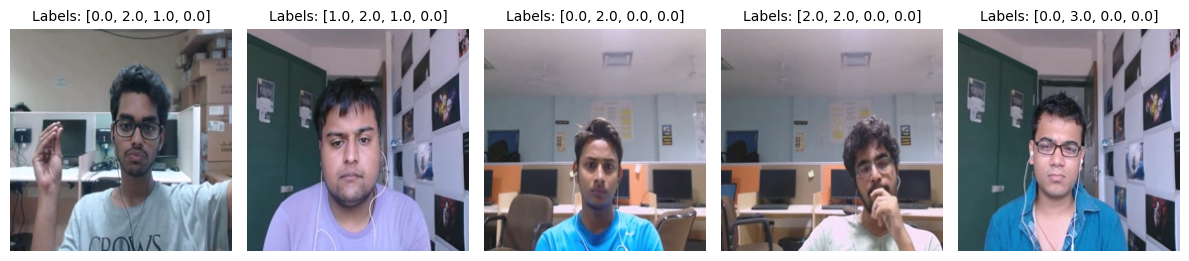

In [11]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def display_samples(data_loader, n_samples=5):
    """Display a grid of sample images with engagement labels."""
    try:
        images, labels = next(iter(data_loader))  # Get a batch
    except StopIteration:
        print("No data to display.")
        return

    # Inverse transform to convert images back to displayable format
    inv_trans = transforms.Compose([
        transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                             std=[1/0.229, 1/0.224, 1/0.225]),
    ])

    plt.figure(figsize=(12, 4))
    for i in range(min(n_samples, len(images))):
        # Apply inverse normalization
        img = inv_trans(images[i])
        # If the returned tensor is sparse, convert it to a dense tensor
        if img.is_sparse:
            img = img.to_dense()
        # Remove extra dimensions
        img = img.squeeze()
        # If still 4D, remove the extra dimension
        if img.dim() == 4:
            img = img[0]
        # Convert from [C, H, W] to [H, W, C] for display
        img = img.permute(1, 2, 0).clamp(0, 1)

        plt.subplot(1, n_samples, i + 1)
        plt.imshow(img.numpy())
        plt.title(f"Labels: {labels[i].tolist()}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Display sample images from the training set using the "Train" loader.
display_samples(loaders["Train"], n_samples=5)

### **Save preprocessed data**


In [12]:
import os
import torch

# Uncomment the lines below if you want to save the datasets for later use.
torch.save(datasets["Train"], os.path.join(str(FRAMES_ROOT), "train_set.pth"))
torch.save(datasets["Validation"], os.path.join(str(FRAMES_ROOT), "val_set.pth"))
torch.save(datasets["Test"], os.path.join(str(FRAMES_ROOT), "test_set.pth"))
